##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning with a pretrained ConvNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import os

import numpy as np

import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf


## Data preprocessing

### Data download

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dogs"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, and 10% of the data respectively.

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLRCBTK/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /home/kbuilder/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Show the first two images and labels from the training set:

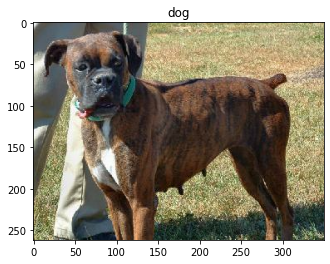

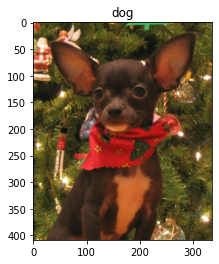

In [8]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [9]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data.

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [13]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [15]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [20]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [24]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 1/20 [>.............................] - ETA: 0s - loss: 0.8121 - accuracy: 0.5000

 3/20 [===>..........................] - ETA: 0s - loss: 0.8836 - accuracy: 0.3750

 5/20 [======>.......................] - ETA: 0s - loss: 0.8460 - accuracy: 0.4250

 7/20 [=========>....................] - ETA: 0s - loss: 0.8407 - accuracy: 0.4286

 9/20 [============>.................] - ETA: 0s - loss: 0.8354 - accuracy: 0.4201

11/20 [===============>..............] - ETA: 0s - loss: 0.8410 - accuracy: 0.4318

13/20 [==================>...........] - ETA: 0s - loss: 0.8396 - accuracy: 0.4375

15/20 [=====================>........] - ETA: 0s - loss: 0.8420 - accuracy: 0.4375

17/20 [========================>.....] - ETA: 0s - loss: 0.8316 - accuracy: 0.4467

19/20 [===========================>..] - ETA: 0s - loss: 0.8280 - accuracy: 0.4507

20/20 [==============================] - 1s 31ms/step - loss: 0.8325 - accuracy: 0.4516


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.45


In [26]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


  1/582 [..............................] - ETA: 0s - loss: 0.6777 - accuracy: 0.6250

  2/582 [..............................] - ETA: 15s - loss: 0.7300 - accuracy: 0.6250

  3/582 [..............................] - ETA: 20s - loss: 0.7426 - accuracy: 0.5625

  4/582 [..............................] - ETA: 22s - loss: 0.7796 - accuracy: 0.5156

  6/582 [..............................] - ETA: 24s - loss: 0.7590 - accuracy: 0.5417

  8/582 [..............................] - ETA: 24s - loss: 0.7654 - accuracy: 0.5156

  9/582 [..............................] - ETA: 25s - loss: 0.7700 - accuracy: 0.4965

 11/582 [..............................] - ETA: 25s - loss: 0.7685 - accuracy: 0.5057

 13/582 [..............................] - ETA: 25s - loss: 0.7527 - accuracy: 0.5168

 15/582 [..............................] - ETA: 25s - loss: 0.7454 - accuracy: 0.5333

 17/582 [..............................] - ETA: 25s - loss: 0.7390 - accuracy: 0.5423

 19/582 [..............................] - ETA: 25s - loss: 0.7299 - accuracy: 0.5411

 21/582 [>.............................] - ETA: 25s - loss: 0.7177 - accuracy: 0.5565

 23/582 [>.............................] - ETA: 25s - loss: 0.7106 - accuracy: 0.5611

 25/582 [>.............................] - ETA: 25s - loss: 0.7067 - accuracy: 0.5587

 27/582 [>.............................] - ETA: 25s - loss: 0.6957 - accuracy: 0.5625

 29/582 [>.............................] - ETA: 24s - loss: 0.6912 - accuracy: 0.5668

 31/582 [>.............................] - ETA: 24s - loss: 0.6853 - accuracy: 0.5746

 33/582 [>.............................] - ETA: 24s - loss: 0.6832 - accuracy: 0.5767

 34/582 [>.............................] - ETA: 24s - loss: 0.6808 - accuracy: 0.5763

 36/582 [>.............................] - ETA: 24s - loss: 0.6771 - accuracy: 0.5738

 38/582 [>.............................] - ETA: 24s - loss: 0.6719 - accuracy: 0.5748

 40/582 [=>............................] - ETA: 24s - loss: 0.6690 - accuracy: 0.5734

 42/582 [=>............................] - ETA: 24s - loss: 0.6613 - accuracy: 0.5804

 44/582 [=>............................] - ETA: 24s - loss: 0.6601 - accuracy: 0.5817

 46/582 [=>............................] - ETA: 24s - loss: 0.6528 - accuracy: 0.5876

 48/582 [=>............................] - ETA: 24s - loss: 0.6508 - accuracy: 0.5879

 50/582 [=>............................] - ETA: 24s - loss: 0.6458 - accuracy: 0.5906

 52/582 [=>............................] - ETA: 24s - loss: 0.6402 - accuracy: 0.5931

 54/582 [=>............................] - ETA: 23s - loss: 0.6349 - accuracy: 0.6001

 56/582 [=>............................] - ETA: 23s - loss: 0.6353 - accuracy: 0.5993

 58/582 [=>............................] - ETA: 23s - loss: 0.6337 - accuracy: 0.5975

 60/582 [==>...........................] - ETA: 23s - loss: 0.6294 - accuracy: 0.6016

 62/582 [==>...........................] - ETA: 23s - loss: 0.6251 - accuracy: 0.6064

 64/582 [==>...........................] - ETA: 23s - loss: 0.6213 - accuracy: 0.6074

 66/582 [==>...........................] - ETA: 23s - loss: 0.6163 - accuracy: 0.6117

 68/582 [==>...........................] - ETA: 23s - loss: 0.6108 - accuracy: 0.6167

 70/582 [==>...........................] - ETA: 23s - loss: 0.6048 - accuracy: 0.6214

 72/582 [==>...........................] - ETA: 23s - loss: 0.6008 - accuracy: 0.6228

 74/582 [==>...........................] - ETA: 23s - loss: 0.5959 - accuracy: 0.6280

 76/582 [==>...........................] - ETA: 23s - loss: 0.5934 - accuracy: 0.6299

 77/582 [==>...........................] - ETA: 23s - loss: 0.5905 - accuracy: 0.6327

 79/582 [===>..........................] - ETA: 22s - loss: 0.5859 - accuracy: 0.6353

 81/582 [===>..........................] - ETA: 22s - loss: 0.5828 - accuracy: 0.6377

 83/582 [===>..........................] - ETA: 22s - loss: 0.5798 - accuracy: 0.6408

 85/582 [===>..........................] - ETA: 22s - loss: 0.5759 - accuracy: 0.6445

 87/582 [===>..........................] - ETA: 22s - loss: 0.5720 - accuracy: 0.6483

 89/582 [===>..........................] - ETA: 22s - loss: 0.5679 - accuracy: 0.6520

 91/582 [===>..........................] - ETA: 22s - loss: 0.5636 - accuracy: 0.6566

 93/582 [===>..........................] - ETA: 22s - loss: 0.5604 - accuracy: 0.6593

 95/582 [===>..........................] - ETA: 22s - loss: 0.5559 - accuracy: 0.6635

 97/582 [====>.........................] - ETA: 22s - loss: 0.5538 - accuracy: 0.6672

 98/582 [====>.........................] - ETA: 22s - loss: 0.5519 - accuracy: 0.6684

100/582 [====>.........................] - ETA: 22s - loss: 0.5490 - accuracy: 0.6703

102/582 [====>.........................] - ETA: 21s - loss: 0.5472 - accuracy: 0.6713

104/582 [====>.........................] - ETA: 21s - loss: 0.5440 - accuracy: 0.6728

106/582 [====>.........................] - ETA: 21s - loss: 0.5408 - accuracy: 0.6763

108/582 [====>.........................] - ETA: 21s - loss: 0.5377 - accuracy: 0.6791

110/582 [====>.........................] - ETA: 21s - loss: 0.5352 - accuracy: 0.6812

112/582 [====>.........................] - ETA: 21s - loss: 0.5312 - accuracy: 0.6842

114/582 [====>.........................] - ETA: 21s - loss: 0.5291 - accuracy: 0.6859

116/582 [====>.........................] - ETA: 21s - loss: 0.5267 - accuracy: 0.6880

118/582 [=====>........................] - ETA: 21s - loss: 0.5232 - accuracy: 0.6907

120/582 [=====>........................] - ETA: 21s - loss: 0.5187 - accuracy: 0.6945

122/582 [=====>........................] - ETA: 21s - loss: 0.5158 - accuracy: 0.6970

124/582 [=====>........................] - ETA: 20s - loss: 0.5133 - accuracy: 0.6988

126/582 [=====>........................] - ETA: 20s - loss: 0.5097 - accuracy: 0.7026

128/582 [=====>........................] - ETA: 20s - loss: 0.5064 - accuracy: 0.7058

130/582 [=====>........................] - ETA: 20s - loss: 0.5025 - accuracy: 0.7091

132/582 [=====>........................] - ETA: 20s - loss: 0.5004 - accuracy: 0.7109

134/582 [=====>........................] - ETA: 20s - loss: 0.4977 - accuracy: 0.7127

136/582 [======>.......................] - ETA: 20s - loss: 0.4956 - accuracy: 0.7144

138/582 [======>.......................] - ETA: 20s - loss: 0.4927 - accuracy: 0.7160

140/582 [======>.......................] - ETA: 20s - loss: 0.4893 - accuracy: 0.7185

142/582 [======>.......................] - ETA: 20s - loss: 0.4861 - accuracy: 0.7214

144/582 [======>.......................] - ETA: 20s - loss: 0.4830 - accuracy: 0.7242

146/582 [======>.......................] - ETA: 19s - loss: 0.4804 - accuracy: 0.7262

148/582 [======>.......................] - ETA: 19s - loss: 0.4782 - accuracy: 0.7272

150/582 [======>.......................] - ETA: 19s - loss: 0.4757 - accuracy: 0.7296

152/582 [======>.......................] - ETA: 19s - loss: 0.4731 - accuracy: 0.7313

154/582 [======>.......................] - ETA: 19s - loss: 0.4703 - accuracy: 0.7336

156/582 [=======>......................] - ETA: 19s - loss: 0.4688 - accuracy: 0.7352

157/582 [=======>......................] - ETA: 19s - loss: 0.4675 - accuracy: 0.7361

159/582 [=======>......................] - ETA: 19s - loss: 0.4658 - accuracy: 0.7374

161/582 [=======>......................] - ETA: 19s - loss: 0.4628 - accuracy: 0.7393

163/582 [=======>......................] - ETA: 19s - loss: 0.4598 - accuracy: 0.7421

165/582 [=======>......................] - ETA: 19s - loss: 0.4576 - accuracy: 0.7436

167/582 [=======>......................] - ETA: 18s - loss: 0.4553 - accuracy: 0.7455

169/582 [=======>......................] - ETA: 18s - loss: 0.4528 - accuracy: 0.7470

171/582 [=======>......................] - ETA: 18s - loss: 0.4500 - accuracy: 0.7493

173/582 [=======>......................] - ETA: 18s - loss: 0.4480 - accuracy: 0.7507

175/582 [========>.....................] - ETA: 18s - loss: 0.4466 - accuracy: 0.7514

177/582 [========>.....................] - ETA: 18s - loss: 0.4440 - accuracy: 0.7535

179/582 [========>.....................] - ETA: 18s - loss: 0.4421 - accuracy: 0.7552

181/582 [========>.....................] - ETA: 18s - loss: 0.4402 - accuracy: 0.7566

183/582 [========>.....................] - ETA: 18s - loss: 0.4381 - accuracy: 0.7589

185/582 [========>.....................] - ETA: 18s - loss: 0.4357 - accuracy: 0.7605

187/582 [========>.....................] - ETA: 18s - loss: 0.4331 - accuracy: 0.7622

189/582 [========>.....................] - ETA: 17s - loss: 0.4306 - accuracy: 0.7641

191/582 [========>.....................] - ETA: 17s - loss: 0.4283 - accuracy: 0.7660

193/582 [========>.....................] - ETA: 17s - loss: 0.4257 - accuracy: 0.7678

195/582 [=========>....................] - ETA: 17s - loss: 0.4235 - accuracy: 0.7697

197/582 [=========>....................] - ETA: 17s - loss: 0.4215 - accuracy: 0.7716

199/582 [=========>....................] - ETA: 17s - loss: 0.4192 - accuracy: 0.7736

201/582 [=========>....................] - ETA: 17s - loss: 0.4173 - accuracy: 0.7749

203/582 [=========>....................] - ETA: 17s - loss: 0.4152 - accuracy: 0.7763

205/582 [=========>....................] - ETA: 17s - loss: 0.4135 - accuracy: 0.7777

207/582 [=========>....................] - ETA: 17s - loss: 0.4116 - accuracy: 0.7791

209/582 [=========>....................] - ETA: 17s - loss: 0.4098 - accuracy: 0.7808

211/582 [=========>....................] - ETA: 16s - loss: 0.4082 - accuracy: 0.7821

213/582 [=========>....................] - ETA: 16s - loss: 0.4065 - accuracy: 0.7837

215/582 [==========>...................] - ETA: 16s - loss: 0.4046 - accuracy: 0.7849

217/582 [==========>...................] - ETA: 16s - loss: 0.4020 - accuracy: 0.7866

219/582 [==========>...................] - ETA: 16s - loss: 0.4000 - accuracy: 0.7878

221/582 [==========>...................] - ETA: 16s - loss: 0.3985 - accuracy: 0.7890

223/582 [==========>...................] - ETA: 16s - loss: 0.3972 - accuracy: 0.7895

225/582 [==========>...................] - ETA: 16s - loss: 0.3956 - accuracy: 0.7907

227/582 [==========>...................] - ETA: 16s - loss: 0.3942 - accuracy: 0.7916

229/582 [==========>...................] - ETA: 16s - loss: 0.3921 - accuracy: 0.7930

231/582 [==========>...................] - ETA: 16s - loss: 0.3902 - accuracy: 0.7944

233/582 [===========>..................] - ETA: 15s - loss: 0.3887 - accuracy: 0.7955

235/582 [===========>..................] - ETA: 15s - loss: 0.3868 - accuracy: 0.7965

236/582 [===========>..................] - ETA: 15s - loss: 0.3858 - accuracy: 0.7974

238/582 [===========>..................] - ETA: 15s - loss: 0.3843 - accuracy: 0.7983

240/582 [===========>..................] - ETA: 15s - loss: 0.3823 - accuracy: 0.7999

242/582 [===========>..................] - ETA: 15s - loss: 0.3813 - accuracy: 0.8005

244/582 [===========>..................] - ETA: 15s - loss: 0.3800 - accuracy: 0.8015

246/582 [===========>..................] - ETA: 15s - loss: 0.3782 - accuracy: 0.8025

248/582 [===========>..................] - ETA: 15s - loss: 0.3769 - accuracy: 0.8033

250/582 [===========>..................] - ETA: 15s - loss: 0.3757 - accuracy: 0.8043

252/582 [===========>..................] - ETA: 15s - loss: 0.3738 - accuracy: 0.8056

254/582 [============>.................] - ETA: 14s - loss: 0.3724 - accuracy: 0.8067

256/582 [============>.................] - ETA: 14s - loss: 0.3706 - accuracy: 0.8079

258/582 [============>.................] - ETA: 14s - loss: 0.3695 - accuracy: 0.8083

260/582 [============>.................] - ETA: 14s - loss: 0.3685 - accuracy: 0.8087

262/582 [============>.................] - ETA: 14s - loss: 0.3665 - accuracy: 0.8101

264/582 [============>.................] - ETA: 14s - loss: 0.3648 - accuracy: 0.8112

266/582 [============>.................] - ETA: 14s - loss: 0.3631 - accuracy: 0.8124

268/582 [============>.................] - ETA: 14s - loss: 0.3616 - accuracy: 0.8133

270/582 [============>.................] - ETA: 14s - loss: 0.3606 - accuracy: 0.8137

272/582 [=============>................] - ETA: 14s - loss: 0.3590 - accuracy: 0.8146

274/582 [=============>................] - ETA: 14s - loss: 0.3573 - accuracy: 0.8156

276/582 [=============>................] - ETA: 13s - loss: 0.3559 - accuracy: 0.8166

278/582 [=============>................] - ETA: 13s - loss: 0.3545 - accuracy: 0.8173

280/582 [=============>................] - ETA: 13s - loss: 0.3530 - accuracy: 0.8183

282/582 [=============>................] - ETA: 13s - loss: 0.3520 - accuracy: 0.8191

284/582 [=============>................] - ETA: 13s - loss: 0.3502 - accuracy: 0.8202

286/582 [=============>................] - ETA: 13s - loss: 0.3490 - accuracy: 0.8211

288/582 [=============>................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8222

290/582 [=============>................] - ETA: 13s - loss: 0.3461 - accuracy: 0.8231

292/582 [==============>...............] - ETA: 13s - loss: 0.3454 - accuracy: 0.8235

294/582 [==============>...............] - ETA: 13s - loss: 0.3444 - accuracy: 0.8240

296/582 [==============>...............] - ETA: 13s - loss: 0.3433 - accuracy: 0.8247

298/582 [==============>...............] - ETA: 12s - loss: 0.3420 - accuracy: 0.8254

300/582 [==============>...............] - ETA: 12s - loss: 0.3412 - accuracy: 0.8261

302/582 [==============>...............] - ETA: 12s - loss: 0.3396 - accuracy: 0.8272

304/582 [==============>...............] - ETA: 12s - loss: 0.3385 - accuracy: 0.8279

306/582 [==============>...............] - ETA: 12s - loss: 0.3373 - accuracy: 0.8286

308/582 [==============>...............] - ETA: 12s - loss: 0.3362 - accuracy: 0.8296

310/582 [==============>...............] - ETA: 12s - loss: 0.3349 - accuracy: 0.8306

312/582 [===============>..............] - ETA: 12s - loss: 0.3338 - accuracy: 0.8312

314/582 [===============>..............] - ETA: 12s - loss: 0.3325 - accuracy: 0.8322

316/582 [===============>..............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8332

318/582 [===============>..............] - ETA: 12s - loss: 0.3299 - accuracy: 0.8340

320/582 [===============>..............] - ETA: 11s - loss: 0.3286 - accuracy: 0.8350

322/582 [===============>..............] - ETA: 11s - loss: 0.3272 - accuracy: 0.8359

324/582 [===============>..............] - ETA: 11s - loss: 0.3261 - accuracy: 0.8365

326/582 [===============>..............] - ETA: 11s - loss: 0.3252 - accuracy: 0.8369

328/582 [===============>..............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8378

330/582 [================>.............] - ETA: 11s - loss: 0.3226 - accuracy: 0.8386

332/582 [================>.............] - ETA: 11s - loss: 0.3215 - accuracy: 0.8393

334/582 [================>.............] - ETA: 11s - loss: 0.3204 - accuracy: 0.8400

336/582 [================>.............] - ETA: 11s - loss: 0.3190 - accuracy: 0.8407

338/582 [================>.............] - ETA: 11s - loss: 0.3182 - accuracy: 0.8410

340/582 [================>.............] - ETA: 11s - loss: 0.3170 - accuracy: 0.8417

342/582 [================>.............] - ETA: 10s - loss: 0.3159 - accuracy: 0.8426

344/582 [================>.............] - ETA: 10s - loss: 0.3151 - accuracy: 0.8429

346/582 [================>.............] - ETA: 10s - loss: 0.3144 - accuracy: 0.8434

348/582 [================>.............] - ETA: 10s - loss: 0.3134 - accuracy: 0.8440

350/582 [=================>............] - ETA: 10s - loss: 0.3124 - accuracy: 0.8447

352/582 [=================>............] - ETA: 10s - loss: 0.3113 - accuracy: 0.8453

354/582 [=================>............] - ETA: 10s - loss: 0.3101 - accuracy: 0.8461

356/582 [=================>............] - ETA: 10s - loss: 0.3090 - accuracy: 0.8466

358/582 [=================>............] - ETA: 10s - loss: 0.3080 - accuracy: 0.8472

360/582 [=================>............] - ETA: 10s - loss: 0.3069 - accuracy: 0.8480

362/582 [=================>............] - ETA: 10s - loss: 0.3061 - accuracy: 0.8482

364/582 [=================>............] - ETA: 9s - loss: 0.3049 - accuracy: 0.8489 

366/582 [=================>............] - ETA: 9s - loss: 0.3036 - accuracy: 0.8497

368/582 [=================>............] - ETA: 9s - loss: 0.3024 - accuracy: 0.8505

370/582 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8510

372/582 [==================>...........] - ETA: 9s - loss: 0.3004 - accuracy: 0.8516

374/582 [==================>...........] - ETA: 9s - loss: 0.2999 - accuracy: 0.8519

376/582 [==================>...........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8526

378/582 [==================>...........] - ETA: 9s - loss: 0.2975 - accuracy: 0.8533

380/582 [==================>...........] - ETA: 9s - loss: 0.2969 - accuracy: 0.8536

382/582 [==================>...........] - ETA: 9s - loss: 0.2959 - accuracy: 0.8543

384/582 [==================>...........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8547

386/582 [==================>...........] - ETA: 8s - loss: 0.2942 - accuracy: 0.8553

388/582 [===================>..........] - ETA: 8s - loss: 0.2932 - accuracy: 0.8559

389/582 [===================>..........] - ETA: 8s - loss: 0.2929 - accuracy: 0.8561

391/582 [===================>..........] - ETA: 8s - loss: 0.2920 - accuracy: 0.8568

393/582 [===================>..........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8572

395/582 [===================>..........] - ETA: 8s - loss: 0.2907 - accuracy: 0.8574

397/582 [===================>..........] - ETA: 8s - loss: 0.2898 - accuracy: 0.8579

399/582 [===================>..........] - ETA: 8s - loss: 0.2889 - accuracy: 0.8585

401/582 [===================>..........] - ETA: 8s - loss: 0.2879 - accuracy: 0.8589

403/582 [===================>..........] - ETA: 8s - loss: 0.2869 - accuracy: 0.8596

405/582 [===================>..........] - ETA: 8s - loss: 0.2863 - accuracy: 0.8600

407/582 [===================>..........] - ETA: 7s - loss: 0.2855 - accuracy: 0.8605

409/582 [====================>.........] - ETA: 7s - loss: 0.2845 - accuracy: 0.8611

411/582 [====================>.........] - ETA: 7s - loss: 0.2837 - accuracy: 0.8617

413/582 [====================>.........] - ETA: 7s - loss: 0.2830 - accuracy: 0.8621

415/582 [====================>.........] - ETA: 7s - loss: 0.2821 - accuracy: 0.8627

417/582 [====================>.........] - ETA: 7s - loss: 0.2815 - accuracy: 0.8632

419/582 [====================>.........] - ETA: 7s - loss: 0.2807 - accuracy: 0.8636

421/582 [====================>.........] - ETA: 7s - loss: 0.2798 - accuracy: 0.8642

423/582 [====================>.........] - ETA: 7s - loss: 0.2792 - accuracy: 0.8644

425/582 [====================>.........] - ETA: 7s - loss: 0.2782 - accuracy: 0.8649

427/582 [=====================>........] - ETA: 7s - loss: 0.2774 - accuracy: 0.8653

429/582 [=====================>........] - ETA: 6s - loss: 0.2766 - accuracy: 0.8658

431/582 [=====================>........] - ETA: 6s - loss: 0.2759 - accuracy: 0.8664

433/582 [=====================>........] - ETA: 6s - loss: 0.2749 - accuracy: 0.8669

435/582 [=====================>........] - ETA: 6s - loss: 0.2743 - accuracy: 0.8673

437/582 [=====================>........] - ETA: 6s - loss: 0.2736 - accuracy: 0.8676

439/582 [=====================>........] - ETA: 6s - loss: 0.2726 - accuracy: 0.8682

441/582 [=====================>........] - ETA: 6s - loss: 0.2720 - accuracy: 0.8685

443/582 [=====================>........] - ETA: 6s - loss: 0.2715 - accuracy: 0.8687

445/582 [=====================>........] - ETA: 6s - loss: 0.2706 - accuracy: 0.8691

447/582 [======================>.......] - ETA: 6s - loss: 0.2698 - accuracy: 0.8697

449/582 [======================>.......] - ETA: 6s - loss: 0.2689 - accuracy: 0.8701

451/582 [======================>.......] - ETA: 5s - loss: 0.2685 - accuracy: 0.8704

453/582 [======================>.......] - ETA: 5s - loss: 0.2681 - accuracy: 0.8706

455/582 [======================>.......] - ETA: 5s - loss: 0.2674 - accuracy: 0.8710

457/582 [======================>.......] - ETA: 5s - loss: 0.2667 - accuracy: 0.8714

459/582 [======================>.......] - ETA: 5s - loss: 0.2659 - accuracy: 0.8719

461/582 [======================>.......] - ETA: 5s - loss: 0.2652 - accuracy: 0.8724

463/582 [======================>.......] - ETA: 5s - loss: 0.2645 - accuracy: 0.8728

465/582 [======================>.......] - ETA: 5s - loss: 0.2637 - accuracy: 0.8732

467/582 [=======================>......] - ETA: 5s - loss: 0.2628 - accuracy: 0.8737

469/582 [=======================>......] - ETA: 5s - loss: 0.2623 - accuracy: 0.8739

471/582 [=======================>......] - ETA: 5s - loss: 0.2616 - accuracy: 0.8743

473/582 [=======================>......] - ETA: 4s - loss: 0.2609 - accuracy: 0.8747

475/582 [=======================>......] - ETA: 4s - loss: 0.2603 - accuracy: 0.8751

477/582 [=======================>......] - ETA: 4s - loss: 0.2597 - accuracy: 0.8754

479/582 [=======================>......] - ETA: 4s - loss: 0.2591 - accuracy: 0.8758

481/582 [=======================>......] - ETA: 4s - loss: 0.2584 - accuracy: 0.8762

483/582 [=======================>......] - ETA: 4s - loss: 0.2579 - accuracy: 0.8764

485/582 [========================>.....] - ETA: 4s - loss: 0.2571 - accuracy: 0.8769

487/582 [========================>.....] - ETA: 4s - loss: 0.2565 - accuracy: 0.8772

489/582 [========================>.....] - ETA: 4s - loss: 0.2558 - accuracy: 0.8776

491/582 [========================>.....] - ETA: 4s - loss: 0.2550 - accuracy: 0.8781

493/582 [========================>.....] - ETA: 4s - loss: 0.2544 - accuracy: 0.8784

495/582 [========================>.....] - ETA: 3s - loss: 0.2537 - accuracy: 0.8788

497/582 [========================>.....] - ETA: 3s - loss: 0.2529 - accuracy: 0.8792

499/582 [========================>.....] - ETA: 3s - loss: 0.2524 - accuracy: 0.8795

501/582 [========================>.....] - ETA: 3s - loss: 0.2520 - accuracy: 0.8797

503/582 [========================>.....] - ETA: 3s - loss: 0.2515 - accuracy: 0.8798

505/582 [=========================>....] - ETA: 3s - loss: 0.2508 - accuracy: 0.8803

507/582 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8807

509/582 [=========================>....] - ETA: 3s - loss: 0.2494 - accuracy: 0.8810

510/582 [=========================>....] - ETA: 3s - loss: 0.2491 - accuracy: 0.8812

512/582 [=========================>....] - ETA: 3s - loss: 0.2488 - accuracy: 0.8814

513/582 [=========================>....] - ETA: 3s - loss: 0.2485 - accuracy: 0.8816

515/582 [=========================>....] - ETA: 3s - loss: 0.2478 - accuracy: 0.8820

517/582 [=========================>....] - ETA: 2s - loss: 0.2470 - accuracy: 0.8824

519/582 [=========================>....] - ETA: 2s - loss: 0.2463 - accuracy: 0.8829

521/582 [=========================>....] - ETA: 2s - loss: 0.2457 - accuracy: 0.8833

523/582 [=========================>....] - ETA: 2s - loss: 0.2450 - accuracy: 0.8837

525/582 [==========================>...] - ETA: 2s - loss: 0.2444 - accuracy: 0.8840

527/582 [==========================>...] - ETA: 2s - loss: 0.2441 - accuracy: 0.8842

528/582 [==========================>...] - ETA: 2s - loss: 0.2439 - accuracy: 0.8844

530/582 [==========================>...] - ETA: 2s - loss: 0.2432 - accuracy: 0.8847

532/582 [==========================>...] - ETA: 2s - loss: 0.2428 - accuracy: 0.8849

534/582 [==========================>...] - ETA: 2s - loss: 0.2422 - accuracy: 0.8852

536/582 [==========================>...] - ETA: 2s - loss: 0.2416 - accuracy: 0.8856

538/582 [==========================>...] - ETA: 2s - loss: 0.2409 - accuracy: 0.8860

540/582 [==========================>...] - ETA: 1s - loss: 0.2405 - accuracy: 0.8863

541/582 [==========================>...] - ETA: 1s - loss: 0.2402 - accuracy: 0.8864

543/582 [==========================>...] - ETA: 1s - loss: 0.2396 - accuracy: 0.8867

544/582 [===========================>..] - ETA: 1s - loss: 0.2392 - accuracy: 0.8869

546/582 [===========================>..] - ETA: 1s - loss: 0.2387 - accuracy: 0.8873

548/582 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.8876

550/582 [===========================>..] - ETA: 1s - loss: 0.2379 - accuracy: 0.8879

553/582 [===========================>..] - ETA: 1s - loss: 0.2372 - accuracy: 0.8882

557/582 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.8887

561/582 [===========================>..] - ETA: 0s - loss: 0.2351 - accuracy: 0.8894

565/582 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.8899

570/582 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.8905

575/582 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.8911

580/582 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.8918

582/582 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.8920

582/582 [==============================] - 28s 49ms/step - loss: 0.2302 - accuracy: 0.8920 - val_loss: 0.0964 - val_accuracy: 0.9574


Epoch 2/10


  1/582 [..............................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9688

  3/582 [..............................] - ETA: 17s - loss: 0.1127 - accuracy: 0.9479

  5/582 [..............................] - ETA: 20s - loss: 0.0902 - accuracy: 0.9625

  7/582 [..............................] - ETA: 22s - loss: 0.0984 - accuracy: 0.9598

  9/582 [..............................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9549

 11/582 [..............................] - ETA: 23s - loss: 0.1014 - accuracy: 0.9545

 13/582 [..............................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9591

 15/582 [..............................] - ETA: 24s - loss: 0.0972 - accuracy: 0.9604

 17/582 [..............................] - ETA: 24s - loss: 0.0942 - accuracy: 0.9632

 19/582 [..............................] - ETA: 24s - loss: 0.0928 - accuracy: 0.9622

 21/582 [>.............................] - ETA: 24s - loss: 0.0930 - accuracy: 0.9628

 23/582 [>.............................] - ETA: 24s - loss: 0.0918 - accuracy: 0.9633

 25/582 [>.............................] - ETA: 24s - loss: 0.0881 - accuracy: 0.9663

 27/582 [>.............................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9653

 29/582 [>.............................] - ETA: 24s - loss: 0.0891 - accuracy: 0.9644

 31/582 [>.............................] - ETA: 24s - loss: 0.0899 - accuracy: 0.9617

 33/582 [>.............................] - ETA: 24s - loss: 0.0937 - accuracy: 0.9612

 35/582 [>.............................] - ETA: 24s - loss: 0.0939 - accuracy: 0.9616

 37/582 [>.............................] - ETA: 23s - loss: 0.0964 - accuracy: 0.9620

 39/582 [=>............................] - ETA: 23s - loss: 0.0959 - accuracy: 0.9623

 41/582 [=>............................] - ETA: 23s - loss: 0.0946 - accuracy: 0.9634

 43/582 [=>............................] - ETA: 23s - loss: 0.0942 - accuracy: 0.9637

 45/582 [=>............................] - ETA: 23s - loss: 0.0925 - accuracy: 0.9646

 47/582 [=>............................] - ETA: 23s - loss: 0.0919 - accuracy: 0.9648

 49/582 [=>............................] - ETA: 23s - loss: 0.0953 - accuracy: 0.9630

 51/582 [=>............................] - ETA: 23s - loss: 0.0966 - accuracy: 0.9620

 53/582 [=>............................] - ETA: 23s - loss: 0.0961 - accuracy: 0.9629

 55/582 [=>............................] - ETA: 23s - loss: 0.0950 - accuracy: 0.9636

 57/582 [=>............................] - ETA: 23s - loss: 0.0936 - accuracy: 0.9649

 59/582 [==>...........................] - ETA: 23s - loss: 0.0925 - accuracy: 0.9656

 61/582 [==>...........................] - ETA: 23s - loss: 0.0920 - accuracy: 0.9657

 63/582 [==>...........................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9668

 65/582 [==>...........................] - ETA: 23s - loss: 0.0902 - accuracy: 0.9668

 67/582 [==>...........................] - ETA: 22s - loss: 0.0890 - accuracy: 0.9678

 69/582 [==>...........................] - ETA: 22s - loss: 0.0890 - accuracy: 0.9674

 71/582 [==>...........................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9670

 73/582 [==>...........................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9675

 75/582 [==>...........................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9683

 77/582 [==>...........................] - ETA: 22s - loss: 0.0879 - accuracy: 0.9683

 79/582 [===>..........................] - ETA: 22s - loss: 0.0880 - accuracy: 0.9680

 81/582 [===>..........................] - ETA: 22s - loss: 0.0882 - accuracy: 0.9676

 83/582 [===>..........................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9672

 85/582 [===>..........................] - ETA: 22s - loss: 0.0879 - accuracy: 0.9676

 87/582 [===>..........................] - ETA: 22s - loss: 0.0874 - accuracy: 0.9677

 89/582 [===>..........................] - ETA: 22s - loss: 0.0876 - accuracy: 0.9673

 91/582 [===>..........................] - ETA: 22s - loss: 0.0869 - accuracy: 0.9674

 93/582 [===>..........................] - ETA: 21s - loss: 0.0863 - accuracy: 0.9674

 95/582 [===>..........................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9674

 97/582 [====>.........................] - ETA: 21s - loss: 0.0872 - accuracy: 0.9668

 99/582 [====>.........................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9669

101/582 [====>.........................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9669

103/582 [====>.........................] - ETA: 21s - loss: 0.0867 - accuracy: 0.9669

105/582 [====>.........................] - ETA: 21s - loss: 0.0862 - accuracy: 0.9673

107/582 [====>.........................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9670

109/582 [====>.........................] - ETA: 21s - loss: 0.0854 - accuracy: 0.9670

111/582 [====>.........................] - ETA: 21s - loss: 0.0852 - accuracy: 0.9673

113/582 [====>.........................] - ETA: 21s - loss: 0.0848 - accuracy: 0.9676

115/582 [====>.........................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9679

117/582 [=====>........................] - ETA: 20s - loss: 0.0855 - accuracy: 0.9671

119/582 [=====>........................] - ETA: 20s - loss: 0.0867 - accuracy: 0.9666

121/582 [=====>........................] - ETA: 20s - loss: 0.0859 - accuracy: 0.9669

123/582 [=====>........................] - ETA: 20s - loss: 0.0863 - accuracy: 0.9667

125/582 [=====>........................] - ETA: 20s - loss: 0.0863 - accuracy: 0.9665

127/582 [=====>........................] - ETA: 20s - loss: 0.0859 - accuracy: 0.9670

129/582 [=====>........................] - ETA: 20s - loss: 0.0861 - accuracy: 0.9668

131/582 [=====>........................] - ETA: 20s - loss: 0.0862 - accuracy: 0.9666

133/582 [=====>........................] - ETA: 20s - loss: 0.0860 - accuracy: 0.9666

135/582 [=====>........................] - ETA: 20s - loss: 0.0859 - accuracy: 0.9669

137/582 [======>.......................] - ETA: 20s - loss: 0.0856 - accuracy: 0.9674

139/582 [======>.......................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9674

141/582 [======>.......................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9676

143/582 [======>.......................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9672

145/582 [======>.......................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9672

147/582 [======>.......................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9673

149/582 [======>.......................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9675

151/582 [======>.......................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9675

153/582 [======>.......................] - ETA: 19s - loss: 0.0852 - accuracy: 0.9671

155/582 [======>.......................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9671

156/582 [=======>......................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9671

158/582 [=======>......................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9670

160/582 [=======>......................] - ETA: 19s - loss: 0.0852 - accuracy: 0.9668

162/582 [=======>......................] - ETA: 18s - loss: 0.0849 - accuracy: 0.9672

164/582 [=======>......................] - ETA: 18s - loss: 0.0851 - accuracy: 0.9670

166/582 [=======>......................] - ETA: 18s - loss: 0.0849 - accuracy: 0.9671

168/582 [=======>......................] - ETA: 18s - loss: 0.0852 - accuracy: 0.9669

170/582 [=======>......................] - ETA: 18s - loss: 0.0857 - accuracy: 0.9669

172/582 [=======>......................] - ETA: 18s - loss: 0.0856 - accuracy: 0.9668

174/582 [=======>......................] - ETA: 18s - loss: 0.0856 - accuracy: 0.9668

176/582 [========>.....................] - ETA: 18s - loss: 0.0853 - accuracy: 0.9672

178/582 [========>.....................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9673

180/582 [========>.....................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9674

182/582 [========>.....................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9677

184/582 [========>.....................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9681

186/582 [========>.....................] - ETA: 17s - loss: 0.0844 - accuracy: 0.9681

188/582 [========>.....................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9684

190/582 [========>.....................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9684

192/582 [========>.....................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9681

194/582 [=========>....................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9676

196/582 [=========>....................] - ETA: 17s - loss: 0.0846 - accuracy: 0.9675

198/582 [=========>....................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9676

200/582 [=========>....................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9673

202/582 [=========>....................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9672

204/582 [=========>....................] - ETA: 17s - loss: 0.0846 - accuracy: 0.9674

206/582 [=========>....................] - ETA: 16s - loss: 0.0854 - accuracy: 0.9672

208/582 [=========>....................] - ETA: 16s - loss: 0.0855 - accuracy: 0.9672

210/582 [=========>....................] - ETA: 16s - loss: 0.0849 - accuracy: 0.9676

212/582 [=========>....................] - ETA: 16s - loss: 0.0850 - accuracy: 0.9676

214/582 [==========>...................] - ETA: 16s - loss: 0.0848 - accuracy: 0.9676

216/582 [==========>...................] - ETA: 16s - loss: 0.0847 - accuracy: 0.9677

217/582 [==========>...................] - ETA: 16s - loss: 0.0846 - accuracy: 0.9677

219/582 [==========>...................] - ETA: 16s - loss: 0.0845 - accuracy: 0.9678

221/582 [==========>...................] - ETA: 16s - loss: 0.0848 - accuracy: 0.9678

223/582 [==========>...................] - ETA: 16s - loss: 0.0842 - accuracy: 0.9680

225/582 [==========>...................] - ETA: 16s - loss: 0.0842 - accuracy: 0.9679

227/582 [==========>...................] - ETA: 16s - loss: 0.0841 - accuracy: 0.9679

229/582 [==========>...................] - ETA: 15s - loss: 0.0843 - accuracy: 0.9678

231/582 [==========>...................] - ETA: 15s - loss: 0.0839 - accuracy: 0.9681

233/582 [===========>..................] - ETA: 15s - loss: 0.0843 - accuracy: 0.9678

235/582 [===========>..................] - ETA: 15s - loss: 0.0841 - accuracy: 0.9678

237/582 [===========>..................] - ETA: 15s - loss: 0.0840 - accuracy: 0.9678

239/582 [===========>..................] - ETA: 15s - loss: 0.0840 - accuracy: 0.9678

241/582 [===========>..................] - ETA: 15s - loss: 0.0839 - accuracy: 0.9678

243/582 [===========>..................] - ETA: 15s - loss: 0.0838 - accuracy: 0.9678

245/582 [===========>..................] - ETA: 15s - loss: 0.0837 - accuracy: 0.9681

247/582 [===========>..................] - ETA: 15s - loss: 0.0837 - accuracy: 0.9679

249/582 [===========>..................] - ETA: 15s - loss: 0.0837 - accuracy: 0.9679

251/582 [===========>..................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9680

253/582 [============>.................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9681

255/582 [============>.................] - ETA: 14s - loss: 0.0841 - accuracy: 0.9680

257/582 [============>.................] - ETA: 14s - loss: 0.0841 - accuracy: 0.9680

259/582 [============>.................] - ETA: 14s - loss: 0.0843 - accuracy: 0.9679

261/582 [============>.................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9682

263/582 [============>.................] - ETA: 14s - loss: 0.0843 - accuracy: 0.9682

265/582 [============>.................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9682

267/582 [============>.................] - ETA: 14s - loss: 0.0847 - accuracy: 0.9680

268/582 [============>.................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9682

270/582 [============>.................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9682

272/582 [=============>................] - ETA: 14s - loss: 0.0842 - accuracy: 0.9682

274/582 [=============>................] - ETA: 13s - loss: 0.0841 - accuracy: 0.9682

276/582 [=============>................] - ETA: 13s - loss: 0.0838 - accuracy: 0.9682

278/582 [=============>................] - ETA: 13s - loss: 0.0838 - accuracy: 0.9683

280/582 [=============>................] - ETA: 13s - loss: 0.0835 - accuracy: 0.9684

282/582 [=============>................] - ETA: 13s - loss: 0.0835 - accuracy: 0.9685

284/582 [=============>................] - ETA: 13s - loss: 0.0833 - accuracy: 0.9688

286/582 [=============>................] - ETA: 13s - loss: 0.0835 - accuracy: 0.9685

288/582 [=============>................] - ETA: 13s - loss: 0.0834 - accuracy: 0.9685

290/582 [=============>................] - ETA: 13s - loss: 0.0833 - accuracy: 0.9684

292/582 [==============>...............] - ETA: 13s - loss: 0.0831 - accuracy: 0.9686

294/582 [==============>...............] - ETA: 13s - loss: 0.0828 - accuracy: 0.9689

296/582 [==============>...............] - ETA: 12s - loss: 0.0826 - accuracy: 0.9689

298/582 [==============>...............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9691

300/582 [==============>...............] - ETA: 12s - loss: 0.0823 - accuracy: 0.9692

302/582 [==============>...............] - ETA: 12s - loss: 0.0825 - accuracy: 0.9692

304/582 [==============>...............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9693

306/582 [==============>...............] - ETA: 12s - loss: 0.0822 - accuracy: 0.9694

308/582 [==============>...............] - ETA: 12s - loss: 0.0819 - accuracy: 0.9696

310/582 [==============>...............] - ETA: 12s - loss: 0.0816 - accuracy: 0.9698

312/582 [===============>..............] - ETA: 12s - loss: 0.0817 - accuracy: 0.9698

314/582 [===============>..............] - ETA: 12s - loss: 0.0814 - accuracy: 0.9699

316/582 [===============>..............] - ETA: 12s - loss: 0.0813 - accuracy: 0.9700

318/582 [===============>..............] - ETA: 12s - loss: 0.0811 - accuracy: 0.9702

320/582 [===============>..............] - ETA: 11s - loss: 0.0811 - accuracy: 0.9702

322/582 [===============>..............] - ETA: 11s - loss: 0.0811 - accuracy: 0.9702

324/582 [===============>..............] - ETA: 11s - loss: 0.0808 - accuracy: 0.9703

326/582 [===============>..............] - ETA: 11s - loss: 0.0809 - accuracy: 0.9703

328/582 [===============>..............] - ETA: 11s - loss: 0.0808 - accuracy: 0.9704

330/582 [================>.............] - ETA: 11s - loss: 0.0806 - accuracy: 0.9704

332/582 [================>.............] - ETA: 11s - loss: 0.0807 - accuracy: 0.9703

334/582 [================>.............] - ETA: 11s - loss: 0.0807 - accuracy: 0.9702

336/582 [================>.............] - ETA: 11s - loss: 0.0811 - accuracy: 0.9701

338/582 [================>.............] - ETA: 11s - loss: 0.0810 - accuracy: 0.9700

340/582 [================>.............] - ETA: 11s - loss: 0.0808 - accuracy: 0.9700

342/582 [================>.............] - ETA: 10s - loss: 0.0806 - accuracy: 0.9702

344/582 [================>.............] - ETA: 10s - loss: 0.0804 - accuracy: 0.9703

346/582 [================>.............] - ETA: 10s - loss: 0.0801 - accuracy: 0.9705

348/582 [================>.............] - ETA: 10s - loss: 0.0805 - accuracy: 0.9703

350/582 [=================>............] - ETA: 10s - loss: 0.0809 - accuracy: 0.9700

352/582 [=================>............] - ETA: 10s - loss: 0.0810 - accuracy: 0.9699

354/582 [=================>............] - ETA: 10s - loss: 0.0810 - accuracy: 0.9699

356/582 [=================>............] - ETA: 10s - loss: 0.0807 - accuracy: 0.9700

358/582 [=================>............] - ETA: 10s - loss: 0.0808 - accuracy: 0.9700

360/582 [=================>............] - ETA: 10s - loss: 0.0807 - accuracy: 0.9700

362/582 [=================>............] - ETA: 10s - loss: 0.0806 - accuracy: 0.9700

364/582 [=================>............] - ETA: 9s - loss: 0.0805 - accuracy: 0.9700 

366/582 [=================>............] - ETA: 9s - loss: 0.0803 - accuracy: 0.9700

368/582 [=================>............] - ETA: 9s - loss: 0.0802 - accuracy: 0.9700

370/582 [==================>...........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9700

371/582 [==================>...........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9700

373/582 [==================>...........] - ETA: 9s - loss: 0.0802 - accuracy: 0.9702

375/582 [==================>...........] - ETA: 9s - loss: 0.0800 - accuracy: 0.9703

377/582 [==================>...........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9704

379/582 [==================>...........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9706

381/582 [==================>...........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9706

383/582 [==================>...........] - ETA: 9s - loss: 0.0797 - accuracy: 0.9707

385/582 [==================>...........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9707

387/582 [==================>...........] - ETA: 8s - loss: 0.0800 - accuracy: 0.9704

388/582 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9705

390/582 [===================>..........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9705

392/582 [===================>..........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9705

394/582 [===================>..........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9706

396/582 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9704

397/582 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9703

399/582 [===================>..........] - ETA: 8s - loss: 0.0799 - accuracy: 0.9702

401/582 [===================>..........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9703

403/582 [===================>..........] - ETA: 8s - loss: 0.0795 - accuracy: 0.9704

404/582 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9701

406/582 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9701

408/582 [====================>.........] - ETA: 7s - loss: 0.0797 - accuracy: 0.9703

410/582 [====================>.........] - ETA: 7s - loss: 0.0797 - accuracy: 0.9703

412/582 [====================>.........] - ETA: 7s - loss: 0.0795 - accuracy: 0.9703

414/582 [====================>.........] - ETA: 7s - loss: 0.0795 - accuracy: 0.9703

416/582 [====================>.........] - ETA: 7s - loss: 0.0794 - accuracy: 0.9704

418/582 [====================>.........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9705

420/582 [====================>.........] - ETA: 7s - loss: 0.0791 - accuracy: 0.9707

422/582 [====================>.........] - ETA: 7s - loss: 0.0790 - accuracy: 0.9707

424/582 [====================>.........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9709

426/582 [====================>.........] - ETA: 7s - loss: 0.0786 - accuracy: 0.9709

428/582 [=====================>........] - ETA: 7s - loss: 0.0785 - accuracy: 0.9709

430/582 [=====================>........] - ETA: 6s - loss: 0.0786 - accuracy: 0.9709

432/582 [=====================>........] - ETA: 6s - loss: 0.0786 - accuracy: 0.9708

434/582 [=====================>........] - ETA: 6s - loss: 0.0785 - accuracy: 0.9708

436/582 [=====================>........] - ETA: 6s - loss: 0.0785 - accuracy: 0.9708

438/582 [=====================>........] - ETA: 6s - loss: 0.0784 - accuracy: 0.9708

439/582 [=====================>........] - ETA: 6s - loss: 0.0785 - accuracy: 0.9707

441/582 [=====================>........] - ETA: 6s - loss: 0.0785 - accuracy: 0.9706

443/582 [=====================>........] - ETA: 6s - loss: 0.0784 - accuracy: 0.9705

445/582 [=====================>........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9705

447/582 [======================>.......] - ETA: 6s - loss: 0.0782 - accuracy: 0.9705

449/582 [======================>.......] - ETA: 6s - loss: 0.0784 - accuracy: 0.9705

451/582 [======================>.......] - ETA: 5s - loss: 0.0783 - accuracy: 0.9706

453/582 [======================>.......] - ETA: 5s - loss: 0.0782 - accuracy: 0.9706

455/582 [======================>.......] - ETA: 5s - loss: 0.0780 - accuracy: 0.9707

457/582 [======================>.......] - ETA: 5s - loss: 0.0779 - accuracy: 0.9707

459/582 [======================>.......] - ETA: 5s - loss: 0.0777 - accuracy: 0.9709

461/582 [======================>.......] - ETA: 5s - loss: 0.0777 - accuracy: 0.9709

463/582 [======================>.......] - ETA: 5s - loss: 0.0777 - accuracy: 0.9708

465/582 [======================>.......] - ETA: 5s - loss: 0.0781 - accuracy: 0.9708

467/582 [=======================>......] - ETA: 5s - loss: 0.0781 - accuracy: 0.9708

469/582 [=======================>......] - ETA: 5s - loss: 0.0782 - accuracy: 0.9706

471/582 [=======================>......] - ETA: 5s - loss: 0.0780 - accuracy: 0.9707

473/582 [=======================>......] - ETA: 4s - loss: 0.0781 - accuracy: 0.9705

475/582 [=======================>......] - ETA: 4s - loss: 0.0780 - accuracy: 0.9706

477/582 [=======================>......] - ETA: 4s - loss: 0.0779 - accuracy: 0.9707

479/582 [=======================>......] - ETA: 4s - loss: 0.0777 - accuracy: 0.9708

481/582 [=======================>......] - ETA: 4s - loss: 0.0779 - accuracy: 0.9707

483/582 [=======================>......] - ETA: 4s - loss: 0.0778 - accuracy: 0.9708

485/582 [========================>.....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9709

487/582 [========================>.....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9709

489/582 [========================>.....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9708

491/582 [========================>.....] - ETA: 4s - loss: 0.0778 - accuracy: 0.9707

493/582 [========================>.....] - ETA: 4s - loss: 0.0777 - accuracy: 0.9708

494/582 [========================>.....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9709

496/582 [========================>.....] - ETA: 3s - loss: 0.0775 - accuracy: 0.9709

498/582 [========================>.....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9709

500/582 [========================>.....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9709

502/582 [========================>.....] - ETA: 3s - loss: 0.0771 - accuracy: 0.9710

504/582 [========================>.....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9710

506/582 [=========================>....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9710

508/582 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9710

510/582 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9710

512/582 [=========================>....] - ETA: 3s - loss: 0.0773 - accuracy: 0.9710

514/582 [=========================>....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9710

516/582 [=========================>....] - ETA: 3s - loss: 0.0773 - accuracy: 0.9711

518/582 [=========================>....] - ETA: 2s - loss: 0.0772 - accuracy: 0.9711

520/582 [=========================>....] - ETA: 2s - loss: 0.0770 - accuracy: 0.9712

522/582 [=========================>....] - ETA: 2s - loss: 0.0768 - accuracy: 0.9712

524/582 [==========================>...] - ETA: 2s - loss: 0.0767 - accuracy: 0.9713

526/582 [==========================>...] - ETA: 2s - loss: 0.0769 - accuracy: 0.9711

528/582 [==========================>...] - ETA: 2s - loss: 0.0768 - accuracy: 0.9712

530/582 [==========================>...] - ETA: 2s - loss: 0.0767 - accuracy: 0.9712

531/582 [==========================>...] - ETA: 2s - loss: 0.0766 - accuracy: 0.9713

533/582 [==========================>...] - ETA: 2s - loss: 0.0764 - accuracy: 0.9714

535/582 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9715

537/582 [==========================>...] - ETA: 2s - loss: 0.0761 - accuracy: 0.9715

539/582 [==========================>...] - ETA: 1s - loss: 0.0760 - accuracy: 0.9716

541/582 [==========================>...] - ETA: 1s - loss: 0.0761 - accuracy: 0.9715

542/582 [==========================>...] - ETA: 1s - loss: 0.0761 - accuracy: 0.9714

543/582 [==========================>...] - ETA: 1s - loss: 0.0761 - accuracy: 0.9715

545/582 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9714

547/582 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9715

549/582 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9715

551/582 [===========================>..] - ETA: 1s - loss: 0.0759 - accuracy: 0.9716

555/582 [===========================>..] - ETA: 1s - loss: 0.0758 - accuracy: 0.9717

559/582 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9717

563/582 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9717

568/582 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9718

573/582 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9719

578/582 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9719

582/582 [==============================] - 28s 48ms/step - loss: 0.0749 - accuracy: 0.9720 - val_loss: 0.0677 - val_accuracy: 0.9755


Epoch 3/10


  1/582 [..............................] - ETA: 0s - loss: 0.0226 - accuracy: 1.0000

  3/582 [..............................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9792

  5/582 [..............................] - ETA: 21s - loss: 0.0779 - accuracy: 0.9750

  7/582 [..............................] - ETA: 22s - loss: 0.0694 - accuracy: 0.9777

  9/582 [..............................] - ETA: 23s - loss: 0.0630 - accuracy: 0.9826

 11/582 [..............................] - ETA: 23s - loss: 0.0734 - accuracy: 0.9801

 13/582 [..............................] - ETA: 23s - loss: 0.0680 - accuracy: 0.9832

 15/582 [..............................] - ETA: 23s - loss: 0.0661 - accuracy: 0.9833

 17/582 [..............................] - ETA: 23s - loss: 0.0653 - accuracy: 0.9816

 19/582 [..............................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9819

 21/582 [>.............................] - ETA: 23s - loss: 0.0611 - accuracy: 0.9836

 23/582 [>.............................] - ETA: 23s - loss: 0.0595 - accuracy: 0.9851

 25/582 [>.............................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9862

 26/582 [>.............................] - ETA: 24s - loss: 0.0569 - accuracy: 0.9856

 28/582 [>.............................] - ETA: 23s - loss: 0.0591 - accuracy: 0.9833

 30/582 [>.............................] - ETA: 23s - loss: 0.0574 - accuracy: 0.9844

 32/582 [>.............................] - ETA: 23s - loss: 0.0635 - accuracy: 0.9814

 34/582 [>.............................] - ETA: 23s - loss: 0.0659 - accuracy: 0.9798

 36/582 [>.............................] - ETA: 23s - loss: 0.0639 - accuracy: 0.9800

 38/582 [>.............................] - ETA: 23s - loss: 0.0666 - accuracy: 0.9778

 40/582 [=>............................] - ETA: 23s - loss: 0.0655 - accuracy: 0.9781

 42/582 [=>............................] - ETA: 23s - loss: 0.0641 - accuracy: 0.9784

 44/582 [=>............................] - ETA: 23s - loss: 0.0671 - accuracy: 0.9773

 46/582 [=>............................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9776

 48/582 [=>............................] - ETA: 23s - loss: 0.0653 - accuracy: 0.9785

 50/582 [=>............................] - ETA: 23s - loss: 0.0636 - accuracy: 0.9794

 52/582 [=>............................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9772

 54/582 [=>............................] - ETA: 23s - loss: 0.0659 - accuracy: 0.9774

 56/582 [=>............................] - ETA: 23s - loss: 0.0657 - accuracy: 0.9771

 58/582 [=>............................] - ETA: 23s - loss: 0.0651 - accuracy: 0.9774

 60/582 [==>...........................] - ETA: 23s - loss: 0.0654 - accuracy: 0.9776

 62/582 [==>...........................] - ETA: 23s - loss: 0.0664 - accuracy: 0.9768

 64/582 [==>...........................] - ETA: 22s - loss: 0.0661 - accuracy: 0.9771

 66/582 [==>...........................] - ETA: 22s - loss: 0.0654 - accuracy: 0.9773

 68/582 [==>...........................] - ETA: 22s - loss: 0.0644 - accuracy: 0.9775

 70/582 [==>...........................] - ETA: 22s - loss: 0.0638 - accuracy: 0.9772

 72/582 [==>...........................] - ETA: 22s - loss: 0.0630 - accuracy: 0.9779

 74/582 [==>...........................] - ETA: 22s - loss: 0.0638 - accuracy: 0.9776

 76/582 [==>...........................] - ETA: 22s - loss: 0.0637 - accuracy: 0.9774

 78/582 [===>..........................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9764

 80/582 [===>..........................] - ETA: 22s - loss: 0.0632 - accuracy: 0.9770

 82/582 [===>..........................] - ETA: 22s - loss: 0.0637 - accuracy: 0.9768

 84/582 [===>..........................] - ETA: 22s - loss: 0.0648 - accuracy: 0.9766

 86/582 [===>..........................] - ETA: 22s - loss: 0.0641 - accuracy: 0.9767

 88/582 [===>..........................] - ETA: 22s - loss: 0.0635 - accuracy: 0.9773

 90/582 [===>..........................] - ETA: 22s - loss: 0.0633 - accuracy: 0.9778

 92/582 [===>..........................] - ETA: 21s - loss: 0.0631 - accuracy: 0.9779

 94/582 [===>..........................] - ETA: 21s - loss: 0.0632 - accuracy: 0.9777

 96/582 [===>..........................] - ETA: 21s - loss: 0.0625 - accuracy: 0.9782

 98/582 [====>.........................] - ETA: 21s - loss: 0.0621 - accuracy: 0.9783

100/582 [====>.........................] - ETA: 21s - loss: 0.0620 - accuracy: 0.9781

102/582 [====>.........................] - ETA: 21s - loss: 0.0618 - accuracy: 0.9779

104/582 [====>.........................] - ETA: 21s - loss: 0.0621 - accuracy: 0.9778

106/582 [====>.........................] - ETA: 21s - loss: 0.0622 - accuracy: 0.9779

108/582 [====>.........................] - ETA: 21s - loss: 0.0630 - accuracy: 0.9774

110/582 [====>.........................] - ETA: 21s - loss: 0.0626 - accuracy: 0.9778

112/582 [====>.........................] - ETA: 21s - loss: 0.0627 - accuracy: 0.9777

114/582 [====>.........................] - ETA: 20s - loss: 0.0621 - accuracy: 0.9778

116/582 [====>.........................] - ETA: 20s - loss: 0.0615 - accuracy: 0.9779

118/582 [=====>........................] - ETA: 20s - loss: 0.0615 - accuracy: 0.9780

120/582 [=====>........................] - ETA: 20s - loss: 0.0616 - accuracy: 0.9779

122/582 [=====>........................] - ETA: 20s - loss: 0.0618 - accuracy: 0.9777

124/582 [=====>........................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9778

126/582 [=====>........................] - ETA: 20s - loss: 0.0621 - accuracy: 0.9779

128/582 [=====>........................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9780

130/582 [=====>........................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9779

132/582 [=====>........................] - ETA: 20s - loss: 0.0617 - accuracy: 0.9782

134/582 [=====>........................] - ETA: 20s - loss: 0.0621 - accuracy: 0.9781

136/582 [======>.......................] - ETA: 19s - loss: 0.0618 - accuracy: 0.9782

138/582 [======>.......................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9783

140/582 [======>.......................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9783

142/582 [======>.......................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9787

144/582 [======>.......................] - ETA: 19s - loss: 0.0619 - accuracy: 0.9781

146/582 [======>.......................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9784

147/582 [======>.......................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9785

149/582 [======>.......................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9784

151/582 [======>.......................] - ETA: 19s - loss: 0.0608 - accuracy: 0.9787

153/582 [======>.......................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9786

155/582 [======>.......................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9786

157/582 [=======>......................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9787

159/582 [=======>......................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9790

161/582 [=======>......................] - ETA: 18s - loss: 0.0605 - accuracy: 0.9788

163/582 [=======>......................] - ETA: 18s - loss: 0.0606 - accuracy: 0.9789

165/582 [=======>......................] - ETA: 18s - loss: 0.0609 - accuracy: 0.9788

167/582 [=======>......................] - ETA: 18s - loss: 0.0609 - accuracy: 0.9789

169/582 [=======>......................] - ETA: 18s - loss: 0.0613 - accuracy: 0.9787

171/582 [=======>......................] - ETA: 18s - loss: 0.0612 - accuracy: 0.9784

173/582 [=======>......................] - ETA: 18s - loss: 0.0613 - accuracy: 0.9781

175/582 [========>.....................] - ETA: 18s - loss: 0.0622 - accuracy: 0.9780

177/582 [========>.....................] - ETA: 18s - loss: 0.0623 - accuracy: 0.9778

179/582 [========>.....................] - ETA: 18s - loss: 0.0619 - accuracy: 0.9780

181/582 [========>.....................] - ETA: 18s - loss: 0.0617 - accuracy: 0.9781

183/582 [========>.....................] - ETA: 17s - loss: 0.0617 - accuracy: 0.9780

185/582 [========>.....................] - ETA: 17s - loss: 0.0616 - accuracy: 0.9780

187/582 [========>.....................] - ETA: 17s - loss: 0.0615 - accuracy: 0.9779

189/582 [========>.....................] - ETA: 17s - loss: 0.0611 - accuracy: 0.9782

191/582 [========>.....................] - ETA: 17s - loss: 0.0609 - accuracy: 0.9782

193/582 [========>.....................] - ETA: 17s - loss: 0.0609 - accuracy: 0.9781

195/582 [=========>....................] - ETA: 17s - loss: 0.0611 - accuracy: 0.9779

197/582 [=========>....................] - ETA: 17s - loss: 0.0611 - accuracy: 0.9780

199/582 [=========>....................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9782

201/582 [=========>....................] - ETA: 17s - loss: 0.0604 - accuracy: 0.9784

203/582 [=========>....................] - ETA: 17s - loss: 0.0606 - accuracy: 0.9784

205/582 [=========>....................] - ETA: 16s - loss: 0.0603 - accuracy: 0.9787

207/582 [=========>....................] - ETA: 16s - loss: 0.0606 - accuracy: 0.9784

209/582 [=========>....................] - ETA: 16s - loss: 0.0604 - accuracy: 0.9783

211/582 [=========>....................] - ETA: 16s - loss: 0.0603 - accuracy: 0.9785

213/582 [=========>....................] - ETA: 16s - loss: 0.0602 - accuracy: 0.9784

215/582 [==========>...................] - ETA: 16s - loss: 0.0601 - accuracy: 0.9785

217/582 [==========>...................] - ETA: 16s - loss: 0.0600 - accuracy: 0.9787

219/582 [==========>...................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9787

221/582 [==========>...................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9789

223/582 [==========>...................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9790

225/582 [==========>...................] - ETA: 16s - loss: 0.0599 - accuracy: 0.9789

227/582 [==========>...................] - ETA: 15s - loss: 0.0601 - accuracy: 0.9788

229/582 [==========>...................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9790

231/582 [==========>...................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9788

233/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9787

235/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9786

237/582 [===========>..................] - ETA: 15s - loss: 0.0603 - accuracy: 0.9784

239/582 [===========>..................] - ETA: 15s - loss: 0.0601 - accuracy: 0.9783

241/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9782

243/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9781

245/582 [===========>..................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9783

247/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9781

249/582 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9780

251/582 [===========>..................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9781

253/582 [============>.................] - ETA: 14s - loss: 0.0602 - accuracy: 0.9780

255/582 [============>.................] - ETA: 14s - loss: 0.0601 - accuracy: 0.9779

257/582 [============>.................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9779

259/582 [============>.................] - ETA: 14s - loss: 0.0614 - accuracy: 0.9773

261/582 [============>.................] - ETA: 14s - loss: 0.0617 - accuracy: 0.9770

263/582 [============>.................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9771

265/582 [============>.................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9772

267/582 [============>.................] - ETA: 14s - loss: 0.0620 - accuracy: 0.9769

269/582 [============>.................] - ETA: 14s - loss: 0.0620 - accuracy: 0.9769

271/582 [============>.................] - ETA: 14s - loss: 0.0622 - accuracy: 0.9764

272/582 [=============>................] - ETA: 13s - loss: 0.0622 - accuracy: 0.9763

274/582 [=============>................] - ETA: 13s - loss: 0.0619 - accuracy: 0.9764

276/582 [=============>................] - ETA: 13s - loss: 0.0620 - accuracy: 0.9764

278/582 [=============>................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9762

280/582 [=============>................] - ETA: 13s - loss: 0.0627 - accuracy: 0.9761

282/582 [=============>................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9762

284/582 [=============>................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9761

286/582 [=============>................] - ETA: 13s - loss: 0.0623 - accuracy: 0.9763

288/582 [=============>................] - ETA: 13s - loss: 0.0629 - accuracy: 0.9762

290/582 [=============>................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9762

292/582 [==============>...............] - ETA: 13s - loss: 0.0628 - accuracy: 0.9763

294/582 [==============>...............] - ETA: 13s - loss: 0.0624 - accuracy: 0.9765

296/582 [==============>...............] - ETA: 12s - loss: 0.0622 - accuracy: 0.9767

298/582 [==============>...............] - ETA: 12s - loss: 0.0626 - accuracy: 0.9767

300/582 [==============>...............] - ETA: 12s - loss: 0.0624 - accuracy: 0.9769

302/582 [==============>...............] - ETA: 12s - loss: 0.0621 - accuracy: 0.9770

304/582 [==============>...............] - ETA: 12s - loss: 0.0620 - accuracy: 0.9771

306/582 [==============>...............] - ETA: 12s - loss: 0.0619 - accuracy: 0.9771

308/582 [==============>...............] - ETA: 12s - loss: 0.0617 - accuracy: 0.9773

310/582 [==============>...............] - ETA: 12s - loss: 0.0616 - accuracy: 0.9773

312/582 [===============>..............] - ETA: 12s - loss: 0.0616 - accuracy: 0.9773

314/582 [===============>..............] - ETA: 12s - loss: 0.0615 - accuracy: 0.9774

316/582 [===============>..............] - ETA: 12s - loss: 0.0614 - accuracy: 0.9775

318/582 [===============>..............] - ETA: 11s - loss: 0.0617 - accuracy: 0.9774

320/582 [===============>..............] - ETA: 11s - loss: 0.0615 - accuracy: 0.9775

322/582 [===============>..............] - ETA: 11s - loss: 0.0614 - accuracy: 0.9776

324/582 [===============>..............] - ETA: 11s - loss: 0.0614 - accuracy: 0.9775

326/582 [===============>..............] - ETA: 11s - loss: 0.0612 - accuracy: 0.9776

328/582 [===============>..............] - ETA: 11s - loss: 0.0611 - accuracy: 0.9777

330/582 [================>.............] - ETA: 11s - loss: 0.0614 - accuracy: 0.9777

332/582 [================>.............] - ETA: 11s - loss: 0.0617 - accuracy: 0.9776

334/582 [================>.............] - ETA: 11s - loss: 0.0616 - accuracy: 0.9776

336/582 [================>.............] - ETA: 11s - loss: 0.0616 - accuracy: 0.9777

338/582 [================>.............] - ETA: 11s - loss: 0.0615 - accuracy: 0.9777

340/582 [================>.............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9776

342/582 [================>.............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9776

344/582 [================>.............] - ETA: 10s - loss: 0.0617 - accuracy: 0.9777

346/582 [================>.............] - ETA: 10s - loss: 0.0615 - accuracy: 0.9778

348/582 [================>.............] - ETA: 10s - loss: 0.0616 - accuracy: 0.9777

350/582 [=================>............] - ETA: 10s - loss: 0.0616 - accuracy: 0.9778

352/582 [=================>............] - ETA: 10s - loss: 0.0615 - accuracy: 0.9777

354/582 [=================>............] - ETA: 10s - loss: 0.0617 - accuracy: 0.9776

356/582 [=================>............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9775

358/582 [=================>............] - ETA: 10s - loss: 0.0617 - accuracy: 0.9776

360/582 [=================>............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9774

362/582 [=================>............] - ETA: 9s - loss: 0.0618 - accuracy: 0.9775 

364/582 [=================>............] - ETA: 9s - loss: 0.0617 - accuracy: 0.9776

366/582 [=================>............] - ETA: 9s - loss: 0.0618 - accuracy: 0.9775

368/582 [=================>............] - ETA: 9s - loss: 0.0621 - accuracy: 0.9774

370/582 [==================>...........] - ETA: 9s - loss: 0.0621 - accuracy: 0.9774

372/582 [==================>...........] - ETA: 9s - loss: 0.0618 - accuracy: 0.9775

374/582 [==================>...........] - ETA: 9s - loss: 0.0618 - accuracy: 0.9774

376/582 [==================>...........] - ETA: 9s - loss: 0.0616 - accuracy: 0.9775

378/582 [==================>...........] - ETA: 9s - loss: 0.0616 - accuracy: 0.9775

380/582 [==================>...........] - ETA: 9s - loss: 0.0615 - accuracy: 0.9774

382/582 [==================>...........] - ETA: 9s - loss: 0.0616 - accuracy: 0.9773

384/582 [==================>...........] - ETA: 8s - loss: 0.0616 - accuracy: 0.9774

386/582 [==================>...........] - ETA: 8s - loss: 0.0614 - accuracy: 0.9774

388/582 [===================>..........] - ETA: 8s - loss: 0.0619 - accuracy: 0.9772

390/582 [===================>..........] - ETA: 8s - loss: 0.0617 - accuracy: 0.9773

392/582 [===================>..........] - ETA: 8s - loss: 0.0616 - accuracy: 0.9773

394/582 [===================>..........] - ETA: 8s - loss: 0.0615 - accuracy: 0.9774

396/582 [===================>..........] - ETA: 8s - loss: 0.0615 - accuracy: 0.9774

398/582 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9774

400/582 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9773

402/582 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9772

404/582 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9773

406/582 [===================>..........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9773

408/582 [====================>.........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9773

410/582 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9774

412/582 [====================>.........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9775

414/582 [====================>.........] - ETA: 7s - loss: 0.0606 - accuracy: 0.9775

416/582 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9773

418/582 [====================>.........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9774

420/582 [====================>.........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9775

422/582 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9773

424/582 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9773

426/582 [====================>.........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9774

428/582 [=====================>........] - ETA: 6s - loss: 0.0609 - accuracy: 0.9774

430/582 [=====================>........] - ETA: 6s - loss: 0.0609 - accuracy: 0.9775

432/582 [=====================>........] - ETA: 6s - loss: 0.0612 - accuracy: 0.9775

434/582 [=====================>........] - ETA: 6s - loss: 0.0610 - accuracy: 0.9775

436/582 [=====================>........] - ETA: 6s - loss: 0.0610 - accuracy: 0.9776

438/582 [=====================>........] - ETA: 6s - loss: 0.0610 - accuracy: 0.9776

440/582 [=====================>........] - ETA: 6s - loss: 0.0609 - accuracy: 0.9776

442/582 [=====================>........] - ETA: 6s - loss: 0.0609 - accuracy: 0.9777

444/582 [=====================>........] - ETA: 6s - loss: 0.0608 - accuracy: 0.9776

446/582 [=====================>........] - ETA: 6s - loss: 0.0607 - accuracy: 0.9776

448/582 [======================>.......] - ETA: 6s - loss: 0.0607 - accuracy: 0.9775

450/582 [======================>.......] - ETA: 5s - loss: 0.0606 - accuracy: 0.9776

452/582 [======================>.......] - ETA: 5s - loss: 0.0604 - accuracy: 0.9777

453/582 [======================>.......] - ETA: 5s - loss: 0.0604 - accuracy: 0.9776

455/582 [======================>.......] - ETA: 5s - loss: 0.0605 - accuracy: 0.9777

457/582 [======================>.......] - ETA: 5s - loss: 0.0604 - accuracy: 0.9777

459/582 [======================>.......] - ETA: 5s - loss: 0.0606 - accuracy: 0.9775

461/582 [======================>.......] - ETA: 5s - loss: 0.0608 - accuracy: 0.9774

463/582 [======================>.......] - ETA: 5s - loss: 0.0610 - accuracy: 0.9773

465/582 [======================>.......] - ETA: 5s - loss: 0.0609 - accuracy: 0.9774

467/582 [=======================>......] - ETA: 5s - loss: 0.0610 - accuracy: 0.9772

469/582 [=======================>......] - ETA: 5s - loss: 0.0609 - accuracy: 0.9773

471/582 [=======================>......] - ETA: 5s - loss: 0.0607 - accuracy: 0.9774

473/582 [=======================>......] - ETA: 4s - loss: 0.0606 - accuracy: 0.9774

475/582 [=======================>......] - ETA: 4s - loss: 0.0607 - accuracy: 0.9774

477/582 [=======================>......] - ETA: 4s - loss: 0.0607 - accuracy: 0.9773

479/582 [=======================>......] - ETA: 4s - loss: 0.0605 - accuracy: 0.9774

481/582 [=======================>......] - ETA: 4s - loss: 0.0605 - accuracy: 0.9774

483/582 [=======================>......] - ETA: 4s - loss: 0.0604 - accuracy: 0.9775

485/582 [========================>.....] - ETA: 4s - loss: 0.0602 - accuracy: 0.9775

487/582 [========================>.....] - ETA: 4s - loss: 0.0601 - accuracy: 0.9776

489/582 [========================>.....] - ETA: 4s - loss: 0.0600 - accuracy: 0.9776

491/582 [========================>.....] - ETA: 4s - loss: 0.0600 - accuracy: 0.9776

493/582 [========================>.....] - ETA: 4s - loss: 0.0602 - accuracy: 0.9776

495/582 [========================>.....] - ETA: 3s - loss: 0.0603 - accuracy: 0.9777

497/582 [========================>.....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9777

499/582 [========================>.....] - ETA: 3s - loss: 0.0601 - accuracy: 0.9778

501/582 [========================>.....] - ETA: 3s - loss: 0.0601 - accuracy: 0.9778

503/582 [========================>.....] - ETA: 3s - loss: 0.0603 - accuracy: 0.9778

505/582 [=========================>....] - ETA: 3s - loss: 0.0603 - accuracy: 0.9778

507/582 [=========================>....] - ETA: 3s - loss: 0.0603 - accuracy: 0.9777

509/582 [=========================>....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9778

511/582 [=========================>....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9777

513/582 [=========================>....] - ETA: 3s - loss: 0.0606 - accuracy: 0.9776

515/582 [=========================>....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9777

517/582 [=========================>....] - ETA: 2s - loss: 0.0605 - accuracy: 0.9778

519/582 [=========================>....] - ETA: 2s - loss: 0.0603 - accuracy: 0.9778

521/582 [=========================>....] - ETA: 2s - loss: 0.0602 - accuracy: 0.9779

523/582 [=========================>....] - ETA: 2s - loss: 0.0604 - accuracy: 0.9778

525/582 [==========================>...] - ETA: 2s - loss: 0.0603 - accuracy: 0.9778

527/582 [==========================>...] - ETA: 2s - loss: 0.0602 - accuracy: 0.9779

529/582 [==========================>...] - ETA: 2s - loss: 0.0601 - accuracy: 0.9779

531/582 [==========================>...] - ETA: 2s - loss: 0.0599 - accuracy: 0.9780

533/582 [==========================>...] - ETA: 2s - loss: 0.0598 - accuracy: 0.9781

535/582 [==========================>...] - ETA: 2s - loss: 0.0596 - accuracy: 0.9782

537/582 [==========================>...] - ETA: 2s - loss: 0.0595 - accuracy: 0.9782

539/582 [==========================>...] - ETA: 1s - loss: 0.0596 - accuracy: 0.9782

541/582 [==========================>...] - ETA: 1s - loss: 0.0596 - accuracy: 0.9782

543/582 [==========================>...] - ETA: 1s - loss: 0.0595 - accuracy: 0.9782

545/582 [===========================>..] - ETA: 1s - loss: 0.0599 - accuracy: 0.9781

547/582 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9782

549/582 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9781

551/582 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9782

555/582 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9782

560/582 [===========================>..] - ETA: 0s - loss: 0.0597 - accuracy: 0.9781

565/582 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9781

570/582 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9781

575/582 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9781

580/582 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9781

582/582 [==============================] - 28s 48ms/step - loss: 0.0591 - accuracy: 0.9781 - val_loss: 0.0586 - val_accuracy: 0.9781


Epoch 4/10


  1/582 [..............................] - ETA: 0s - loss: 0.0613 - accuracy: 0.9688

  3/582 [..............................] - ETA: 17s - loss: 0.0638 - accuracy: 0.9792

  5/582 [..............................] - ETA: 20s - loss: 0.0448 - accuracy: 0.9875

  7/582 [..............................] - ETA: 22s - loss: 0.0480 - accuracy: 0.9866

  9/582 [..............................] - ETA: 23s - loss: 0.0424 - accuracy: 0.9896

 11/582 [..............................] - ETA: 23s - loss: 0.0495 - accuracy: 0.9830

 13/582 [..............................] - ETA: 23s - loss: 0.0504 - accuracy: 0.9808

 15/582 [..............................] - ETA: 24s - loss: 0.0532 - accuracy: 0.9812

 17/582 [..............................] - ETA: 24s - loss: 0.0517 - accuracy: 0.9835

 19/582 [..............................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9836

 21/582 [>.............................] - ETA: 24s - loss: 0.0534 - accuracy: 0.9836

 23/582 [>.............................] - ETA: 24s - loss: 0.0503 - accuracy: 0.9851

 25/582 [>.............................] - ETA: 24s - loss: 0.0486 - accuracy: 0.9862

 27/582 [>.............................] - ETA: 24s - loss: 0.0463 - accuracy: 0.9873

 29/582 [>.............................] - ETA: 24s - loss: 0.0476 - accuracy: 0.9860

 31/582 [>.............................] - ETA: 24s - loss: 0.0503 - accuracy: 0.9839

 33/582 [>.............................] - ETA: 24s - loss: 0.0495 - accuracy: 0.9848

 35/582 [>.............................] - ETA: 24s - loss: 0.0496 - accuracy: 0.9848

 37/582 [>.............................] - ETA: 23s - loss: 0.0504 - accuracy: 0.9848

 39/582 [=>............................] - ETA: 23s - loss: 0.0500 - accuracy: 0.9832

 41/582 [=>............................] - ETA: 23s - loss: 0.0481 - accuracy: 0.9840

 43/582 [=>............................] - ETA: 23s - loss: 0.0485 - accuracy: 0.9840

 45/582 [=>............................] - ETA: 23s - loss: 0.0494 - accuracy: 0.9840

 47/582 [=>............................] - ETA: 23s - loss: 0.0498 - accuracy: 0.9840

 49/582 [=>............................] - ETA: 23s - loss: 0.0503 - accuracy: 0.9834

 51/582 [=>............................] - ETA: 23s - loss: 0.0556 - accuracy: 0.9804

 53/582 [=>............................] - ETA: 23s - loss: 0.0543 - accuracy: 0.9811

 55/582 [=>............................] - ETA: 23s - loss: 0.0545 - accuracy: 0.9812

 57/582 [=>............................] - ETA: 23s - loss: 0.0540 - accuracy: 0.9808

 59/582 [==>...........................] - ETA: 23s - loss: 0.0531 - accuracy: 0.9815

 61/582 [==>...........................] - ETA: 23s - loss: 0.0530 - accuracy: 0.9816

 63/582 [==>...........................] - ETA: 23s - loss: 0.0523 - accuracy: 0.9816

 65/582 [==>...........................] - ETA: 23s - loss: 0.0522 - accuracy: 0.9817

 67/582 [==>...........................] - ETA: 22s - loss: 0.0522 - accuracy: 0.9818

 69/582 [==>...........................] - ETA: 22s - loss: 0.0530 - accuracy: 0.9814

 71/582 [==>...........................] - ETA: 22s - loss: 0.0530 - accuracy: 0.9811

 73/582 [==>...........................] - ETA: 22s - loss: 0.0524 - accuracy: 0.9816

 75/582 [==>...........................] - ETA: 22s - loss: 0.0539 - accuracy: 0.9808

 77/582 [==>...........................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9809

 79/582 [===>..........................] - ETA: 22s - loss: 0.0543 - accuracy: 0.9802

 81/582 [===>..........................] - ETA: 22s - loss: 0.0546 - accuracy: 0.9799

 83/582 [===>..........................] - ETA: 22s - loss: 0.0546 - accuracy: 0.9793

 85/582 [===>..........................] - ETA: 22s - loss: 0.0541 - accuracy: 0.9794

 87/582 [===>..........................] - ETA: 22s - loss: 0.0534 - accuracy: 0.9799

 89/582 [===>..........................] - ETA: 22s - loss: 0.0526 - accuracy: 0.9803

 91/582 [===>..........................] - ETA: 22s - loss: 0.0519 - accuracy: 0.9804

 93/582 [===>..........................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9795

 95/582 [===>..........................] - ETA: 21s - loss: 0.0516 - accuracy: 0.9799

 97/582 [====>.........................] - ETA: 21s - loss: 0.0514 - accuracy: 0.9800

 99/582 [====>.........................] - ETA: 21s - loss: 0.0511 - accuracy: 0.9801

101/582 [====>.........................] - ETA: 21s - loss: 0.0522 - accuracy: 0.9799

103/582 [====>.........................] - ETA: 21s - loss: 0.0519 - accuracy: 0.9800

105/582 [====>.........................] - ETA: 21s - loss: 0.0520 - accuracy: 0.9798

107/582 [====>.........................] - ETA: 21s - loss: 0.0525 - accuracy: 0.9796

109/582 [====>.........................] - ETA: 21s - loss: 0.0526 - accuracy: 0.9796

111/582 [====>.........................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9794

113/582 [====>.........................] - ETA: 21s - loss: 0.0545 - accuracy: 0.9787

115/582 [====>.........................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9791

117/582 [=====>........................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9789

119/582 [=====>........................] - ETA: 20s - loss: 0.0539 - accuracy: 0.9793

121/582 [=====>........................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9791

123/582 [=====>........................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9792

125/582 [=====>........................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9793

127/582 [=====>........................] - ETA: 20s - loss: 0.0539 - accuracy: 0.9793

129/582 [=====>........................] - ETA: 20s - loss: 0.0538 - accuracy: 0.9794

131/582 [=====>........................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9797

133/582 [=====>........................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9796

135/582 [=====>........................] - ETA: 20s - loss: 0.0534 - accuracy: 0.9796

137/582 [======>.......................] - ETA: 20s - loss: 0.0532 - accuracy: 0.9795

139/582 [======>.......................] - ETA: 19s - loss: 0.0527 - accuracy: 0.9798

141/582 [======>.......................] - ETA: 19s - loss: 0.0525 - accuracy: 0.9798

143/582 [======>.......................] - ETA: 19s - loss: 0.0528 - accuracy: 0.9797

145/582 [======>.......................] - ETA: 19s - loss: 0.0533 - accuracy: 0.9793

147/582 [======>.......................] - ETA: 19s - loss: 0.0529 - accuracy: 0.9796

148/582 [======>.......................] - ETA: 19s - loss: 0.0528 - accuracy: 0.9795

150/582 [======>.......................] - ETA: 19s - loss: 0.0529 - accuracy: 0.9794

152/582 [======>.......................] - ETA: 19s - loss: 0.0539 - accuracy: 0.9790

154/582 [======>.......................] - ETA: 19s - loss: 0.0542 - accuracy: 0.9789

156/582 [=======>......................] - ETA: 19s - loss: 0.0542 - accuracy: 0.9792

158/582 [=======>......................] - ETA: 19s - loss: 0.0537 - accuracy: 0.9794

160/582 [=======>......................] - ETA: 19s - loss: 0.0538 - accuracy: 0.9795

162/582 [=======>......................] - ETA: 18s - loss: 0.0539 - accuracy: 0.9792

164/582 [=======>......................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9792

166/582 [=======>......................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9793

168/582 [=======>......................] - ETA: 18s - loss: 0.0536 - accuracy: 0.9795

170/582 [=======>......................] - ETA: 18s - loss: 0.0533 - accuracy: 0.9798

172/582 [=======>......................] - ETA: 18s - loss: 0.0535 - accuracy: 0.9797

174/582 [=======>......................] - ETA: 18s - loss: 0.0530 - accuracy: 0.9799

176/582 [========>.....................] - ETA: 18s - loss: 0.0526 - accuracy: 0.9801

178/582 [========>.....................] - ETA: 18s - loss: 0.0523 - accuracy: 0.9803

180/582 [========>.....................] - ETA: 18s - loss: 0.0523 - accuracy: 0.9804

182/582 [========>.....................] - ETA: 18s - loss: 0.0521 - accuracy: 0.9803

184/582 [========>.....................] - ETA: 17s - loss: 0.0520 - accuracy: 0.9803

186/582 [========>.....................] - ETA: 17s - loss: 0.0525 - accuracy: 0.9802

188/582 [========>.....................] - ETA: 17s - loss: 0.0521 - accuracy: 0.9804

190/582 [========>.....................] - ETA: 17s - loss: 0.0520 - accuracy: 0.9804

192/582 [========>.....................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9803

194/582 [=========>....................] - ETA: 17s - loss: 0.0520 - accuracy: 0.9803

196/582 [=========>....................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9801

198/582 [=========>....................] - ETA: 17s - loss: 0.0518 - accuracy: 0.9803

200/582 [=========>....................] - ETA: 17s - loss: 0.0520 - accuracy: 0.9802

202/582 [=========>....................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9802

204/582 [=========>....................] - ETA: 17s - loss: 0.0525 - accuracy: 0.9802

206/582 [=========>....................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9800

208/582 [=========>....................] - ETA: 16s - loss: 0.0530 - accuracy: 0.9797

210/582 [=========>....................] - ETA: 16s - loss: 0.0528 - accuracy: 0.9798

212/582 [=========>....................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9800

214/582 [==========>...................] - ETA: 16s - loss: 0.0525 - accuracy: 0.9800

216/582 [==========>...................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9799

218/582 [==========>...................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9799

220/582 [==========>...................] - ETA: 16s - loss: 0.0528 - accuracy: 0.9801

222/582 [==========>...................] - ETA: 16s - loss: 0.0535 - accuracy: 0.9800

224/582 [==========>...................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9798

226/582 [==========>...................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9798

228/582 [==========>...................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9797

230/582 [==========>...................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9798

232/582 [==========>...................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9798

234/582 [===========>..................] - ETA: 15s - loss: 0.0540 - accuracy: 0.9796

236/582 [===========>..................] - ETA: 15s - loss: 0.0540 - accuracy: 0.9796

238/582 [===========>..................] - ETA: 15s - loss: 0.0536 - accuracy: 0.9798

240/582 [===========>..................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9798

242/582 [===========>..................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9796

244/582 [===========>..................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9794

246/582 [===========>..................] - ETA: 15s - loss: 0.0537 - accuracy: 0.9795

248/582 [===========>..................] - ETA: 15s - loss: 0.0540 - accuracy: 0.9795

250/582 [===========>..................] - ETA: 15s - loss: 0.0541 - accuracy: 0.9794

252/582 [===========>..................] - ETA: 14s - loss: 0.0539 - accuracy: 0.9794

254/582 [============>.................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9796

256/582 [============>.................] - ETA: 14s - loss: 0.0538 - accuracy: 0.9795

258/582 [============>.................] - ETA: 14s - loss: 0.0536 - accuracy: 0.9797

260/582 [============>.................] - ETA: 14s - loss: 0.0533 - accuracy: 0.9798

262/582 [============>.................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9796

264/582 [============>.................] - ETA: 14s - loss: 0.0539 - accuracy: 0.9794

266/582 [============>.................] - ETA: 14s - loss: 0.0543 - accuracy: 0.9793

268/582 [============>.................] - ETA: 14s - loss: 0.0543 - accuracy: 0.9792

270/582 [============>.................] - ETA: 14s - loss: 0.0544 - accuracy: 0.9791

272/582 [=============>................] - ETA: 14s - loss: 0.0543 - accuracy: 0.9791

274/582 [=============>................] - ETA: 13s - loss: 0.0541 - accuracy: 0.9791

276/582 [=============>................] - ETA: 13s - loss: 0.0543 - accuracy: 0.9789

278/582 [=============>................] - ETA: 13s - loss: 0.0545 - accuracy: 0.9789

280/582 [=============>................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9790

282/582 [=============>................] - ETA: 13s - loss: 0.0543 - accuracy: 0.9789

284/582 [=============>................] - ETA: 13s - loss: 0.0540 - accuracy: 0.9791

286/582 [=============>................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9790

288/582 [=============>................] - ETA: 13s - loss: 0.0543 - accuracy: 0.9792

290/582 [=============>................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9792

292/582 [==============>...............] - ETA: 13s - loss: 0.0543 - accuracy: 0.9791

294/582 [==============>...............] - ETA: 13s - loss: 0.0547 - accuracy: 0.9788

296/582 [==============>...............] - ETA: 12s - loss: 0.0544 - accuracy: 0.9790

298/582 [==============>...............] - ETA: 12s - loss: 0.0548 - accuracy: 0.9788

300/582 [==============>...............] - ETA: 12s - loss: 0.0552 - accuracy: 0.9786

302/582 [==============>...............] - ETA: 12s - loss: 0.0549 - accuracy: 0.9788

304/582 [==============>...............] - ETA: 12s - loss: 0.0551 - accuracy: 0.9787

306/582 [==============>...............] - ETA: 12s - loss: 0.0551 - accuracy: 0.9787

308/582 [==============>...............] - ETA: 12s - loss: 0.0553 - accuracy: 0.9786

310/582 [==============>...............] - ETA: 12s - loss: 0.0550 - accuracy: 0.9787

312/582 [===============>..............] - ETA: 12s - loss: 0.0548 - accuracy: 0.9789

314/582 [===============>..............] - ETA: 12s - loss: 0.0554 - accuracy: 0.9788

316/582 [===============>..............] - ETA: 12s - loss: 0.0552 - accuracy: 0.9789

318/582 [===============>..............] - ETA: 11s - loss: 0.0550 - accuracy: 0.9790

320/582 [===============>..............] - ETA: 11s - loss: 0.0548 - accuracy: 0.9791

322/582 [===============>..............] - ETA: 11s - loss: 0.0546 - accuracy: 0.9792

324/582 [===============>..............] - ETA: 11s - loss: 0.0545 - accuracy: 0.9793

326/582 [===============>..............] - ETA: 11s - loss: 0.0545 - accuracy: 0.9794

328/582 [===============>..............] - ETA: 11s - loss: 0.0543 - accuracy: 0.9795

330/582 [================>.............] - ETA: 11s - loss: 0.0544 - accuracy: 0.9795

332/582 [================>.............] - ETA: 11s - loss: 0.0543 - accuracy: 0.9795

334/582 [================>.............] - ETA: 11s - loss: 0.0542 - accuracy: 0.9796

336/582 [================>.............] - ETA: 11s - loss: 0.0543 - accuracy: 0.9796

338/582 [================>.............] - ETA: 11s - loss: 0.0541 - accuracy: 0.9798

340/582 [================>.............] - ETA: 10s - loss: 0.0541 - accuracy: 0.9796

342/582 [================>.............] - ETA: 10s - loss: 0.0542 - accuracy: 0.9794

344/582 [================>.............] - ETA: 10s - loss: 0.0542 - accuracy: 0.9795

346/582 [================>.............] - ETA: 10s - loss: 0.0547 - accuracy: 0.9792

348/582 [================>.............] - ETA: 10s - loss: 0.0546 - accuracy: 0.9793

350/582 [=================>............] - ETA: 10s - loss: 0.0548 - accuracy: 0.9793

352/582 [=================>............] - ETA: 10s - loss: 0.0546 - accuracy: 0.9794

354/582 [=================>............] - ETA: 10s - loss: 0.0547 - accuracy: 0.9793

356/582 [=================>............] - ETA: 10s - loss: 0.0546 - accuracy: 0.9795

358/582 [=================>............] - ETA: 10s - loss: 0.0547 - accuracy: 0.9793

360/582 [=================>............] - ETA: 10s - loss: 0.0547 - accuracy: 0.9793

362/582 [=================>............] - ETA: 9s - loss: 0.0545 - accuracy: 0.9794 

364/582 [=================>............] - ETA: 9s - loss: 0.0543 - accuracy: 0.9795

366/582 [=================>............] - ETA: 9s - loss: 0.0544 - accuracy: 0.9795

368/582 [=================>............] - ETA: 9s - loss: 0.0543 - accuracy: 0.9795

370/582 [==================>...........] - ETA: 9s - loss: 0.0544 - accuracy: 0.9795

372/582 [==================>...........] - ETA: 9s - loss: 0.0547 - accuracy: 0.9793

374/582 [==================>...........] - ETA: 9s - loss: 0.0545 - accuracy: 0.9794

376/582 [==================>...........] - ETA: 9s - loss: 0.0544 - accuracy: 0.9795

378/582 [==================>...........] - ETA: 9s - loss: 0.0542 - accuracy: 0.9796

380/582 [==================>...........] - ETA: 9s - loss: 0.0540 - accuracy: 0.9797

382/582 [==================>...........] - ETA: 9s - loss: 0.0540 - accuracy: 0.9797

384/582 [==================>...........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9795

386/582 [==================>...........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9794

388/582 [===================>..........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9795

390/582 [===================>..........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9796

392/582 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9796

394/582 [===================>..........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9795

396/582 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9796

397/582 [===================>..........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9796

399/582 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9797

401/582 [===================>..........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9796

403/582 [===================>..........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9795

405/582 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9796

406/582 [===================>..........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9796

407/582 [===================>..........] - ETA: 7s - loss: 0.0544 - accuracy: 0.9796

408/582 [====================>.........] - ETA: 7s - loss: 0.0544 - accuracy: 0.9795

410/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9796

411/582 [====================>.........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9797

412/582 [====================>.........] - ETA: 7s - loss: 0.0540 - accuracy: 0.9797

414/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9796

416/582 [====================>.........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9797

417/582 [====================>.........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9797

419/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9797

420/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9798

422/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9797

424/582 [====================>.........] - ETA: 7s - loss: 0.0545 - accuracy: 0.9796

426/582 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9797

428/582 [=====================>........] - ETA: 7s - loss: 0.0540 - accuracy: 0.9798

430/582 [=====================>........] - ETA: 6s - loss: 0.0539 - accuracy: 0.9798

432/582 [=====================>........] - ETA: 6s - loss: 0.0539 - accuracy: 0.9798

434/582 [=====================>........] - ETA: 6s - loss: 0.0537 - accuracy: 0.9799

436/582 [=====================>........] - ETA: 6s - loss: 0.0537 - accuracy: 0.9799

438/582 [=====================>........] - ETA: 6s - loss: 0.0537 - accuracy: 0.9800

440/582 [=====================>........] - ETA: 6s - loss: 0.0535 - accuracy: 0.9800

442/582 [=====================>........] - ETA: 6s - loss: 0.0533 - accuracy: 0.9801

444/582 [=====================>........] - ETA: 6s - loss: 0.0532 - accuracy: 0.9802

446/582 [=====================>........] - ETA: 6s - loss: 0.0534 - accuracy: 0.9801

447/582 [======================>.......] - ETA: 6s - loss: 0.0534 - accuracy: 0.9801

448/582 [======================>.......] - ETA: 6s - loss: 0.0535 - accuracy: 0.9801

449/582 [======================>.......] - ETA: 6s - loss: 0.0534 - accuracy: 0.9800

451/582 [======================>.......] - ETA: 6s - loss: 0.0533 - accuracy: 0.9801

453/582 [======================>.......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9801

455/582 [======================>.......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9801

457/582 [======================>.......] - ETA: 5s - loss: 0.0533 - accuracy: 0.9801

458/582 [======================>.......] - ETA: 5s - loss: 0.0535 - accuracy: 0.9801

459/582 [======================>.......] - ETA: 5s - loss: 0.0534 - accuracy: 0.9801

461/582 [======================>.......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9802

462/582 [======================>.......] - ETA: 5s - loss: 0.0533 - accuracy: 0.9802

463/582 [======================>.......] - ETA: 5s - loss: 0.0535 - accuracy: 0.9802

464/582 [======================>.......] - ETA: 5s - loss: 0.0534 - accuracy: 0.9802

465/582 [======================>.......] - ETA: 5s - loss: 0.0534 - accuracy: 0.9802

466/582 [=======================>......] - ETA: 5s - loss: 0.0534 - accuracy: 0.9802

467/582 [=======================>......] - ETA: 5s - loss: 0.0533 - accuracy: 0.9803

469/582 [=======================>......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9803

471/582 [=======================>......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9804

473/582 [=======================>......] - ETA: 5s - loss: 0.0531 - accuracy: 0.9804

475/582 [=======================>......] - ETA: 4s - loss: 0.0534 - accuracy: 0.9803

477/582 [=======================>......] - ETA: 4s - loss: 0.0532 - accuracy: 0.9804

479/582 [=======================>......] - ETA: 4s - loss: 0.0531 - accuracy: 0.9805

480/582 [=======================>......] - ETA: 4s - loss: 0.0530 - accuracy: 0.9805

482/582 [=======================>......] - ETA: 4s - loss: 0.0530 - accuracy: 0.9805

484/582 [=======================>......] - ETA: 4s - loss: 0.0529 - accuracy: 0.9806

486/582 [========================>.....] - ETA: 4s - loss: 0.0534 - accuracy: 0.9804

487/582 [========================>.....] - ETA: 4s - loss: 0.0534 - accuracy: 0.9803

489/582 [========================>.....] - ETA: 4s - loss: 0.0534 - accuracy: 0.9803

490/582 [========================>.....] - ETA: 4s - loss: 0.0534 - accuracy: 0.9803

491/582 [========================>.....] - ETA: 4s - loss: 0.0533 - accuracy: 0.9803

493/582 [========================>.....] - ETA: 4s - loss: 0.0532 - accuracy: 0.9803

495/582 [========================>.....] - ETA: 4s - loss: 0.0533 - accuracy: 0.9804

496/582 [========================>.....] - ETA: 3s - loss: 0.0532 - accuracy: 0.9804

498/582 [========================>.....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9804

500/582 [========================>.....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9804

502/582 [========================>.....] - ETA: 3s - loss: 0.0532 - accuracy: 0.9805

504/582 [========================>.....] - ETA: 3s - loss: 0.0532 - accuracy: 0.9803

506/582 [=========================>....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9804

507/582 [=========================>....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9803

508/582 [=========================>....] - ETA: 3s - loss: 0.0530 - accuracy: 0.9803

509/582 [=========================>....] - ETA: 3s - loss: 0.0530 - accuracy: 0.9804

511/582 [=========================>....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9804

513/582 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9804

515/582 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9805

517/582 [=========================>....] - ETA: 3s - loss: 0.0527 - accuracy: 0.9805

519/582 [=========================>....] - ETA: 2s - loss: 0.0528 - accuracy: 0.9804

521/582 [=========================>....] - ETA: 2s - loss: 0.0529 - accuracy: 0.9804

523/582 [=========================>....] - ETA: 2s - loss: 0.0529 - accuracy: 0.9804

525/582 [==========================>...] - ETA: 2s - loss: 0.0528 - accuracy: 0.9805

527/582 [==========================>...] - ETA: 2s - loss: 0.0529 - accuracy: 0.9805

529/582 [==========================>...] - ETA: 2s - loss: 0.0528 - accuracy: 0.9806

531/582 [==========================>...] - ETA: 2s - loss: 0.0527 - accuracy: 0.9806

533/582 [==========================>...] - ETA: 2s - loss: 0.0525 - accuracy: 0.9807

535/582 [==========================>...] - ETA: 2s - loss: 0.0525 - accuracy: 0.9807

537/582 [==========================>...] - ETA: 2s - loss: 0.0524 - accuracy: 0.9807

539/582 [==========================>...] - ETA: 1s - loss: 0.0523 - accuracy: 0.9808

541/582 [==========================>...] - ETA: 1s - loss: 0.0523 - accuracy: 0.9808

543/582 [==========================>...] - ETA: 1s - loss: 0.0522 - accuracy: 0.9808

545/582 [===========================>..] - ETA: 1s - loss: 0.0521 - accuracy: 0.9808

547/582 [===========================>..] - ETA: 1s - loss: 0.0522 - accuracy: 0.9808

549/582 [===========================>..] - ETA: 1s - loss: 0.0520 - accuracy: 0.9809

551/582 [===========================>..] - ETA: 1s - loss: 0.0520 - accuracy: 0.9808

555/582 [===========================>..] - ETA: 1s - loss: 0.0520 - accuracy: 0.9807

559/582 [===========================>..] - ETA: 1s - loss: 0.0523 - accuracy: 0.9805

563/582 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9806

567/582 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9804

571/582 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9804

576/582 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9804

581/582 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9805

582/582 [==============================] - 28s 49ms/step - loss: 0.0526 - accuracy: 0.9804 - val_loss: 0.0542 - val_accuracy: 0.9798


Epoch 5/10


  1/582 [..............................] - ETA: 0s - loss: 0.1954 - accuracy: 0.9375

  3/582 [..............................] - ETA: 18s - loss: 0.0834 - accuracy: 0.9792

  5/582 [..............................] - ETA: 21s - loss: 0.0798 - accuracy: 0.9812

  7/582 [..............................] - ETA: 22s - loss: 0.0637 - accuracy: 0.9821

  9/582 [..............................] - ETA: 23s - loss: 0.0586 - accuracy: 0.9826

 11/582 [..............................] - ETA: 23s - loss: 0.0511 - accuracy: 0.9858

 13/582 [..............................] - ETA: 23s - loss: 0.0443 - accuracy: 0.9880

 15/582 [..............................] - ETA: 23s - loss: 0.0455 - accuracy: 0.9875

 17/582 [..............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9871

 19/582 [..............................] - ETA: 23s - loss: 0.0464 - accuracy: 0.9868

 21/582 [>.............................] - ETA: 23s - loss: 0.0434 - accuracy: 0.9881

 23/582 [>.............................] - ETA: 23s - loss: 0.0436 - accuracy: 0.9891

 25/582 [>.............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9887

 27/582 [>.............................] - ETA: 23s - loss: 0.0439 - accuracy: 0.9873

 29/582 [>.............................] - ETA: 23s - loss: 0.0442 - accuracy: 0.9871

 31/582 [>.............................] - ETA: 23s - loss: 0.0436 - accuracy: 0.9869

 33/582 [>.............................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9858

 35/582 [>.............................] - ETA: 23s - loss: 0.0432 - accuracy: 0.9866

 37/582 [>.............................] - ETA: 23s - loss: 0.0434 - accuracy: 0.9873

 39/582 [=>............................] - ETA: 23s - loss: 0.0431 - accuracy: 0.9872

 41/582 [=>............................] - ETA: 23s - loss: 0.0427 - accuracy: 0.9878

 43/582 [=>............................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9862

 45/582 [=>............................] - ETA: 23s - loss: 0.0468 - accuracy: 0.9854

 47/582 [=>............................] - ETA: 23s - loss: 0.0469 - accuracy: 0.9847

 49/582 [=>............................] - ETA: 23s - loss: 0.0470 - accuracy: 0.9847

 51/582 [=>............................] - ETA: 23s - loss: 0.0461 - accuracy: 0.9853

 53/582 [=>............................] - ETA: 23s - loss: 0.0469 - accuracy: 0.9841

 55/582 [=>............................] - ETA: 23s - loss: 0.0460 - accuracy: 0.9847

 57/582 [=>............................] - ETA: 23s - loss: 0.0448 - accuracy: 0.9852

 59/582 [==>...........................] - ETA: 22s - loss: 0.0469 - accuracy: 0.9841

 61/582 [==>...........................] - ETA: 22s - loss: 0.0466 - accuracy: 0.9841

 63/582 [==>...........................] - ETA: 22s - loss: 0.0475 - accuracy: 0.9836

 65/582 [==>...........................] - ETA: 22s - loss: 0.0463 - accuracy: 0.9841

 67/582 [==>...........................] - ETA: 22s - loss: 0.0457 - accuracy: 0.9841

 69/582 [==>...........................] - ETA: 22s - loss: 0.0461 - accuracy: 0.9837

 71/582 [==>...........................] - ETA: 22s - loss: 0.0475 - accuracy: 0.9828

 73/582 [==>...........................] - ETA: 22s - loss: 0.0469 - accuracy: 0.9829

 75/582 [==>...........................] - ETA: 22s - loss: 0.0469 - accuracy: 0.9829

 77/582 [==>...........................] - ETA: 22s - loss: 0.0463 - accuracy: 0.9830

 79/582 [===>..........................] - ETA: 22s - loss: 0.0456 - accuracy: 0.9834

 81/582 [===>..........................] - ETA: 22s - loss: 0.0455 - accuracy: 0.9834

 83/582 [===>..........................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9838

 85/582 [===>..........................] - ETA: 22s - loss: 0.0444 - accuracy: 0.9842

 87/582 [===>..........................] - ETA: 21s - loss: 0.0443 - accuracy: 0.9842

 89/582 [===>..........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9846

 91/582 [===>..........................] - ETA: 21s - loss: 0.0447 - accuracy: 0.9842

 93/582 [===>..........................] - ETA: 21s - loss: 0.0444 - accuracy: 0.9842

 95/582 [===>..........................] - ETA: 21s - loss: 0.0454 - accuracy: 0.9839

 97/582 [====>.........................] - ETA: 21s - loss: 0.0459 - accuracy: 0.9839

 99/582 [====>.........................] - ETA: 21s - loss: 0.0458 - accuracy: 0.9839

101/582 [====>.........................] - ETA: 21s - loss: 0.0457 - accuracy: 0.9839

103/582 [====>.........................] - ETA: 21s - loss: 0.0467 - accuracy: 0.9836

105/582 [====>.........................] - ETA: 21s - loss: 0.0482 - accuracy: 0.9827

107/582 [====>.........................] - ETA: 21s - loss: 0.0476 - accuracy: 0.9831

109/582 [====>.........................] - ETA: 21s - loss: 0.0471 - accuracy: 0.9834

111/582 [====>.........................] - ETA: 21s - loss: 0.0469 - accuracy: 0.9837

113/582 [====>.........................] - ETA: 20s - loss: 0.0479 - accuracy: 0.9829

115/582 [====>.........................] - ETA: 20s - loss: 0.0483 - accuracy: 0.9829

116/582 [====>.........................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9828

118/582 [=====>........................] - ETA: 20s - loss: 0.0482 - accuracy: 0.9831

120/582 [=====>........................] - ETA: 20s - loss: 0.0475 - accuracy: 0.9833

122/582 [=====>........................] - ETA: 20s - loss: 0.0485 - accuracy: 0.9831

124/582 [=====>........................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9829

126/582 [=====>........................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9829

128/582 [=====>........................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9829

130/582 [=====>........................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9829

132/582 [=====>........................] - ETA: 20s - loss: 0.0484 - accuracy: 0.9832

134/582 [=====>........................] - ETA: 20s - loss: 0.0480 - accuracy: 0.9832

136/582 [======>.......................] - ETA: 20s - loss: 0.0478 - accuracy: 0.9832

138/582 [======>.......................] - ETA: 19s - loss: 0.0477 - accuracy: 0.9832

140/582 [======>.......................] - ETA: 19s - loss: 0.0475 - accuracy: 0.9833

142/582 [======>.......................] - ETA: 19s - loss: 0.0481 - accuracy: 0.9828

144/582 [======>.......................] - ETA: 19s - loss: 0.0491 - accuracy: 0.9824

146/582 [======>.......................] - ETA: 19s - loss: 0.0498 - accuracy: 0.9820

148/582 [======>.......................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9823

150/582 [======>.......................] - ETA: 19s - loss: 0.0497 - accuracy: 0.9823

152/582 [======>.......................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9819

154/582 [======>.......................] - ETA: 19s - loss: 0.0501 - accuracy: 0.9817

156/582 [=======>......................] - ETA: 19s - loss: 0.0501 - accuracy: 0.9816

158/582 [=======>......................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9816

160/582 [=======>......................] - ETA: 18s - loss: 0.0503 - accuracy: 0.9818

162/582 [=======>......................] - ETA: 18s - loss: 0.0501 - accuracy: 0.9821

164/582 [=======>......................] - ETA: 18s - loss: 0.0515 - accuracy: 0.9817

166/582 [=======>......................] - ETA: 18s - loss: 0.0516 - accuracy: 0.9816

168/582 [=======>......................] - ETA: 18s - loss: 0.0517 - accuracy: 0.9816

170/582 [=======>......................] - ETA: 18s - loss: 0.0512 - accuracy: 0.9818

172/582 [=======>......................] - ETA: 18s - loss: 0.0508 - accuracy: 0.9820

174/582 [=======>......................] - ETA: 18s - loss: 0.0504 - accuracy: 0.9822

176/582 [========>.....................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9822

178/582 [========>.....................] - ETA: 18s - loss: 0.0512 - accuracy: 0.9823

180/582 [========>.....................] - ETA: 18s - loss: 0.0512 - accuracy: 0.9823

182/582 [========>.....................] - ETA: 18s - loss: 0.0510 - accuracy: 0.9823

184/582 [========>.....................] - ETA: 17s - loss: 0.0509 - accuracy: 0.9823

186/582 [========>.....................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9822

188/582 [========>.....................] - ETA: 17s - loss: 0.0516 - accuracy: 0.9820

190/582 [========>.....................] - ETA: 17s - loss: 0.0514 - accuracy: 0.9821

192/582 [========>.....................] - ETA: 17s - loss: 0.0515 - accuracy: 0.9821

194/582 [=========>....................] - ETA: 17s - loss: 0.0514 - accuracy: 0.9821

196/582 [=========>....................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9823

198/582 [=========>....................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9823

200/582 [=========>....................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9820

202/582 [=========>....................] - ETA: 17s - loss: 0.0510 - accuracy: 0.9821

204/582 [=========>....................] - ETA: 17s - loss: 0.0514 - accuracy: 0.9818

206/582 [=========>....................] - ETA: 16s - loss: 0.0518 - accuracy: 0.9816

208/582 [=========>....................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9817

210/582 [=========>....................] - ETA: 16s - loss: 0.0516 - accuracy: 0.9818

212/582 [=========>....................] - ETA: 16s - loss: 0.0513 - accuracy: 0.9820

214/582 [==========>...................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9820

216/582 [==========>...................] - ETA: 16s - loss: 0.0512 - accuracy: 0.9821

218/582 [==========>...................] - ETA: 16s - loss: 0.0518 - accuracy: 0.9815

220/582 [==========>...................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9814

222/582 [==========>...................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9813

224/582 [==========>...................] - ETA: 16s - loss: 0.0514 - accuracy: 0.9813

226/582 [==========>...................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9815

228/582 [==========>...................] - ETA: 15s - loss: 0.0513 - accuracy: 0.9815

230/582 [==========>...................] - ETA: 15s - loss: 0.0512 - accuracy: 0.9815

232/582 [==========>...................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9815

234/582 [===========>..................] - ETA: 15s - loss: 0.0506 - accuracy: 0.9817

236/582 [===========>..................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9815

238/582 [===========>..................] - ETA: 15s - loss: 0.0507 - accuracy: 0.9816

240/582 [===========>..................] - ETA: 15s - loss: 0.0505 - accuracy: 0.9816

242/582 [===========>..................] - ETA: 15s - loss: 0.0505 - accuracy: 0.9817

244/582 [===========>..................] - ETA: 15s - loss: 0.0503 - accuracy: 0.9818

246/582 [===========>..................] - ETA: 15s - loss: 0.0501 - accuracy: 0.9820

248/582 [===========>..................] - ETA: 15s - loss: 0.0499 - accuracy: 0.9820

250/582 [===========>..................] - ETA: 15s - loss: 0.0499 - accuracy: 0.9821

252/582 [===========>..................] - ETA: 14s - loss: 0.0501 - accuracy: 0.9820

254/582 [============>.................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9818

256/582 [============>.................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9818

258/582 [============>.................] - ETA: 14s - loss: 0.0506 - accuracy: 0.9817

260/582 [============>.................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9817

262/582 [============>.................] - ETA: 14s - loss: 0.0506 - accuracy: 0.9816

264/582 [============>.................] - ETA: 14s - loss: 0.0503 - accuracy: 0.9818

266/582 [============>.................] - ETA: 14s - loss: 0.0501 - accuracy: 0.9819

268/582 [============>.................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9819

270/582 [============>.................] - ETA: 14s - loss: 0.0500 - accuracy: 0.9818

271/582 [============>.................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9818

273/582 [=============>................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9813

275/582 [=============>................] - ETA: 13s - loss: 0.0502 - accuracy: 0.9814

277/582 [=============>................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9814

279/582 [=============>................] - ETA: 13s - loss: 0.0504 - accuracy: 0.9814

281/582 [=============>................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9814

283/582 [=============>................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9813

285/582 [=============>................] - ETA: 13s - loss: 0.0507 - accuracy: 0.9812

287/582 [=============>................] - ETA: 13s - loss: 0.0506 - accuracy: 0.9813

289/582 [=============>................] - ETA: 13s - loss: 0.0507 - accuracy: 0.9812

291/582 [==============>...............] - ETA: 13s - loss: 0.0509 - accuracy: 0.9811

293/582 [==============>...............] - ETA: 13s - loss: 0.0511 - accuracy: 0.9811

295/582 [==============>...............] - ETA: 13s - loss: 0.0509 - accuracy: 0.9810

297/582 [==============>...............] - ETA: 12s - loss: 0.0508 - accuracy: 0.9811

299/582 [==============>...............] - ETA: 12s - loss: 0.0512 - accuracy: 0.9808

301/582 [==============>...............] - ETA: 12s - loss: 0.0517 - accuracy: 0.9807

303/582 [==============>...............] - ETA: 12s - loss: 0.0518 - accuracy: 0.9806

305/582 [==============>...............] - ETA: 12s - loss: 0.0518 - accuracy: 0.9806

307/582 [==============>...............] - ETA: 12s - loss: 0.0518 - accuracy: 0.9806

309/582 [==============>...............] - ETA: 12s - loss: 0.0515 - accuracy: 0.9807

311/582 [===============>..............] - ETA: 12s - loss: 0.0514 - accuracy: 0.9807

313/582 [===============>..............] - ETA: 12s - loss: 0.0514 - accuracy: 0.9806

315/582 [===============>..............] - ETA: 12s - loss: 0.0513 - accuracy: 0.9807

317/582 [===============>..............] - ETA: 11s - loss: 0.0513 - accuracy: 0.9807

319/582 [===============>..............] - ETA: 11s - loss: 0.0512 - accuracy: 0.9807

321/582 [===============>..............] - ETA: 11s - loss: 0.0513 - accuracy: 0.9807

323/582 [===============>..............] - ETA: 11s - loss: 0.0512 - accuracy: 0.9807

325/582 [===============>..............] - ETA: 11s - loss: 0.0514 - accuracy: 0.9806

327/582 [===============>..............] - ETA: 11s - loss: 0.0513 - accuracy: 0.9807

329/582 [===============>..............] - ETA: 11s - loss: 0.0512 - accuracy: 0.9807

331/582 [================>.............] - ETA: 11s - loss: 0.0512 - accuracy: 0.9806

333/582 [================>.............] - ETA: 11s - loss: 0.0512 - accuracy: 0.9807

335/582 [================>.............] - ETA: 11s - loss: 0.0515 - accuracy: 0.9805

337/582 [================>.............] - ETA: 11s - loss: 0.0513 - accuracy: 0.9806

339/582 [================>.............] - ETA: 10s - loss: 0.0510 - accuracy: 0.9807

341/582 [================>.............] - ETA: 10s - loss: 0.0509 - accuracy: 0.9808

343/582 [================>.............] - ETA: 10s - loss: 0.0509 - accuracy: 0.9807

345/582 [================>.............] - ETA: 10s - loss: 0.0507 - accuracy: 0.9808

347/582 [================>.............] - ETA: 10s - loss: 0.0504 - accuracy: 0.9809

349/582 [================>.............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9809

351/582 [=================>............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9809

353/582 [=================>............] - ETA: 10s - loss: 0.0503 - accuracy: 0.9810

355/582 [=================>............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9808

357/582 [=================>............] - ETA: 10s - loss: 0.0504 - accuracy: 0.9808

359/582 [=================>............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9808

361/582 [=================>............] - ETA: 9s - loss: 0.0504 - accuracy: 0.9808 

363/582 [=================>............] - ETA: 9s - loss: 0.0507 - accuracy: 0.9808

365/582 [=================>............] - ETA: 9s - loss: 0.0507 - accuracy: 0.9808

367/582 [=================>............] - ETA: 9s - loss: 0.0506 - accuracy: 0.9808

369/582 [==================>...........] - ETA: 9s - loss: 0.0504 - accuracy: 0.9809

371/582 [==================>...........] - ETA: 9s - loss: 0.0505 - accuracy: 0.9810

373/582 [==================>...........] - ETA: 9s - loss: 0.0503 - accuracy: 0.9811

375/582 [==================>...........] - ETA: 9s - loss: 0.0507 - accuracy: 0.9809

377/582 [==================>...........] - ETA: 9s - loss: 0.0506 - accuracy: 0.9809

379/582 [==================>...........] - ETA: 9s - loss: 0.0505 - accuracy: 0.9810

381/582 [==================>...........] - ETA: 9s - loss: 0.0504 - accuracy: 0.9811

383/582 [==================>...........] - ETA: 8s - loss: 0.0504 - accuracy: 0.9811

385/582 [==================>...........] - ETA: 8s - loss: 0.0505 - accuracy: 0.9810

387/582 [==================>...........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9809

389/582 [===================>..........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9809

391/582 [===================>..........] - ETA: 8s - loss: 0.0507 - accuracy: 0.9810

393/582 [===================>..........] - ETA: 8s - loss: 0.0507 - accuracy: 0.9810

395/582 [===================>..........] - ETA: 8s - loss: 0.0506 - accuracy: 0.9810

397/582 [===================>..........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9810

399/582 [===================>..........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9809

401/582 [===================>..........] - ETA: 8s - loss: 0.0510 - accuracy: 0.9808

403/582 [===================>..........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9809

405/582 [===================>..........] - ETA: 8s - loss: 0.0507 - accuracy: 0.9810

407/582 [===================>..........] - ETA: 7s - loss: 0.0505 - accuracy: 0.9811

409/582 [====================>.........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9812

411/582 [====================>.........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9812

413/582 [====================>.........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9812

415/582 [====================>.........] - ETA: 7s - loss: 0.0501 - accuracy: 0.9813

417/582 [====================>.........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9813

419/582 [====================>.........] - ETA: 7s - loss: 0.0501 - accuracy: 0.9814

421/582 [====================>.........] - ETA: 7s - loss: 0.0500 - accuracy: 0.9814

423/582 [====================>.........] - ETA: 7s - loss: 0.0499 - accuracy: 0.9815

425/582 [====================>.........] - ETA: 7s - loss: 0.0500 - accuracy: 0.9813

427/582 [=====================>........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9813

429/582 [=====================>........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9813

431/582 [=====================>........] - ETA: 6s - loss: 0.0502 - accuracy: 0.9813

433/582 [=====================>........] - ETA: 6s - loss: 0.0501 - accuracy: 0.9814

435/582 [=====================>........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9815

437/582 [=====================>........] - ETA: 6s - loss: 0.0498 - accuracy: 0.9816

439/582 [=====================>........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9816

441/582 [=====================>........] - ETA: 6s - loss: 0.0498 - accuracy: 0.9816

443/582 [=====================>........] - ETA: 6s - loss: 0.0499 - accuracy: 0.9814

445/582 [=====================>........] - ETA: 6s - loss: 0.0498 - accuracy: 0.9815

447/582 [======================>.......] - ETA: 6s - loss: 0.0500 - accuracy: 0.9815

449/582 [======================>.......] - ETA: 6s - loss: 0.0501 - accuracy: 0.9814

451/582 [======================>.......] - ETA: 5s - loss: 0.0503 - accuracy: 0.9812

453/582 [======================>.......] - ETA: 5s - loss: 0.0503 - accuracy: 0.9812

455/582 [======================>.......] - ETA: 5s - loss: 0.0502 - accuracy: 0.9812

457/582 [======================>.......] - ETA: 5s - loss: 0.0502 - accuracy: 0.9813

459/582 [======================>.......] - ETA: 5s - loss: 0.0501 - accuracy: 0.9813

461/582 [======================>.......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9813

463/582 [======================>.......] - ETA: 5s - loss: 0.0503 - accuracy: 0.9813

465/582 [======================>.......] - ETA: 5s - loss: 0.0502 - accuracy: 0.9813

467/582 [=======================>......] - ETA: 5s - loss: 0.0502 - accuracy: 0.9813

469/582 [=======================>......] - ETA: 5s - loss: 0.0506 - accuracy: 0.9813

471/582 [=======================>......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9814

473/582 [=======================>......] - ETA: 4s - loss: 0.0506 - accuracy: 0.9812

475/582 [=======================>......] - ETA: 4s - loss: 0.0505 - accuracy: 0.9812

477/582 [=======================>......] - ETA: 4s - loss: 0.0504 - accuracy: 0.9813

479/582 [=======================>......] - ETA: 4s - loss: 0.0502 - accuracy: 0.9813

481/582 [=======================>......] - ETA: 4s - loss: 0.0501 - accuracy: 0.9814

483/582 [=======================>......] - ETA: 4s - loss: 0.0500 - accuracy: 0.9815

485/582 [========================>.....] - ETA: 4s - loss: 0.0502 - accuracy: 0.9813

487/582 [========================>.....] - ETA: 4s - loss: 0.0501 - accuracy: 0.9814

489/582 [========================>.....] - ETA: 4s - loss: 0.0505 - accuracy: 0.9812

491/582 [========================>.....] - ETA: 4s - loss: 0.0504 - accuracy: 0.9812

493/582 [========================>.....] - ETA: 4s - loss: 0.0502 - accuracy: 0.9813

495/582 [========================>.....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9812

497/582 [========================>.....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9813

499/582 [========================>.....] - ETA: 3s - loss: 0.0501 - accuracy: 0.9813

500/582 [========================>.....] - ETA: 3s - loss: 0.0500 - accuracy: 0.9814

502/582 [========================>.....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9813

504/582 [========================>.....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9813

506/582 [=========================>....] - ETA: 3s - loss: 0.0501 - accuracy: 0.9814

508/582 [=========================>....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9814

510/582 [=========================>....] - ETA: 3s - loss: 0.0503 - accuracy: 0.9813

512/582 [=========================>....] - ETA: 3s - loss: 0.0501 - accuracy: 0.9814

514/582 [=========================>....] - ETA: 3s - loss: 0.0502 - accuracy: 0.9814

516/582 [=========================>....] - ETA: 2s - loss: 0.0500 - accuracy: 0.9815

518/582 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9815

520/582 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9815

522/582 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9815

524/582 [==========================>...] - ETA: 2s - loss: 0.0498 - accuracy: 0.9816

526/582 [==========================>...] - ETA: 2s - loss: 0.0496 - accuracy: 0.9816

528/582 [==========================>...] - ETA: 2s - loss: 0.0496 - accuracy: 0.9817

530/582 [==========================>...] - ETA: 2s - loss: 0.0498 - accuracy: 0.9815

532/582 [==========================>...] - ETA: 2s - loss: 0.0497 - accuracy: 0.9816

534/582 [==========================>...] - ETA: 2s - loss: 0.0497 - accuracy: 0.9816

536/582 [==========================>...] - ETA: 2s - loss: 0.0496 - accuracy: 0.9816

538/582 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9815

540/582 [==========================>...] - ETA: 1s - loss: 0.0496 - accuracy: 0.9815

542/582 [==========================>...] - ETA: 1s - loss: 0.0494 - accuracy: 0.9816

544/582 [===========================>..] - ETA: 1s - loss: 0.0495 - accuracy: 0.9816

546/582 [===========================>..] - ETA: 1s - loss: 0.0494 - accuracy: 0.9816

548/582 [===========================>..] - ETA: 1s - loss: 0.0493 - accuracy: 0.9817

550/582 [===========================>..] - ETA: 1s - loss: 0.0493 - accuracy: 0.9817

553/582 [===========================>..] - ETA: 1s - loss: 0.0492 - accuracy: 0.9818

557/582 [===========================>..] - ETA: 1s - loss: 0.0492 - accuracy: 0.9817

561/582 [===========================>..] - ETA: 0s - loss: 0.0492 - accuracy: 0.9817

566/582 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9817

571/582 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9817

576/582 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9817

581/582 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9816

582/582 [==============================] - 28s 48ms/step - loss: 0.0490 - accuracy: 0.9816 - val_loss: 0.0517 - val_accuracy: 0.9794


Epoch 6/10


  1/582 [..............................] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000

  2/582 [..............................] - ETA: 14s - loss: 0.0142 - accuracy: 1.0000

  4/582 [..............................] - ETA: 21s - loss: 0.0281 - accuracy: 0.9922

  6/582 [..............................] - ETA: 22s - loss: 0.0457 - accuracy: 0.9844

  8/582 [..............................] - ETA: 23s - loss: 0.0494 - accuracy: 0.9805

 10/582 [..............................] - ETA: 23s - loss: 0.0510 - accuracy: 0.9781

 12/582 [..............................] - ETA: 24s - loss: 0.0525 - accuracy: 0.9792

 14/582 [..............................] - ETA: 24s - loss: 0.0495 - accuracy: 0.9821

 16/582 [..............................] - ETA: 24s - loss: 0.0478 - accuracy: 0.9844

 18/582 [..............................] - ETA: 24s - loss: 0.0487 - accuracy: 0.9826

 20/582 [>.............................] - ETA: 24s - loss: 0.0444 - accuracy: 0.9844

 22/582 [>.............................] - ETA: 24s - loss: 0.0461 - accuracy: 0.9844

 24/582 [>.............................] - ETA: 24s - loss: 0.0449 - accuracy: 0.9857

 26/582 [>.............................] - ETA: 24s - loss: 0.0423 - accuracy: 0.9868

 28/582 [>.............................] - ETA: 24s - loss: 0.0405 - accuracy: 0.9877

 30/582 [>.............................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9875

 32/582 [>.............................] - ETA: 24s - loss: 0.0408 - accuracy: 0.9873

 34/582 [>.............................] - ETA: 24s - loss: 0.0400 - accuracy: 0.9881

 36/582 [>.............................] - ETA: 23s - loss: 0.0395 - accuracy: 0.9887

 38/582 [>.............................] - ETA: 23s - loss: 0.0401 - accuracy: 0.9885

 40/582 [=>............................] - ETA: 23s - loss: 0.0409 - accuracy: 0.9867

 42/582 [=>............................] - ETA: 23s - loss: 0.0395 - accuracy: 0.9874

 44/582 [=>............................] - ETA: 23s - loss: 0.0420 - accuracy: 0.9858

 46/582 [=>............................] - ETA: 23s - loss: 0.0404 - accuracy: 0.9864

 48/582 [=>............................] - ETA: 23s - loss: 0.0416 - accuracy: 0.9857

 50/582 [=>............................] - ETA: 23s - loss: 0.0430 - accuracy: 0.9850

 52/582 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9856

 54/582 [=>............................] - ETA: 23s - loss: 0.0424 - accuracy: 0.9855

 56/582 [=>............................] - ETA: 23s - loss: 0.0424 - accuracy: 0.9855

 58/582 [=>............................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9855

 60/582 [==>...........................] - ETA: 23s - loss: 0.0416 - accuracy: 0.9859

 62/582 [==>...........................] - ETA: 23s - loss: 0.0411 - accuracy: 0.9859

 64/582 [==>...........................] - ETA: 23s - loss: 0.0416 - accuracy: 0.9849

 66/582 [==>...........................] - ETA: 22s - loss: 0.0415 - accuracy: 0.9848

 68/582 [==>...........................] - ETA: 22s - loss: 0.0427 - accuracy: 0.9839

 70/582 [==>...........................] - ETA: 22s - loss: 0.0429 - accuracy: 0.9839

 72/582 [==>...........................] - ETA: 22s - loss: 0.0431 - accuracy: 0.9839

 74/582 [==>...........................] - ETA: 22s - loss: 0.0433 - accuracy: 0.9835

 76/582 [==>...........................] - ETA: 22s - loss: 0.0426 - accuracy: 0.9840

 78/582 [===>..........................] - ETA: 22s - loss: 0.0424 - accuracy: 0.9840

 80/582 [===>..........................] - ETA: 22s - loss: 0.0423 - accuracy: 0.9836

 82/582 [===>..........................] - ETA: 22s - loss: 0.0427 - accuracy: 0.9836

 84/582 [===>..........................] - ETA: 22s - loss: 0.0422 - accuracy: 0.9840

 86/582 [===>..........................] - ETA: 22s - loss: 0.0421 - accuracy: 0.9840

 88/582 [===>..........................] - ETA: 21s - loss: 0.0414 - accuracy: 0.9844

 90/582 [===>..........................] - ETA: 21s - loss: 0.0407 - accuracy: 0.9847

 92/582 [===>..........................] - ETA: 21s - loss: 0.0403 - accuracy: 0.9851

 94/582 [===>..........................] - ETA: 21s - loss: 0.0399 - accuracy: 0.9854

 96/582 [===>..........................] - ETA: 21s - loss: 0.0393 - accuracy: 0.9857

 98/582 [====>.........................] - ETA: 21s - loss: 0.0412 - accuracy: 0.9853

100/582 [====>.........................] - ETA: 21s - loss: 0.0416 - accuracy: 0.9850

102/582 [====>.........................] - ETA: 21s - loss: 0.0417 - accuracy: 0.9850

104/582 [====>.........................] - ETA: 21s - loss: 0.0415 - accuracy: 0.9850

106/582 [====>.........................] - ETA: 21s - loss: 0.0413 - accuracy: 0.9850

108/582 [====>.........................] - ETA: 21s - loss: 0.0414 - accuracy: 0.9847

110/582 [====>.........................] - ETA: 21s - loss: 0.0416 - accuracy: 0.9847

112/582 [====>.........................] - ETA: 20s - loss: 0.0410 - accuracy: 0.9849

114/582 [====>.........................] - ETA: 20s - loss: 0.0414 - accuracy: 0.9849

116/582 [====>.........................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9844

118/582 [=====>........................] - ETA: 20s - loss: 0.0426 - accuracy: 0.9844

120/582 [=====>........................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9841

122/582 [=====>........................] - ETA: 20s - loss: 0.0437 - accuracy: 0.9839

124/582 [=====>........................] - ETA: 20s - loss: 0.0440 - accuracy: 0.9839

126/582 [=====>........................] - ETA: 20s - loss: 0.0449 - accuracy: 0.9836

128/582 [=====>........................] - ETA: 20s - loss: 0.0445 - accuracy: 0.9839

130/582 [=====>........................] - ETA: 20s - loss: 0.0443 - accuracy: 0.9841

132/582 [=====>........................] - ETA: 20s - loss: 0.0447 - accuracy: 0.9834

134/582 [=====>........................] - ETA: 20s - loss: 0.0448 - accuracy: 0.9834

136/582 [======>.......................] - ETA: 19s - loss: 0.0450 - accuracy: 0.9830

138/582 [======>.......................] - ETA: 19s - loss: 0.0455 - accuracy: 0.9826

140/582 [======>.......................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9821

142/582 [======>.......................] - ETA: 19s - loss: 0.0459 - accuracy: 0.9822

144/582 [======>.......................] - ETA: 19s - loss: 0.0455 - accuracy: 0.9824

146/582 [======>.......................] - ETA: 19s - loss: 0.0453 - accuracy: 0.9824

148/582 [======>.......................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9825

150/582 [======>.......................] - ETA: 19s - loss: 0.0461 - accuracy: 0.9821

152/582 [======>.......................] - ETA: 19s - loss: 0.0462 - accuracy: 0.9821

154/582 [======>.......................] - ETA: 19s - loss: 0.0463 - accuracy: 0.9823

156/582 [=======>......................] - ETA: 19s - loss: 0.0470 - accuracy: 0.9818

158/582 [=======>......................] - ETA: 18s - loss: 0.0472 - accuracy: 0.9816

159/582 [=======>......................] - ETA: 18s - loss: 0.0472 - accuracy: 0.9815

161/582 [=======>......................] - ETA: 18s - loss: 0.0470 - accuracy: 0.9818

163/582 [=======>......................] - ETA: 18s - loss: 0.0465 - accuracy: 0.9820

165/582 [=======>......................] - ETA: 18s - loss: 0.0467 - accuracy: 0.9820

167/582 [=======>......................] - ETA: 18s - loss: 0.0465 - accuracy: 0.9820

169/582 [=======>......................] - ETA: 18s - loss: 0.0462 - accuracy: 0.9821

171/582 [=======>......................] - ETA: 18s - loss: 0.0458 - accuracy: 0.9823

173/582 [=======>......................] - ETA: 18s - loss: 0.0459 - accuracy: 0.9821

175/582 [========>.....................] - ETA: 18s - loss: 0.0458 - accuracy: 0.9821

177/582 [========>.....................] - ETA: 18s - loss: 0.0456 - accuracy: 0.9820

179/582 [========>.....................] - ETA: 18s - loss: 0.0458 - accuracy: 0.9818

181/582 [========>.....................] - ETA: 17s - loss: 0.0457 - accuracy: 0.9820

183/582 [========>.....................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9814

185/582 [========>.....................] - ETA: 17s - loss: 0.0464 - accuracy: 0.9816

187/582 [========>.....................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9818

189/582 [========>.....................] - ETA: 17s - loss: 0.0457 - accuracy: 0.9820

191/582 [========>.....................] - ETA: 17s - loss: 0.0454 - accuracy: 0.9822

193/582 [========>.....................] - ETA: 17s - loss: 0.0451 - accuracy: 0.9824

195/582 [=========>....................] - ETA: 17s - loss: 0.0452 - accuracy: 0.9822

197/582 [=========>....................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9824

199/582 [=========>....................] - ETA: 17s - loss: 0.0449 - accuracy: 0.9824

201/582 [=========>....................] - ETA: 17s - loss: 0.0447 - accuracy: 0.9826

203/582 [=========>....................] - ETA: 16s - loss: 0.0445 - accuracy: 0.9828

205/582 [=========>....................] - ETA: 16s - loss: 0.0444 - accuracy: 0.9829

207/582 [=========>....................] - ETA: 16s - loss: 0.0441 - accuracy: 0.9831

209/582 [=========>....................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9831

211/582 [=========>....................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9831

213/582 [=========>....................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9828

215/582 [==========>...................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9828

217/582 [==========>...................] - ETA: 16s - loss: 0.0453 - accuracy: 0.9827

219/582 [==========>...................] - ETA: 16s - loss: 0.0451 - accuracy: 0.9829

221/582 [==========>...................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9829

223/582 [==========>...................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9830

225/582 [==========>...................] - ETA: 16s - loss: 0.0454 - accuracy: 0.9826

227/582 [==========>...................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9825

229/582 [==========>...................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9825

231/582 [==========>...................] - ETA: 15s - loss: 0.0465 - accuracy: 0.9823

233/582 [===========>..................] - ETA: 15s - loss: 0.0468 - accuracy: 0.9823

235/582 [===========>..................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9822

237/582 [===========>..................] - ETA: 15s - loss: 0.0466 - accuracy: 0.9821

239/582 [===========>..................] - ETA: 15s - loss: 0.0470 - accuracy: 0.9817

241/582 [===========>..................] - ETA: 15s - loss: 0.0468 - accuracy: 0.9817

243/582 [===========>..................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9819

245/582 [===========>..................] - ETA: 15s - loss: 0.0471 - accuracy: 0.9819

247/582 [===========>..................] - ETA: 15s - loss: 0.0470 - accuracy: 0.9819

249/582 [===========>..................] - ETA: 14s - loss: 0.0475 - accuracy: 0.9818

251/582 [===========>..................] - ETA: 14s - loss: 0.0475 - accuracy: 0.9819

253/582 [============>.................] - ETA: 14s - loss: 0.0476 - accuracy: 0.9818

255/582 [============>.................] - ETA: 14s - loss: 0.0476 - accuracy: 0.9819

257/582 [============>.................] - ETA: 14s - loss: 0.0477 - accuracy: 0.9816

259/582 [============>.................] - ETA: 14s - loss: 0.0475 - accuracy: 0.9815

261/582 [============>.................] - ETA: 14s - loss: 0.0486 - accuracy: 0.9813

263/582 [============>.................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9815

265/582 [============>.................] - ETA: 14s - loss: 0.0482 - accuracy: 0.9814

267/582 [============>.................] - ETA: 14s - loss: 0.0489 - accuracy: 0.9812

269/582 [============>.................] - ETA: 14s - loss: 0.0489 - accuracy: 0.9811

271/582 [============>.................] - ETA: 13s - loss: 0.0494 - accuracy: 0.9809

273/582 [=============>................] - ETA: 13s - loss: 0.0494 - accuracy: 0.9808

275/582 [=============>................] - ETA: 13s - loss: 0.0496 - accuracy: 0.9807

277/582 [=============>................] - ETA: 13s - loss: 0.0493 - accuracy: 0.9808

279/582 [=============>................] - ETA: 13s - loss: 0.0491 - accuracy: 0.9810

281/582 [=============>................] - ETA: 13s - loss: 0.0489 - accuracy: 0.9811

283/582 [=============>................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9810

285/582 [=============>................] - ETA: 13s - loss: 0.0493 - accuracy: 0.9810

287/582 [=============>................] - ETA: 13s - loss: 0.0491 - accuracy: 0.9812

289/582 [=============>................] - ETA: 13s - loss: 0.0490 - accuracy: 0.9812

291/582 [==============>...............] - ETA: 13s - loss: 0.0489 - accuracy: 0.9812

293/582 [==============>...............] - ETA: 12s - loss: 0.0490 - accuracy: 0.9812

295/582 [==============>...............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9814

296/582 [==============>...............] - ETA: 12s - loss: 0.0487 - accuracy: 0.9813

298/582 [==============>...............] - ETA: 12s - loss: 0.0485 - accuracy: 0.9814

300/582 [==============>...............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9815

302/582 [==============>...............] - ETA: 12s - loss: 0.0487 - accuracy: 0.9814

304/582 [==============>...............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9814

306/582 [==============>...............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9813

308/582 [==============>...............] - ETA: 12s - loss: 0.0491 - accuracy: 0.9813

310/582 [==============>...............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9815

312/582 [===============>..............] - ETA: 12s - loss: 0.0490 - accuracy: 0.9814

314/582 [===============>..............] - ETA: 12s - loss: 0.0489 - accuracy: 0.9814

316/582 [===============>..............] - ETA: 11s - loss: 0.0490 - accuracy: 0.9812

318/582 [===============>..............] - ETA: 11s - loss: 0.0488 - accuracy: 0.9813

320/582 [===============>..............] - ETA: 11s - loss: 0.0486 - accuracy: 0.9814

322/582 [===============>..............] - ETA: 11s - loss: 0.0485 - accuracy: 0.9816

324/582 [===============>..............] - ETA: 11s - loss: 0.0483 - accuracy: 0.9817

326/582 [===============>..............] - ETA: 11s - loss: 0.0481 - accuracy: 0.9818

328/582 [===============>..............] - ETA: 11s - loss: 0.0479 - accuracy: 0.9819

330/582 [================>.............] - ETA: 11s - loss: 0.0478 - accuracy: 0.9819

332/582 [================>.............] - ETA: 11s - loss: 0.0479 - accuracy: 0.9819

334/582 [================>.............] - ETA: 11s - loss: 0.0478 - accuracy: 0.9819

336/582 [================>.............] - ETA: 11s - loss: 0.0480 - accuracy: 0.9818

338/582 [================>.............] - ETA: 10s - loss: 0.0479 - accuracy: 0.9818

340/582 [================>.............] - ETA: 10s - loss: 0.0477 - accuracy: 0.9819

342/582 [================>.............] - ETA: 10s - loss: 0.0478 - accuracy: 0.9817

344/582 [================>.............] - ETA: 10s - loss: 0.0477 - accuracy: 0.9818

346/582 [================>.............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9818

348/582 [================>.............] - ETA: 10s - loss: 0.0478 - accuracy: 0.9816

350/582 [=================>............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9817

352/582 [=================>............] - ETA: 10s - loss: 0.0479 - accuracy: 0.9815

354/582 [=================>............] - ETA: 10s - loss: 0.0478 - accuracy: 0.9816

356/582 [=================>............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9817

358/582 [=================>............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9817

360/582 [=================>............] - ETA: 9s - loss: 0.0476 - accuracy: 0.9815 

362/582 [=================>............] - ETA: 9s - loss: 0.0475 - accuracy: 0.9816

364/582 [=================>............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9817

366/582 [=================>............] - ETA: 9s - loss: 0.0475 - accuracy: 0.9816

368/582 [=================>............] - ETA: 9s - loss: 0.0477 - accuracy: 0.9814

370/582 [==================>...........] - ETA: 9s - loss: 0.0477 - accuracy: 0.9815

372/582 [==================>...........] - ETA: 9s - loss: 0.0476 - accuracy: 0.9816

374/582 [==================>...........] - ETA: 9s - loss: 0.0476 - accuracy: 0.9816

376/582 [==================>...........] - ETA: 9s - loss: 0.0474 - accuracy: 0.9817

378/582 [==================>...........] - ETA: 9s - loss: 0.0476 - accuracy: 0.9816

380/582 [==================>...........] - ETA: 9s - loss: 0.0476 - accuracy: 0.9817

382/582 [==================>...........] - ETA: 9s - loss: 0.0478 - accuracy: 0.9817

384/582 [==================>...........] - ETA: 8s - loss: 0.0476 - accuracy: 0.9818

386/582 [==================>...........] - ETA: 8s - loss: 0.0480 - accuracy: 0.9817

388/582 [===================>..........] - ETA: 8s - loss: 0.0478 - accuracy: 0.9818

390/582 [===================>..........] - ETA: 8s - loss: 0.0479 - accuracy: 0.9817

392/582 [===================>..........] - ETA: 8s - loss: 0.0479 - accuracy: 0.9817

394/582 [===================>..........] - ETA: 8s - loss: 0.0478 - accuracy: 0.9818

396/582 [===================>..........] - ETA: 8s - loss: 0.0477 - accuracy: 0.9818

398/582 [===================>..........] - ETA: 8s - loss: 0.0476 - accuracy: 0.9819

400/582 [===================>..........] - ETA: 8s - loss: 0.0476 - accuracy: 0.9820

402/582 [===================>..........] - ETA: 8s - loss: 0.0479 - accuracy: 0.9818

404/582 [===================>..........] - ETA: 8s - loss: 0.0480 - accuracy: 0.9818

406/582 [===================>..........] - ETA: 7s - loss: 0.0478 - accuracy: 0.9819

408/582 [====================>.........] - ETA: 7s - loss: 0.0478 - accuracy: 0.9819

410/582 [====================>.........] - ETA: 7s - loss: 0.0476 - accuracy: 0.9820

412/582 [====================>.........] - ETA: 7s - loss: 0.0476 - accuracy: 0.9820

414/582 [====================>.........] - ETA: 7s - loss: 0.0475 - accuracy: 0.9820

416/582 [====================>.........] - ETA: 7s - loss: 0.0473 - accuracy: 0.9821

418/582 [====================>.........] - ETA: 7s - loss: 0.0475 - accuracy: 0.9820

420/582 [====================>.........] - ETA: 7s - loss: 0.0476 - accuracy: 0.9820

422/582 [====================>.........] - ETA: 7s - loss: 0.0475 - accuracy: 0.9820

424/582 [====================>.........] - ETA: 7s - loss: 0.0476 - accuracy: 0.9819

426/582 [====================>.........] - ETA: 7s - loss: 0.0477 - accuracy: 0.9819

428/582 [=====================>........] - ETA: 6s - loss: 0.0477 - accuracy: 0.9819

430/582 [=====================>........] - ETA: 6s - loss: 0.0478 - accuracy: 0.9818

432/582 [=====================>........] - ETA: 6s - loss: 0.0477 - accuracy: 0.9819

434/582 [=====================>........] - ETA: 6s - loss: 0.0476 - accuracy: 0.9819

436/582 [=====================>........] - ETA: 6s - loss: 0.0474 - accuracy: 0.9820

438/582 [=====================>........] - ETA: 6s - loss: 0.0478 - accuracy: 0.9819

440/582 [=====================>........] - ETA: 6s - loss: 0.0478 - accuracy: 0.9819

442/582 [=====================>........] - ETA: 6s - loss: 0.0479 - accuracy: 0.9818

444/582 [=====================>........] - ETA: 6s - loss: 0.0480 - accuracy: 0.9817

446/582 [=====================>........] - ETA: 6s - loss: 0.0478 - accuracy: 0.9818

448/582 [======================>.......] - ETA: 6s - loss: 0.0477 - accuracy: 0.9818

450/582 [======================>.......] - ETA: 5s - loss: 0.0476 - accuracy: 0.9818

451/582 [======================>.......] - ETA: 5s - loss: 0.0479 - accuracy: 0.9818

453/582 [======================>.......] - ETA: 5s - loss: 0.0479 - accuracy: 0.9817

455/582 [======================>.......] - ETA: 5s - loss: 0.0479 - accuracy: 0.9817

457/582 [======================>.......] - ETA: 5s - loss: 0.0477 - accuracy: 0.9817

459/582 [======================>.......] - ETA: 5s - loss: 0.0476 - accuracy: 0.9818

461/582 [======================>.......] - ETA: 5s - loss: 0.0478 - accuracy: 0.9818

463/582 [======================>.......] - ETA: 5s - loss: 0.0476 - accuracy: 0.9818

465/582 [======================>.......] - ETA: 5s - loss: 0.0475 - accuracy: 0.9819

467/582 [=======================>......] - ETA: 5s - loss: 0.0475 - accuracy: 0.9819

469/582 [=======================>......] - ETA: 5s - loss: 0.0478 - accuracy: 0.9818

471/582 [=======================>......] - ETA: 5s - loss: 0.0478 - accuracy: 0.9818

473/582 [=======================>......] - ETA: 4s - loss: 0.0476 - accuracy: 0.9818

475/582 [=======================>......] - ETA: 4s - loss: 0.0474 - accuracy: 0.9819

477/582 [=======================>......] - ETA: 4s - loss: 0.0474 - accuracy: 0.9819

479/582 [=======================>......] - ETA: 4s - loss: 0.0473 - accuracy: 0.9820

481/582 [=======================>......] - ETA: 4s - loss: 0.0473 - accuracy: 0.9820

483/582 [=======================>......] - ETA: 4s - loss: 0.0475 - accuracy: 0.9819

485/582 [========================>.....] - ETA: 4s - loss: 0.0474 - accuracy: 0.9820

487/582 [========================>.....] - ETA: 4s - loss: 0.0473 - accuracy: 0.9821

489/582 [========================>.....] - ETA: 4s - loss: 0.0472 - accuracy: 0.9822

491/582 [========================>.....] - ETA: 4s - loss: 0.0471 - accuracy: 0.9822

493/582 [========================>.....] - ETA: 4s - loss: 0.0469 - accuracy: 0.9823

495/582 [========================>.....] - ETA: 3s - loss: 0.0470 - accuracy: 0.9822

497/582 [========================>.....] - ETA: 3s - loss: 0.0470 - accuracy: 0.9822

499/582 [========================>.....] - ETA: 3s - loss: 0.0469 - accuracy: 0.9823

501/582 [========================>.....] - ETA: 3s - loss: 0.0470 - accuracy: 0.9822

503/582 [========================>.....] - ETA: 3s - loss: 0.0469 - accuracy: 0.9823

505/582 [=========================>....] - ETA: 3s - loss: 0.0472 - accuracy: 0.9821

507/582 [=========================>....] - ETA: 3s - loss: 0.0471 - accuracy: 0.9822

509/582 [=========================>....] - ETA: 3s - loss: 0.0474 - accuracy: 0.9821

511/582 [=========================>....] - ETA: 3s - loss: 0.0476 - accuracy: 0.9820

513/582 [=========================>....] - ETA: 3s - loss: 0.0475 - accuracy: 0.9821

515/582 [=========================>....] - ETA: 3s - loss: 0.0474 - accuracy: 0.9821

517/582 [=========================>....] - ETA: 2s - loss: 0.0476 - accuracy: 0.9821

519/582 [=========================>....] - ETA: 2s - loss: 0.0475 - accuracy: 0.9821

521/582 [=========================>....] - ETA: 2s - loss: 0.0473 - accuracy: 0.9822

523/582 [=========================>....] - ETA: 2s - loss: 0.0473 - accuracy: 0.9822

525/582 [==========================>...] - ETA: 2s - loss: 0.0473 - accuracy: 0.9822

527/582 [==========================>...] - ETA: 2s - loss: 0.0472 - accuracy: 0.9823

529/582 [==========================>...] - ETA: 2s - loss: 0.0471 - accuracy: 0.9823

531/582 [==========================>...] - ETA: 2s - loss: 0.0470 - accuracy: 0.9823

533/582 [==========================>...] - ETA: 2s - loss: 0.0470 - accuracy: 0.9823

535/582 [==========================>...] - ETA: 2s - loss: 0.0469 - accuracy: 0.9823

537/582 [==========================>...] - ETA: 2s - loss: 0.0468 - accuracy: 0.9823

539/582 [==========================>...] - ETA: 1s - loss: 0.0468 - accuracy: 0.9823

541/582 [==========================>...] - ETA: 1s - loss: 0.0468 - accuracy: 0.9823

543/582 [==========================>...] - ETA: 1s - loss: 0.0467 - accuracy: 0.9824

545/582 [===========================>..] - ETA: 1s - loss: 0.0466 - accuracy: 0.9825

547/582 [===========================>..] - ETA: 1s - loss: 0.0468 - accuracy: 0.9823

549/582 [===========================>..] - ETA: 1s - loss: 0.0469 - accuracy: 0.9822

551/582 [===========================>..] - ETA: 1s - loss: 0.0468 - accuracy: 0.9822

555/582 [===========================>..] - ETA: 1s - loss: 0.0469 - accuracy: 0.9821

559/582 [===========================>..] - ETA: 1s - loss: 0.0467 - accuracy: 0.9822

563/582 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.9823

568/582 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9823

573/582 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9823

578/582 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9823

582/582 [==============================] - 28s 48ms/step - loss: 0.0466 - accuracy: 0.9822 - val_loss: 0.0503 - val_accuracy: 0.9794


Epoch 7/10


  1/582 [..............................] - ETA: 0s - loss: 0.0102 - accuracy: 1.0000

  3/582 [..............................] - ETA: 17s - loss: 0.0444 - accuracy: 0.9792

  5/582 [..............................] - ETA: 20s - loss: 0.0385 - accuracy: 0.9812

  7/582 [..............................] - ETA: 22s - loss: 0.0327 - accuracy: 0.9866

  9/582 [..............................] - ETA: 22s - loss: 0.0326 - accuracy: 0.9896

 11/582 [..............................] - ETA: 23s - loss: 0.0368 - accuracy: 0.9886

 13/582 [..............................] - ETA: 23s - loss: 0.0358 - accuracy: 0.9880

 15/582 [..............................] - ETA: 23s - loss: 0.0359 - accuracy: 0.9875

 17/582 [..............................] - ETA: 23s - loss: 0.0440 - accuracy: 0.9871

 19/582 [..............................] - ETA: 23s - loss: 0.0402 - accuracy: 0.9885

 21/582 [>.............................] - ETA: 23s - loss: 0.0440 - accuracy: 0.9866

 23/582 [>.............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9864

 25/582 [>.............................] - ETA: 23s - loss: 0.0469 - accuracy: 0.9850

 27/582 [>.............................] - ETA: 23s - loss: 0.0445 - accuracy: 0.9861

 29/582 [>.............................] - ETA: 23s - loss: 0.0439 - accuracy: 0.9860

 31/582 [>.............................] - ETA: 23s - loss: 0.0448 - accuracy: 0.9849

 33/582 [>.............................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9848

 35/582 [>.............................] - ETA: 23s - loss: 0.0450 - accuracy: 0.9848

 37/582 [>.............................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9848

 39/582 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9856

 41/582 [=>............................] - ETA: 23s - loss: 0.0414 - accuracy: 0.9863

 43/582 [=>............................] - ETA: 23s - loss: 0.0412 - accuracy: 0.9862

 45/582 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9854

 47/582 [=>............................] - ETA: 23s - loss: 0.0430 - accuracy: 0.9854

 49/582 [=>............................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9841

 51/582 [=>............................] - ETA: 23s - loss: 0.0440 - accuracy: 0.9841

 53/582 [=>............................] - ETA: 23s - loss: 0.0438 - accuracy: 0.9847

 55/582 [=>............................] - ETA: 23s - loss: 0.0464 - accuracy: 0.9835

 57/582 [=>............................] - ETA: 23s - loss: 0.0467 - accuracy: 0.9836

 59/582 [==>...........................] - ETA: 23s - loss: 0.0457 - accuracy: 0.9841

 61/582 [==>...........................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9841

 63/582 [==>...........................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9846

 65/582 [==>...........................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9846

 67/582 [==>...........................] - ETA: 22s - loss: 0.0443 - accuracy: 0.9846

 69/582 [==>...........................] - ETA: 22s - loss: 0.0438 - accuracy: 0.9851

 71/582 [==>...........................] - ETA: 22s - loss: 0.0440 - accuracy: 0.9850

 73/582 [==>...........................] - ETA: 22s - loss: 0.0446 - accuracy: 0.9850

 75/582 [==>...........................] - ETA: 22s - loss: 0.0446 - accuracy: 0.9846

 77/582 [==>...........................] - ETA: 22s - loss: 0.0448 - accuracy: 0.9842

 79/582 [===>..........................] - ETA: 22s - loss: 0.0442 - accuracy: 0.9842

 81/582 [===>..........................] - ETA: 22s - loss: 0.0457 - accuracy: 0.9830

 83/582 [===>..........................] - ETA: 22s - loss: 0.0468 - accuracy: 0.9827

 85/582 [===>..........................] - ETA: 22s - loss: 0.0459 - accuracy: 0.9831

 87/582 [===>..........................] - ETA: 22s - loss: 0.0451 - accuracy: 0.9835

 89/582 [===>..........................] - ETA: 21s - loss: 0.0444 - accuracy: 0.9838

 91/582 [===>..........................] - ETA: 21s - loss: 0.0446 - accuracy: 0.9839

 93/582 [===>..........................] - ETA: 21s - loss: 0.0442 - accuracy: 0.9839

 95/582 [===>..........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9842

 97/582 [====>.........................] - ETA: 21s - loss: 0.0435 - accuracy: 0.9842

 99/582 [====>.........................] - ETA: 21s - loss: 0.0432 - accuracy: 0.9845

101/582 [====>.........................] - ETA: 21s - loss: 0.0439 - accuracy: 0.9842

103/582 [====>.........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9845

105/582 [====>.........................] - ETA: 21s - loss: 0.0431 - accuracy: 0.9845

107/582 [====>.........................] - ETA: 21s - loss: 0.0432 - accuracy: 0.9845

109/582 [====>.........................] - ETA: 21s - loss: 0.0430 - accuracy: 0.9848

111/582 [====>.........................] - ETA: 21s - loss: 0.0428 - accuracy: 0.9845

113/582 [====>.........................] - ETA: 20s - loss: 0.0449 - accuracy: 0.9837

115/582 [====>.........................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9834

117/582 [=====>........................] - ETA: 20s - loss: 0.0454 - accuracy: 0.9834

119/582 [=====>........................] - ETA: 20s - loss: 0.0451 - accuracy: 0.9835

121/582 [=====>........................] - ETA: 20s - loss: 0.0450 - accuracy: 0.9835

123/582 [=====>........................] - ETA: 20s - loss: 0.0457 - accuracy: 0.9835

125/582 [=====>........................] - ETA: 20s - loss: 0.0450 - accuracy: 0.9837

127/582 [=====>........................] - ETA: 20s - loss: 0.0449 - accuracy: 0.9838

129/582 [=====>........................] - ETA: 20s - loss: 0.0443 - accuracy: 0.9840

131/582 [=====>........................] - ETA: 20s - loss: 0.0441 - accuracy: 0.9840

133/582 [=====>........................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9843

135/582 [=====>........................] - ETA: 20s - loss: 0.0435 - accuracy: 0.9845

137/582 [======>.......................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9840

139/582 [======>.......................] - ETA: 19s - loss: 0.0435 - accuracy: 0.9840

141/582 [======>.......................] - ETA: 19s - loss: 0.0442 - accuracy: 0.9836

143/582 [======>.......................] - ETA: 19s - loss: 0.0444 - accuracy: 0.9836

145/582 [======>.......................] - ETA: 19s - loss: 0.0440 - accuracy: 0.9838

147/582 [======>.......................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9836

149/582 [======>.......................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9834

151/582 [======>.......................] - ETA: 19s - loss: 0.0441 - accuracy: 0.9830

153/582 [======>.......................] - ETA: 19s - loss: 0.0452 - accuracy: 0.9828

155/582 [======>.......................] - ETA: 19s - loss: 0.0453 - accuracy: 0.9825

157/582 [=======>......................] - ETA: 19s - loss: 0.0452 - accuracy: 0.9825

159/582 [=======>......................] - ETA: 19s - loss: 0.0449 - accuracy: 0.9827

161/582 [=======>......................] - ETA: 18s - loss: 0.0450 - accuracy: 0.9827

163/582 [=======>......................] - ETA: 18s - loss: 0.0450 - accuracy: 0.9827

165/582 [=======>......................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9828

167/582 [=======>......................] - ETA: 18s - loss: 0.0447 - accuracy: 0.9830

169/582 [=======>......................] - ETA: 18s - loss: 0.0449 - accuracy: 0.9828

171/582 [=======>......................] - ETA: 18s - loss: 0.0447 - accuracy: 0.9828

173/582 [=======>......................] - ETA: 18s - loss: 0.0449 - accuracy: 0.9828

175/582 [========>.....................] - ETA: 18s - loss: 0.0447 - accuracy: 0.9830

177/582 [========>.....................] - ETA: 18s - loss: 0.0445 - accuracy: 0.9831

179/582 [========>.....................] - ETA: 18s - loss: 0.0441 - accuracy: 0.9832

181/582 [========>.....................] - ETA: 18s - loss: 0.0440 - accuracy: 0.9833

183/582 [========>.....................] - ETA: 17s - loss: 0.0456 - accuracy: 0.9829

185/582 [========>.....................] - ETA: 17s - loss: 0.0452 - accuracy: 0.9831

187/582 [========>.....................] - ETA: 17s - loss: 0.0454 - accuracy: 0.9831

189/582 [========>.....................] - ETA: 17s - loss: 0.0450 - accuracy: 0.9833

191/582 [========>.....................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9831

193/582 [========>.....................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9832

195/582 [=========>....................] - ETA: 17s - loss: 0.0460 - accuracy: 0.9830

197/582 [=========>....................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9829

198/582 [=========>....................] - ETA: 17s - loss: 0.0459 - accuracy: 0.9830

200/582 [=========>....................] - ETA: 17s - loss: 0.0457 - accuracy: 0.9830

202/582 [=========>....................] - ETA: 17s - loss: 0.0453 - accuracy: 0.9831

204/582 [=========>....................] - ETA: 17s - loss: 0.0452 - accuracy: 0.9831

206/582 [=========>....................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9833

208/582 [=========>....................] - ETA: 16s - loss: 0.0452 - accuracy: 0.9832

210/582 [=========>....................] - ETA: 16s - loss: 0.0453 - accuracy: 0.9829

212/582 [=========>....................] - ETA: 16s - loss: 0.0451 - accuracy: 0.9829

214/582 [==========>...................] - ETA: 16s - loss: 0.0454 - accuracy: 0.9826

216/582 [==========>...................] - ETA: 16s - loss: 0.0456 - accuracy: 0.9825

218/582 [==========>...................] - ETA: 16s - loss: 0.0460 - accuracy: 0.9822

220/582 [==========>...................] - ETA: 16s - loss: 0.0461 - accuracy: 0.9822

222/582 [==========>...................] - ETA: 16s - loss: 0.0459 - accuracy: 0.9823

224/582 [==========>...................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9824

226/582 [==========>...................] - ETA: 16s - loss: 0.0454 - accuracy: 0.9826

228/582 [==========>...................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9820

230/582 [==========>...................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9821

232/582 [==========>...................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9821

234/582 [===========>..................] - ETA: 15s - loss: 0.0458 - accuracy: 0.9821

236/582 [===========>..................] - ETA: 15s - loss: 0.0456 - accuracy: 0.9823

238/582 [===========>..................] - ETA: 15s - loss: 0.0455 - accuracy: 0.9824

239/582 [===========>..................] - ETA: 15s - loss: 0.0457 - accuracy: 0.9823

240/582 [===========>..................] - ETA: 15s - loss: 0.0456 - accuracy: 0.9824

241/582 [===========>..................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9824

243/582 [===========>..................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9820

245/582 [===========>..................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9821

246/582 [===========>..................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9821

247/582 [===========>..................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9820

248/582 [===========>..................] - ETA: 15s - loss: 0.0460 - accuracy: 0.9821

249/582 [===========>..................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9822

251/582 [===========>..................] - ETA: 15s - loss: 0.0458 - accuracy: 0.9822

252/582 [===========>..................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9820

253/582 [============>.................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9821

254/582 [============>.................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9822

255/582 [============>.................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9822

256/582 [============>.................] - ETA: 14s - loss: 0.0461 - accuracy: 0.9823

257/582 [============>.................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9824

258/582 [============>.................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9823

259/582 [============>.................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9824

260/582 [============>.................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9823

262/582 [============>.................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9823

263/582 [============>.................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9822

265/582 [============>.................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9822

266/582 [============>.................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9823

267/582 [============>.................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9822

268/582 [============>.................] - ETA: 14s - loss: 0.0461 - accuracy: 0.9823

269/582 [============>.................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9823

270/582 [============>.................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9822

272/582 [=============>................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9818

273/582 [=============>................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9818

275/582 [=============>................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9818

276/582 [=============>................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9819

277/582 [=============>................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9819

278/582 [=============>................] - ETA: 13s - loss: 0.0463 - accuracy: 0.9820

279/582 [=============>................] - ETA: 13s - loss: 0.0464 - accuracy: 0.9820

281/582 [=============>................] - ETA: 13s - loss: 0.0467 - accuracy: 0.9817

283/582 [=============>................] - ETA: 13s - loss: 0.0465 - accuracy: 0.9818

284/582 [=============>................] - ETA: 13s - loss: 0.0464 - accuracy: 0.9818

285/582 [=============>................] - ETA: 13s - loss: 0.0464 - accuracy: 0.9819

286/582 [=============>................] - ETA: 13s - loss: 0.0463 - accuracy: 0.9819

287/582 [=============>................] - ETA: 13s - loss: 0.0462 - accuracy: 0.9819

289/582 [=============>................] - ETA: 13s - loss: 0.0462 - accuracy: 0.9819

291/582 [==============>...............] - ETA: 13s - loss: 0.0463 - accuracy: 0.9819

292/582 [==============>...............] - ETA: 13s - loss: 0.0462 - accuracy: 0.9819

294/582 [==============>...............] - ETA: 13s - loss: 0.0470 - accuracy: 0.9818

296/582 [==============>...............] - ETA: 13s - loss: 0.0468 - accuracy: 0.9819

297/582 [==============>...............] - ETA: 13s - loss: 0.0466 - accuracy: 0.9820

298/582 [==============>...............] - ETA: 13s - loss: 0.0465 - accuracy: 0.9821

299/582 [==============>...............] - ETA: 13s - loss: 0.0467 - accuracy: 0.9820

300/582 [==============>...............] - ETA: 13s - loss: 0.0465 - accuracy: 0.9821

301/582 [==============>...............] - ETA: 13s - loss: 0.0464 - accuracy: 0.9821

302/582 [==============>...............] - ETA: 12s - loss: 0.0463 - accuracy: 0.9822

304/582 [==============>...............] - ETA: 12s - loss: 0.0467 - accuracy: 0.9821

305/582 [==============>...............] - ETA: 12s - loss: 0.0469 - accuracy: 0.9821

306/582 [==============>...............] - ETA: 12s - loss: 0.0469 - accuracy: 0.9821

307/582 [==============>...............] - ETA: 12s - loss: 0.0471 - accuracy: 0.9821

308/582 [==============>...............] - ETA: 12s - loss: 0.0472 - accuracy: 0.9820

309/582 [==============>...............] - ETA: 12s - loss: 0.0475 - accuracy: 0.9820

311/582 [===============>..............] - ETA: 12s - loss: 0.0472 - accuracy: 0.9821

312/582 [===============>..............] - ETA: 12s - loss: 0.0471 - accuracy: 0.9822

313/582 [===============>..............] - ETA: 12s - loss: 0.0470 - accuracy: 0.9822

314/582 [===============>..............] - ETA: 12s - loss: 0.0470 - accuracy: 0.9823

315/582 [===============>..............] - ETA: 12s - loss: 0.0468 - accuracy: 0.9823

316/582 [===============>..............] - ETA: 12s - loss: 0.0471 - accuracy: 0.9823

317/582 [===============>..............] - ETA: 12s - loss: 0.0470 - accuracy: 0.9824

319/582 [===============>..............] - ETA: 12s - loss: 0.0470 - accuracy: 0.9824

321/582 [===============>..............] - ETA: 12s - loss: 0.0469 - accuracy: 0.9824

323/582 [===============>..............] - ETA: 12s - loss: 0.0468 - accuracy: 0.9825

325/582 [===============>..............] - ETA: 11s - loss: 0.0468 - accuracy: 0.9825

327/582 [===============>..............] - ETA: 11s - loss: 0.0466 - accuracy: 0.9826

329/582 [===============>..............] - ETA: 11s - loss: 0.0464 - accuracy: 0.9827

330/582 [================>.............] - ETA: 11s - loss: 0.0465 - accuracy: 0.9826

331/582 [================>.............] - ETA: 11s - loss: 0.0465 - accuracy: 0.9826

333/582 [================>.............] - ETA: 11s - loss: 0.0468 - accuracy: 0.9825

335/582 [================>.............] - ETA: 11s - loss: 0.0466 - accuracy: 0.9826

336/582 [================>.............] - ETA: 11s - loss: 0.0466 - accuracy: 0.9827

337/582 [================>.............] - ETA: 11s - loss: 0.0467 - accuracy: 0.9827

338/582 [================>.............] - ETA: 11s - loss: 0.0466 - accuracy: 0.9827

340/582 [================>.............] - ETA: 11s - loss: 0.0465 - accuracy: 0.9827

342/582 [================>.............] - ETA: 11s - loss: 0.0464 - accuracy: 0.9827

343/582 [================>.............] - ETA: 11s - loss: 0.0462 - accuracy: 0.9828

345/582 [================>.............] - ETA: 11s - loss: 0.0461 - accuracy: 0.9829

347/582 [================>.............] - ETA: 11s - loss: 0.0461 - accuracy: 0.9829

348/582 [================>.............] - ETA: 10s - loss: 0.0461 - accuracy: 0.9828

350/582 [=================>............] - ETA: 10s - loss: 0.0460 - accuracy: 0.9829

352/582 [=================>............] - ETA: 10s - loss: 0.0460 - accuracy: 0.9830

354/582 [=================>............] - ETA: 10s - loss: 0.0462 - accuracy: 0.9829

355/582 [=================>............] - ETA: 10s - loss: 0.0462 - accuracy: 0.9828

356/582 [=================>............] - ETA: 10s - loss: 0.0464 - accuracy: 0.9827

358/582 [=================>............] - ETA: 10s - loss: 0.0462 - accuracy: 0.9828

359/582 [=================>............] - ETA: 10s - loss: 0.0462 - accuracy: 0.9828

360/582 [=================>............] - ETA: 10s - loss: 0.0462 - accuracy: 0.9826

362/582 [=================>............] - ETA: 10s - loss: 0.0465 - accuracy: 0.9826

363/582 [=================>............] - ETA: 10s - loss: 0.0465 - accuracy: 0.9825

364/582 [=================>............] - ETA: 10s - loss: 0.0466 - accuracy: 0.9825

366/582 [=================>............] - ETA: 10s - loss: 0.0464 - accuracy: 0.9826

368/582 [=================>............] - ETA: 10s - loss: 0.0463 - accuracy: 0.9827

370/582 [==================>...........] - ETA: 9s - loss: 0.0461 - accuracy: 0.9828 

371/582 [==================>...........] - ETA: 9s - loss: 0.0461 - accuracy: 0.9827

372/582 [==================>...........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9824

373/582 [==================>...........] - ETA: 9s - loss: 0.0464 - accuracy: 0.9825

374/582 [==================>...........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9824

375/582 [==================>...........] - ETA: 9s - loss: 0.0464 - accuracy: 0.9824

377/582 [==================>...........] - ETA: 9s - loss: 0.0468 - accuracy: 0.9822

378/582 [==================>...........] - ETA: 9s - loss: 0.0468 - accuracy: 0.9821

380/582 [==================>...........] - ETA: 9s - loss: 0.0468 - accuracy: 0.9822

381/582 [==================>...........] - ETA: 9s - loss: 0.0469 - accuracy: 0.9821

382/582 [==================>...........] - ETA: 9s - loss: 0.0468 - accuracy: 0.9822

384/582 [==================>...........] - ETA: 9s - loss: 0.0467 - accuracy: 0.9823

386/582 [==================>...........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9824

387/582 [==================>...........] - ETA: 9s - loss: 0.0467 - accuracy: 0.9823

388/582 [===================>..........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9824

389/582 [===================>..........] - ETA: 9s - loss: 0.0467 - accuracy: 0.9823

390/582 [===================>..........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9824

392/582 [===================>..........] - ETA: 8s - loss: 0.0466 - accuracy: 0.9824

394/582 [===================>..........] - ETA: 8s - loss: 0.0464 - accuracy: 0.9825

396/582 [===================>..........] - ETA: 8s - loss: 0.0462 - accuracy: 0.9826

397/582 [===================>..........] - ETA: 8s - loss: 0.0462 - accuracy: 0.9826

398/582 [===================>..........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9826

400/582 [===================>..........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9826

402/582 [===================>..........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9826

403/582 [===================>..........] - ETA: 8s - loss: 0.0460 - accuracy: 0.9826

404/582 [===================>..........] - ETA: 8s - loss: 0.0460 - accuracy: 0.9827

406/582 [===================>..........] - ETA: 8s - loss: 0.0459 - accuracy: 0.9827

408/582 [====================>.........] - ETA: 8s - loss: 0.0457 - accuracy: 0.9828

409/582 [====================>.........] - ETA: 8s - loss: 0.0456 - accuracy: 0.9828

411/582 [====================>.........] - ETA: 8s - loss: 0.0456 - accuracy: 0.9828

412/582 [====================>.........] - ETA: 8s - loss: 0.0455 - accuracy: 0.9829

414/582 [====================>.........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9828

415/582 [====================>.........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9828

416/582 [====================>.........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9827

417/582 [====================>.........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9828

419/582 [====================>.........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9828

421/582 [====================>.........] - ETA: 7s - loss: 0.0458 - accuracy: 0.9828

423/582 [====================>.........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9828

424/582 [====================>.........] - ETA: 7s - loss: 0.0460 - accuracy: 0.9828

426/582 [====================>.........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9826

427/582 [=====================>........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9826

428/582 [=====================>........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9826

430/582 [=====================>........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9826

432/582 [=====================>........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9826

433/582 [=====================>........] - ETA: 7s - loss: 0.0461 - accuracy: 0.9827

434/582 [=====================>........] - ETA: 7s - loss: 0.0461 - accuracy: 0.9827

435/582 [=====================>........] - ETA: 6s - loss: 0.0461 - accuracy: 0.9828

437/582 [=====================>........] - ETA: 6s - loss: 0.0461 - accuracy: 0.9827

438/582 [=====================>........] - ETA: 6s - loss: 0.0461 - accuracy: 0.9827

439/582 [=====================>........] - ETA: 6s - loss: 0.0461 - accuracy: 0.9826

441/582 [=====================>........] - ETA: 6s - loss: 0.0460 - accuracy: 0.9826

443/582 [=====================>........] - ETA: 6s - loss: 0.0459 - accuracy: 0.9826

445/582 [=====================>........] - ETA: 6s - loss: 0.0460 - accuracy: 0.9826

447/582 [======================>.......] - ETA: 6s - loss: 0.0461 - accuracy: 0.9825

449/582 [======================>.......] - ETA: 6s - loss: 0.0461 - accuracy: 0.9825

451/582 [======================>.......] - ETA: 6s - loss: 0.0459 - accuracy: 0.9825

453/582 [======================>.......] - ETA: 6s - loss: 0.0460 - accuracy: 0.9825

455/582 [======================>.......] - ETA: 6s - loss: 0.0458 - accuracy: 0.9826

457/582 [======================>.......] - ETA: 5s - loss: 0.0457 - accuracy: 0.9827

459/582 [======================>.......] - ETA: 5s - loss: 0.0456 - accuracy: 0.9828

461/582 [======================>.......] - ETA: 5s - loss: 0.0455 - accuracy: 0.9828

463/582 [======================>.......] - ETA: 5s - loss: 0.0457 - accuracy: 0.9828

465/582 [======================>.......] - ETA: 5s - loss: 0.0457 - accuracy: 0.9827

467/582 [=======================>......] - ETA: 5s - loss: 0.0455 - accuracy: 0.9828

469/582 [=======================>......] - ETA: 5s - loss: 0.0454 - accuracy: 0.9828

471/582 [=======================>......] - ETA: 5s - loss: 0.0456 - accuracy: 0.9827

473/582 [=======================>......] - ETA: 5s - loss: 0.0455 - accuracy: 0.9828

475/582 [=======================>......] - ETA: 5s - loss: 0.0455 - accuracy: 0.9828

477/582 [=======================>......] - ETA: 4s - loss: 0.0454 - accuracy: 0.9828

479/582 [=======================>......] - ETA: 4s - loss: 0.0453 - accuracy: 0.9828

481/582 [=======================>......] - ETA: 4s - loss: 0.0452 - accuracy: 0.9828

483/582 [=======================>......] - ETA: 4s - loss: 0.0451 - accuracy: 0.9829

485/582 [========================>.....] - ETA: 4s - loss: 0.0452 - accuracy: 0.9829

487/582 [========================>.....] - ETA: 4s - loss: 0.0451 - accuracy: 0.9829

489/582 [========================>.....] - ETA: 4s - loss: 0.0451 - accuracy: 0.9829

491/582 [========================>.....] - ETA: 4s - loss: 0.0452 - accuracy: 0.9829

493/582 [========================>.....] - ETA: 4s - loss: 0.0452 - accuracy: 0.9828

495/582 [========================>.....] - ETA: 4s - loss: 0.0454 - accuracy: 0.9827

497/582 [========================>.....] - ETA: 4s - loss: 0.0452 - accuracy: 0.9828

499/582 [========================>.....] - ETA: 3s - loss: 0.0452 - accuracy: 0.9828

501/582 [========================>.....] - ETA: 3s - loss: 0.0454 - accuracy: 0.9827

503/582 [========================>.....] - ETA: 3s - loss: 0.0456 - accuracy: 0.9827

505/582 [=========================>....] - ETA: 3s - loss: 0.0456 - accuracy: 0.9827

507/582 [=========================>....] - ETA: 3s - loss: 0.0459 - accuracy: 0.9826

509/582 [=========================>....] - ETA: 3s - loss: 0.0460 - accuracy: 0.9825

511/582 [=========================>....] - ETA: 3s - loss: 0.0459 - accuracy: 0.9826

513/582 [=========================>....] - ETA: 3s - loss: 0.0459 - accuracy: 0.9826

515/582 [=========================>....] - ETA: 3s - loss: 0.0459 - accuracy: 0.9826

517/582 [=========================>....] - ETA: 3s - loss: 0.0458 - accuracy: 0.9826

519/582 [=========================>....] - ETA: 2s - loss: 0.0457 - accuracy: 0.9827

521/582 [=========================>....] - ETA: 2s - loss: 0.0456 - accuracy: 0.9827

523/582 [=========================>....] - ETA: 2s - loss: 0.0456 - accuracy: 0.9827

525/582 [==========================>...] - ETA: 2s - loss: 0.0455 - accuracy: 0.9827

527/582 [==========================>...] - ETA: 2s - loss: 0.0455 - accuracy: 0.9827

529/582 [==========================>...] - ETA: 2s - loss: 0.0453 - accuracy: 0.9828

531/582 [==========================>...] - ETA: 2s - loss: 0.0454 - accuracy: 0.9827

533/582 [==========================>...] - ETA: 2s - loss: 0.0452 - accuracy: 0.9828

534/582 [==========================>...] - ETA: 2s - loss: 0.0452 - accuracy: 0.9828

535/582 [==========================>...] - ETA: 2s - loss: 0.0453 - accuracy: 0.9828

537/582 [==========================>...] - ETA: 2s - loss: 0.0453 - accuracy: 0.9828

539/582 [==========================>...] - ETA: 2s - loss: 0.0452 - accuracy: 0.9828

541/582 [==========================>...] - ETA: 1s - loss: 0.0454 - accuracy: 0.9828

543/582 [==========================>...] - ETA: 1s - loss: 0.0456 - accuracy: 0.9827

545/582 [===========================>..] - ETA: 1s - loss: 0.0455 - accuracy: 0.9827

547/582 [===========================>..] - ETA: 1s - loss: 0.0455 - accuracy: 0.9827

549/582 [===========================>..] - ETA: 1s - loss: 0.0456 - accuracy: 0.9826

551/582 [===========================>..] - ETA: 1s - loss: 0.0456 - accuracy: 0.9826

555/582 [===========================>..] - ETA: 1s - loss: 0.0455 - accuracy: 0.9826

559/582 [===========================>..] - ETA: 1s - loss: 0.0454 - accuracy: 0.9826

563/582 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9826

568/582 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9826

573/582 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9826

577/582 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9826

582/582 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9827

582/582 [==============================] - 29s 50ms/step - loss: 0.0449 - accuracy: 0.9827 - val_loss: 0.0488 - val_accuracy: 0.9819


Epoch 8/10


  1/582 [..............................] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

  3/582 [..............................] - ETA: 18s - loss: 0.0231 - accuracy: 0.9896

  5/582 [..............................] - ETA: 21s - loss: 0.0310 - accuracy: 0.9875

  7/582 [..............................] - ETA: 22s - loss: 0.0467 - accuracy: 0.9777

  9/582 [..............................] - ETA: 23s - loss: 0.0478 - accuracy: 0.9757

 11/582 [..............................] - ETA: 24s - loss: 0.0469 - accuracy: 0.9773

 13/582 [..............................] - ETA: 24s - loss: 0.0461 - accuracy: 0.9784

 15/582 [..............................] - ETA: 24s - loss: 0.0411 - accuracy: 0.9812

 17/582 [..............................] - ETA: 24s - loss: 0.0405 - accuracy: 0.9798

 19/582 [..............................] - ETA: 24s - loss: 0.0415 - accuracy: 0.9803

 21/582 [>.............................] - ETA: 24s - loss: 0.0438 - accuracy: 0.9807

 23/582 [>.............................] - ETA: 24s - loss: 0.0429 - accuracy: 0.9810

 25/582 [>.............................] - ETA: 24s - loss: 0.0423 - accuracy: 0.9812

 26/582 [>.............................] - ETA: 24s - loss: 0.0416 - accuracy: 0.9820

 28/582 [>.............................] - ETA: 24s - loss: 0.0417 - accuracy: 0.9833

 30/582 [>.............................] - ETA: 24s - loss: 0.0396 - accuracy: 0.9844

 32/582 [>.............................] - ETA: 24s - loss: 0.0394 - accuracy: 0.9844

 34/582 [>.............................] - ETA: 24s - loss: 0.0401 - accuracy: 0.9844

 36/582 [>.............................] - ETA: 24s - loss: 0.0413 - accuracy: 0.9844

 38/582 [>.............................] - ETA: 24s - loss: 0.0423 - accuracy: 0.9836

 40/582 [=>............................] - ETA: 24s - loss: 0.0450 - accuracy: 0.9828

 42/582 [=>............................] - ETA: 23s - loss: 0.0446 - accuracy: 0.9829

 44/582 [=>............................] - ETA: 23s - loss: 0.0450 - accuracy: 0.9822

 46/582 [=>............................] - ETA: 23s - loss: 0.0436 - accuracy: 0.9830

 48/582 [=>............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9831

 50/582 [=>............................] - ETA: 23s - loss: 0.0445 - accuracy: 0.9831

 52/582 [=>............................] - ETA: 23s - loss: 0.0433 - accuracy: 0.9838

 54/582 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9844

 56/582 [=>............................] - ETA: 23s - loss: 0.0435 - accuracy: 0.9844

 58/582 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9849

 60/582 [==>...........................] - ETA: 23s - loss: 0.0424 - accuracy: 0.9854

 62/582 [==>...........................] - ETA: 23s - loss: 0.0422 - accuracy: 0.9849

 64/582 [==>...........................] - ETA: 23s - loss: 0.0431 - accuracy: 0.9849

 66/582 [==>...........................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9844

 68/582 [==>...........................] - ETA: 23s - loss: 0.0465 - accuracy: 0.9830

 70/582 [==>...........................] - ETA: 23s - loss: 0.0467 - accuracy: 0.9826

 72/582 [==>...........................] - ETA: 23s - loss: 0.0470 - accuracy: 0.9822

 74/582 [==>...........................] - ETA: 22s - loss: 0.0459 - accuracy: 0.9827

 76/582 [==>...........................] - ETA: 22s - loss: 0.0455 - accuracy: 0.9827

 78/582 [===>..........................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9828

 80/582 [===>..........................] - ETA: 22s - loss: 0.0461 - accuracy: 0.9824

 82/582 [===>..........................] - ETA: 22s - loss: 0.0459 - accuracy: 0.9821

 84/582 [===>..........................] - ETA: 22s - loss: 0.0456 - accuracy: 0.9821

 86/582 [===>..........................] - ETA: 22s - loss: 0.0447 - accuracy: 0.9826

 88/582 [===>..........................] - ETA: 22s - loss: 0.0439 - accuracy: 0.9830

 90/582 [===>..........................] - ETA: 22s - loss: 0.0431 - accuracy: 0.9833

 92/582 [===>..........................] - ETA: 22s - loss: 0.0438 - accuracy: 0.9834

 94/582 [===>..........................] - ETA: 22s - loss: 0.0430 - accuracy: 0.9837

 96/582 [===>..........................] - ETA: 22s - loss: 0.0423 - accuracy: 0.9840

 98/582 [====>.........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9841

100/582 [====>.........................] - ETA: 21s - loss: 0.0431 - accuracy: 0.9841

102/582 [====>.........................] - ETA: 21s - loss: 0.0435 - accuracy: 0.9841

104/582 [====>.........................] - ETA: 21s - loss: 0.0431 - accuracy: 0.9841

106/582 [====>.........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9838

108/582 [====>.........................] - ETA: 21s - loss: 0.0427 - accuracy: 0.9841

110/582 [====>.........................] - ETA: 21s - loss: 0.0433 - accuracy: 0.9838

112/582 [====>.........................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9841

114/582 [====>.........................] - ETA: 21s - loss: 0.0428 - accuracy: 0.9838

116/582 [====>.........................] - ETA: 21s - loss: 0.0422 - accuracy: 0.9841

118/582 [=====>........................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9836

120/582 [=====>........................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9836

122/582 [=====>........................] - ETA: 20s - loss: 0.0436 - accuracy: 0.9836

124/582 [=====>........................] - ETA: 20s - loss: 0.0460 - accuracy: 0.9829

126/582 [=====>........................] - ETA: 20s - loss: 0.0455 - accuracy: 0.9831

128/582 [=====>........................] - ETA: 20s - loss: 0.0451 - accuracy: 0.9834

130/582 [=====>........................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9834

132/582 [=====>........................] - ETA: 20s - loss: 0.0447 - accuracy: 0.9837

134/582 [=====>........................] - ETA: 20s - loss: 0.0445 - accuracy: 0.9837

136/582 [======>.......................] - ETA: 20s - loss: 0.0441 - accuracy: 0.9839

138/582 [======>.......................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9841

140/582 [======>.......................] - ETA: 20s - loss: 0.0446 - accuracy: 0.9835

142/582 [======>.......................] - ETA: 19s - loss: 0.0443 - accuracy: 0.9835

144/582 [======>.......................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9837

146/582 [======>.......................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9837

148/582 [======>.......................] - ETA: 19s - loss: 0.0434 - accuracy: 0.9840

150/582 [======>.......................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9840

152/582 [======>.......................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9840

154/582 [======>.......................] - ETA: 19s - loss: 0.0434 - accuracy: 0.9834

156/582 [=======>......................] - ETA: 19s - loss: 0.0430 - accuracy: 0.9836

158/582 [=======>......................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9836

160/582 [=======>......................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9834

162/582 [=======>......................] - ETA: 19s - loss: 0.0430 - accuracy: 0.9834

164/582 [=======>......................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9834

166/582 [=======>......................] - ETA: 18s - loss: 0.0426 - accuracy: 0.9834

168/582 [=======>......................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9836

170/582 [=======>......................] - ETA: 18s - loss: 0.0418 - accuracy: 0.9838

172/582 [=======>......................] - ETA: 18s - loss: 0.0430 - accuracy: 0.9833

174/582 [=======>......................] - ETA: 18s - loss: 0.0425 - accuracy: 0.9835

176/582 [========>.....................] - ETA: 18s - loss: 0.0427 - accuracy: 0.9835

178/582 [========>.....................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9835

180/582 [========>.....................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9835

182/582 [========>.....................] - ETA: 18s - loss: 0.0436 - accuracy: 0.9833

184/582 [========>.....................] - ETA: 18s - loss: 0.0440 - accuracy: 0.9832

186/582 [========>.....................] - ETA: 17s - loss: 0.0436 - accuracy: 0.9834

188/582 [========>.....................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9835

190/582 [========>.....................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9836

192/582 [========>.....................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9836

194/582 [=========>....................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9834

196/582 [=========>....................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9836

198/582 [=========>....................] - ETA: 17s - loss: 0.0428 - accuracy: 0.9836

200/582 [=========>....................] - ETA: 17s - loss: 0.0426 - accuracy: 0.9836

202/582 [=========>....................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9838

203/582 [=========>....................] - ETA: 17s - loss: 0.0426 - accuracy: 0.9837

205/582 [=========>....................] - ETA: 17s - loss: 0.0424 - accuracy: 0.9838

207/582 [=========>....................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9838

209/582 [=========>....................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9840

211/582 [=========>....................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9837

213/582 [=========>....................] - ETA: 16s - loss: 0.0432 - accuracy: 0.9834

215/582 [==========>...................] - ETA: 16s - loss: 0.0433 - accuracy: 0.9831

216/582 [==========>...................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9832

218/582 [==========>...................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9825

220/582 [==========>...................] - ETA: 16s - loss: 0.0438 - accuracy: 0.9825

222/582 [==========>...................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9824

224/582 [==========>...................] - ETA: 16s - loss: 0.0442 - accuracy: 0.9826

226/582 [==========>...................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9823

228/582 [==========>...................] - ETA: 16s - loss: 0.0441 - accuracy: 0.9825

230/582 [==========>...................] - ETA: 15s - loss: 0.0444 - accuracy: 0.9822

232/582 [==========>...................] - ETA: 15s - loss: 0.0443 - accuracy: 0.9822

234/582 [===========>..................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9822

236/582 [===========>..................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9823

238/582 [===========>..................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9824

240/582 [===========>..................] - ETA: 15s - loss: 0.0439 - accuracy: 0.9826

242/582 [===========>..................] - ETA: 15s - loss: 0.0438 - accuracy: 0.9827

244/582 [===========>..................] - ETA: 15s - loss: 0.0443 - accuracy: 0.9826

246/582 [===========>..................] - ETA: 15s - loss: 0.0446 - accuracy: 0.9826

248/582 [===========>..................] - ETA: 15s - loss: 0.0450 - accuracy: 0.9825

250/582 [===========>..................] - ETA: 15s - loss: 0.0450 - accuracy: 0.9825

252/582 [===========>..................] - ETA: 14s - loss: 0.0449 - accuracy: 0.9825

254/582 [============>.................] - ETA: 14s - loss: 0.0446 - accuracy: 0.9827

256/582 [============>.................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9828

258/582 [============>.................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9828

260/582 [============>.................] - ETA: 14s - loss: 0.0445 - accuracy: 0.9829

262/582 [============>.................] - ETA: 14s - loss: 0.0449 - accuracy: 0.9826

264/582 [============>.................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9826

266/582 [============>.................] - ETA: 14s - loss: 0.0446 - accuracy: 0.9827

268/582 [============>.................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9829

270/582 [============>.................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9829

272/582 [=============>................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9827

274/582 [=============>................] - ETA: 13s - loss: 0.0451 - accuracy: 0.9827

276/582 [=============>................] - ETA: 13s - loss: 0.0449 - accuracy: 0.9827

278/582 [=============>................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9828

280/582 [=============>................] - ETA: 13s - loss: 0.0448 - accuracy: 0.9828

282/582 [=============>................] - ETA: 13s - loss: 0.0452 - accuracy: 0.9827

284/582 [=============>................] - ETA: 13s - loss: 0.0452 - accuracy: 0.9826

286/582 [=============>................] - ETA: 13s - loss: 0.0452 - accuracy: 0.9825

288/582 [=============>................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9826

290/582 [=============>................] - ETA: 13s - loss: 0.0456 - accuracy: 0.9823

292/582 [==============>...............] - ETA: 13s - loss: 0.0459 - accuracy: 0.9823

294/582 [==============>...............] - ETA: 13s - loss: 0.0457 - accuracy: 0.9825

296/582 [==============>...............] - ETA: 12s - loss: 0.0455 - accuracy: 0.9826

298/582 [==============>...............] - ETA: 12s - loss: 0.0460 - accuracy: 0.9825

300/582 [==============>...............] - ETA: 12s - loss: 0.0461 - accuracy: 0.9825

302/582 [==============>...............] - ETA: 12s - loss: 0.0459 - accuracy: 0.9826

304/582 [==============>...............] - ETA: 12s - loss: 0.0458 - accuracy: 0.9826

306/582 [==============>...............] - ETA: 12s - loss: 0.0456 - accuracy: 0.9827

308/582 [==============>...............] - ETA: 12s - loss: 0.0455 - accuracy: 0.9829

310/582 [==============>...............] - ETA: 12s - loss: 0.0453 - accuracy: 0.9830

312/582 [===============>..............] - ETA: 12s - loss: 0.0453 - accuracy: 0.9830

314/582 [===============>..............] - ETA: 12s - loss: 0.0451 - accuracy: 0.9831

316/582 [===============>..............] - ETA: 12s - loss: 0.0449 - accuracy: 0.9832

318/582 [===============>..............] - ETA: 11s - loss: 0.0448 - accuracy: 0.9833

320/582 [===============>..............] - ETA: 11s - loss: 0.0446 - accuracy: 0.9834

322/582 [===============>..............] - ETA: 11s - loss: 0.0444 - accuracy: 0.9835

324/582 [===============>..............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9834

326/582 [===============>..............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9834

328/582 [===============>..............] - ETA: 11s - loss: 0.0444 - accuracy: 0.9835

330/582 [================>.............] - ETA: 11s - loss: 0.0446 - accuracy: 0.9834

332/582 [================>.............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9832

334/582 [================>.............] - ETA: 11s - loss: 0.0448 - accuracy: 0.9831

336/582 [================>.............] - ETA: 11s - loss: 0.0446 - accuracy: 0.9832

338/582 [================>.............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9831

340/582 [================>.............] - ETA: 10s - loss: 0.0448 - accuracy: 0.9832

342/582 [================>.............] - ETA: 10s - loss: 0.0446 - accuracy: 0.9833

344/582 [================>.............] - ETA: 10s - loss: 0.0447 - accuracy: 0.9833

346/582 [================>.............] - ETA: 10s - loss: 0.0446 - accuracy: 0.9834

348/582 [================>.............] - ETA: 10s - loss: 0.0443 - accuracy: 0.9835

349/582 [================>.............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9833

351/582 [=================>............] - ETA: 10s - loss: 0.0444 - accuracy: 0.9834

353/582 [=================>............] - ETA: 10s - loss: 0.0444 - accuracy: 0.9834

355/582 [=================>............] - ETA: 10s - loss: 0.0443 - accuracy: 0.9835

357/582 [=================>............] - ETA: 10s - loss: 0.0441 - accuracy: 0.9836

359/582 [=================>............] - ETA: 10s - loss: 0.0439 - accuracy: 0.9837

361/582 [=================>............] - ETA: 10s - loss: 0.0439 - accuracy: 0.9836

363/582 [=================>............] - ETA: 9s - loss: 0.0439 - accuracy: 0.9836 

365/582 [=================>............] - ETA: 9s - loss: 0.0438 - accuracy: 0.9836

367/582 [=================>............] - ETA: 9s - loss: 0.0437 - accuracy: 0.9836

369/582 [==================>...........] - ETA: 9s - loss: 0.0437 - accuracy: 0.9836

371/582 [==================>...........] - ETA: 9s - loss: 0.0437 - accuracy: 0.9835

373/582 [==================>...........] - ETA: 9s - loss: 0.0441 - accuracy: 0.9833

375/582 [==================>...........] - ETA: 9s - loss: 0.0441 - accuracy: 0.9833

377/582 [==================>...........] - ETA: 9s - loss: 0.0439 - accuracy: 0.9834

379/582 [==================>...........] - ETA: 9s - loss: 0.0438 - accuracy: 0.9835

380/582 [==================>...........] - ETA: 9s - loss: 0.0437 - accuracy: 0.9836

382/582 [==================>...........] - ETA: 9s - loss: 0.0438 - accuracy: 0.9834

384/582 [==================>...........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9834

386/582 [==================>...........] - ETA: 8s - loss: 0.0441 - accuracy: 0.9832

388/582 [===================>..........] - ETA: 8s - loss: 0.0440 - accuracy: 0.9832

390/582 [===================>..........] - ETA: 8s - loss: 0.0445 - accuracy: 0.9830

392/582 [===================>..........] - ETA: 8s - loss: 0.0446 - accuracy: 0.9830

394/582 [===================>..........] - ETA: 8s - loss: 0.0447 - accuracy: 0.9830

396/582 [===================>..........] - ETA: 8s - loss: 0.0446 - accuracy: 0.9831

397/582 [===================>..........] - ETA: 8s - loss: 0.0445 - accuracy: 0.9832

399/582 [===================>..........] - ETA: 8s - loss: 0.0447 - accuracy: 0.9832

401/582 [===================>..........] - ETA: 8s - loss: 0.0448 - accuracy: 0.9832

403/582 [===================>..........] - ETA: 8s - loss: 0.0447 - accuracy: 0.9833

405/582 [===================>..........] - ETA: 8s - loss: 0.0446 - accuracy: 0.9833

407/582 [===================>..........] - ETA: 7s - loss: 0.0447 - accuracy: 0.9832

409/582 [====================>.........] - ETA: 7s - loss: 0.0448 - accuracy: 0.9831

411/582 [====================>.........] - ETA: 7s - loss: 0.0448 - accuracy: 0.9831

413/582 [====================>.........] - ETA: 7s - loss: 0.0449 - accuracy: 0.9831

415/582 [====================>.........] - ETA: 7s - loss: 0.0448 - accuracy: 0.9831

417/582 [====================>.........] - ETA: 7s - loss: 0.0448 - accuracy: 0.9831

419/582 [====================>.........] - ETA: 7s - loss: 0.0447 - accuracy: 0.9831

421/582 [====================>.........] - ETA: 7s - loss: 0.0446 - accuracy: 0.9832

423/582 [====================>.........] - ETA: 7s - loss: 0.0444 - accuracy: 0.9832

425/582 [====================>.........] - ETA: 7s - loss: 0.0445 - accuracy: 0.9832

427/582 [=====================>........] - ETA: 7s - loss: 0.0444 - accuracy: 0.9832

429/582 [=====================>........] - ETA: 6s - loss: 0.0446 - accuracy: 0.9832

431/582 [=====================>........] - ETA: 6s - loss: 0.0444 - accuracy: 0.9833

433/582 [=====================>........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9833

435/582 [=====================>........] - ETA: 6s - loss: 0.0447 - accuracy: 0.9832

437/582 [=====================>........] - ETA: 6s - loss: 0.0448 - accuracy: 0.9832

439/582 [=====================>........] - ETA: 6s - loss: 0.0447 - accuracy: 0.9833

441/582 [=====================>........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9833

443/582 [=====================>........] - ETA: 6s - loss: 0.0449 - accuracy: 0.9833

445/582 [=====================>........] - ETA: 6s - loss: 0.0451 - accuracy: 0.9833

447/582 [======================>.......] - ETA: 6s - loss: 0.0451 - accuracy: 0.9832

449/582 [======================>.......] - ETA: 6s - loss: 0.0450 - accuracy: 0.9832

451/582 [======================>.......] - ETA: 5s - loss: 0.0448 - accuracy: 0.9833

453/582 [======================>.......] - ETA: 5s - loss: 0.0448 - accuracy: 0.9834

455/582 [======================>.......] - ETA: 5s - loss: 0.0447 - accuracy: 0.9834

457/582 [======================>.......] - ETA: 5s - loss: 0.0448 - accuracy: 0.9834

458/582 [======================>.......] - ETA: 5s - loss: 0.0447 - accuracy: 0.9834

460/582 [======================>.......] - ETA: 5s - loss: 0.0447 - accuracy: 0.9834

462/582 [======================>.......] - ETA: 5s - loss: 0.0445 - accuracy: 0.9835

464/582 [======================>.......] - ETA: 5s - loss: 0.0446 - accuracy: 0.9835

466/582 [=======================>......] - ETA: 5s - loss: 0.0445 - accuracy: 0.9836

468/582 [=======================>......] - ETA: 5s - loss: 0.0444 - accuracy: 0.9836

470/582 [=======================>......] - ETA: 5s - loss: 0.0444 - accuracy: 0.9836

472/582 [=======================>......] - ETA: 4s - loss: 0.0442 - accuracy: 0.9837

474/582 [=======================>......] - ETA: 4s - loss: 0.0441 - accuracy: 0.9838

476/582 [=======================>......] - ETA: 4s - loss: 0.0445 - accuracy: 0.9837

478/582 [=======================>......] - ETA: 4s - loss: 0.0444 - accuracy: 0.9837

480/582 [=======================>......] - ETA: 4s - loss: 0.0443 - accuracy: 0.9837

482/582 [=======================>......] - ETA: 4s - loss: 0.0442 - accuracy: 0.9838

484/582 [=======================>......] - ETA: 4s - loss: 0.0441 - accuracy: 0.9838

486/582 [========================>.....] - ETA: 4s - loss: 0.0442 - accuracy: 0.9837

488/582 [========================>.....] - ETA: 4s - loss: 0.0441 - accuracy: 0.9838

490/582 [========================>.....] - ETA: 4s - loss: 0.0441 - accuracy: 0.9838

492/582 [========================>.....] - ETA: 4s - loss: 0.0439 - accuracy: 0.9839

494/582 [========================>.....] - ETA: 3s - loss: 0.0439 - accuracy: 0.9839

496/582 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9839

498/582 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9839

500/582 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9839

502/582 [========================>.....] - ETA: 3s - loss: 0.0439 - accuracy: 0.9839

504/582 [========================>.....] - ETA: 3s - loss: 0.0439 - accuracy: 0.9839

506/582 [=========================>....] - ETA: 3s - loss: 0.0438 - accuracy: 0.9839

508/582 [=========================>....] - ETA: 3s - loss: 0.0438 - accuracy: 0.9839

510/582 [=========================>....] - ETA: 3s - loss: 0.0436 - accuracy: 0.9839

512/582 [=========================>....] - ETA: 3s - loss: 0.0435 - accuracy: 0.9840

514/582 [=========================>....] - ETA: 3s - loss: 0.0435 - accuracy: 0.9839

516/582 [=========================>....] - ETA: 2s - loss: 0.0435 - accuracy: 0.9839

518/582 [=========================>....] - ETA: 2s - loss: 0.0434 - accuracy: 0.9839

520/582 [=========================>....] - ETA: 2s - loss: 0.0434 - accuracy: 0.9839

522/582 [=========================>....] - ETA: 2s - loss: 0.0433 - accuracy: 0.9840

524/582 [==========================>...] - ETA: 2s - loss: 0.0432 - accuracy: 0.9839

526/582 [==========================>...] - ETA: 2s - loss: 0.0431 - accuracy: 0.9840

528/582 [==========================>...] - ETA: 2s - loss: 0.0430 - accuracy: 0.9840

530/582 [==========================>...] - ETA: 2s - loss: 0.0431 - accuracy: 0.9840

532/582 [==========================>...] - ETA: 2s - loss: 0.0432 - accuracy: 0.9839

534/582 [==========================>...] - ETA: 2s - loss: 0.0435 - accuracy: 0.9838

536/582 [==========================>...] - ETA: 2s - loss: 0.0433 - accuracy: 0.9839

537/582 [==========================>...] - ETA: 2s - loss: 0.0434 - accuracy: 0.9839

539/582 [==========================>...] - ETA: 1s - loss: 0.0432 - accuracy: 0.9839

541/582 [==========================>...] - ETA: 1s - loss: 0.0433 - accuracy: 0.9839

543/582 [==========================>...] - ETA: 1s - loss: 0.0433 - accuracy: 0.9838

545/582 [===========================>..] - ETA: 1s - loss: 0.0432 - accuracy: 0.9839

547/582 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9839

549/582 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9839

551/582 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9839

555/582 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9839

559/582 [===========================>..] - ETA: 1s - loss: 0.0433 - accuracy: 0.9837

563/582 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9837

567/582 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9837

572/582 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9836

577/582 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9836

582/582 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9836

582/582 [==============================] - 28s 48ms/step - loss: 0.0434 - accuracy: 0.9836 - val_loss: 0.0480 - val_accuracy: 0.9819


Epoch 9/10


  1/582 [..............................] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000

  3/582 [..............................] - ETA: 17s - loss: 0.0107 - accuracy: 1.0000

  5/582 [..............................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9937

  7/582 [..............................] - ETA: 22s - loss: 0.0441 - accuracy: 0.9821

  9/582 [..............................] - ETA: 23s - loss: 0.0382 - accuracy: 0.9861

 11/582 [..............................] - ETA: 23s - loss: 0.0328 - accuracy: 0.9886

 13/582 [..............................] - ETA: 24s - loss: 0.0301 - accuracy: 0.9904

 15/582 [..............................] - ETA: 24s - loss: 0.0382 - accuracy: 0.9896

 17/582 [..............................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9908

 19/582 [..............................] - ETA: 24s - loss: 0.0373 - accuracy: 0.9901

 21/582 [>.............................] - ETA: 24s - loss: 0.0386 - accuracy: 0.9896

 23/582 [>.............................] - ETA: 24s - loss: 0.0384 - accuracy: 0.9891

 25/582 [>.............................] - ETA: 24s - loss: 0.0399 - accuracy: 0.9875

 27/582 [>.............................] - ETA: 24s - loss: 0.0413 - accuracy: 0.9873

 29/582 [>.............................] - ETA: 23s - loss: 0.0403 - accuracy: 0.9871

 31/582 [>.............................] - ETA: 23s - loss: 0.0411 - accuracy: 0.9859

 33/582 [>.............................] - ETA: 23s - loss: 0.0391 - accuracy: 0.9867

 35/582 [>.............................] - ETA: 23s - loss: 0.0391 - accuracy: 0.9866

 37/582 [>.............................] - ETA: 23s - loss: 0.0387 - accuracy: 0.9865

 38/582 [>.............................] - ETA: 23s - loss: 0.0391 - accuracy: 0.9868

 40/582 [=>............................] - ETA: 23s - loss: 0.0381 - accuracy: 0.9875

 42/582 [=>............................] - ETA: 23s - loss: 0.0389 - accuracy: 0.9866

 44/582 [=>............................] - ETA: 23s - loss: 0.0375 - accuracy: 0.9872

 46/582 [=>............................] - ETA: 23s - loss: 0.0364 - accuracy: 0.9878

 48/582 [=>............................] - ETA: 23s - loss: 0.0355 - accuracy: 0.9883

 50/582 [=>............................] - ETA: 23s - loss: 0.0356 - accuracy: 0.9875

 52/582 [=>............................] - ETA: 23s - loss: 0.0348 - accuracy: 0.9880

 54/582 [=>............................] - ETA: 23s - loss: 0.0342 - accuracy: 0.9884

 56/582 [=>............................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9888

 58/582 [=>............................] - ETA: 23s - loss: 0.0344 - accuracy: 0.9887

 60/582 [==>...........................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9875

 62/582 [==>...........................] - ETA: 23s - loss: 0.0379 - accuracy: 0.9864

 64/582 [==>...........................] - ETA: 23s - loss: 0.0381 - accuracy: 0.9863

 66/582 [==>...........................] - ETA: 23s - loss: 0.0386 - accuracy: 0.9858

 68/582 [==>...........................] - ETA: 23s - loss: 0.0384 - accuracy: 0.9858

 70/582 [==>...........................] - ETA: 22s - loss: 0.0390 - accuracy: 0.9848

 72/582 [==>...........................] - ETA: 22s - loss: 0.0388 - accuracy: 0.9848

 74/582 [==>...........................] - ETA: 22s - loss: 0.0386 - accuracy: 0.9848

 76/582 [==>...........................] - ETA: 22s - loss: 0.0384 - accuracy: 0.9848

 78/582 [===>..........................] - ETA: 22s - loss: 0.0390 - accuracy: 0.9844

 80/582 [===>..........................] - ETA: 22s - loss: 0.0392 - accuracy: 0.9844

 81/582 [===>..........................] - ETA: 22s - loss: 0.0390 - accuracy: 0.9846

 83/582 [===>..........................] - ETA: 22s - loss: 0.0406 - accuracy: 0.9842

 85/582 [===>..........................] - ETA: 22s - loss: 0.0401 - accuracy: 0.9846

 87/582 [===>..........................] - ETA: 22s - loss: 0.0394 - accuracy: 0.9849

 89/582 [===>..........................] - ETA: 22s - loss: 0.0394 - accuracy: 0.9849

 91/582 [===>..........................] - ETA: 22s - loss: 0.0400 - accuracy: 0.9845

 93/582 [===>..........................] - ETA: 22s - loss: 0.0414 - accuracy: 0.9839

 95/582 [===>..........................] - ETA: 21s - loss: 0.0416 - accuracy: 0.9836

 97/582 [====>.........................] - ETA: 21s - loss: 0.0413 - accuracy: 0.9836

 99/582 [====>.........................] - ETA: 21s - loss: 0.0409 - accuracy: 0.9839

101/582 [====>.........................] - ETA: 21s - loss: 0.0408 - accuracy: 0.9839

103/582 [====>.........................] - ETA: 21s - loss: 0.0405 - accuracy: 0.9842

105/582 [====>.........................] - ETA: 21s - loss: 0.0401 - accuracy: 0.9845

107/582 [====>.........................] - ETA: 21s - loss: 0.0402 - accuracy: 0.9842

109/582 [====>.........................] - ETA: 21s - loss: 0.0402 - accuracy: 0.9839

111/582 [====>.........................] - ETA: 21s - loss: 0.0406 - accuracy: 0.9837

113/582 [====>.........................] - ETA: 21s - loss: 0.0410 - accuracy: 0.9831

115/582 [====>.........................] - ETA: 21s - loss: 0.0404 - accuracy: 0.9834

117/582 [=====>........................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9837

119/582 [=====>........................] - ETA: 20s - loss: 0.0395 - accuracy: 0.9840

121/582 [=====>........................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9837

123/582 [=====>........................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9837

125/582 [=====>........................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9840

127/582 [=====>........................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9843

129/582 [=====>........................] - ETA: 20s - loss: 0.0388 - accuracy: 0.9843

131/582 [=====>........................] - ETA: 20s - loss: 0.0384 - accuracy: 0.9843

133/582 [=====>........................] - ETA: 20s - loss: 0.0382 - accuracy: 0.9845

135/582 [=====>........................] - ETA: 20s - loss: 0.0379 - accuracy: 0.9847

137/582 [======>.......................] - ETA: 20s - loss: 0.0381 - accuracy: 0.9845

139/582 [======>.......................] - ETA: 19s - loss: 0.0382 - accuracy: 0.9845

141/582 [======>.......................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9845

143/582 [======>.......................] - ETA: 19s - loss: 0.0382 - accuracy: 0.9847

145/582 [======>.......................] - ETA: 19s - loss: 0.0381 - accuracy: 0.9847

147/582 [======>.......................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9845

149/582 [======>.......................] - ETA: 19s - loss: 0.0391 - accuracy: 0.9843

151/582 [======>.......................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9839

153/582 [======>.......................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9837

155/582 [======>.......................] - ETA: 19s - loss: 0.0398 - accuracy: 0.9839

157/582 [=======>......................] - ETA: 19s - loss: 0.0404 - accuracy: 0.9839

159/582 [=======>......................] - ETA: 19s - loss: 0.0417 - accuracy: 0.9835

161/582 [=======>......................] - ETA: 19s - loss: 0.0414 - accuracy: 0.9837

163/582 [=======>......................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9835

165/582 [=======>......................] - ETA: 18s - loss: 0.0426 - accuracy: 0.9833

167/582 [=======>......................] - ETA: 18s - loss: 0.0427 - accuracy: 0.9832

169/582 [=======>......................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9834

171/582 [=======>......................] - ETA: 18s - loss: 0.0420 - accuracy: 0.9834

173/582 [=======>......................] - ETA: 18s - loss: 0.0419 - accuracy: 0.9836

175/582 [========>.....................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9836

177/582 [========>.....................] - ETA: 18s - loss: 0.0421 - accuracy: 0.9838

179/582 [========>.....................] - ETA: 18s - loss: 0.0419 - accuracy: 0.9838

181/582 [========>.....................] - ETA: 18s - loss: 0.0416 - accuracy: 0.9839

183/582 [========>.....................] - ETA: 17s - loss: 0.0412 - accuracy: 0.9841

185/582 [========>.....................] - ETA: 17s - loss: 0.0411 - accuracy: 0.9841

187/582 [========>.....................] - ETA: 17s - loss: 0.0410 - accuracy: 0.9841

189/582 [========>.....................] - ETA: 17s - loss: 0.0411 - accuracy: 0.9840

191/582 [========>.....................] - ETA: 17s - loss: 0.0408 - accuracy: 0.9841

193/582 [========>.....................] - ETA: 17s - loss: 0.0410 - accuracy: 0.9838

195/582 [=========>....................] - ETA: 17s - loss: 0.0418 - accuracy: 0.9838

197/582 [=========>....................] - ETA: 17s - loss: 0.0418 - accuracy: 0.9838

199/582 [=========>....................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9838

201/582 [=========>....................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9840

203/582 [=========>....................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9837

205/582 [=========>....................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9834

207/582 [=========>....................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9834

209/582 [=========>....................] - ETA: 16s - loss: 0.0427 - accuracy: 0.9836

211/582 [=========>....................] - ETA: 16s - loss: 0.0427 - accuracy: 0.9836

213/582 [=========>....................] - ETA: 16s - loss: 0.0425 - accuracy: 0.9837

215/582 [==========>...................] - ETA: 16s - loss: 0.0422 - accuracy: 0.9839

217/582 [==========>...................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9837

219/582 [==========>...................] - ETA: 16s - loss: 0.0430 - accuracy: 0.9833

221/582 [==========>...................] - ETA: 16s - loss: 0.0428 - accuracy: 0.9835

223/582 [==========>...................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9835

225/582 [==========>...................] - ETA: 16s - loss: 0.0425 - accuracy: 0.9835

227/582 [==========>...................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9835

229/582 [==========>...................] - ETA: 15s - loss: 0.0423 - accuracy: 0.9835

231/582 [==========>...................] - ETA: 15s - loss: 0.0424 - accuracy: 0.9836

233/582 [===========>..................] - ETA: 15s - loss: 0.0423 - accuracy: 0.9836

235/582 [===========>..................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9838

237/582 [===========>..................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9838

239/582 [===========>..................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9835

241/582 [===========>..................] - ETA: 15s - loss: 0.0429 - accuracy: 0.9834

243/582 [===========>..................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9834

245/582 [===========>..................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9834

247/582 [===========>..................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9834

249/582 [===========>..................] - ETA: 15s - loss: 0.0429 - accuracy: 0.9833

251/582 [===========>..................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9833

253/582 [============>.................] - ETA: 14s - loss: 0.0433 - accuracy: 0.9831

255/582 [============>.................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9832

257/582 [============>.................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9830

259/582 [============>.................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9826

261/582 [============>.................] - ETA: 14s - loss: 0.0449 - accuracy: 0.9826

263/582 [============>.................] - ETA: 14s - loss: 0.0457 - accuracy: 0.9824

265/582 [============>.................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9822

267/582 [============>.................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9821

269/582 [============>.................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9821

271/582 [============>.................] - ETA: 14s - loss: 0.0458 - accuracy: 0.9822

272/582 [=============>................] - ETA: 14s - loss: 0.0457 - accuracy: 0.9823

274/582 [=============>................] - ETA: 13s - loss: 0.0458 - accuracy: 0.9823

276/582 [=============>................] - ETA: 13s - loss: 0.0455 - accuracy: 0.9825

278/582 [=============>................] - ETA: 13s - loss: 0.0454 - accuracy: 0.9826

280/582 [=============>................] - ETA: 13s - loss: 0.0456 - accuracy: 0.9825

282/582 [=============>................] - ETA: 13s - loss: 0.0454 - accuracy: 0.9826

284/582 [=============>................] - ETA: 13s - loss: 0.0451 - accuracy: 0.9827

286/582 [=============>................] - ETA: 13s - loss: 0.0449 - accuracy: 0.9827

288/582 [=============>................] - ETA: 13s - loss: 0.0451 - accuracy: 0.9826

290/582 [=============>................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9828

292/582 [==============>...............] - ETA: 13s - loss: 0.0448 - accuracy: 0.9828

294/582 [==============>...............] - ETA: 13s - loss: 0.0448 - accuracy: 0.9828

296/582 [==============>...............] - ETA: 12s - loss: 0.0446 - accuracy: 0.9829

298/582 [==============>...............] - ETA: 12s - loss: 0.0443 - accuracy: 0.9830

300/582 [==============>...............] - ETA: 12s - loss: 0.0448 - accuracy: 0.9829

302/582 [==============>...............] - ETA: 12s - loss: 0.0446 - accuracy: 0.9830

304/582 [==============>...............] - ETA: 12s - loss: 0.0452 - accuracy: 0.9828

306/582 [==============>...............] - ETA: 12s - loss: 0.0450 - accuracy: 0.9828

308/582 [==============>...............] - ETA: 12s - loss: 0.0448 - accuracy: 0.9830

310/582 [==============>...............] - ETA: 12s - loss: 0.0448 - accuracy: 0.9829

312/582 [===============>..............] - ETA: 12s - loss: 0.0447 - accuracy: 0.9830

314/582 [===============>..............] - ETA: 12s - loss: 0.0444 - accuracy: 0.9831

316/582 [===============>..............] - ETA: 12s - loss: 0.0446 - accuracy: 0.9830

318/582 [===============>..............] - ETA: 11s - loss: 0.0451 - accuracy: 0.9829

320/582 [===============>..............] - ETA: 11s - loss: 0.0451 - accuracy: 0.9829

322/582 [===============>..............] - ETA: 11s - loss: 0.0453 - accuracy: 0.9829

324/582 [===============>..............] - ETA: 11s - loss: 0.0452 - accuracy: 0.9830

326/582 [===============>..............] - ETA: 11s - loss: 0.0451 - accuracy: 0.9830

328/582 [===============>..............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9831

330/582 [================>.............] - ETA: 11s - loss: 0.0450 - accuracy: 0.9830

332/582 [================>.............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9831

334/582 [================>.............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9831

336/582 [================>.............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9831

338/582 [================>.............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9831

340/582 [================>.............] - ETA: 10s - loss: 0.0448 - accuracy: 0.9831

342/582 [================>.............] - ETA: 10s - loss: 0.0446 - accuracy: 0.9832

344/582 [================>.............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9831

346/582 [================>.............] - ETA: 10s - loss: 0.0447 - accuracy: 0.9830

348/582 [================>.............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9831

350/582 [=================>............] - ETA: 10s - loss: 0.0446 - accuracy: 0.9830

352/582 [=================>............] - ETA: 10s - loss: 0.0444 - accuracy: 0.9831

354/582 [=================>............] - ETA: 10s - loss: 0.0443 - accuracy: 0.9832

356/582 [=================>............] - ETA: 10s - loss: 0.0446 - accuracy: 0.9831

358/582 [=================>............] - ETA: 10s - loss: 0.0447 - accuracy: 0.9830

360/582 [=================>............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9831

362/582 [=================>............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9832 

364/582 [=================>............] - ETA: 9s - loss: 0.0442 - accuracy: 0.9833

366/582 [=================>............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9833

368/582 [=================>............] - ETA: 9s - loss: 0.0441 - accuracy: 0.9834

370/582 [==================>...........] - ETA: 9s - loss: 0.0441 - accuracy: 0.9833

372/582 [==================>...........] - ETA: 9s - loss: 0.0439 - accuracy: 0.9834

374/582 [==================>...........] - ETA: 9s - loss: 0.0440 - accuracy: 0.9833

376/582 [==================>...........] - ETA: 9s - loss: 0.0441 - accuracy: 0.9833

378/582 [==================>...........] - ETA: 9s - loss: 0.0440 - accuracy: 0.9834

379/582 [==================>...........] - ETA: 9s - loss: 0.0439 - accuracy: 0.9834

381/582 [==================>...........] - ETA: 9s - loss: 0.0437 - accuracy: 0.9835

383/582 [==================>...........] - ETA: 9s - loss: 0.0437 - accuracy: 0.9834

385/582 [==================>...........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9833

387/582 [==================>...........] - ETA: 8s - loss: 0.0437 - accuracy: 0.9834

389/582 [===================>..........] - ETA: 8s - loss: 0.0436 - accuracy: 0.9835

391/582 [===================>..........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9834

393/582 [===================>..........] - ETA: 8s - loss: 0.0438 - accuracy: 0.9834

395/582 [===================>..........] - ETA: 8s - loss: 0.0437 - accuracy: 0.9835

397/582 [===================>..........] - ETA: 8s - loss: 0.0435 - accuracy: 0.9835

399/582 [===================>..........] - ETA: 8s - loss: 0.0434 - accuracy: 0.9835

401/582 [===================>..........] - ETA: 8s - loss: 0.0433 - accuracy: 0.9836

403/582 [===================>..........] - ETA: 8s - loss: 0.0436 - accuracy: 0.9834

405/582 [===================>..........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9833

407/582 [===================>..........] - ETA: 7s - loss: 0.0438 - accuracy: 0.9834

409/582 [====================>.........] - ETA: 7s - loss: 0.0439 - accuracy: 0.9834

411/582 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9835

412/582 [====================>.........] - ETA: 7s - loss: 0.0436 - accuracy: 0.9835

414/582 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9835

416/582 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9835

418/582 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9836

420/582 [====================>.........] - ETA: 7s - loss: 0.0436 - accuracy: 0.9836

422/582 [====================>.........] - ETA: 7s - loss: 0.0436 - accuracy: 0.9836

424/582 [====================>.........] - ETA: 7s - loss: 0.0435 - accuracy: 0.9836

426/582 [====================>.........] - ETA: 7s - loss: 0.0439 - accuracy: 0.9834

428/582 [=====================>........] - ETA: 6s - loss: 0.0440 - accuracy: 0.9834

430/582 [=====================>........] - ETA: 6s - loss: 0.0441 - accuracy: 0.9834

432/582 [=====================>........] - ETA: 6s - loss: 0.0441 - accuracy: 0.9834

434/582 [=====================>........] - ETA: 6s - loss: 0.0440 - accuracy: 0.9834

436/582 [=====================>........] - ETA: 6s - loss: 0.0440 - accuracy: 0.9835

438/582 [=====================>........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9834

440/582 [=====================>........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9835

442/582 [=====================>........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9835

444/582 [=====================>........] - ETA: 6s - loss: 0.0436 - accuracy: 0.9836

446/582 [=====================>........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9835

448/582 [======================>.......] - ETA: 6s - loss: 0.0437 - accuracy: 0.9835

450/582 [======================>.......] - ETA: 5s - loss: 0.0436 - accuracy: 0.9836

452/582 [======================>.......] - ETA: 5s - loss: 0.0434 - accuracy: 0.9837

453/582 [======================>.......] - ETA: 5s - loss: 0.0435 - accuracy: 0.9837

455/582 [======================>.......] - ETA: 5s - loss: 0.0433 - accuracy: 0.9838

457/582 [======================>.......] - ETA: 5s - loss: 0.0433 - accuracy: 0.9838

459/582 [======================>.......] - ETA: 5s - loss: 0.0432 - accuracy: 0.9838

461/582 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9839

463/582 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9838

465/582 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9838

467/582 [=======================>......] - ETA: 5s - loss: 0.0430 - accuracy: 0.9839

469/582 [=======================>......] - ETA: 5s - loss: 0.0428 - accuracy: 0.9839

471/582 [=======================>......] - ETA: 5s - loss: 0.0427 - accuracy: 0.9839

473/582 [=======================>......] - ETA: 4s - loss: 0.0426 - accuracy: 0.9840

475/582 [=======================>......] - ETA: 4s - loss: 0.0425 - accuracy: 0.9840

477/582 [=======================>......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9841

479/582 [=======================>......] - ETA: 4s - loss: 0.0427 - accuracy: 0.9840

480/582 [=======================>......] - ETA: 4s - loss: 0.0426 - accuracy: 0.9840

482/582 [=======================>......] - ETA: 4s - loss: 0.0428 - accuracy: 0.9840

484/582 [=======================>......] - ETA: 4s - loss: 0.0428 - accuracy: 0.9839

486/582 [========================>.....] - ETA: 4s - loss: 0.0427 - accuracy: 0.9839

488/582 [========================>.....] - ETA: 4s - loss: 0.0429 - accuracy: 0.9837

490/582 [========================>.....] - ETA: 4s - loss: 0.0432 - accuracy: 0.9837

492/582 [========================>.....] - ETA: 4s - loss: 0.0434 - accuracy: 0.9837

494/582 [========================>.....] - ETA: 3s - loss: 0.0433 - accuracy: 0.9837

496/582 [========================>.....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9837

498/582 [========================>.....] - ETA: 3s - loss: 0.0431 - accuracy: 0.9838

500/582 [========================>.....] - ETA: 3s - loss: 0.0430 - accuracy: 0.9838

502/582 [========================>.....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9837

504/582 [========================>.....] - ETA: 3s - loss: 0.0433 - accuracy: 0.9836

506/582 [=========================>....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9837

508/582 [=========================>....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9838

510/582 [=========================>....] - ETA: 3s - loss: 0.0431 - accuracy: 0.9838

512/582 [=========================>....] - ETA: 3s - loss: 0.0429 - accuracy: 0.9838

514/582 [=========================>....] - ETA: 3s - loss: 0.0430 - accuracy: 0.9838

516/582 [=========================>....] - ETA: 2s - loss: 0.0429 - accuracy: 0.9839

518/582 [=========================>....] - ETA: 2s - loss: 0.0428 - accuracy: 0.9840

520/582 [=========================>....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9840

522/582 [=========================>....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9840

524/582 [==========================>...] - ETA: 2s - loss: 0.0426 - accuracy: 0.9840

526/582 [==========================>...] - ETA: 2s - loss: 0.0428 - accuracy: 0.9840

528/582 [==========================>...] - ETA: 2s - loss: 0.0426 - accuracy: 0.9840

530/582 [==========================>...] - ETA: 2s - loss: 0.0428 - accuracy: 0.9840

532/582 [==========================>...] - ETA: 2s - loss: 0.0429 - accuracy: 0.9839

534/582 [==========================>...] - ETA: 2s - loss: 0.0430 - accuracy: 0.9839

536/582 [==========================>...] - ETA: 2s - loss: 0.0431 - accuracy: 0.9838

538/582 [==========================>...] - ETA: 1s - loss: 0.0430 - accuracy: 0.9838

540/582 [==========================>...] - ETA: 1s - loss: 0.0431 - accuracy: 0.9837

542/582 [==========================>...] - ETA: 1s - loss: 0.0429 - accuracy: 0.9837

544/582 [===========================>..] - ETA: 1s - loss: 0.0428 - accuracy: 0.9838

546/582 [===========================>..] - ETA: 1s - loss: 0.0427 - accuracy: 0.9839

548/582 [===========================>..] - ETA: 1s - loss: 0.0427 - accuracy: 0.9837

550/582 [===========================>..] - ETA: 1s - loss: 0.0427 - accuracy: 0.9837

553/582 [===========================>..] - ETA: 1s - loss: 0.0429 - accuracy: 0.9836

558/582 [===========================>..] - ETA: 1s - loss: 0.0427 - accuracy: 0.9837

563/582 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9838

568/582 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9838

573/582 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9838

578/582 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9837

582/582 [==============================] - 28s 48ms/step - loss: 0.0424 - accuracy: 0.9838 - val_loss: 0.0473 - val_accuracy: 0.9819


Epoch 10/10


  1/582 [..............................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9688

  3/582 [..............................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9896

  5/582 [..............................] - ETA: 20s - loss: 0.0147 - accuracy: 0.9937

  7/582 [..............................] - ETA: 22s - loss: 0.0117 - accuracy: 0.9955

  9/582 [..............................] - ETA: 23s - loss: 0.0288 - accuracy: 0.9896

 11/582 [..............................] - ETA: 23s - loss: 0.0278 - accuracy: 0.9886

 13/582 [..............................] - ETA: 24s - loss: 0.0285 - accuracy: 0.9904

 15/582 [..............................] - ETA: 24s - loss: 0.0289 - accuracy: 0.9896

 17/582 [..............................] - ETA: 24s - loss: 0.0344 - accuracy: 0.9871

 19/582 [..............................] - ETA: 24s - loss: 0.0318 - accuracy: 0.9885

 21/582 [>.............................] - ETA: 24s - loss: 0.0359 - accuracy: 0.9881

 23/582 [>.............................] - ETA: 24s - loss: 0.0381 - accuracy: 0.9864

 25/582 [>.............................] - ETA: 23s - loss: 0.0353 - accuracy: 0.9875

 27/582 [>.............................] - ETA: 23s - loss: 0.0331 - accuracy: 0.9884

 29/582 [>.............................] - ETA: 23s - loss: 0.0312 - accuracy: 0.9892

 31/582 [>.............................] - ETA: 23s - loss: 0.0310 - accuracy: 0.9889

 33/582 [>.............................] - ETA: 23s - loss: 0.0327 - accuracy: 0.9886

 35/582 [>.............................] - ETA: 23s - loss: 0.0332 - accuracy: 0.9884

 37/582 [>.............................] - ETA: 23s - loss: 0.0356 - accuracy: 0.9873

 39/582 [=>............................] - ETA: 23s - loss: 0.0395 - accuracy: 0.9856

 41/582 [=>............................] - ETA: 23s - loss: 0.0399 - accuracy: 0.9848

 43/582 [=>............................] - ETA: 23s - loss: 0.0402 - accuracy: 0.9840

 45/582 [=>............................] - ETA: 23s - loss: 0.0394 - accuracy: 0.9847

 47/582 [=>............................] - ETA: 23s - loss: 0.0388 - accuracy: 0.9854

 49/582 [=>............................] - ETA: 23s - loss: 0.0388 - accuracy: 0.9853

 51/582 [=>............................] - ETA: 23s - loss: 0.0393 - accuracy: 0.9853

 53/582 [=>............................] - ETA: 23s - loss: 0.0394 - accuracy: 0.9853

 55/582 [=>............................] - ETA: 23s - loss: 0.0383 - accuracy: 0.9858

 57/582 [=>............................] - ETA: 23s - loss: 0.0375 - accuracy: 0.9863

 59/582 [==>...........................] - ETA: 23s - loss: 0.0375 - accuracy: 0.9868

 61/582 [==>...........................] - ETA: 23s - loss: 0.0368 - accuracy: 0.9872

 63/582 [==>...........................] - ETA: 23s - loss: 0.0359 - accuracy: 0.9876

 65/582 [==>...........................] - ETA: 22s - loss: 0.0361 - accuracy: 0.9870

 66/582 [==>...........................] - ETA: 22s - loss: 0.0356 - accuracy: 0.9872

 68/582 [==>...........................] - ETA: 22s - loss: 0.0356 - accuracy: 0.9871

 70/582 [==>...........................] - ETA: 22s - loss: 0.0355 - accuracy: 0.9871

 72/582 [==>...........................] - ETA: 22s - loss: 0.0363 - accuracy: 0.9865

 74/582 [==>...........................] - ETA: 22s - loss: 0.0373 - accuracy: 0.9856

 76/582 [==>...........................] - ETA: 22s - loss: 0.0407 - accuracy: 0.9848

 78/582 [===>..........................] - ETA: 22s - loss: 0.0414 - accuracy: 0.9848

 80/582 [===>..........................] - ETA: 22s - loss: 0.0410 - accuracy: 0.9848

 82/582 [===>..........................] - ETA: 22s - loss: 0.0411 - accuracy: 0.9848

 84/582 [===>..........................] - ETA: 22s - loss: 0.0403 - accuracy: 0.9851

 86/582 [===>..........................] - ETA: 22s - loss: 0.0398 - accuracy: 0.9855

 88/582 [===>..........................] - ETA: 22s - loss: 0.0394 - accuracy: 0.9858

 90/582 [===>..........................] - ETA: 22s - loss: 0.0387 - accuracy: 0.9861

 92/582 [===>..........................] - ETA: 21s - loss: 0.0380 - accuracy: 0.9864

 94/582 [===>..........................] - ETA: 21s - loss: 0.0373 - accuracy: 0.9867

 96/582 [===>..........................] - ETA: 21s - loss: 0.0379 - accuracy: 0.9863

 98/582 [====>.........................] - ETA: 21s - loss: 0.0377 - accuracy: 0.9863

100/582 [====>.........................] - ETA: 21s - loss: 0.0380 - accuracy: 0.9862

102/582 [====>.........................] - ETA: 21s - loss: 0.0387 - accuracy: 0.9862

104/582 [====>.........................] - ETA: 21s - loss: 0.0386 - accuracy: 0.9859

106/582 [====>.........................] - ETA: 21s - loss: 0.0396 - accuracy: 0.9858

107/582 [====>.........................] - ETA: 21s - loss: 0.0396 - accuracy: 0.9857

109/582 [====>.........................] - ETA: 21s - loss: 0.0395 - accuracy: 0.9857

111/582 [====>.........................] - ETA: 21s - loss: 0.0392 - accuracy: 0.9856

113/582 [====>.........................] - ETA: 21s - loss: 0.0399 - accuracy: 0.9851

115/582 [====>.........................] - ETA: 20s - loss: 0.0407 - accuracy: 0.9848

117/582 [=====>........................] - ETA: 20s - loss: 0.0406 - accuracy: 0.9848

119/582 [=====>........................] - ETA: 20s - loss: 0.0403 - accuracy: 0.9848

121/582 [=====>........................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9845

123/582 [=====>........................] - ETA: 20s - loss: 0.0406 - accuracy: 0.9845

125/582 [=====>........................] - ETA: 20s - loss: 0.0404 - accuracy: 0.9847

127/582 [=====>........................] - ETA: 20s - loss: 0.0398 - accuracy: 0.9850

129/582 [=====>........................] - ETA: 20s - loss: 0.0397 - accuracy: 0.9850

131/582 [=====>........................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9850

133/582 [=====>........................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9852

135/582 [=====>........................] - ETA: 20s - loss: 0.0390 - accuracy: 0.9850

137/582 [======>.......................] - ETA: 20s - loss: 0.0385 - accuracy: 0.9852

139/582 [======>.......................] - ETA: 19s - loss: 0.0385 - accuracy: 0.9852

141/582 [======>.......................] - ETA: 19s - loss: 0.0404 - accuracy: 0.9843

143/582 [======>.......................] - ETA: 19s - loss: 0.0402 - accuracy: 0.9843

145/582 [======>.......................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9843

147/582 [======>.......................] - ETA: 19s - loss: 0.0398 - accuracy: 0.9843

149/582 [======>.......................] - ETA: 19s - loss: 0.0398 - accuracy: 0.9841

151/582 [======>.......................] - ETA: 19s - loss: 0.0403 - accuracy: 0.9841

153/582 [======>.......................] - ETA: 19s - loss: 0.0404 - accuracy: 0.9841

155/582 [======>.......................] - ETA: 19s - loss: 0.0405 - accuracy: 0.9839

157/582 [=======>......................] - ETA: 19s - loss: 0.0405 - accuracy: 0.9839

159/582 [=======>......................] - ETA: 19s - loss: 0.0403 - accuracy: 0.9839

161/582 [=======>......................] - ETA: 18s - loss: 0.0402 - accuracy: 0.9839

163/582 [=======>......................] - ETA: 18s - loss: 0.0402 - accuracy: 0.9837

165/582 [=======>......................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9839

167/582 [=======>......................] - ETA: 18s - loss: 0.0407 - accuracy: 0.9837

169/582 [=======>......................] - ETA: 18s - loss: 0.0411 - accuracy: 0.9832

171/582 [=======>......................] - ETA: 18s - loss: 0.0418 - accuracy: 0.9830

173/582 [=======>......................] - ETA: 18s - loss: 0.0424 - accuracy: 0.9828

175/582 [========>.....................] - ETA: 18s - loss: 0.0422 - accuracy: 0.9829

177/582 [========>.....................] - ETA: 18s - loss: 0.0420 - accuracy: 0.9829

179/582 [========>.....................] - ETA: 18s - loss: 0.0421 - accuracy: 0.9827

181/582 [========>.....................] - ETA: 18s - loss: 0.0421 - accuracy: 0.9827

183/582 [========>.....................] - ETA: 18s - loss: 0.0426 - accuracy: 0.9824

185/582 [========>.....................] - ETA: 17s - loss: 0.0422 - accuracy: 0.9826

187/582 [========>.....................] - ETA: 17s - loss: 0.0418 - accuracy: 0.9828

189/582 [========>.....................] - ETA: 17s - loss: 0.0415 - accuracy: 0.9830

191/582 [========>.....................] - ETA: 17s - loss: 0.0423 - accuracy: 0.9830

193/582 [========>.....................] - ETA: 17s - loss: 0.0420 - accuracy: 0.9832

195/582 [=========>....................] - ETA: 17s - loss: 0.0419 - accuracy: 0.9833

197/582 [=========>....................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9835

199/582 [=========>....................] - ETA: 17s - loss: 0.0414 - accuracy: 0.9835

201/582 [=========>....................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9837

203/582 [=========>....................] - ETA: 17s - loss: 0.0415 - accuracy: 0.9835

205/582 [=========>....................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9832

207/582 [=========>....................] - ETA: 16s - loss: 0.0429 - accuracy: 0.9832

209/582 [=========>....................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9833

211/582 [=========>....................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9833

213/582 [=========>....................] - ETA: 16s - loss: 0.0420 - accuracy: 0.9834

215/582 [==========>...................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9834

217/582 [==========>...................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9832

219/582 [==========>...................] - ETA: 16s - loss: 0.0421 - accuracy: 0.9833

221/582 [==========>...................] - ETA: 16s - loss: 0.0421 - accuracy: 0.9833

223/582 [==========>...................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9832

225/582 [==========>...................] - ETA: 16s - loss: 0.0420 - accuracy: 0.9833

227/582 [==========>...................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9833

229/582 [==========>...................] - ETA: 15s - loss: 0.0422 - accuracy: 0.9834

230/582 [==========>...................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9834

232/582 [==========>...................] - ETA: 15s - loss: 0.0418 - accuracy: 0.9836

234/582 [===========>..................] - ETA: 15s - loss: 0.0423 - accuracy: 0.9833

236/582 [===========>..................] - ETA: 15s - loss: 0.0426 - accuracy: 0.9832

238/582 [===========>..................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9832

240/582 [===========>..................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9832

242/582 [===========>..................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9833

244/582 [===========>..................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9834

246/582 [===========>..................] - ETA: 15s - loss: 0.0429 - accuracy: 0.9834

248/582 [===========>..................] - ETA: 15s - loss: 0.0426 - accuracy: 0.9835

250/582 [===========>..................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9835

252/582 [===========>..................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9833

254/582 [============>.................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9831

256/582 [============>.................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9832

258/582 [============>.................] - ETA: 14s - loss: 0.0431 - accuracy: 0.9832

260/582 [============>.................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9833

262/582 [============>.................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9833

264/582 [============>.................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9832

266/582 [============>.................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9833

268/582 [============>.................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9832

270/582 [============>.................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9831

272/582 [=============>................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9832

274/582 [=============>................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9832

276/582 [=============>................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9834

278/582 [=============>................] - ETA: 13s - loss: 0.0425 - accuracy: 0.9835

280/582 [=============>................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9836

282/582 [=============>................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9834

284/582 [=============>................] - ETA: 13s - loss: 0.0431 - accuracy: 0.9834

286/582 [=============>................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9835

288/582 [=============>................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9835

290/582 [=============>................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9835

292/582 [==============>...............] - ETA: 13s - loss: 0.0437 - accuracy: 0.9833

294/582 [==============>...............] - ETA: 13s - loss: 0.0435 - accuracy: 0.9834

296/582 [==============>...............] - ETA: 13s - loss: 0.0435 - accuracy: 0.9834

298/582 [==============>...............] - ETA: 12s - loss: 0.0435 - accuracy: 0.9834

300/582 [==============>...............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9835

302/582 [==============>...............] - ETA: 12s - loss: 0.0435 - accuracy: 0.9835

304/582 [==============>...............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9837

306/582 [==============>...............] - ETA: 12s - loss: 0.0432 - accuracy: 0.9838

308/582 [==============>...............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9838

310/582 [==============>...............] - ETA: 12s - loss: 0.0436 - accuracy: 0.9837

312/582 [===============>..............] - ETA: 12s - loss: 0.0434 - accuracy: 0.9838

314/582 [===============>..............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9837

316/582 [===============>..............] - ETA: 12s - loss: 0.0434 - accuracy: 0.9835

318/582 [===============>..............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9835

320/582 [===============>..............] - ETA: 11s - loss: 0.0432 - accuracy: 0.9835

322/582 [===============>..............] - ETA: 11s - loss: 0.0430 - accuracy: 0.9836

323/582 [===============>..............] - ETA: 11s - loss: 0.0431 - accuracy: 0.9835

325/582 [===============>..............] - ETA: 11s - loss: 0.0429 - accuracy: 0.9836

327/582 [===============>..............] - ETA: 11s - loss: 0.0428 - accuracy: 0.9837

329/582 [===============>..............] - ETA: 11s - loss: 0.0433 - accuracy: 0.9836

331/582 [================>.............] - ETA: 11s - loss: 0.0431 - accuracy: 0.9837

333/582 [================>.............] - ETA: 11s - loss: 0.0435 - accuracy: 0.9835

335/582 [================>.............] - ETA: 11s - loss: 0.0438 - accuracy: 0.9834

336/582 [================>.............] - ETA: 11s - loss: 0.0437 - accuracy: 0.9834

338/582 [================>.............] - ETA: 11s - loss: 0.0438 - accuracy: 0.9833

340/582 [================>.............] - ETA: 11s - loss: 0.0438 - accuracy: 0.9833

342/582 [================>.............] - ETA: 10s - loss: 0.0438 - accuracy: 0.9833

344/582 [================>.............] - ETA: 10s - loss: 0.0437 - accuracy: 0.9833

346/582 [================>.............] - ETA: 10s - loss: 0.0436 - accuracy: 0.9833

348/582 [================>.............] - ETA: 10s - loss: 0.0435 - accuracy: 0.9834

350/582 [=================>............] - ETA: 10s - loss: 0.0433 - accuracy: 0.9835

352/582 [=================>............] - ETA: 10s - loss: 0.0432 - accuracy: 0.9836

354/582 [=================>............] - ETA: 10s - loss: 0.0432 - accuracy: 0.9835

356/582 [=================>............] - ETA: 10s - loss: 0.0431 - accuracy: 0.9836

358/582 [=================>............] - ETA: 10s - loss: 0.0432 - accuracy: 0.9834

360/582 [=================>............] - ETA: 10s - loss: 0.0430 - accuracy: 0.9835

361/582 [=================>............] - ETA: 10s - loss: 0.0429 - accuracy: 0.9836

363/582 [=================>............] - ETA: 10s - loss: 0.0428 - accuracy: 0.9836

365/582 [=================>............] - ETA: 9s - loss: 0.0430 - accuracy: 0.9834 

367/582 [=================>............] - ETA: 9s - loss: 0.0430 - accuracy: 0.9834

369/582 [==================>...........] - ETA: 9s - loss: 0.0430 - accuracy: 0.9834

371/582 [==================>...........] - ETA: 9s - loss: 0.0429 - accuracy: 0.9835

373/582 [==================>...........] - ETA: 9s - loss: 0.0429 - accuracy: 0.9835

375/582 [==================>...........] - ETA: 9s - loss: 0.0428 - accuracy: 0.9836

377/582 [==================>...........] - ETA: 9s - loss: 0.0426 - accuracy: 0.9837

379/582 [==================>...........] - ETA: 9s - loss: 0.0426 - accuracy: 0.9836

381/582 [==================>...........] - ETA: 9s - loss: 0.0426 - accuracy: 0.9836

383/582 [==================>...........] - ETA: 9s - loss: 0.0425 - accuracy: 0.9836

385/582 [==================>...........] - ETA: 9s - loss: 0.0426 - accuracy: 0.9835

387/582 [==================>...........] - ETA: 8s - loss: 0.0426 - accuracy: 0.9835

389/582 [===================>..........] - ETA: 8s - loss: 0.0426 - accuracy: 0.9835

391/582 [===================>..........] - ETA: 8s - loss: 0.0424 - accuracy: 0.9836

393/582 [===================>..........] - ETA: 8s - loss: 0.0424 - accuracy: 0.9836

395/582 [===================>..........] - ETA: 8s - loss: 0.0422 - accuracy: 0.9837

396/582 [===================>..........] - ETA: 8s - loss: 0.0422 - accuracy: 0.9837

398/582 [===================>..........] - ETA: 8s - loss: 0.0423 - accuracy: 0.9837

400/582 [===================>..........] - ETA: 8s - loss: 0.0424 - accuracy: 0.9835

402/582 [===================>..........] - ETA: 8s - loss: 0.0429 - accuracy: 0.9833

403/582 [===================>..........] - ETA: 8s - loss: 0.0429 - accuracy: 0.9833

405/582 [===================>..........] - ETA: 8s - loss: 0.0429 - accuracy: 0.9833

407/582 [===================>..........] - ETA: 8s - loss: 0.0431 - accuracy: 0.9833

409/582 [====================>.........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9833

411/582 [====================>.........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9833

413/582 [====================>.........] - ETA: 7s - loss: 0.0432 - accuracy: 0.9834

415/582 [====================>.........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9834

417/582 [====================>.........] - ETA: 7s - loss: 0.0430 - accuracy: 0.9834

419/582 [====================>.........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9835

421/582 [====================>.........] - ETA: 7s - loss: 0.0427 - accuracy: 0.9836

423/582 [====================>.........] - ETA: 7s - loss: 0.0427 - accuracy: 0.9837

425/582 [====================>.........] - ETA: 7s - loss: 0.0425 - accuracy: 0.9837

427/582 [=====================>........] - ETA: 7s - loss: 0.0424 - accuracy: 0.9838

429/582 [=====================>........] - ETA: 7s - loss: 0.0423 - accuracy: 0.9838

431/582 [=====================>........] - ETA: 6s - loss: 0.0426 - accuracy: 0.9836

432/582 [=====================>........] - ETA: 6s - loss: 0.0426 - accuracy: 0.9836

434/582 [=====================>........] - ETA: 6s - loss: 0.0428 - accuracy: 0.9834

436/582 [=====================>........] - ETA: 6s - loss: 0.0426 - accuracy: 0.9835

438/582 [=====================>........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9834

440/582 [=====================>........] - ETA: 6s - loss: 0.0430 - accuracy: 0.9832

442/582 [=====================>........] - ETA: 6s - loss: 0.0429 - accuracy: 0.9832

444/582 [=====================>........] - ETA: 6s - loss: 0.0431 - accuracy: 0.9832

446/582 [=====================>........] - ETA: 6s - loss: 0.0430 - accuracy: 0.9833

448/582 [======================>.......] - ETA: 6s - loss: 0.0429 - accuracy: 0.9833

450/582 [======================>.......] - ETA: 6s - loss: 0.0429 - accuracy: 0.9832

451/582 [======================>.......] - ETA: 6s - loss: 0.0430 - accuracy: 0.9832

453/582 [======================>.......] - ETA: 5s - loss: 0.0429 - accuracy: 0.9832

455/582 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9832

457/582 [======================>.......] - ETA: 5s - loss: 0.0430 - accuracy: 0.9832

459/582 [======================>.......] - ETA: 5s - loss: 0.0429 - accuracy: 0.9833

461/582 [======================>.......] - ETA: 5s - loss: 0.0428 - accuracy: 0.9833

463/582 [======================>.......] - ETA: 5s - loss: 0.0427 - accuracy: 0.9834

465/582 [======================>.......] - ETA: 5s - loss: 0.0426 - accuracy: 0.9835

467/582 [=======================>......] - ETA: 5s - loss: 0.0424 - accuracy: 0.9835

469/582 [=======================>......] - ETA: 5s - loss: 0.0423 - accuracy: 0.9836

471/582 [=======================>......] - ETA: 5s - loss: 0.0423 - accuracy: 0.9837

473/582 [=======================>......] - ETA: 5s - loss: 0.0424 - accuracy: 0.9837

475/582 [=======================>......] - ETA: 4s - loss: 0.0423 - accuracy: 0.9837

477/582 [=======================>......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9836

479/582 [=======================>......] - ETA: 4s - loss: 0.0423 - accuracy: 0.9837

481/582 [=======================>......] - ETA: 4s - loss: 0.0422 - accuracy: 0.9838

483/582 [=======================>......] - ETA: 4s - loss: 0.0422 - accuracy: 0.9838

485/582 [========================>.....] - ETA: 4s - loss: 0.0424 - accuracy: 0.9838

487/582 [========================>.....] - ETA: 4s - loss: 0.0422 - accuracy: 0.9838

489/582 [========================>.....] - ETA: 4s - loss: 0.0422 - accuracy: 0.9838

491/582 [========================>.....] - ETA: 4s - loss: 0.0420 - accuracy: 0.9839

493/582 [========================>.....] - ETA: 4s - loss: 0.0421 - accuracy: 0.9839

495/582 [========================>.....] - ETA: 3s - loss: 0.0421 - accuracy: 0.9839

497/582 [========================>.....] - ETA: 3s - loss: 0.0423 - accuracy: 0.9838

499/582 [========================>.....] - ETA: 3s - loss: 0.0423 - accuracy: 0.9838

501/582 [========================>.....] - ETA: 3s - loss: 0.0424 - accuracy: 0.9838

503/582 [========================>.....] - ETA: 3s - loss: 0.0425 - accuracy: 0.9837

505/582 [=========================>....] - ETA: 3s - loss: 0.0425 - accuracy: 0.9837

507/582 [=========================>....] - ETA: 3s - loss: 0.0424 - accuracy: 0.9838

509/582 [=========================>....] - ETA: 3s - loss: 0.0422 - accuracy: 0.9839

511/582 [=========================>....] - ETA: 3s - loss: 0.0421 - accuracy: 0.9839

513/582 [=========================>....] - ETA: 3s - loss: 0.0420 - accuracy: 0.9840

515/582 [=========================>....] - ETA: 3s - loss: 0.0420 - accuracy: 0.9840

517/582 [=========================>....] - ETA: 2s - loss: 0.0419 - accuracy: 0.9840

519/582 [=========================>....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9840

521/582 [=========================>....] - ETA: 2s - loss: 0.0417 - accuracy: 0.9840

523/582 [=========================>....] - ETA: 2s - loss: 0.0417 - accuracy: 0.9840

525/582 [==========================>...] - ETA: 2s - loss: 0.0415 - accuracy: 0.9840

527/582 [==========================>...] - ETA: 2s - loss: 0.0414 - accuracy: 0.9841

529/582 [==========================>...] - ETA: 2s - loss: 0.0414 - accuracy: 0.9841

531/582 [==========================>...] - ETA: 2s - loss: 0.0414 - accuracy: 0.9841

533/582 [==========================>...] - ETA: 2s - loss: 0.0415 - accuracy: 0.9841

535/582 [==========================>...] - ETA: 2s - loss: 0.0414 - accuracy: 0.9841

537/582 [==========================>...] - ETA: 2s - loss: 0.0414 - accuracy: 0.9841

539/582 [==========================>...] - ETA: 1s - loss: 0.0413 - accuracy: 0.9841

541/582 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9841

543/582 [==========================>...] - ETA: 1s - loss: 0.0413 - accuracy: 0.9841

545/582 [===========================>..] - ETA: 1s - loss: 0.0413 - accuracy: 0.9841

547/582 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9840

549/582 [===========================>..] - ETA: 1s - loss: 0.0419 - accuracy: 0.9839

551/582 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9839

555/582 [===========================>..] - ETA: 1s - loss: 0.0415 - accuracy: 0.9840

559/582 [===========================>..] - ETA: 1s - loss: 0.0415 - accuracy: 0.9839

563/582 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9839

567/582 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9839

571/582 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9839

576/582 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9839

581/582 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9840

582/582 [==============================] - 28s 49ms/step - loss: 0.0413 - accuracy: 0.9840 - val_loss: 0.0468 - val_accuracy: 0.9824


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

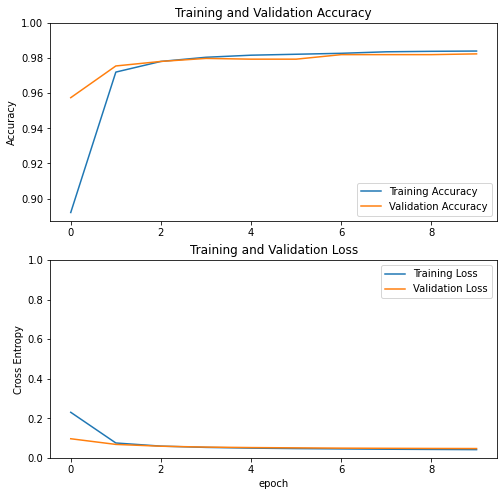

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower learning rate.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [32]:
len(model.trainable_variables)

58

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20


  1/582 [..............................] - ETA: 0s - loss: 0.3513 - accuracy: 0.8750

  2/582 [..............................] - ETA: 15s - loss: 0.6228 - accuracy: 0.8438

  3/582 [..............................] - ETA: 20s - loss: 0.4618 - accuracy: 0.8750

  4/582 [..............................] - ETA: 22s - loss: 0.5299 - accuracy: 0.8516

  5/582 [..............................] - ETA: 23s - loss: 0.4987 - accuracy: 0.8625

  6/582 [..............................] - ETA: 24s - loss: 0.4589 - accuracy: 0.8698

  7/582 [..............................] - ETA: 25s - loss: 0.4359 - accuracy: 0.8705

  8/582 [..............................] - ETA: 26s - loss: 0.5061 - accuracy: 0.8438

  9/582 [..............................] - ETA: 26s - loss: 0.4764 - accuracy: 0.8507

 10/582 [..............................] - ETA: 26s - loss: 0.4602 - accuracy: 0.8562

 12/582 [..............................] - ETA: 26s - loss: 0.4134 - accuracy: 0.8698

 13/582 [..............................] - ETA: 26s - loss: 0.4041 - accuracy: 0.8726

 15/582 [..............................] - ETA: 26s - loss: 0.3680 - accuracy: 0.8854

 17/582 [..............................] - ETA: 26s - loss: 0.3782 - accuracy: 0.8824

 19/582 [..............................] - ETA: 26s - loss: 0.3811 - accuracy: 0.8816

 21/582 [>.............................] - ETA: 26s - loss: 0.3665 - accuracy: 0.8839

 23/582 [>.............................] - ETA: 26s - loss: 0.3567 - accuracy: 0.8845

 24/582 [>.............................] - ETA: 26s - loss: 0.3640 - accuracy: 0.8802

 25/582 [>.............................] - ETA: 26s - loss: 0.3562 - accuracy: 0.8825

 27/582 [>.............................] - ETA: 26s - loss: 0.3545 - accuracy: 0.8854

 28/582 [>.............................] - ETA: 26s - loss: 0.3522 - accuracy: 0.8839

 30/582 [>.............................] - ETA: 26s - loss: 0.3553 - accuracy: 0.8823

 31/582 [>.............................] - ETA: 26s - loss: 0.3649 - accuracy: 0.8770

 32/582 [>.............................] - ETA: 26s - loss: 0.3560 - accuracy: 0.8809

 33/582 [>.............................] - ETA: 26s - loss: 0.3519 - accuracy: 0.8835

 34/582 [>.............................] - ETA: 26s - loss: 0.3473 - accuracy: 0.8860

 36/582 [>.............................] - ETA: 26s - loss: 0.3413 - accuracy: 0.8889

 37/582 [>.............................] - ETA: 26s - loss: 0.3441 - accuracy: 0.8885

 38/582 [>.............................] - ETA: 26s - loss: 0.3406 - accuracy: 0.8898

 40/582 [=>............................] - ETA: 26s - loss: 0.3447 - accuracy: 0.8852

 42/582 [=>............................] - ETA: 26s - loss: 0.3365 - accuracy: 0.8884

 43/582 [=>............................] - ETA: 26s - loss: 0.3322 - accuracy: 0.8903

 45/582 [=>............................] - ETA: 26s - loss: 0.3368 - accuracy: 0.8889

 47/582 [=>............................] - ETA: 26s - loss: 0.3347 - accuracy: 0.8896

 49/582 [=>............................] - ETA: 26s - loss: 0.3260 - accuracy: 0.8929

 50/582 [=>............................] - ETA: 26s - loss: 0.3293 - accuracy: 0.8919

 51/582 [=>............................] - ETA: 26s - loss: 0.3277 - accuracy: 0.8922

 52/582 [=>............................] - ETA: 26s - loss: 0.3269 - accuracy: 0.8924

 53/582 [=>............................] - ETA: 26s - loss: 0.3219 - accuracy: 0.8945

 55/582 [=>............................] - ETA: 25s - loss: 0.3150 - accuracy: 0.8966

 56/582 [=>............................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8979

 57/582 [=>............................] - ETA: 25s - loss: 0.3063 - accuracy: 0.8991

 58/582 [=>............................] - ETA: 25s - loss: 0.3033 - accuracy: 0.8998

 59/582 [==>...........................] - ETA: 25s - loss: 0.3009 - accuracy: 0.9010

 60/582 [==>...........................] - ETA: 25s - loss: 0.2995 - accuracy: 0.9016

 61/582 [==>...........................] - ETA: 25s - loss: 0.2975 - accuracy: 0.9027

 62/582 [==>...........................] - ETA: 25s - loss: 0.2976 - accuracy: 0.9022

 64/582 [==>...........................] - ETA: 25s - loss: 0.2936 - accuracy: 0.9033

 65/582 [==>...........................] - ETA: 25s - loss: 0.2906 - accuracy: 0.9043

 66/582 [==>...........................] - ETA: 25s - loss: 0.2878 - accuracy: 0.9048

 68/582 [==>...........................] - ETA: 25s - loss: 0.2842 - accuracy: 0.9058

 70/582 [==>...........................] - ETA: 25s - loss: 0.2785 - accuracy: 0.9080

 72/582 [==>...........................] - ETA: 25s - loss: 0.2738 - accuracy: 0.9093

 73/582 [==>...........................] - ETA: 25s - loss: 0.2709 - accuracy: 0.9105

 75/582 [==>...........................] - ETA: 25s - loss: 0.2662 - accuracy: 0.9112

 76/582 [==>...........................] - ETA: 25s - loss: 0.2645 - accuracy: 0.9116

 77/582 [==>...........................] - ETA: 25s - loss: 0.2661 - accuracy: 0.9107

 78/582 [===>..........................] - ETA: 25s - loss: 0.2644 - accuracy: 0.9111

 79/582 [===>..........................] - ETA: 25s - loss: 0.2618 - accuracy: 0.9118

 80/582 [===>..........................] - ETA: 24s - loss: 0.2615 - accuracy: 0.9117

 81/582 [===>..........................] - ETA: 24s - loss: 0.2590 - accuracy: 0.9124

 82/582 [===>..........................] - ETA: 24s - loss: 0.2568 - accuracy: 0.9131

 84/582 [===>..........................] - ETA: 24s - loss: 0.2558 - accuracy: 0.9133

 85/582 [===>..........................] - ETA: 24s - loss: 0.2564 - accuracy: 0.9129

 86/582 [===>..........................] - ETA: 24s - loss: 0.2559 - accuracy: 0.9128

 88/582 [===>..........................] - ETA: 24s - loss: 0.2563 - accuracy: 0.9126

 89/582 [===>..........................] - ETA: 24s - loss: 0.2550 - accuracy: 0.9133

 91/582 [===>..........................] - ETA: 24s - loss: 0.2550 - accuracy: 0.9128

 93/582 [===>..........................] - ETA: 24s - loss: 0.2515 - accuracy: 0.9140

 95/582 [===>..........................] - ETA: 24s - loss: 0.2479 - accuracy: 0.9151

 97/582 [====>.........................] - ETA: 24s - loss: 0.2449 - accuracy: 0.9159

 98/582 [====>.........................] - ETA: 24s - loss: 0.2448 - accuracy: 0.9158

 99/582 [====>.........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.9151

100/582 [====>.........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.9156

101/582 [====>.........................] - ETA: 23s - loss: 0.2422 - accuracy: 0.9162

103/582 [====>.........................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9169

104/582 [====>.........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9171

106/582 [====>.........................] - ETA: 23s - loss: 0.2356 - accuracy: 0.9183

107/582 [====>.........................] - ETA: 23s - loss: 0.2339 - accuracy: 0.9188

108/582 [====>.........................] - ETA: 23s - loss: 0.2327 - accuracy: 0.9193

110/582 [====>.........................] - ETA: 23s - loss: 0.2347 - accuracy: 0.9185

111/582 [====>.........................] - ETA: 23s - loss: 0.2340 - accuracy: 0.9186

112/582 [====>.........................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9194

113/582 [====>.........................] - ETA: 23s - loss: 0.2307 - accuracy: 0.9201

114/582 [====>.........................] - ETA: 23s - loss: 0.2297 - accuracy: 0.9202

115/582 [====>.........................] - ETA: 23s - loss: 0.2285 - accuracy: 0.9207

116/582 [====>.........................] - ETA: 23s - loss: 0.2270 - accuracy: 0.9213

117/582 [=====>........................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9215

119/582 [=====>........................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9212

121/582 [=====>........................] - ETA: 23s - loss: 0.2280 - accuracy: 0.9210

122/582 [=====>........................] - ETA: 22s - loss: 0.2290 - accuracy: 0.9203

124/582 [=====>........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9201

125/582 [=====>........................] - ETA: 22s - loss: 0.2257 - accuracy: 0.9208

126/582 [=====>........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9214

127/582 [=====>........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9215

128/582 [=====>........................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9216

130/582 [=====>........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9226

131/582 [=====>........................] - ETA: 22s - loss: 0.2202 - accuracy: 0.9232

133/582 [=====>........................] - ETA: 22s - loss: 0.2191 - accuracy: 0.9232

134/582 [=====>........................] - ETA: 22s - loss: 0.2187 - accuracy: 0.9228

136/582 [======>.......................] - ETA: 22s - loss: 0.2163 - accuracy: 0.9239

137/582 [======>.......................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9236

139/582 [======>.......................] - ETA: 22s - loss: 0.2137 - accuracy: 0.9245

141/582 [======>.......................] - ETA: 22s - loss: 0.2130 - accuracy: 0.9242

143/582 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9250

144/582 [======>.......................] - ETA: 21s - loss: 0.2103 - accuracy: 0.9251

145/582 [======>.......................] - ETA: 21s - loss: 0.2102 - accuracy: 0.9252

146/582 [======>.......................] - ETA: 21s - loss: 0.2094 - accuracy: 0.9253

148/582 [======>.......................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9255

150/582 [======>.......................] - ETA: 21s - loss: 0.2060 - accuracy: 0.9262

152/582 [======>.......................] - ETA: 21s - loss: 0.2057 - accuracy: 0.9262

153/582 [======>.......................] - ETA: 21s - loss: 0.2051 - accuracy: 0.9265

154/582 [======>.......................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9269

155/582 [======>.......................] - ETA: 21s - loss: 0.2035 - accuracy: 0.9270

156/582 [=======>......................] - ETA: 21s - loss: 0.2029 - accuracy: 0.9273

157/582 [=======>......................] - ETA: 21s - loss: 0.2021 - accuracy: 0.9275

159/582 [=======>......................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9283

160/582 [=======>......................] - ETA: 21s - loss: 0.2000 - accuracy: 0.9285

161/582 [=======>......................] - ETA: 21s - loss: 0.1991 - accuracy: 0.9290

162/582 [=======>......................] - ETA: 21s - loss: 0.1981 - accuracy: 0.9294

163/582 [=======>......................] - ETA: 20s - loss: 0.1977 - accuracy: 0.9294

164/582 [=======>......................] - ETA: 20s - loss: 0.1971 - accuracy: 0.9295

166/582 [=======>......................] - ETA: 20s - loss: 0.1956 - accuracy: 0.9302

167/582 [=======>......................] - ETA: 20s - loss: 0.1946 - accuracy: 0.9306

168/582 [=======>......................] - ETA: 20s - loss: 0.1956 - accuracy: 0.9304

169/582 [=======>......................] - ETA: 20s - loss: 0.1945 - accuracy: 0.9308

170/582 [=======>......................] - ETA: 20s - loss: 0.1943 - accuracy: 0.9307

172/582 [=======>......................] - ETA: 20s - loss: 0.1924 - accuracy: 0.9315

174/582 [=======>......................] - ETA: 20s - loss: 0.1918 - accuracy: 0.9318

176/582 [========>.....................] - ETA: 20s - loss: 0.1911 - accuracy: 0.9322

178/582 [========>.....................] - ETA: 20s - loss: 0.1905 - accuracy: 0.9328

180/582 [========>.....................] - ETA: 20s - loss: 0.1895 - accuracy: 0.9328

182/582 [========>.....................] - ETA: 19s - loss: 0.1899 - accuracy: 0.9325

184/582 [========>.....................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9329

186/582 [========>.....................] - ETA: 19s - loss: 0.1890 - accuracy: 0.9331

187/582 [========>.....................] - ETA: 19s - loss: 0.1882 - accuracy: 0.9335

189/582 [========>.....................] - ETA: 19s - loss: 0.1869 - accuracy: 0.9339

191/582 [========>.....................] - ETA: 19s - loss: 0.1856 - accuracy: 0.9344

193/582 [========>.....................] - ETA: 19s - loss: 0.1840 - accuracy: 0.9349

194/582 [=========>....................] - ETA: 19s - loss: 0.1836 - accuracy: 0.9349

195/582 [=========>....................] - ETA: 19s - loss: 0.1828 - accuracy: 0.9351

196/582 [=========>....................] - ETA: 19s - loss: 0.1821 - accuracy: 0.9354

198/582 [=========>....................] - ETA: 19s - loss: 0.1817 - accuracy: 0.9353

199/582 [=========>....................] - ETA: 19s - loss: 0.1811 - accuracy: 0.9356

200/582 [=========>....................] - ETA: 19s - loss: 0.1809 - accuracy: 0.9356

202/582 [=========>....................] - ETA: 18s - loss: 0.1797 - accuracy: 0.9363

203/582 [=========>....................] - ETA: 18s - loss: 0.1793 - accuracy: 0.9363

205/582 [=========>....................] - ETA: 18s - loss: 0.1784 - accuracy: 0.9367

206/582 [=========>....................] - ETA: 18s - loss: 0.1791 - accuracy: 0.9369

208/582 [=========>....................] - ETA: 18s - loss: 0.1776 - accuracy: 0.9375

210/582 [=========>....................] - ETA: 18s - loss: 0.1775 - accuracy: 0.9375

212/582 [=========>....................] - ETA: 18s - loss: 0.1768 - accuracy: 0.9376

214/582 [==========>...................] - ETA: 18s - loss: 0.1759 - accuracy: 0.9378

215/582 [==========>...................] - ETA: 18s - loss: 0.1752 - accuracy: 0.9381

216/582 [==========>...................] - ETA: 18s - loss: 0.1746 - accuracy: 0.9384

217/582 [==========>...................] - ETA: 18s - loss: 0.1739 - accuracy: 0.9385

218/582 [==========>...................] - ETA: 18s - loss: 0.1736 - accuracy: 0.9386

220/582 [==========>...................] - ETA: 18s - loss: 0.1726 - accuracy: 0.9391

221/582 [==========>...................] - ETA: 18s - loss: 0.1728 - accuracy: 0.9391

222/582 [==========>...................] - ETA: 18s - loss: 0.1723 - accuracy: 0.9393

223/582 [==========>...................] - ETA: 17s - loss: 0.1722 - accuracy: 0.9393

225/582 [==========>...................] - ETA: 17s - loss: 0.1716 - accuracy: 0.9393

227/582 [==========>...................] - ETA: 17s - loss: 0.1705 - accuracy: 0.9397

228/582 [==========>...................] - ETA: 17s - loss: 0.1704 - accuracy: 0.9396

230/582 [==========>...................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9398

232/582 [==========>...................] - ETA: 17s - loss: 0.1695 - accuracy: 0.9398

234/582 [===========>..................] - ETA: 17s - loss: 0.1689 - accuracy: 0.9399

236/582 [===========>..................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9400

238/582 [===========>..................] - ETA: 17s - loss: 0.1676 - accuracy: 0.9405

239/582 [===========>..................] - ETA: 17s - loss: 0.1670 - accuracy: 0.9406

240/582 [===========>..................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9406

241/582 [===========>..................] - ETA: 17s - loss: 0.1663 - accuracy: 0.9409

243/582 [===========>..................] - ETA: 16s - loss: 0.1664 - accuracy: 0.9406

245/582 [===========>..................] - ETA: 16s - loss: 0.1657 - accuracy: 0.9406

246/582 [===========>..................] - ETA: 16s - loss: 0.1657 - accuracy: 0.9404

247/582 [===========>..................] - ETA: 16s - loss: 0.1653 - accuracy: 0.9405

248/582 [===========>..................] - ETA: 16s - loss: 0.1653 - accuracy: 0.9405

249/582 [===========>..................] - ETA: 16s - loss: 0.1648 - accuracy: 0.9406

251/582 [===========>..................] - ETA: 16s - loss: 0.1641 - accuracy: 0.9407

252/582 [===========>..................] - ETA: 16s - loss: 0.1640 - accuracy: 0.9407

253/582 [============>.................] - ETA: 16s - loss: 0.1645 - accuracy: 0.9406

254/582 [============>.................] - ETA: 16s - loss: 0.1643 - accuracy: 0.9406

255/582 [============>.................] - ETA: 16s - loss: 0.1638 - accuracy: 0.9408

257/582 [============>.................] - ETA: 16s - loss: 0.1630 - accuracy: 0.9409

259/582 [============>.................] - ETA: 16s - loss: 0.1623 - accuracy: 0.9410

260/582 [============>.................] - ETA: 16s - loss: 0.1624 - accuracy: 0.9410

262/582 [============>.................] - ETA: 16s - loss: 0.1625 - accuracy: 0.9407

263/582 [============>.................] - ETA: 15s - loss: 0.1633 - accuracy: 0.9402

265/582 [============>.................] - ETA: 15s - loss: 0.1626 - accuracy: 0.9404

266/582 [============>.................] - ETA: 15s - loss: 0.1623 - accuracy: 0.9406

268/582 [============>.................] - ETA: 15s - loss: 0.1618 - accuracy: 0.9405

269/582 [============>.................] - ETA: 15s - loss: 0.1615 - accuracy: 0.9405

271/582 [============>.................] - ETA: 15s - loss: 0.1607 - accuracy: 0.9410

273/582 [=============>................] - ETA: 15s - loss: 0.1601 - accuracy: 0.9410

274/582 [=============>................] - ETA: 15s - loss: 0.1598 - accuracy: 0.9411

275/582 [=============>................] - ETA: 15s - loss: 0.1594 - accuracy: 0.9413

276/582 [=============>................] - ETA: 15s - loss: 0.1592 - accuracy: 0.9413

277/582 [=============>................] - ETA: 15s - loss: 0.1587 - accuracy: 0.9416

278/582 [=============>................] - ETA: 15s - loss: 0.1582 - accuracy: 0.9418

279/582 [=============>................] - ETA: 15s - loss: 0.1581 - accuracy: 0.9418

280/582 [=============>................] - ETA: 15s - loss: 0.1579 - accuracy: 0.9419

281/582 [=============>................] - ETA: 15s - loss: 0.1575 - accuracy: 0.9421

283/582 [=============>................] - ETA: 14s - loss: 0.1571 - accuracy: 0.9422

284/582 [=============>................] - ETA: 14s - loss: 0.1569 - accuracy: 0.9422

286/582 [=============>................] - ETA: 14s - loss: 0.1570 - accuracy: 0.9422

288/582 [=============>................] - ETA: 14s - loss: 0.1565 - accuracy: 0.9423

290/582 [=============>................] - ETA: 14s - loss: 0.1559 - accuracy: 0.9427

291/582 [==============>...............] - ETA: 14s - loss: 0.1554 - accuracy: 0.9429

293/582 [==============>...............] - ETA: 14s - loss: 0.1546 - accuracy: 0.9433

294/582 [==============>...............] - ETA: 14s - loss: 0.1542 - accuracy: 0.9433

295/582 [==============>...............] - ETA: 14s - loss: 0.1538 - accuracy: 0.9434

296/582 [==============>...............] - ETA: 14s - loss: 0.1538 - accuracy: 0.9434

297/582 [==============>...............] - ETA: 14s - loss: 0.1533 - accuracy: 0.9436

299/582 [==============>...............] - ETA: 14s - loss: 0.1525 - accuracy: 0.9440

300/582 [==============>...............] - ETA: 14s - loss: 0.1524 - accuracy: 0.9440

301/582 [==============>...............] - ETA: 14s - loss: 0.1521 - accuracy: 0.9440

302/582 [==============>...............] - ETA: 14s - loss: 0.1520 - accuracy: 0.9441

304/582 [==============>...............] - ETA: 13s - loss: 0.1518 - accuracy: 0.9441

306/582 [==============>...............] - ETA: 13s - loss: 0.1512 - accuracy: 0.9442

308/582 [==============>...............] - ETA: 13s - loss: 0.1511 - accuracy: 0.9445

309/582 [==============>...............] - ETA: 13s - loss: 0.1509 - accuracy: 0.9445

310/582 [==============>...............] - ETA: 13s - loss: 0.1507 - accuracy: 0.9444

312/582 [===============>..............] - ETA: 13s - loss: 0.1499 - accuracy: 0.9445

314/582 [===============>..............] - ETA: 13s - loss: 0.1493 - accuracy: 0.9449

316/582 [===============>..............] - ETA: 13s - loss: 0.1492 - accuracy: 0.9447

317/582 [===============>..............] - ETA: 13s - loss: 0.1493 - accuracy: 0.9447

319/582 [===============>..............] - ETA: 13s - loss: 0.1486 - accuracy: 0.9449

321/582 [===============>..............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9449

322/582 [===============>..............] - ETA: 12s - loss: 0.1480 - accuracy: 0.9450

324/582 [===============>..............] - ETA: 12s - loss: 0.1475 - accuracy: 0.9450

325/582 [===============>..............] - ETA: 12s - loss: 0.1472 - accuracy: 0.9451

326/582 [===============>..............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9452

327/582 [===============>..............] - ETA: 12s - loss: 0.1474 - accuracy: 0.9451

329/582 [===============>..............] - ETA: 12s - loss: 0.1466 - accuracy: 0.9454

331/582 [================>.............] - ETA: 12s - loss: 0.1464 - accuracy: 0.9453

332/582 [================>.............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9451

334/582 [================>.............] - ETA: 12s - loss: 0.1467 - accuracy: 0.9453

335/582 [================>.............] - ETA: 12s - loss: 0.1464 - accuracy: 0.9453

336/582 [================>.............] - ETA: 12s - loss: 0.1461 - accuracy: 0.9455

337/582 [================>.............] - ETA: 12s - loss: 0.1462 - accuracy: 0.9454

339/582 [================>.............] - ETA: 12s - loss: 0.1461 - accuracy: 0.9452

341/582 [================>.............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9455

343/582 [================>.............] - ETA: 11s - loss: 0.1455 - accuracy: 0.9454

345/582 [================>.............] - ETA: 11s - loss: 0.1450 - accuracy: 0.9457

346/582 [================>.............] - ETA: 11s - loss: 0.1448 - accuracy: 0.9458

347/582 [================>.............] - ETA: 11s - loss: 0.1447 - accuracy: 0.9459

348/582 [================>.............] - ETA: 11s - loss: 0.1443 - accuracy: 0.9460

349/582 [================>.............] - ETA: 11s - loss: 0.1444 - accuracy: 0.9460

350/582 [=================>............] - ETA: 11s - loss: 0.1440 - accuracy: 0.9462

352/582 [=================>............] - ETA: 11s - loss: 0.1434 - accuracy: 0.9464

354/582 [=================>............] - ETA: 11s - loss: 0.1427 - accuracy: 0.9466

356/582 [=================>............] - ETA: 11s - loss: 0.1424 - accuracy: 0.9468

358/582 [=================>............] - ETA: 11s - loss: 0.1426 - accuracy: 0.9468

359/582 [=================>............] - ETA: 11s - loss: 0.1426 - accuracy: 0.9467

360/582 [=================>............] - ETA: 11s - loss: 0.1427 - accuracy: 0.9466

361/582 [=================>............] - ETA: 11s - loss: 0.1424 - accuracy: 0.9468

362/582 [=================>............] - ETA: 11s - loss: 0.1422 - accuracy: 0.9468

363/582 [=================>............] - ETA: 10s - loss: 0.1422 - accuracy: 0.9468

364/582 [=================>............] - ETA: 10s - loss: 0.1419 - accuracy: 0.9469

366/582 [=================>............] - ETA: 10s - loss: 0.1424 - accuracy: 0.9467

368/582 [=================>............] - ETA: 10s - loss: 0.1421 - accuracy: 0.9468

369/582 [==================>...........] - ETA: 10s - loss: 0.1420 - accuracy: 0.9468

370/582 [==================>...........] - ETA: 10s - loss: 0.1417 - accuracy: 0.9470

371/582 [==================>...........] - ETA: 10s - loss: 0.1415 - accuracy: 0.9469

372/582 [==================>...........] - ETA: 10s - loss: 0.1412 - accuracy: 0.9471

374/582 [==================>...........] - ETA: 10s - loss: 0.1413 - accuracy: 0.9470

375/582 [==================>...........] - ETA: 10s - loss: 0.1412 - accuracy: 0.9471

377/582 [==================>...........] - ETA: 10s - loss: 0.1408 - accuracy: 0.9472

378/582 [==================>...........] - ETA: 10s - loss: 0.1406 - accuracy: 0.9473

380/582 [==================>...........] - ETA: 10s - loss: 0.1402 - accuracy: 0.9472

381/582 [==================>...........] - ETA: 10s - loss: 0.1400 - accuracy: 0.9473

382/582 [==================>...........] - ETA: 10s - loss: 0.1401 - accuracy: 0.9473

384/582 [==================>...........] - ETA: 9s - loss: 0.1396 - accuracy: 0.9475 

385/582 [==================>...........] - ETA: 9s - loss: 0.1395 - accuracy: 0.9475

386/582 [==================>...........] - ETA: 9s - loss: 0.1392 - accuracy: 0.9475

387/582 [==================>...........] - ETA: 9s - loss: 0.1390 - accuracy: 0.9477

388/582 [===================>..........] - ETA: 9s - loss: 0.1391 - accuracy: 0.9476

389/582 [===================>..........] - ETA: 9s - loss: 0.1389 - accuracy: 0.9476

390/582 [===================>..........] - ETA: 9s - loss: 0.1386 - accuracy: 0.9478

392/582 [===================>..........] - ETA: 9s - loss: 0.1390 - accuracy: 0.9475

393/582 [===================>..........] - ETA: 9s - loss: 0.1386 - accuracy: 0.9476

394/582 [===================>..........] - ETA: 9s - loss: 0.1384 - accuracy: 0.9477

396/582 [===================>..........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9479

397/582 [===================>..........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9479

398/582 [===================>..........] - ETA: 9s - loss: 0.1377 - accuracy: 0.9480

399/582 [===================>..........] - ETA: 9s - loss: 0.1374 - accuracy: 0.9481

400/582 [===================>..........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9480

402/582 [===================>..........] - ETA: 9s - loss: 0.1370 - accuracy: 0.9482

403/582 [===================>..........] - ETA: 8s - loss: 0.1371 - accuracy: 0.9482

404/582 [===================>..........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9483

405/582 [===================>..........] - ETA: 8s - loss: 0.1366 - accuracy: 0.9483

407/582 [===================>..........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9484

408/582 [====================>.........] - ETA: 8s - loss: 0.1361 - accuracy: 0.9484

410/582 [====================>.........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9484

411/582 [====================>.........] - ETA: 8s - loss: 0.1361 - accuracy: 0.9484

412/582 [====================>.........] - ETA: 8s - loss: 0.1359 - accuracy: 0.9485

413/582 [====================>.........] - ETA: 8s - loss: 0.1363 - accuracy: 0.9484

414/582 [====================>.........] - ETA: 8s - loss: 0.1360 - accuracy: 0.9485

415/582 [====================>.........] - ETA: 8s - loss: 0.1358 - accuracy: 0.9486

417/582 [====================>.........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9487

418/582 [====================>.........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9487

419/582 [====================>.........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9487

421/582 [====================>.........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9487

422/582 [====================>.........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9485

424/582 [====================>.........] - ETA: 7s - loss: 0.1356 - accuracy: 0.9484

425/582 [====================>.........] - ETA: 7s - loss: 0.1353 - accuracy: 0.9485

427/582 [=====================>........] - ETA: 7s - loss: 0.1360 - accuracy: 0.9484

428/582 [=====================>........] - ETA: 7s - loss: 0.1359 - accuracy: 0.9484

429/582 [=====================>........] - ETA: 7s - loss: 0.1358 - accuracy: 0.9482

431/582 [=====================>........] - ETA: 7s - loss: 0.1352 - accuracy: 0.9484

432/582 [=====================>........] - ETA: 7s - loss: 0.1351 - accuracy: 0.9486

434/582 [=====================>........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9488

435/582 [=====================>........] - ETA: 7s - loss: 0.1344 - accuracy: 0.9488

437/582 [=====================>........] - ETA: 7s - loss: 0.1345 - accuracy: 0.9487

438/582 [=====================>........] - ETA: 7s - loss: 0.1344 - accuracy: 0.9486

439/582 [=====================>........] - ETA: 7s - loss: 0.1341 - accuracy: 0.9487

441/582 [=====================>........] - ETA: 7s - loss: 0.1335 - accuracy: 0.9490

443/582 [=====================>........] - ETA: 6s - loss: 0.1334 - accuracy: 0.9490

444/582 [=====================>........] - ETA: 6s - loss: 0.1331 - accuracy: 0.9491

446/582 [=====================>........] - ETA: 6s - loss: 0.1331 - accuracy: 0.9492

447/582 [======================>.......] - ETA: 6s - loss: 0.1329 - accuracy: 0.9492

448/582 [======================>.......] - ETA: 6s - loss: 0.1327 - accuracy: 0.9493

450/582 [======================>.......] - ETA: 6s - loss: 0.1322 - accuracy: 0.9494

451/582 [======================>.......] - ETA: 6s - loss: 0.1319 - accuracy: 0.9496

452/582 [======================>.......] - ETA: 6s - loss: 0.1317 - accuracy: 0.9497

453/582 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9498

454/582 [======================>.......] - ETA: 6s - loss: 0.1312 - accuracy: 0.9499

455/582 [======================>.......] - ETA: 6s - loss: 0.1311 - accuracy: 0.9499

456/582 [======================>.......] - ETA: 6s - loss: 0.1309 - accuracy: 0.9500

457/582 [======================>.......] - ETA: 6s - loss: 0.1307 - accuracy: 0.9501

458/582 [======================>.......] - ETA: 6s - loss: 0.1305 - accuracy: 0.9502

459/582 [======================>.......] - ETA: 6s - loss: 0.1302 - accuracy: 0.9503

460/582 [======================>.......] - ETA: 6s - loss: 0.1301 - accuracy: 0.9504

461/582 [======================>.......] - ETA: 6s - loss: 0.1303 - accuracy: 0.9503

462/582 [======================>.......] - ETA: 6s - loss: 0.1300 - accuracy: 0.9504

463/582 [======================>.......] - ETA: 5s - loss: 0.1300 - accuracy: 0.9505

464/582 [======================>.......] - ETA: 5s - loss: 0.1297 - accuracy: 0.9506

465/582 [======================>.......] - ETA: 5s - loss: 0.1296 - accuracy: 0.9507

467/582 [=======================>......] - ETA: 5s - loss: 0.1297 - accuracy: 0.9507

468/582 [=======================>......] - ETA: 5s - loss: 0.1296 - accuracy: 0.9507

469/582 [=======================>......] - ETA: 5s - loss: 0.1295 - accuracy: 0.9508

470/582 [=======================>......] - ETA: 5s - loss: 0.1295 - accuracy: 0.9508

471/582 [=======================>......] - ETA: 5s - loss: 0.1292 - accuracy: 0.9509

472/582 [=======================>......] - ETA: 5s - loss: 0.1291 - accuracy: 0.9509

473/582 [=======================>......] - ETA: 5s - loss: 0.1291 - accuracy: 0.9510

474/582 [=======================>......] - ETA: 5s - loss: 0.1292 - accuracy: 0.9510

475/582 [=======================>......] - ETA: 5s - loss: 0.1296 - accuracy: 0.9507

477/582 [=======================>......] - ETA: 5s - loss: 0.1291 - accuracy: 0.9509

478/582 [=======================>......] - ETA: 5s - loss: 0.1290 - accuracy: 0.9510

480/582 [=======================>......] - ETA: 5s - loss: 0.1287 - accuracy: 0.9510

481/582 [=======================>......] - ETA: 5s - loss: 0.1288 - accuracy: 0.9510

482/582 [=======================>......] - ETA: 5s - loss: 0.1288 - accuracy: 0.9509

484/582 [=======================>......] - ETA: 4s - loss: 0.1286 - accuracy: 0.9510

486/582 [========================>.....] - ETA: 4s - loss: 0.1286 - accuracy: 0.9510

487/582 [========================>.....] - ETA: 4s - loss: 0.1285 - accuracy: 0.9510

489/582 [========================>.....] - ETA: 4s - loss: 0.1289 - accuracy: 0.9510

490/582 [========================>.....] - ETA: 4s - loss: 0.1286 - accuracy: 0.9510

492/582 [========================>.....] - ETA: 4s - loss: 0.1283 - accuracy: 0.9510

493/582 [========================>.....] - ETA: 4s - loss: 0.1283 - accuracy: 0.9511

494/582 [========================>.....] - ETA: 4s - loss: 0.1282 - accuracy: 0.9510

496/582 [========================>.....] - ETA: 4s - loss: 0.1279 - accuracy: 0.9512

498/582 [========================>.....] - ETA: 4s - loss: 0.1275 - accuracy: 0.9512

499/582 [========================>.....] - ETA: 4s - loss: 0.1274 - accuracy: 0.9513

500/582 [========================>.....] - ETA: 4s - loss: 0.1272 - accuracy: 0.9514

501/582 [========================>.....] - ETA: 4s - loss: 0.1272 - accuracy: 0.9514

503/582 [========================>.....] - ETA: 3s - loss: 0.1268 - accuracy: 0.9516

505/582 [=========================>....] - ETA: 3s - loss: 0.1264 - accuracy: 0.9517

506/582 [=========================>....] - ETA: 3s - loss: 0.1263 - accuracy: 0.9518

508/582 [=========================>....] - ETA: 3s - loss: 0.1261 - accuracy: 0.9518

510/582 [=========================>....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9519

511/582 [=========================>....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9519

512/582 [=========================>....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9520

514/582 [=========================>....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9518

515/582 [=========================>....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9519

516/582 [=========================>....] - ETA: 3s - loss: 0.1254 - accuracy: 0.9520

517/582 [=========================>....] - ETA: 3s - loss: 0.1252 - accuracy: 0.9521

518/582 [=========================>....] - ETA: 3s - loss: 0.1250 - accuracy: 0.9522

519/582 [=========================>....] - ETA: 3s - loss: 0.1249 - accuracy: 0.9523

521/582 [=========================>....] - ETA: 3s - loss: 0.1245 - accuracy: 0.9524

522/582 [=========================>....] - ETA: 3s - loss: 0.1246 - accuracy: 0.9523

523/582 [=========================>....] - ETA: 2s - loss: 0.1244 - accuracy: 0.9524

524/582 [==========================>...] - ETA: 2s - loss: 0.1245 - accuracy: 0.9523

525/582 [==========================>...] - ETA: 2s - loss: 0.1245 - accuracy: 0.9523

526/582 [==========================>...] - ETA: 2s - loss: 0.1244 - accuracy: 0.9524

527/582 [==========================>...] - ETA: 2s - loss: 0.1242 - accuracy: 0.9524

529/582 [==========================>...] - ETA: 2s - loss: 0.1238 - accuracy: 0.9526

531/582 [==========================>...] - ETA: 2s - loss: 0.1235 - accuracy: 0.9527

533/582 [==========================>...] - ETA: 2s - loss: 0.1233 - accuracy: 0.9529

534/582 [==========================>...] - ETA: 2s - loss: 0.1231 - accuracy: 0.9529

535/582 [==========================>...] - ETA: 2s - loss: 0.1233 - accuracy: 0.9529

536/582 [==========================>...] - ETA: 2s - loss: 0.1231 - accuracy: 0.9530

537/582 [==========================>...] - ETA: 2s - loss: 0.1231 - accuracy: 0.9530

538/582 [==========================>...] - ETA: 2s - loss: 0.1230 - accuracy: 0.9530

539/582 [==========================>...] - ETA: 2s - loss: 0.1229 - accuracy: 0.9531

540/582 [==========================>...] - ETA: 2s - loss: 0.1227 - accuracy: 0.9531

542/582 [==========================>...] - ETA: 2s - loss: 0.1225 - accuracy: 0.9533

543/582 [==========================>...] - ETA: 1s - loss: 0.1223 - accuracy: 0.9534

545/582 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9534

547/582 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9533

548/582 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9534

549/582 [===========================>..] - ETA: 1s - loss: 0.1225 - accuracy: 0.9533

551/582 [===========================>..] - ETA: 1s - loss: 0.1225 - accuracy: 0.9532

554/582 [===========================>..] - ETA: 1s - loss: 0.1229 - accuracy: 0.9531

557/582 [===========================>..] - ETA: 1s - loss: 0.1225 - accuracy: 0.9532

560/582 [===========================>..] - ETA: 1s - loss: 0.1220 - accuracy: 0.9533

563/582 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9535

566/582 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9533

570/582 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9534

574/582 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9536

578/582 [============================>.] - ETA: 0s - loss: 0.1204 - accuracy: 0.9539

581/582 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9539

582/582 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9539

582/582 [==============================] - 32s 54ms/step - loss: 0.1201 - accuracy: 0.9539 - val_loss: 0.0799 - val_accuracy: 0.9789


Epoch 11/20


  1/582 [..............................] - ETA: 0s - loss: 0.0974 - accuracy: 0.9688

  2/582 [..............................] - ETA: 15s - loss: 0.0863 - accuracy: 0.9688

  3/582 [..............................] - ETA: 19s - loss: 0.0722 - accuracy: 0.9688

  5/582 [..............................] - ETA: 23s - loss: 0.0576 - accuracy: 0.9750

  6/582 [..............................] - ETA: 24s - loss: 0.0697 - accuracy: 0.9688

  7/582 [..............................] - ETA: 25s - loss: 0.0605 - accuracy: 0.9732

  9/582 [..............................] - ETA: 25s - loss: 0.0700 - accuracy: 0.9653

 10/582 [..............................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9594

 11/582 [..............................] - ETA: 26s - loss: 0.0796 - accuracy: 0.9574

 12/582 [..............................] - ETA: 26s - loss: 0.0802 - accuracy: 0.9557

 14/582 [..............................] - ETA: 26s - loss: 0.0711 - accuracy: 0.9621

 15/582 [..............................] - ETA: 26s - loss: 0.0823 - accuracy: 0.9604

 16/582 [..............................] - ETA: 26s - loss: 0.0807 - accuracy: 0.9609

 18/582 [..............................] - ETA: 26s - loss: 0.0726 - accuracy: 0.9653

 20/582 [>.............................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9656

 22/582 [>.............................] - ETA: 26s - loss: 0.0713 - accuracy: 0.9659

 23/582 [>.............................] - ETA: 26s - loss: 0.0736 - accuracy: 0.9660

 24/582 [>.............................] - ETA: 26s - loss: 0.0741 - accuracy: 0.9648

 26/582 [>.............................] - ETA: 26s - loss: 0.0738 - accuracy: 0.9651

 28/582 [>.............................] - ETA: 26s - loss: 0.0731 - accuracy: 0.9654

 30/582 [>.............................] - ETA: 26s - loss: 0.0761 - accuracy: 0.9646

 31/582 [>.............................] - ETA: 26s - loss: 0.0742 - accuracy: 0.9657

 32/582 [>.............................] - ETA: 26s - loss: 0.0814 - accuracy: 0.9648

 33/582 [>.............................] - ETA: 26s - loss: 0.0822 - accuracy: 0.9640

 35/582 [>.............................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9634

 36/582 [>.............................] - ETA: 26s - loss: 0.0827 - accuracy: 0.9627

 37/582 [>.............................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9637

 38/582 [>.............................] - ETA: 26s - loss: 0.0803 - accuracy: 0.9646

 39/582 [=>............................] - ETA: 26s - loss: 0.0788 - accuracy: 0.9655

 40/582 [=>............................] - ETA: 26s - loss: 0.0781 - accuracy: 0.9656

 42/582 [=>............................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9673

 43/582 [=>............................] - ETA: 26s - loss: 0.0743 - accuracy: 0.9680

 44/582 [=>............................] - ETA: 26s - loss: 0.0763 - accuracy: 0.9666

 46/582 [=>............................] - ETA: 26s - loss: 0.0759 - accuracy: 0.9681

 47/582 [=>............................] - ETA: 26s - loss: 0.0774 - accuracy: 0.9674

 49/582 [=>............................] - ETA: 26s - loss: 0.0755 - accuracy: 0.9681

 51/582 [=>............................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9663

 52/582 [=>............................] - ETA: 26s - loss: 0.0757 - accuracy: 0.9669

 54/582 [=>............................] - ETA: 26s - loss: 0.0744 - accuracy: 0.9676

 55/582 [=>............................] - ETA: 26s - loss: 0.0738 - accuracy: 0.9676

 56/582 [=>............................] - ETA: 26s - loss: 0.0749 - accuracy: 0.9671

 57/582 [=>............................] - ETA: 26s - loss: 0.0742 - accuracy: 0.9677

 58/582 [=>............................] - ETA: 25s - loss: 0.0741 - accuracy: 0.9671

 59/582 [==>...........................] - ETA: 25s - loss: 0.0745 - accuracy: 0.9661

 60/582 [==>...........................] - ETA: 25s - loss: 0.0735 - accuracy: 0.9667

 61/582 [==>...........................] - ETA: 25s - loss: 0.0736 - accuracy: 0.9672

 62/582 [==>...........................] - ETA: 25s - loss: 0.0738 - accuracy: 0.9672

 64/582 [==>...........................] - ETA: 25s - loss: 0.0744 - accuracy: 0.9663

 65/582 [==>...........................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9635

 66/582 [==>...........................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9640

 67/582 [==>...........................] - ETA: 25s - loss: 0.0811 - accuracy: 0.9646

 69/582 [==>...........................] - ETA: 25s - loss: 0.0796 - accuracy: 0.9651

 70/582 [==>...........................] - ETA: 25s - loss: 0.0788 - accuracy: 0.9652

 71/582 [==>...........................] - ETA: 25s - loss: 0.0780 - accuracy: 0.9657

 72/582 [==>...........................] - ETA: 25s - loss: 0.0780 - accuracy: 0.9657

 74/582 [==>...........................] - ETA: 25s - loss: 0.0769 - accuracy: 0.9662

 75/582 [==>...........................] - ETA: 25s - loss: 0.0815 - accuracy: 0.9646

 76/582 [==>...........................] - ETA: 25s - loss: 0.0818 - accuracy: 0.9638

 78/582 [===>..........................] - ETA: 25s - loss: 0.0807 - accuracy: 0.9639

 79/582 [===>..........................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9640

 80/582 [===>..........................] - ETA: 25s - loss: 0.0796 - accuracy: 0.9645

 81/582 [===>..........................] - ETA: 24s - loss: 0.0796 - accuracy: 0.9645

 82/582 [===>..........................] - ETA: 24s - loss: 0.0797 - accuracy: 0.9646

 84/582 [===>..........................] - ETA: 24s - loss: 0.0812 - accuracy: 0.9639

 85/582 [===>..........................] - ETA: 24s - loss: 0.0806 - accuracy: 0.9643

 86/582 [===>..........................] - ETA: 24s - loss: 0.0799 - accuracy: 0.9648

 87/582 [===>..........................] - ETA: 24s - loss: 0.0802 - accuracy: 0.9648

 89/582 [===>..........................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9645

 90/582 [===>..........................] - ETA: 24s - loss: 0.0810 - accuracy: 0.9649

 92/582 [===>..........................] - ETA: 24s - loss: 0.0795 - accuracy: 0.9657

 93/582 [===>..........................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9661

 94/582 [===>..........................] - ETA: 24s - loss: 0.0783 - accuracy: 0.9664

 95/582 [===>..........................] - ETA: 24s - loss: 0.0785 - accuracy: 0.9658

 97/582 [====>.........................] - ETA: 24s - loss: 0.0797 - accuracy: 0.9655

 98/582 [====>.........................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9659

 99/582 [====>.........................] - ETA: 24s - loss: 0.0784 - accuracy: 0.9662

100/582 [====>.........................] - ETA: 24s - loss: 0.0781 - accuracy: 0.9663

101/582 [====>.........................] - ETA: 24s - loss: 0.0793 - accuracy: 0.9663

102/582 [====>.........................] - ETA: 24s - loss: 0.0787 - accuracy: 0.9666

104/582 [====>.........................] - ETA: 23s - loss: 0.0785 - accuracy: 0.9669

105/582 [====>.........................] - ETA: 23s - loss: 0.0785 - accuracy: 0.9667

106/582 [====>.........................] - ETA: 23s - loss: 0.0779 - accuracy: 0.9670

108/582 [====>.........................] - ETA: 23s - loss: 0.0775 - accuracy: 0.9673

109/582 [====>.........................] - ETA: 23s - loss: 0.0770 - accuracy: 0.9676

110/582 [====>.........................] - ETA: 23s - loss: 0.0776 - accuracy: 0.9673

112/582 [====>.........................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9676

113/582 [====>.........................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9674

114/582 [====>.........................] - ETA: 23s - loss: 0.0771 - accuracy: 0.9674

115/582 [====>.........................] - ETA: 23s - loss: 0.0769 - accuracy: 0.9674

116/582 [====>.........................] - ETA: 23s - loss: 0.0764 - accuracy: 0.9677

117/582 [=====>........................] - ETA: 23s - loss: 0.0760 - accuracy: 0.9677

119/582 [=====>........................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9680

120/582 [=====>........................] - ETA: 23s - loss: 0.0757 - accuracy: 0.9677

122/582 [=====>........................] - ETA: 23s - loss: 0.0758 - accuracy: 0.9675

123/582 [=====>........................] - ETA: 23s - loss: 0.0757 - accuracy: 0.9675

125/582 [=====>........................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9678

126/582 [=====>........................] - ETA: 22s - loss: 0.0756 - accuracy: 0.9678

127/582 [=====>........................] - ETA: 22s - loss: 0.0750 - accuracy: 0.9680

128/582 [=====>........................] - ETA: 22s - loss: 0.0747 - accuracy: 0.9683

130/582 [=====>........................] - ETA: 22s - loss: 0.0746 - accuracy: 0.9680

131/582 [=====>........................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9680

133/582 [=====>........................] - ETA: 22s - loss: 0.0741 - accuracy: 0.9683

134/582 [=====>........................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9678

136/582 [======>.......................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9681

137/582 [======>.......................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9683

139/582 [======>.......................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9685

140/582 [======>.......................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9685

142/582 [======>.......................] - ETA: 22s - loss: 0.0741 - accuracy: 0.9681

144/582 [======>.......................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9679

145/582 [======>.......................] - ETA: 21s - loss: 0.0743 - accuracy: 0.9681

147/582 [======>.......................] - ETA: 21s - loss: 0.0746 - accuracy: 0.9677

148/582 [======>.......................] - ETA: 21s - loss: 0.0746 - accuracy: 0.9677

149/582 [======>.......................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9679

151/582 [======>.......................] - ETA: 21s - loss: 0.0741 - accuracy: 0.9677

153/582 [======>.......................] - ETA: 21s - loss: 0.0745 - accuracy: 0.9673

155/582 [======>.......................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9669

156/582 [=======>......................] - ETA: 21s - loss: 0.0751 - accuracy: 0.9667

158/582 [=======>......................] - ETA: 21s - loss: 0.0754 - accuracy: 0.9666

159/582 [=======>......................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9668

160/582 [=======>......................] - ETA: 21s - loss: 0.0748 - accuracy: 0.9670

162/582 [=======>......................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9668

164/582 [=======>......................] - ETA: 20s - loss: 0.0756 - accuracy: 0.9667

165/582 [=======>......................] - ETA: 20s - loss: 0.0766 - accuracy: 0.9663

167/582 [=======>......................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9667

168/582 [=======>......................] - ETA: 20s - loss: 0.0754 - accuracy: 0.9669

169/582 [=======>......................] - ETA: 20s - loss: 0.0750 - accuracy: 0.9671

170/582 [=======>......................] - ETA: 20s - loss: 0.0747 - accuracy: 0.9673

171/582 [=======>......................] - ETA: 20s - loss: 0.0752 - accuracy: 0.9669

173/582 [=======>......................] - ETA: 20s - loss: 0.0744 - accuracy: 0.9673

174/582 [=======>......................] - ETA: 20s - loss: 0.0744 - accuracy: 0.9673

176/582 [========>.....................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9675

178/582 [========>.....................] - ETA: 20s - loss: 0.0735 - accuracy: 0.9679

180/582 [========>.....................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9677

182/582 [========>.....................] - ETA: 20s - loss: 0.0745 - accuracy: 0.9675

184/582 [========>.....................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9677

185/582 [========>.....................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9677

186/582 [========>.....................] - ETA: 19s - loss: 0.0736 - accuracy: 0.9679

187/582 [========>.....................] - ETA: 19s - loss: 0.0735 - accuracy: 0.9681

189/582 [========>.....................] - ETA: 19s - loss: 0.0731 - accuracy: 0.9683

190/582 [========>.....................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9681

191/582 [========>.....................] - ETA: 19s - loss: 0.0743 - accuracy: 0.9681

193/582 [========>.....................] - ETA: 19s - loss: 0.0737 - accuracy: 0.9684

195/582 [=========>....................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9684

197/582 [=========>....................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9683

198/582 [=========>....................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9684

199/582 [=========>....................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9684

201/582 [=========>....................] - ETA: 19s - loss: 0.0753 - accuracy: 0.9686

202/582 [=========>....................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9688

203/582 [=========>....................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9686

204/582 [=========>....................] - ETA: 18s - loss: 0.0748 - accuracy: 0.9688

205/582 [=========>....................] - ETA: 18s - loss: 0.0748 - accuracy: 0.9686

206/582 [=========>....................] - ETA: 18s - loss: 0.0753 - accuracy: 0.9684

207/582 [=========>....................] - ETA: 18s - loss: 0.0750 - accuracy: 0.9686

208/582 [=========>....................] - ETA: 18s - loss: 0.0750 - accuracy: 0.9686

210/582 [=========>....................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9689

211/582 [=========>....................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9690

212/582 [=========>....................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9689

214/582 [==========>...................] - ETA: 18s - loss: 0.0743 - accuracy: 0.9688

216/582 [==========>...................] - ETA: 18s - loss: 0.0739 - accuracy: 0.9690

217/582 [==========>...................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9692

218/582 [==========>...................] - ETA: 18s - loss: 0.0734 - accuracy: 0.9693

219/582 [==========>...................] - ETA: 18s - loss: 0.0733 - accuracy: 0.9695

220/582 [==========>...................] - ETA: 18s - loss: 0.0730 - accuracy: 0.9696

221/582 [==========>...................] - ETA: 18s - loss: 0.0731 - accuracy: 0.9695

222/582 [==========>...................] - ETA: 18s - loss: 0.0730 - accuracy: 0.9695

223/582 [==========>...................] - ETA: 18s - loss: 0.0727 - accuracy: 0.9696

224/582 [==========>...................] - ETA: 17s - loss: 0.0727 - accuracy: 0.9696

225/582 [==========>...................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9696

226/582 [==========>...................] - ETA: 17s - loss: 0.0726 - accuracy: 0.9697

227/582 [==========>...................] - ETA: 17s - loss: 0.0724 - accuracy: 0.9699

229/582 [==========>...................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9701

230/582 [==========>...................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9698

231/582 [==========>...................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9700

233/582 [===========>..................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9697

235/582 [===========>..................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9695

237/582 [===========>..................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9698

238/582 [===========>..................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9699

239/582 [===========>..................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9698

240/582 [===========>..................] - ETA: 17s - loss: 0.0713 - accuracy: 0.9699

241/582 [===========>..................] - ETA: 17s - loss: 0.0711 - accuracy: 0.9700

242/582 [===========>..................] - ETA: 17s - loss: 0.0710 - accuracy: 0.9700

243/582 [===========>..................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9702

244/582 [===========>..................] - ETA: 17s - loss: 0.0709 - accuracy: 0.9702

246/582 [===========>..................] - ETA: 16s - loss: 0.0706 - accuracy: 0.9703

247/582 [===========>..................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9703

248/582 [===========>..................] - ETA: 16s - loss: 0.0709 - accuracy: 0.9703

249/582 [===========>..................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9703

251/582 [===========>..................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9704

252/582 [===========>..................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9705

253/582 [============>.................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9705

255/582 [============>.................] - ETA: 16s - loss: 0.0711 - accuracy: 0.9705

256/582 [============>.................] - ETA: 16s - loss: 0.0708 - accuracy: 0.9706

257/582 [============>.................] - ETA: 16s - loss: 0.0708 - accuracy: 0.9706

258/582 [============>.................] - ETA: 16s - loss: 0.0706 - accuracy: 0.9707

259/582 [============>.................] - ETA: 16s - loss: 0.0709 - accuracy: 0.9706

260/582 [============>.................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9704

262/582 [============>.................] - ETA: 16s - loss: 0.0720 - accuracy: 0.9698

263/582 [============>.................] - ETA: 16s - loss: 0.0719 - accuracy: 0.9698

264/582 [============>.................] - ETA: 16s - loss: 0.0716 - accuracy: 0.9699

266/582 [============>.................] - ETA: 15s - loss: 0.0713 - accuracy: 0.9702

267/582 [============>.................] - ETA: 15s - loss: 0.0713 - accuracy: 0.9702

268/582 [============>.................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9703

269/582 [============>.................] - ETA: 15s - loss: 0.0717 - accuracy: 0.9698

271/582 [============>.................] - ETA: 15s - loss: 0.0722 - accuracy: 0.9696

273/582 [=============>................] - ETA: 15s - loss: 0.0719 - accuracy: 0.9697

274/582 [=============>................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9695

275/582 [=============>................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9694

276/582 [=============>................] - ETA: 15s - loss: 0.0724 - accuracy: 0.9694

277/582 [=============>................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9692

278/582 [=============>................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9691

280/582 [=============>................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9691

281/582 [=============>................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9691

283/582 [=============>................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9691

284/582 [=============>................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9690

286/582 [=============>................] - ETA: 14s - loss: 0.0725 - accuracy: 0.9692

287/582 [=============>................] - ETA: 14s - loss: 0.0726 - accuracy: 0.9692

289/582 [=============>................] - ETA: 14s - loss: 0.0731 - accuracy: 0.9691

290/582 [=============>................] - ETA: 14s - loss: 0.0730 - accuracy: 0.9692

291/582 [==============>...............] - ETA: 14s - loss: 0.0729 - accuracy: 0.9692

292/582 [==============>...............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9693

294/582 [==============>...............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9693

295/582 [==============>...............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9694

296/582 [==============>...............] - ETA: 14s - loss: 0.0727 - accuracy: 0.9694

297/582 [==============>...............] - ETA: 14s - loss: 0.0727 - accuracy: 0.9694

298/582 [==============>...............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9694

300/582 [==============>...............] - ETA: 14s - loss: 0.0724 - accuracy: 0.9695

301/582 [==============>...............] - ETA: 14s - loss: 0.0723 - accuracy: 0.9694

302/582 [==============>...............] - ETA: 14s - loss: 0.0722 - accuracy: 0.9695

303/582 [==============>...............] - ETA: 14s - loss: 0.0721 - accuracy: 0.9696

304/582 [==============>...............] - ETA: 14s - loss: 0.0720 - accuracy: 0.9697

306/582 [==============>...............] - ETA: 13s - loss: 0.0720 - accuracy: 0.9698

308/582 [==============>...............] - ETA: 13s - loss: 0.0718 - accuracy: 0.9699

309/582 [==============>...............] - ETA: 13s - loss: 0.0717 - accuracy: 0.9700

311/582 [===============>..............] - ETA: 13s - loss: 0.0717 - accuracy: 0.9699

312/582 [===============>..............] - ETA: 13s - loss: 0.0716 - accuracy: 0.9700

314/582 [===============>..............] - ETA: 13s - loss: 0.0718 - accuracy: 0.9698

315/582 [===============>..............] - ETA: 13s - loss: 0.0718 - accuracy: 0.9699

317/582 [===============>..............] - ETA: 13s - loss: 0.0714 - accuracy: 0.9701

318/582 [===============>..............] - ETA: 13s - loss: 0.0715 - accuracy: 0.9701

320/582 [===============>..............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9703

322/582 [===============>..............] - ETA: 13s - loss: 0.0712 - accuracy: 0.9703

323/582 [===============>..............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9704

325/582 [===============>..............] - ETA: 12s - loss: 0.0707 - accuracy: 0.9705

326/582 [===============>..............] - ETA: 12s - loss: 0.0709 - accuracy: 0.9704

327/582 [===============>..............] - ETA: 12s - loss: 0.0710 - accuracy: 0.9703

328/582 [===============>..............] - ETA: 12s - loss: 0.0712 - accuracy: 0.9703

329/582 [===============>..............] - ETA: 12s - loss: 0.0710 - accuracy: 0.9704

331/582 [================>.............] - ETA: 12s - loss: 0.0707 - accuracy: 0.9705

333/582 [================>.............] - ETA: 12s - loss: 0.0706 - accuracy: 0.9706

335/582 [================>.............] - ETA: 12s - loss: 0.0705 - accuracy: 0.9707

336/582 [================>.............] - ETA: 12s - loss: 0.0704 - accuracy: 0.9708

337/582 [================>.............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9709

338/582 [================>.............] - ETA: 12s - loss: 0.0701 - accuracy: 0.9710

340/582 [================>.............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9711

342/582 [================>.............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9711

343/582 [================>.............] - ETA: 12s - loss: 0.0696 - accuracy: 0.9712

345/582 [================>.............] - ETA: 11s - loss: 0.0694 - accuracy: 0.9713

346/582 [================>.............] - ETA: 11s - loss: 0.0692 - accuracy: 0.9714

347/582 [================>.............] - ETA: 11s - loss: 0.0691 - accuracy: 0.9715

348/582 [================>.............] - ETA: 11s - loss: 0.0689 - accuracy: 0.9715

350/582 [=================>............] - ETA: 11s - loss: 0.0690 - accuracy: 0.9715

351/582 [=================>............] - ETA: 11s - loss: 0.0690 - accuracy: 0.9715

352/582 [=================>............] - ETA: 11s - loss: 0.0688 - accuracy: 0.9716

353/582 [=================>............] - ETA: 11s - loss: 0.0689 - accuracy: 0.9716

355/582 [=================>............] - ETA: 11s - loss: 0.0688 - accuracy: 0.9717

356/582 [=================>............] - ETA: 11s - loss: 0.0688 - accuracy: 0.9716

357/582 [=================>............] - ETA: 11s - loss: 0.0689 - accuracy: 0.9716

358/582 [=================>............] - ETA: 11s - loss: 0.0690 - accuracy: 0.9716

360/582 [=================>............] - ETA: 11s - loss: 0.0689 - accuracy: 0.9717

361/582 [=================>............] - ETA: 11s - loss: 0.0691 - accuracy: 0.9716

362/582 [=================>............] - ETA: 11s - loss: 0.0689 - accuracy: 0.9717

363/582 [=================>............] - ETA: 11s - loss: 0.0688 - accuracy: 0.9718

364/582 [=================>............] - ETA: 10s - loss: 0.0687 - accuracy: 0.9718

365/582 [=================>............] - ETA: 10s - loss: 0.0687 - accuracy: 0.9717

367/582 [=================>............] - ETA: 10s - loss: 0.0691 - accuracy: 0.9716

369/582 [==================>...........] - ETA: 10s - loss: 0.0693 - accuracy: 0.9714

370/582 [==================>...........] - ETA: 10s - loss: 0.0696 - accuracy: 0.9712

371/582 [==================>...........] - ETA: 10s - loss: 0.0695 - accuracy: 0.9713

372/582 [==================>...........] - ETA: 10s - loss: 0.0695 - accuracy: 0.9714

374/582 [==================>...........] - ETA: 10s - loss: 0.0698 - accuracy: 0.9713

376/582 [==================>...........] - ETA: 10s - loss: 0.0700 - accuracy: 0.9712

377/582 [==================>...........] - ETA: 10s - loss: 0.0699 - accuracy: 0.9712

378/582 [==================>...........] - ETA: 10s - loss: 0.0698 - accuracy: 0.9713

380/582 [==================>...........] - ETA: 10s - loss: 0.0696 - accuracy: 0.9714

381/582 [==================>...........] - ETA: 10s - loss: 0.0694 - accuracy: 0.9715

382/582 [==================>...........] - ETA: 10s - loss: 0.0693 - accuracy: 0.9715

384/582 [==================>...........] - ETA: 9s - loss: 0.0692 - accuracy: 0.9715 

385/582 [==================>...........] - ETA: 9s - loss: 0.0694 - accuracy: 0.9715

386/582 [==================>...........] - ETA: 9s - loss: 0.0694 - accuracy: 0.9715

387/582 [==================>...........] - ETA: 9s - loss: 0.0692 - accuracy: 0.9716

388/582 [===================>..........] - ETA: 9s - loss: 0.0691 - accuracy: 0.9716

389/582 [===================>..........] - ETA: 9s - loss: 0.0691 - accuracy: 0.9716

390/582 [===================>..........] - ETA: 9s - loss: 0.0690 - accuracy: 0.9717

391/582 [===================>..........] - ETA: 9s - loss: 0.0689 - accuracy: 0.9718

392/582 [===================>..........] - ETA: 9s - loss: 0.0689 - accuracy: 0.9717

393/582 [===================>..........] - ETA: 9s - loss: 0.0690 - accuracy: 0.9717

394/582 [===================>..........] - ETA: 9s - loss: 0.0689 - accuracy: 0.9718

396/582 [===================>..........] - ETA: 9s - loss: 0.0689 - accuracy: 0.9717

397/582 [===================>..........] - ETA: 9s - loss: 0.0690 - accuracy: 0.9717

398/582 [===================>..........] - ETA: 9s - loss: 0.0691 - accuracy: 0.9717

400/582 [===================>..........] - ETA: 9s - loss: 0.0689 - accuracy: 0.9717

401/582 [===================>..........] - ETA: 9s - loss: 0.0688 - accuracy: 0.9718

402/582 [===================>..........] - ETA: 9s - loss: 0.0686 - accuracy: 0.9719

403/582 [===================>..........] - ETA: 9s - loss: 0.0686 - accuracy: 0.9718

404/582 [===================>..........] - ETA: 8s - loss: 0.0685 - accuracy: 0.9718

406/582 [===================>..........] - ETA: 8s - loss: 0.0682 - accuracy: 0.9719

407/582 [===================>..........] - ETA: 8s - loss: 0.0681 - accuracy: 0.9720

408/582 [====================>.........] - ETA: 8s - loss: 0.0680 - accuracy: 0.9720

409/582 [====================>.........] - ETA: 8s - loss: 0.0679 - accuracy: 0.9721

410/582 [====================>.........] - ETA: 8s - loss: 0.0678 - accuracy: 0.9722

411/582 [====================>.........] - ETA: 8s - loss: 0.0679 - accuracy: 0.9722

412/582 [====================>.........] - ETA: 8s - loss: 0.0681 - accuracy: 0.9721

413/582 [====================>.........] - ETA: 8s - loss: 0.0680 - accuracy: 0.9722

415/582 [====================>.........] - ETA: 8s - loss: 0.0679 - accuracy: 0.9721

416/582 [====================>.........] - ETA: 8s - loss: 0.0679 - accuracy: 0.9721

417/582 [====================>.........] - ETA: 8s - loss: 0.0678 - accuracy: 0.9722

418/582 [====================>.........] - ETA: 8s - loss: 0.0676 - accuracy: 0.9723

419/582 [====================>.........] - ETA: 8s - loss: 0.0676 - accuracy: 0.9723

421/582 [====================>.........] - ETA: 8s - loss: 0.0674 - accuracy: 0.9723

423/582 [====================>.........] - ETA: 8s - loss: 0.0674 - accuracy: 0.9724

425/582 [====================>.........] - ETA: 7s - loss: 0.0672 - accuracy: 0.9725

426/582 [====================>.........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9726

428/582 [=====================>........] - ETA: 7s - loss: 0.0669 - accuracy: 0.9727

430/582 [=====================>........] - ETA: 7s - loss: 0.0669 - accuracy: 0.9727

431/582 [=====================>........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9727

432/582 [=====================>........] - ETA: 7s - loss: 0.0672 - accuracy: 0.9727

433/582 [=====================>........] - ETA: 7s - loss: 0.0674 - accuracy: 0.9727

435/582 [=====================>........] - ETA: 7s - loss: 0.0673 - accuracy: 0.9728

437/582 [=====================>........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9729

438/582 [=====================>........] - ETA: 7s - loss: 0.0670 - accuracy: 0.9729

439/582 [=====================>........] - ETA: 7s - loss: 0.0669 - accuracy: 0.9729

440/582 [=====================>........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9728

441/582 [=====================>........] - ETA: 7s - loss: 0.0673 - accuracy: 0.9728

443/582 [=====================>........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9728

445/582 [=====================>........] - ETA: 6s - loss: 0.0669 - accuracy: 0.9728

446/582 [=====================>........] - ETA: 6s - loss: 0.0668 - accuracy: 0.9729

447/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9729

449/582 [======================>.......] - ETA: 6s - loss: 0.0665 - accuracy: 0.9731

450/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9730

452/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9730

453/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9729

454/582 [======================>.......] - ETA: 6s - loss: 0.0671 - accuracy: 0.9729

455/582 [======================>.......] - ETA: 6s - loss: 0.0670 - accuracy: 0.9729

457/582 [======================>.......] - ETA: 6s - loss: 0.0668 - accuracy: 0.9731

458/582 [======================>.......] - ETA: 6s - loss: 0.0669 - accuracy: 0.9730

459/582 [======================>.......] - ETA: 6s - loss: 0.0669 - accuracy: 0.9731

460/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9732

461/582 [======================>.......] - ETA: 6s - loss: 0.0666 - accuracy: 0.9732

462/582 [======================>.......] - ETA: 6s - loss: 0.0666 - accuracy: 0.9733

463/582 [======================>.......] - ETA: 6s - loss: 0.0667 - accuracy: 0.9733

464/582 [======================>.......] - ETA: 5s - loss: 0.0666 - accuracy: 0.9733

465/582 [======================>.......] - ETA: 5s - loss: 0.0665 - accuracy: 0.9734

467/582 [=======================>......] - ETA: 5s - loss: 0.0663 - accuracy: 0.9735

469/582 [=======================>......] - ETA: 5s - loss: 0.0665 - accuracy: 0.9732

471/582 [=======================>......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9731

472/582 [=======================>......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9731

473/582 [=======================>......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9731

474/582 [=======================>......] - ETA: 5s - loss: 0.0666 - accuracy: 0.9732

475/582 [=======================>......] - ETA: 5s - loss: 0.0665 - accuracy: 0.9732

477/582 [=======================>......] - ETA: 5s - loss: 0.0666 - accuracy: 0.9732

478/582 [=======================>......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9731

480/582 [=======================>......] - ETA: 5s - loss: 0.0666 - accuracy: 0.9732

482/582 [=======================>......] - ETA: 5s - loss: 0.0665 - accuracy: 0.9731

483/582 [=======================>......] - ETA: 4s - loss: 0.0664 - accuracy: 0.9731

484/582 [=======================>......] - ETA: 4s - loss: 0.0663 - accuracy: 0.9731

485/582 [========================>.....] - ETA: 4s - loss: 0.0665 - accuracy: 0.9730

487/582 [========================>.....] - ETA: 4s - loss: 0.0665 - accuracy: 0.9730

489/582 [========================>.....] - ETA: 4s - loss: 0.0666 - accuracy: 0.9730

491/582 [========================>.....] - ETA: 4s - loss: 0.0665 - accuracy: 0.9730

493/582 [========================>.....] - ETA: 4s - loss: 0.0665 - accuracy: 0.9730

494/582 [========================>.....] - ETA: 4s - loss: 0.0665 - accuracy: 0.9730

495/582 [========================>.....] - ETA: 4s - loss: 0.0664 - accuracy: 0.9730

496/582 [========================>.....] - ETA: 4s - loss: 0.0663 - accuracy: 0.9731

497/582 [========================>.....] - ETA: 4s - loss: 0.0662 - accuracy: 0.9732

498/582 [========================>.....] - ETA: 4s - loss: 0.0662 - accuracy: 0.9732

499/582 [========================>.....] - ETA: 4s - loss: 0.0661 - accuracy: 0.9733

501/582 [========================>.....] - ETA: 4s - loss: 0.0660 - accuracy: 0.9733

503/582 [========================>.....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9733

504/582 [========================>.....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9733

505/582 [=========================>....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9733

506/582 [=========================>....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9734

508/582 [=========================>....] - ETA: 3s - loss: 0.0661 - accuracy: 0.9734

509/582 [=========================>....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9735

510/582 [=========================>....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9735

512/582 [=========================>....] - ETA: 3s - loss: 0.0657 - accuracy: 0.9736

514/582 [=========================>....] - ETA: 3s - loss: 0.0656 - accuracy: 0.9737

516/582 [=========================>....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9738

517/582 [=========================>....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9736

518/582 [=========================>....] - ETA: 3s - loss: 0.0661 - accuracy: 0.9736

519/582 [=========================>....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9736

521/582 [=========================>....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9736

522/582 [=========================>....] - ETA: 3s - loss: 0.0665 - accuracy: 0.9735

523/582 [=========================>....] - ETA: 2s - loss: 0.0665 - accuracy: 0.9735

524/582 [==========================>...] - ETA: 2s - loss: 0.0664 - accuracy: 0.9736

525/582 [==========================>...] - ETA: 2s - loss: 0.0663 - accuracy: 0.9736

527/582 [==========================>...] - ETA: 2s - loss: 0.0661 - accuracy: 0.9737

529/582 [==========================>...] - ETA: 2s - loss: 0.0660 - accuracy: 0.9738

530/582 [==========================>...] - ETA: 2s - loss: 0.0659 - accuracy: 0.9739

531/582 [==========================>...] - ETA: 2s - loss: 0.0661 - accuracy: 0.9738

533/582 [==========================>...] - ETA: 2s - loss: 0.0661 - accuracy: 0.9739

534/582 [==========================>...] - ETA: 2s - loss: 0.0665 - accuracy: 0.9737

535/582 [==========================>...] - ETA: 2s - loss: 0.0664 - accuracy: 0.9737

536/582 [==========================>...] - ETA: 2s - loss: 0.0664 - accuracy: 0.9737

537/582 [==========================>...] - ETA: 2s - loss: 0.0664 - accuracy: 0.9738

538/582 [==========================>...] - ETA: 2s - loss: 0.0663 - accuracy: 0.9738

539/582 [==========================>...] - ETA: 2s - loss: 0.0662 - accuracy: 0.9739

541/582 [==========================>...] - ETA: 2s - loss: 0.0660 - accuracy: 0.9739

542/582 [==========================>...] - ETA: 2s - loss: 0.0661 - accuracy: 0.9738

543/582 [==========================>...] - ETA: 1s - loss: 0.0661 - accuracy: 0.9738

544/582 [===========================>..] - ETA: 1s - loss: 0.0660 - accuracy: 0.9739

546/582 [===========================>..] - ETA: 1s - loss: 0.0660 - accuracy: 0.9738

547/582 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9739

548/582 [===========================>..] - ETA: 1s - loss: 0.0658 - accuracy: 0.9739

550/582 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9740

553/582 [===========================>..] - ETA: 1s - loss: 0.0655 - accuracy: 0.9741

556/582 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9740

559/582 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9741

563/582 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9741

567/582 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9740

571/582 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9740

574/582 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9740

577/582 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9740

580/582 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9741

582/582 [==============================] - 31s 53ms/step - loss: 0.0648 - accuracy: 0.9740 - val_loss: 0.0590 - val_accuracy: 0.9811


Epoch 12/20


  1/582 [..............................] - ETA: 0s - loss: 0.0944 - accuracy: 0.9375

  2/582 [..............................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9688

  3/582 [..............................] - ETA: 19s - loss: 0.0577 - accuracy: 0.9688

  4/582 [..............................] - ETA: 22s - loss: 0.0499 - accuracy: 0.9688

  5/582 [..............................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9438

  7/582 [..............................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9598

  9/582 [..............................] - ETA: 25s - loss: 0.0708 - accuracy: 0.9688

 10/582 [..............................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9688

 11/582 [..............................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9716

 12/582 [..............................] - ETA: 26s - loss: 0.0599 - accuracy: 0.9740

 13/582 [..............................] - ETA: 26s - loss: 0.0567 - accuracy: 0.9760

 14/582 [..............................] - ETA: 26s - loss: 0.0533 - accuracy: 0.9777

 15/582 [..............................] - ETA: 27s - loss: 0.0510 - accuracy: 0.9771

 16/582 [..............................] - ETA: 27s - loss: 0.0621 - accuracy: 0.9766

 17/582 [..............................] - ETA: 27s - loss: 0.0608 - accuracy: 0.9779

 18/582 [..............................] - ETA: 27s - loss: 0.0586 - accuracy: 0.9774

 19/582 [..............................] - ETA: 27s - loss: 0.0562 - accuracy: 0.9786

 20/582 [>.............................] - ETA: 27s - loss: 0.0589 - accuracy: 0.9766

 21/582 [>.............................] - ETA: 27s - loss: 0.0593 - accuracy: 0.9747

 22/582 [>.............................] - ETA: 27s - loss: 0.0575 - accuracy: 0.9759

 23/582 [>.............................] - ETA: 27s - loss: 0.0569 - accuracy: 0.9769

 24/582 [>.............................] - ETA: 27s - loss: 0.0551 - accuracy: 0.9779

 26/582 [>.............................] - ETA: 27s - loss: 0.0570 - accuracy: 0.9772

 28/582 [>.............................] - ETA: 27s - loss: 0.0551 - accuracy: 0.9777

 30/582 [>.............................] - ETA: 27s - loss: 0.0526 - accuracy: 0.9792

 31/582 [>.............................] - ETA: 27s - loss: 0.0514 - accuracy: 0.9798

 32/582 [>.............................] - ETA: 27s - loss: 0.0505 - accuracy: 0.9805

 33/582 [>.............................] - ETA: 27s - loss: 0.0500 - accuracy: 0.9801

 34/582 [>.............................] - ETA: 27s - loss: 0.0492 - accuracy: 0.9807

 35/582 [>.............................] - ETA: 27s - loss: 0.0491 - accuracy: 0.9804

 36/582 [>.............................] - ETA: 27s - loss: 0.0481 - accuracy: 0.9809

 37/582 [>.............................] - ETA: 27s - loss: 0.0532 - accuracy: 0.9797

 38/582 [>.............................] - ETA: 27s - loss: 0.0550 - accuracy: 0.9786

 39/582 [=>............................] - ETA: 27s - loss: 0.0540 - accuracy: 0.9792

 40/582 [=>............................] - ETA: 27s - loss: 0.0528 - accuracy: 0.9797

 41/582 [=>............................] - ETA: 27s - loss: 0.0535 - accuracy: 0.9794

 42/582 [=>............................] - ETA: 26s - loss: 0.0527 - accuracy: 0.9799

 43/582 [=>............................] - ETA: 26s - loss: 0.0517 - accuracy: 0.9804

 44/582 [=>............................] - ETA: 26s - loss: 0.0541 - accuracy: 0.9801

 45/582 [=>............................] - ETA: 26s - loss: 0.0566 - accuracy: 0.9785

 46/582 [=>............................] - ETA: 26s - loss: 0.0576 - accuracy: 0.9776

 48/582 [=>............................] - ETA: 26s - loss: 0.0558 - accuracy: 0.9785

 50/582 [=>............................] - ETA: 26s - loss: 0.0555 - accuracy: 0.9781

 51/582 [=>............................] - ETA: 26s - loss: 0.0556 - accuracy: 0.9779

 52/582 [=>............................] - ETA: 26s - loss: 0.0561 - accuracy: 0.9778

 53/582 [=>............................] - ETA: 26s - loss: 0.0552 - accuracy: 0.9782

 54/582 [=>............................] - ETA: 26s - loss: 0.0548 - accuracy: 0.9786

 55/582 [=>............................] - ETA: 26s - loss: 0.0568 - accuracy: 0.9778

 56/582 [=>............................] - ETA: 26s - loss: 0.0562 - accuracy: 0.9782

 57/582 [=>............................] - ETA: 26s - loss: 0.0574 - accuracy: 0.9775

 58/582 [=>............................] - ETA: 26s - loss: 0.0566 - accuracy: 0.9779

 59/582 [==>...........................] - ETA: 26s - loss: 0.0571 - accuracy: 0.9778

 60/582 [==>...........................] - ETA: 26s - loss: 0.0562 - accuracy: 0.9781

 61/582 [==>...........................] - ETA: 26s - loss: 0.0556 - accuracy: 0.9785

 62/582 [==>...........................] - ETA: 26s - loss: 0.0555 - accuracy: 0.9783

 64/582 [==>...........................] - ETA: 26s - loss: 0.0542 - accuracy: 0.9790

 65/582 [==>...........................] - ETA: 26s - loss: 0.0550 - accuracy: 0.9784

 66/582 [==>...........................] - ETA: 26s - loss: 0.0543 - accuracy: 0.9787

 67/582 [==>...........................] - ETA: 26s - loss: 0.0551 - accuracy: 0.9781

 68/582 [==>...........................] - ETA: 26s - loss: 0.0548 - accuracy: 0.9779

 69/582 [==>...........................] - ETA: 26s - loss: 0.0544 - accuracy: 0.9778

 70/582 [==>...........................] - ETA: 25s - loss: 0.0537 - accuracy: 0.9781

 71/582 [==>...........................] - ETA: 25s - loss: 0.0534 - accuracy: 0.9780

 72/582 [==>...........................] - ETA: 25s - loss: 0.0527 - accuracy: 0.9783

 73/582 [==>...........................] - ETA: 25s - loss: 0.0526 - accuracy: 0.9786

 75/582 [==>...........................] - ETA: 25s - loss: 0.0513 - accuracy: 0.9792

 76/582 [==>...........................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9790

 77/582 [==>...........................] - ETA: 25s - loss: 0.0510 - accuracy: 0.9793

 78/582 [===>..........................] - ETA: 25s - loss: 0.0505 - accuracy: 0.9796

 79/582 [===>..........................] - ETA: 25s - loss: 0.0507 - accuracy: 0.9794

 80/582 [===>..........................] - ETA: 25s - loss: 0.0501 - accuracy: 0.9797

 81/582 [===>..........................] - ETA: 25s - loss: 0.0506 - accuracy: 0.9796

 82/582 [===>..........................] - ETA: 25s - loss: 0.0505 - accuracy: 0.9798

 83/582 [===>..........................] - ETA: 25s - loss: 0.0499 - accuracy: 0.9800

 84/582 [===>..........................] - ETA: 25s - loss: 0.0504 - accuracy: 0.9799

 85/582 [===>..........................] - ETA: 25s - loss: 0.0509 - accuracy: 0.9794

 86/582 [===>..........................] - ETA: 25s - loss: 0.0510 - accuracy: 0.9789

 87/582 [===>..........................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9784

 88/582 [===>..........................] - ETA: 25s - loss: 0.0518 - accuracy: 0.9787

 89/582 [===>..........................] - ETA: 25s - loss: 0.0513 - accuracy: 0.9789

 90/582 [===>..........................] - ETA: 25s - loss: 0.0515 - accuracy: 0.9788

 91/582 [===>..........................] - ETA: 25s - loss: 0.0511 - accuracy: 0.9791

 92/582 [===>..........................] - ETA: 25s - loss: 0.0531 - accuracy: 0.9789

 93/582 [===>..........................] - ETA: 24s - loss: 0.0526 - accuracy: 0.9792

 95/582 [===>..........................] - ETA: 24s - loss: 0.0531 - accuracy: 0.9789

 96/582 [===>..........................] - ETA: 24s - loss: 0.0532 - accuracy: 0.9788

 97/582 [====>.........................] - ETA: 24s - loss: 0.0527 - accuracy: 0.9791

 98/582 [====>.........................] - ETA: 24s - loss: 0.0523 - accuracy: 0.9793

 99/582 [====>.........................] - ETA: 24s - loss: 0.0521 - accuracy: 0.9795

100/582 [====>.........................] - ETA: 24s - loss: 0.0517 - accuracy: 0.9797

101/582 [====>.........................] - ETA: 24s - loss: 0.0513 - accuracy: 0.9799

102/582 [====>.........................] - ETA: 24s - loss: 0.0511 - accuracy: 0.9801

103/582 [====>.........................] - ETA: 24s - loss: 0.0512 - accuracy: 0.9800

104/582 [====>.........................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9802

105/582 [====>.........................] - ETA: 24s - loss: 0.0514 - accuracy: 0.9798

106/582 [====>.........................] - ETA: 24s - loss: 0.0515 - accuracy: 0.9797

107/582 [====>.........................] - ETA: 24s - loss: 0.0512 - accuracy: 0.9798

108/582 [====>.........................] - ETA: 24s - loss: 0.0511 - accuracy: 0.9797

110/582 [====>.........................] - ETA: 24s - loss: 0.0509 - accuracy: 0.9795

111/582 [====>.........................] - ETA: 24s - loss: 0.0509 - accuracy: 0.9794

112/582 [====>.........................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9794

113/582 [====>.........................] - ETA: 24s - loss: 0.0505 - accuracy: 0.9795

114/582 [====>.........................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9794

115/582 [====>.........................] - ETA: 23s - loss: 0.0510 - accuracy: 0.9791

116/582 [====>.........................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9793

117/582 [=====>........................] - ETA: 23s - loss: 0.0504 - accuracy: 0.9794

119/582 [=====>........................] - ETA: 23s - loss: 0.0504 - accuracy: 0.9793

120/582 [=====>........................] - ETA: 23s - loss: 0.0508 - accuracy: 0.9789

121/582 [=====>........................] - ETA: 23s - loss: 0.0508 - accuracy: 0.9786

122/582 [=====>........................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9785

123/582 [=====>........................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9787

125/582 [=====>........................] - ETA: 23s - loss: 0.0513 - accuracy: 0.9785

126/582 [=====>........................] - ETA: 23s - loss: 0.0510 - accuracy: 0.9787

127/582 [=====>........................] - ETA: 23s - loss: 0.0512 - accuracy: 0.9786

128/582 [=====>........................] - ETA: 23s - loss: 0.0532 - accuracy: 0.9775

129/582 [=====>........................] - ETA: 23s - loss: 0.0530 - accuracy: 0.9777

130/582 [=====>........................] - ETA: 23s - loss: 0.0526 - accuracy: 0.9779

132/582 [=====>........................] - ETA: 23s - loss: 0.0527 - accuracy: 0.9777

133/582 [=====>........................] - ETA: 23s - loss: 0.0529 - accuracy: 0.9774

134/582 [=====>........................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9774

135/582 [=====>........................] - ETA: 22s - loss: 0.0524 - accuracy: 0.9775

136/582 [======>.......................] - ETA: 22s - loss: 0.0526 - accuracy: 0.9775

138/582 [======>.......................] - ETA: 22s - loss: 0.0542 - accuracy: 0.9771

139/582 [======>.......................] - ETA: 22s - loss: 0.0542 - accuracy: 0.9771

141/582 [======>.......................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9774

142/582 [======>.......................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9773

143/582 [======>.......................] - ETA: 22s - loss: 0.0533 - accuracy: 0.9775

144/582 [======>.......................] - ETA: 22s - loss: 0.0531 - accuracy: 0.9776

145/582 [======>.......................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9778

146/582 [======>.......................] - ETA: 22s - loss: 0.0525 - accuracy: 0.9780

147/582 [======>.......................] - ETA: 22s - loss: 0.0523 - accuracy: 0.9781

148/582 [======>.......................] - ETA: 22s - loss: 0.0522 - accuracy: 0.9783

149/582 [======>.......................] - ETA: 22s - loss: 0.0521 - accuracy: 0.9782

150/582 [======>.......................] - ETA: 22s - loss: 0.0518 - accuracy: 0.9783

152/582 [======>.......................] - ETA: 22s - loss: 0.0531 - accuracy: 0.9778

154/582 [======>.......................] - ETA: 21s - loss: 0.0528 - accuracy: 0.9779

155/582 [======>.......................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9776

156/582 [=======>......................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9776

157/582 [=======>......................] - ETA: 21s - loss: 0.0535 - accuracy: 0.9777

159/582 [=======>......................] - ETA: 21s - loss: 0.0538 - accuracy: 0.9778

160/582 [=======>......................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9777

161/582 [=======>......................] - ETA: 21s - loss: 0.0534 - accuracy: 0.9779

162/582 [=======>......................] - ETA: 21s - loss: 0.0532 - accuracy: 0.9780

164/582 [=======>......................] - ETA: 21s - loss: 0.0527 - accuracy: 0.9781

166/582 [=======>......................] - ETA: 21s - loss: 0.0529 - accuracy: 0.9778

167/582 [=======>......................] - ETA: 21s - loss: 0.0526 - accuracy: 0.9779

168/582 [=======>......................] - ETA: 21s - loss: 0.0526 - accuracy: 0.9777

170/582 [=======>......................] - ETA: 21s - loss: 0.0526 - accuracy: 0.9778

171/582 [=======>......................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9779

172/582 [=======>......................] - ETA: 20s - loss: 0.0527 - accuracy: 0.9777

174/582 [=======>......................] - ETA: 20s - loss: 0.0542 - accuracy: 0.9777

175/582 [========>.....................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9777

177/582 [========>.....................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9779

178/582 [========>.....................] - ETA: 20s - loss: 0.0538 - accuracy: 0.9781

180/582 [========>.....................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9783

182/582 [========>.....................] - ETA: 20s - loss: 0.0557 - accuracy: 0.9784

183/582 [========>.....................] - ETA: 20s - loss: 0.0555 - accuracy: 0.9785

184/582 [========>.....................] - ETA: 20s - loss: 0.0552 - accuracy: 0.9786

185/582 [========>.....................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9787

186/582 [========>.....................] - ETA: 20s - loss: 0.0550 - accuracy: 0.9788

187/582 [========>.....................] - ETA: 20s - loss: 0.0550 - accuracy: 0.9788

188/582 [========>.....................] - ETA: 20s - loss: 0.0548 - accuracy: 0.9789

189/582 [========>.....................] - ETA: 20s - loss: 0.0550 - accuracy: 0.9788

190/582 [========>.....................] - ETA: 20s - loss: 0.0553 - accuracy: 0.9788

191/582 [========>.....................] - ETA: 20s - loss: 0.0550 - accuracy: 0.9789

193/582 [========>.....................] - ETA: 19s - loss: 0.0547 - accuracy: 0.9791

195/582 [=========>....................] - ETA: 19s - loss: 0.0542 - accuracy: 0.9793

196/582 [=========>....................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9793

197/582 [=========>....................] - ETA: 19s - loss: 0.0542 - accuracy: 0.9794

198/582 [=========>....................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9795

199/582 [=========>....................] - ETA: 19s - loss: 0.0539 - accuracy: 0.9796

200/582 [=========>....................] - ETA: 19s - loss: 0.0548 - accuracy: 0.9792

202/582 [=========>....................] - ETA: 19s - loss: 0.0556 - accuracy: 0.9788

203/582 [=========>....................] - ETA: 19s - loss: 0.0556 - accuracy: 0.9788

204/582 [=========>....................] - ETA: 19s - loss: 0.0553 - accuracy: 0.9789

205/582 [=========>....................] - ETA: 19s - loss: 0.0551 - accuracy: 0.9790

206/582 [=========>....................] - ETA: 19s - loss: 0.0550 - accuracy: 0.9789

208/582 [=========>....................] - ETA: 19s - loss: 0.0549 - accuracy: 0.9790

210/582 [=========>....................] - ETA: 19s - loss: 0.0549 - accuracy: 0.9790

212/582 [=========>....................] - ETA: 18s - loss: 0.0546 - accuracy: 0.9792

213/582 [=========>....................] - ETA: 18s - loss: 0.0544 - accuracy: 0.9793

214/582 [==========>...................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9794

215/582 [==========>...................] - ETA: 18s - loss: 0.0543 - accuracy: 0.9794

216/582 [==========>...................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9793

217/582 [==========>...................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9793

218/582 [==========>...................] - ETA: 18s - loss: 0.0543 - accuracy: 0.9794

219/582 [==========>...................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9795

220/582 [==========>...................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9795

221/582 [==========>...................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9794

222/582 [==========>...................] - ETA: 18s - loss: 0.0543 - accuracy: 0.9794

223/582 [==========>...................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9795

224/582 [==========>...................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9795

225/582 [==========>...................] - ETA: 18s - loss: 0.0539 - accuracy: 0.9796

226/582 [==========>...................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9795

227/582 [==========>...................] - ETA: 18s - loss: 0.0536 - accuracy: 0.9796

228/582 [==========>...................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9796

229/582 [==========>...................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9793

230/582 [==========>...................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9793

231/582 [==========>...................] - ETA: 17s - loss: 0.0538 - accuracy: 0.9794

232/582 [==========>...................] - ETA: 17s - loss: 0.0537 - accuracy: 0.9794

233/582 [===========>..................] - ETA: 17s - loss: 0.0536 - accuracy: 0.9795

234/582 [===========>..................] - ETA: 17s - loss: 0.0537 - accuracy: 0.9794

235/582 [===========>..................] - ETA: 17s - loss: 0.0536 - accuracy: 0.9795

236/582 [===========>..................] - ETA: 17s - loss: 0.0540 - accuracy: 0.9795

238/582 [===========>..................] - ETA: 17s - loss: 0.0538 - accuracy: 0.9795

239/582 [===========>..................] - ETA: 17s - loss: 0.0537 - accuracy: 0.9796

240/582 [===========>..................] - ETA: 17s - loss: 0.0543 - accuracy: 0.9794

241/582 [===========>..................] - ETA: 17s - loss: 0.0545 - accuracy: 0.9795

242/582 [===========>..................] - ETA: 17s - loss: 0.0543 - accuracy: 0.9796

243/582 [===========>..................] - ETA: 17s - loss: 0.0543 - accuracy: 0.9796

244/582 [===========>..................] - ETA: 17s - loss: 0.0542 - accuracy: 0.9796

246/582 [===========>..................] - ETA: 17s - loss: 0.0545 - accuracy: 0.9795

247/582 [===========>..................] - ETA: 17s - loss: 0.0544 - accuracy: 0.9796

248/582 [===========>..................] - ETA: 17s - loss: 0.0543 - accuracy: 0.9797

249/582 [===========>..................] - ETA: 17s - loss: 0.0544 - accuracy: 0.9795

250/582 [===========>..................] - ETA: 16s - loss: 0.0542 - accuracy: 0.9796

251/582 [===========>..................] - ETA: 16s - loss: 0.0541 - accuracy: 0.9797

252/582 [===========>..................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9797

253/582 [============>.................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9796

254/582 [============>.................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9797

255/582 [============>.................] - ETA: 16s - loss: 0.0537 - accuracy: 0.9798

256/582 [============>.................] - ETA: 16s - loss: 0.0536 - accuracy: 0.9799

257/582 [============>.................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9796

259/582 [============>.................] - ETA: 16s - loss: 0.0541 - accuracy: 0.9794

260/582 [============>.................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9793

262/582 [============>.................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9795

263/582 [============>.................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9793

264/582 [============>.................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9792

266/582 [============>.................] - ETA: 16s - loss: 0.0551 - accuracy: 0.9787

267/582 [============>.................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9788

269/582 [============>.................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9789

270/582 [============>.................] - ETA: 15s - loss: 0.0552 - accuracy: 0.9786

271/582 [============>.................] - ETA: 15s - loss: 0.0551 - accuracy: 0.9787

272/582 [=============>................] - ETA: 15s - loss: 0.0552 - accuracy: 0.9786

273/582 [=============>................] - ETA: 15s - loss: 0.0550 - accuracy: 0.9787

274/582 [=============>................] - ETA: 15s - loss: 0.0550 - accuracy: 0.9788

275/582 [=============>................] - ETA: 15s - loss: 0.0548 - accuracy: 0.9789

276/582 [=============>................] - ETA: 15s - loss: 0.0548 - accuracy: 0.9789

278/582 [=============>................] - ETA: 15s - loss: 0.0553 - accuracy: 0.9788

279/582 [=============>................] - ETA: 15s - loss: 0.0551 - accuracy: 0.9788

280/582 [=============>................] - ETA: 15s - loss: 0.0551 - accuracy: 0.9788

281/582 [=============>................] - ETA: 15s - loss: 0.0549 - accuracy: 0.9789

283/582 [=============>................] - ETA: 15s - loss: 0.0547 - accuracy: 0.9790

284/582 [=============>................] - ETA: 15s - loss: 0.0545 - accuracy: 0.9791

286/582 [=============>................] - ETA: 15s - loss: 0.0545 - accuracy: 0.9790

287/582 [=============>................] - ETA: 15s - loss: 0.0544 - accuracy: 0.9791

289/582 [=============>................] - ETA: 14s - loss: 0.0541 - accuracy: 0.9792

290/582 [=============>................] - ETA: 14s - loss: 0.0541 - accuracy: 0.9792

291/582 [==============>...............] - ETA: 14s - loss: 0.0540 - accuracy: 0.9793

292/582 [==============>...............] - ETA: 14s - loss: 0.0539 - accuracy: 0.9793

293/582 [==============>...............] - ETA: 14s - loss: 0.0538 - accuracy: 0.9794

294/582 [==============>...............] - ETA: 14s - loss: 0.0536 - accuracy: 0.9795

295/582 [==============>...............] - ETA: 14s - loss: 0.0535 - accuracy: 0.9796

296/582 [==============>...............] - ETA: 14s - loss: 0.0535 - accuracy: 0.9795

297/582 [==============>...............] - ETA: 14s - loss: 0.0533 - accuracy: 0.9796

299/582 [==============>...............] - ETA: 14s - loss: 0.0531 - accuracy: 0.9797

300/582 [==============>...............] - ETA: 14s - loss: 0.0530 - accuracy: 0.9798

301/582 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9799

302/582 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9798

303/582 [==============>...............] - ETA: 14s - loss: 0.0526 - accuracy: 0.9799

305/582 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9798

306/582 [==============>...............] - ETA: 14s - loss: 0.0529 - accuracy: 0.9799

308/582 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9798

309/582 [==============>...............] - ETA: 13s - loss: 0.0528 - accuracy: 0.9797

311/582 [===============>..............] - ETA: 13s - loss: 0.0551 - accuracy: 0.9792

312/582 [===============>..............] - ETA: 13s - loss: 0.0550 - accuracy: 0.9793

313/582 [===============>..............] - ETA: 13s - loss: 0.0549 - accuracy: 0.9792

315/582 [===============>..............] - ETA: 13s - loss: 0.0549 - accuracy: 0.9793

316/582 [===============>..............] - ETA: 13s - loss: 0.0547 - accuracy: 0.9793

317/582 [===============>..............] - ETA: 13s - loss: 0.0548 - accuracy: 0.9793

318/582 [===============>..............] - ETA: 13s - loss: 0.0547 - accuracy: 0.9794

319/582 [===============>..............] - ETA: 13s - loss: 0.0548 - accuracy: 0.9793

320/582 [===============>..............] - ETA: 13s - loss: 0.0547 - accuracy: 0.9794

322/582 [===============>..............] - ETA: 13s - loss: 0.0544 - accuracy: 0.9795

323/582 [===============>..............] - ETA: 13s - loss: 0.0543 - accuracy: 0.9795

325/582 [===============>..............] - ETA: 13s - loss: 0.0547 - accuracy: 0.9792

326/582 [===============>..............] - ETA: 13s - loss: 0.0546 - accuracy: 0.9793

327/582 [===============>..............] - ETA: 13s - loss: 0.0545 - accuracy: 0.9794

328/582 [===============>..............] - ETA: 12s - loss: 0.0544 - accuracy: 0.9794

329/582 [===============>..............] - ETA: 12s - loss: 0.0543 - accuracy: 0.9795

330/582 [================>.............] - ETA: 12s - loss: 0.0542 - accuracy: 0.9795

331/582 [================>.............] - ETA: 12s - loss: 0.0541 - accuracy: 0.9796

333/582 [================>.............] - ETA: 12s - loss: 0.0544 - accuracy: 0.9794

334/582 [================>.............] - ETA: 12s - loss: 0.0543 - accuracy: 0.9794

335/582 [================>.............] - ETA: 12s - loss: 0.0542 - accuracy: 0.9795

337/582 [================>.............] - ETA: 12s - loss: 0.0542 - accuracy: 0.9795

339/582 [================>.............] - ETA: 12s - loss: 0.0540 - accuracy: 0.9796

340/582 [================>.............] - ETA: 12s - loss: 0.0540 - accuracy: 0.9796

341/582 [================>.............] - ETA: 12s - loss: 0.0539 - accuracy: 0.9797

342/582 [================>.............] - ETA: 12s - loss: 0.0537 - accuracy: 0.9797

343/582 [================>.............] - ETA: 12s - loss: 0.0538 - accuracy: 0.9797

344/582 [================>.............] - ETA: 12s - loss: 0.0537 - accuracy: 0.9797

345/582 [================>.............] - ETA: 12s - loss: 0.0537 - accuracy: 0.9797

346/582 [================>.............] - ETA: 12s - loss: 0.0538 - accuracy: 0.9797

347/582 [================>.............] - ETA: 12s - loss: 0.0537 - accuracy: 0.9796

348/582 [================>.............] - ETA: 11s - loss: 0.0536 - accuracy: 0.9797

349/582 [================>.............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9798

350/582 [=================>............] - ETA: 11s - loss: 0.0537 - accuracy: 0.9795

351/582 [=================>............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9795

352/582 [=================>............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9795

354/582 [=================>............] - ETA: 11s - loss: 0.0536 - accuracy: 0.9793

356/582 [=================>............] - ETA: 11s - loss: 0.0534 - accuracy: 0.9795

357/582 [=================>............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9793

358/582 [=================>............] - ETA: 11s - loss: 0.0534 - accuracy: 0.9794

359/582 [=================>............] - ETA: 11s - loss: 0.0533 - accuracy: 0.9794

361/582 [=================>............] - ETA: 11s - loss: 0.0532 - accuracy: 0.9794

363/582 [=================>............] - ETA: 11s - loss: 0.0530 - accuracy: 0.9794

364/582 [=================>............] - ETA: 11s - loss: 0.0529 - accuracy: 0.9795

365/582 [=================>............] - ETA: 11s - loss: 0.0528 - accuracy: 0.9795

367/582 [=================>............] - ETA: 10s - loss: 0.0527 - accuracy: 0.9796

368/582 [=================>............] - ETA: 10s - loss: 0.0528 - accuracy: 0.9794

369/582 [==================>...........] - ETA: 10s - loss: 0.0527 - accuracy: 0.9795

370/582 [==================>...........] - ETA: 10s - loss: 0.0526 - accuracy: 0.9796

371/582 [==================>...........] - ETA: 10s - loss: 0.0528 - accuracy: 0.9795

372/582 [==================>...........] - ETA: 10s - loss: 0.0527 - accuracy: 0.9796

373/582 [==================>...........] - ETA: 10s - loss: 0.0526 - accuracy: 0.9796

374/582 [==================>...........] - ETA: 10s - loss: 0.0529 - accuracy: 0.9795

375/582 [==================>...........] - ETA: 10s - loss: 0.0529 - accuracy: 0.9796

376/582 [==================>...........] - ETA: 10s - loss: 0.0528 - accuracy: 0.9796

377/582 [==================>...........] - ETA: 10s - loss: 0.0528 - accuracy: 0.9796

378/582 [==================>...........] - ETA: 10s - loss: 0.0532 - accuracy: 0.9795

380/582 [==================>...........] - ETA: 10s - loss: 0.0535 - accuracy: 0.9794

381/582 [==================>...........] - ETA: 10s - loss: 0.0534 - accuracy: 0.9793

382/582 [==================>...........] - ETA: 10s - loss: 0.0533 - accuracy: 0.9794

384/582 [==================>...........] - ETA: 10s - loss: 0.0533 - accuracy: 0.9794

385/582 [==================>...........] - ETA: 10s - loss: 0.0532 - accuracy: 0.9795

386/582 [==================>...........] - ETA: 10s - loss: 0.0532 - accuracy: 0.9794

387/582 [==================>...........] - ETA: 9s - loss: 0.0531 - accuracy: 0.9795 

389/582 [===================>..........] - ETA: 9s - loss: 0.0531 - accuracy: 0.9795

391/582 [===================>..........] - ETA: 9s - loss: 0.0533 - accuracy: 0.9795

392/582 [===================>..........] - ETA: 9s - loss: 0.0532 - accuracy: 0.9796

394/582 [===================>..........] - ETA: 9s - loss: 0.0531 - accuracy: 0.9795

396/582 [===================>..........] - ETA: 9s - loss: 0.0531 - accuracy: 0.9795

397/582 [===================>..........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9795

398/582 [===================>..........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9794

400/582 [===================>..........] - ETA: 9s - loss: 0.0533 - accuracy: 0.9794

401/582 [===================>..........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9793

402/582 [===================>..........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9792

403/582 [===================>..........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9791

404/582 [===================>..........] - ETA: 9s - loss: 0.0536 - accuracy: 0.9790

405/582 [===================>..........] - ETA: 9s - loss: 0.0536 - accuracy: 0.9789

406/582 [===================>..........] - ETA: 8s - loss: 0.0535 - accuracy: 0.9790

407/582 [===================>..........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9790

409/582 [====================>.........] - ETA: 8s - loss: 0.0533 - accuracy: 0.9791

410/582 [====================>.........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9791

411/582 [====================>.........] - ETA: 8s - loss: 0.0537 - accuracy: 0.9791

412/582 [====================>.........] - ETA: 8s - loss: 0.0536 - accuracy: 0.9791

413/582 [====================>.........] - ETA: 8s - loss: 0.0536 - accuracy: 0.9792

415/582 [====================>.........] - ETA: 8s - loss: 0.0535 - accuracy: 0.9793

416/582 [====================>.........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9793

417/582 [====================>.........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9792

418/582 [====================>.........] - ETA: 8s - loss: 0.0533 - accuracy: 0.9793

419/582 [====================>.........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9793

421/582 [====================>.........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9794

422/582 [====================>.........] - ETA: 8s - loss: 0.0531 - accuracy: 0.9794

423/582 [====================>.........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9795

424/582 [====================>.........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9794

426/582 [====================>.........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9794

427/582 [=====================>........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9794

428/582 [=====================>........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9794

429/582 [=====================>........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9795

430/582 [=====================>........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9794

432/582 [=====================>........] - ETA: 7s - loss: 0.0529 - accuracy: 0.9794

433/582 [=====================>........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9794

434/582 [=====================>........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9794

435/582 [=====================>........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9795

436/582 [=====================>........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9794

438/582 [=====================>........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9795

439/582 [=====================>........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9795

440/582 [=====================>........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9795

441/582 [=====================>........] - ETA: 7s - loss: 0.0525 - accuracy: 0.9796

443/582 [=====================>........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9796

444/582 [=====================>........] - ETA: 7s - loss: 0.0522 - accuracy: 0.9797

446/582 [=====================>........] - ETA: 6s - loss: 0.0520 - accuracy: 0.9798

448/582 [======================>.......] - ETA: 6s - loss: 0.0520 - accuracy: 0.9797

449/582 [======================>.......] - ETA: 6s - loss: 0.0519 - accuracy: 0.9797

451/582 [======================>.......] - ETA: 6s - loss: 0.0517 - accuracy: 0.9798

452/582 [======================>.......] - ETA: 6s - loss: 0.0516 - accuracy: 0.9799

453/582 [======================>.......] - ETA: 6s - loss: 0.0516 - accuracy: 0.9799

455/582 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9799

456/582 [======================>.......] - ETA: 6s - loss: 0.0515 - accuracy: 0.9799

457/582 [======================>.......] - ETA: 6s - loss: 0.0515 - accuracy: 0.9799

458/582 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9799

459/582 [======================>.......] - ETA: 6s - loss: 0.0515 - accuracy: 0.9798

460/582 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9799

461/582 [======================>.......] - ETA: 6s - loss: 0.0513 - accuracy: 0.9799

462/582 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9799

463/582 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9800

465/582 [======================>.......] - ETA: 5s - loss: 0.0512 - accuracy: 0.9800

466/582 [=======================>......] - ETA: 5s - loss: 0.0512 - accuracy: 0.9801

467/582 [=======================>......] - ETA: 5s - loss: 0.0511 - accuracy: 0.9801

469/582 [=======================>......] - ETA: 5s - loss: 0.0511 - accuracy: 0.9801

470/582 [=======================>......] - ETA: 5s - loss: 0.0512 - accuracy: 0.9801

471/582 [=======================>......] - ETA: 5s - loss: 0.0511 - accuracy: 0.9801

472/582 [=======================>......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9800

473/582 [=======================>......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9800

475/582 [=======================>......] - ETA: 5s - loss: 0.0517 - accuracy: 0.9799

476/582 [=======================>......] - ETA: 5s - loss: 0.0517 - accuracy: 0.9799

478/582 [=======================>......] - ETA: 5s - loss: 0.0517 - accuracy: 0.9799

480/582 [=======================>......] - ETA: 5s - loss: 0.0517 - accuracy: 0.9799

482/582 [=======================>......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9800

483/582 [=======================>......] - ETA: 5s - loss: 0.0514 - accuracy: 0.9800

484/582 [=======================>......] - ETA: 4s - loss: 0.0516 - accuracy: 0.9799

486/582 [========================>.....] - ETA: 4s - loss: 0.0518 - accuracy: 0.9798

487/582 [========================>.....] - ETA: 4s - loss: 0.0517 - accuracy: 0.9799

488/582 [========================>.....] - ETA: 4s - loss: 0.0517 - accuracy: 0.9798

489/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9798

490/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9798

492/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9799

493/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9798

494/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9798

495/582 [========================>.....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9798

496/582 [========================>.....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9798

498/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9797

499/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9797

500/582 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9797

501/582 [========================>.....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9798

502/582 [========================>.....] - ETA: 4s - loss: 0.0514 - accuracy: 0.9798

503/582 [========================>.....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9796

505/582 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9796

506/582 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9797

508/582 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9796

509/582 [=========================>....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9796

511/582 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9796

512/582 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9796

513/582 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9796

514/582 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9795

515/582 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9796

516/582 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9796

517/582 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9796

518/582 [=========================>....] - ETA: 3s - loss: 0.0513 - accuracy: 0.9796

520/582 [=========================>....] - ETA: 3s - loss: 0.0511 - accuracy: 0.9797

521/582 [=========================>....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9797

522/582 [=========================>....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9797

523/582 [=========================>....] - ETA: 3s - loss: 0.0509 - accuracy: 0.9797

525/582 [==========================>...] - ETA: 2s - loss: 0.0508 - accuracy: 0.9798

527/582 [==========================>...] - ETA: 2s - loss: 0.0509 - accuracy: 0.9797

528/582 [==========================>...] - ETA: 2s - loss: 0.0510 - accuracy: 0.9796

529/582 [==========================>...] - ETA: 2s - loss: 0.0509 - accuracy: 0.9796

531/582 [==========================>...] - ETA: 2s - loss: 0.0510 - accuracy: 0.9796

533/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9796

534/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9796

535/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9796

536/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9795

537/582 [==========================>...] - ETA: 2s - loss: 0.0512 - accuracy: 0.9795

538/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9795

539/582 [==========================>...] - ETA: 2s - loss: 0.0510 - accuracy: 0.9795

540/582 [==========================>...] - ETA: 2s - loss: 0.0509 - accuracy: 0.9796

541/582 [==========================>...] - ETA: 2s - loss: 0.0509 - accuracy: 0.9796

542/582 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9796

544/582 [===========================>..] - ETA: 1s - loss: 0.0509 - accuracy: 0.9797

545/582 [===========================>..] - ETA: 1s - loss: 0.0510 - accuracy: 0.9796

546/582 [===========================>..] - ETA: 1s - loss: 0.0509 - accuracy: 0.9797

547/582 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9797

548/582 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9797

549/582 [===========================>..] - ETA: 1s - loss: 0.0507 - accuracy: 0.9797

551/582 [===========================>..] - ETA: 1s - loss: 0.0506 - accuracy: 0.9798

554/582 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9799

557/582 [===========================>..] - ETA: 1s - loss: 0.0503 - accuracy: 0.9799

560/582 [===========================>..] - ETA: 1s - loss: 0.0503 - accuracy: 0.9799

563/582 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9800

566/582 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9800

569/582 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9801

572/582 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9801

576/582 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9800

580/582 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9802

582/582 [==============================] - 31s 54ms/step - loss: 0.0497 - accuracy: 0.9802 - val_loss: 0.0503 - val_accuracy: 0.9819


Epoch 13/20


  1/582 [..............................] - ETA: 0s - loss: 0.0590 - accuracy: 0.9688

  2/582 [..............................] - ETA: 15s - loss: 0.0590 - accuracy: 0.9688

  3/582 [..............................] - ETA: 19s - loss: 0.0722 - accuracy: 0.9583

  4/582 [..............................] - ETA: 22s - loss: 0.0580 - accuracy: 0.9688

  5/582 [..............................] - ETA: 23s - loss: 0.0546 - accuracy: 0.9688

  7/582 [..............................] - ETA: 24s - loss: 0.0512 - accuracy: 0.9732

  9/582 [..............................] - ETA: 25s - loss: 0.0512 - accuracy: 0.9757

 11/582 [..............................] - ETA: 25s - loss: 0.0429 - accuracy: 0.9801

 13/582 [..............................] - ETA: 25s - loss: 0.0510 - accuracy: 0.9760

 14/582 [..............................] - ETA: 26s - loss: 0.0478 - accuracy: 0.9777

 15/582 [..............................] - ETA: 26s - loss: 0.0452 - accuracy: 0.9792

 17/582 [..............................] - ETA: 26s - loss: 0.0466 - accuracy: 0.9798

 19/582 [..............................] - ETA: 26s - loss: 0.0445 - accuracy: 0.9819

 21/582 [>.............................] - ETA: 26s - loss: 0.0414 - accuracy: 0.9836

 23/582 [>.............................] - ETA: 26s - loss: 0.0431 - accuracy: 0.9837

 24/582 [>.............................] - ETA: 26s - loss: 0.0431 - accuracy: 0.9844

 26/582 [>.............................] - ETA: 26s - loss: 0.0417 - accuracy: 0.9844

 28/582 [>.............................] - ETA: 26s - loss: 0.0410 - accuracy: 0.9844

 29/582 [>.............................] - ETA: 26s - loss: 0.0489 - accuracy: 0.9795

 30/582 [>.............................] - ETA: 26s - loss: 0.0481 - accuracy: 0.9802

 31/582 [>.............................] - ETA: 26s - loss: 0.0479 - accuracy: 0.9808

 33/582 [>.............................] - ETA: 26s - loss: 0.0463 - accuracy: 0.9811

 34/582 [>.............................] - ETA: 26s - loss: 0.0463 - accuracy: 0.9807

 35/582 [>.............................] - ETA: 26s - loss: 0.0452 - accuracy: 0.9812

 36/582 [>.............................] - ETA: 26s - loss: 0.0444 - accuracy: 0.9818

 37/582 [>.............................] - ETA: 26s - loss: 0.0436 - accuracy: 0.9823

 38/582 [>.............................] - ETA: 26s - loss: 0.0425 - accuracy: 0.9827

 40/582 [=>............................] - ETA: 26s - loss: 0.0410 - accuracy: 0.9836

 42/582 [=>............................] - ETA: 26s - loss: 0.0394 - accuracy: 0.9844

 44/582 [=>............................] - ETA: 26s - loss: 0.0388 - accuracy: 0.9844

 46/582 [=>............................] - ETA: 26s - loss: 0.0378 - accuracy: 0.9851

 48/582 [=>............................] - ETA: 25s - loss: 0.0370 - accuracy: 0.9857

 50/582 [=>............................] - ETA: 25s - loss: 0.0363 - accuracy: 0.9862

 51/582 [=>............................] - ETA: 25s - loss: 0.0361 - accuracy: 0.9859

 52/582 [=>............................] - ETA: 25s - loss: 0.0371 - accuracy: 0.9856

 53/582 [=>............................] - ETA: 25s - loss: 0.0365 - accuracy: 0.9858

 55/582 [=>............................] - ETA: 25s - loss: 0.0357 - accuracy: 0.9864

 57/582 [=>............................] - ETA: 25s - loss: 0.0363 - accuracy: 0.9863

 58/582 [=>............................] - ETA: 25s - loss: 0.0362 - accuracy: 0.9865

 59/582 [==>...........................] - ETA: 25s - loss: 0.0356 - accuracy: 0.9868

 61/582 [==>...........................] - ETA: 25s - loss: 0.0374 - accuracy: 0.9862

 62/582 [==>...........................] - ETA: 25s - loss: 0.0369 - accuracy: 0.9864

 63/582 [==>...........................] - ETA: 25s - loss: 0.0364 - accuracy: 0.9866

 64/582 [==>...........................] - ETA: 25s - loss: 0.0361 - accuracy: 0.9868

 65/582 [==>...........................] - ETA: 25s - loss: 0.0361 - accuracy: 0.9870

 66/582 [==>...........................] - ETA: 25s - loss: 0.0356 - accuracy: 0.9872

 67/582 [==>...........................] - ETA: 25s - loss: 0.0353 - accuracy: 0.9874

 69/582 [==>...........................] - ETA: 25s - loss: 0.0353 - accuracy: 0.9873

 70/582 [==>...........................] - ETA: 25s - loss: 0.0371 - accuracy: 0.9866

 71/582 [==>...........................] - ETA: 25s - loss: 0.0373 - accuracy: 0.9864

 72/582 [==>...........................] - ETA: 25s - loss: 0.0370 - accuracy: 0.9865

 73/582 [==>...........................] - ETA: 25s - loss: 0.0374 - accuracy: 0.9867

 75/582 [==>...........................] - ETA: 24s - loss: 0.0369 - accuracy: 0.9871

 77/582 [==>...........................] - ETA: 24s - loss: 0.0367 - accuracy: 0.9870

 78/582 [===>..........................] - ETA: 24s - loss: 0.0365 - accuracy: 0.9872

 79/582 [===>..........................] - ETA: 24s - loss: 0.0361 - accuracy: 0.9873

 80/582 [===>..........................] - ETA: 24s - loss: 0.0362 - accuracy: 0.9871

 81/582 [===>..........................] - ETA: 24s - loss: 0.0370 - accuracy: 0.9861

 83/582 [===>..........................] - ETA: 24s - loss: 0.0362 - accuracy: 0.9864

 84/582 [===>..........................] - ETA: 24s - loss: 0.0359 - accuracy: 0.9866

 85/582 [===>..........................] - ETA: 24s - loss: 0.0355 - accuracy: 0.9868

 86/582 [===>..........................] - ETA: 24s - loss: 0.0352 - accuracy: 0.9869

 88/582 [===>..........................] - ETA: 24s - loss: 0.0350 - accuracy: 0.9872

 90/582 [===>..........................] - ETA: 24s - loss: 0.0345 - accuracy: 0.9875

 91/582 [===>..........................] - ETA: 24s - loss: 0.0359 - accuracy: 0.9870

 93/582 [===>..........................] - ETA: 24s - loss: 0.0356 - accuracy: 0.9869

 95/582 [===>..........................] - ETA: 24s - loss: 0.0356 - accuracy: 0.9872

 97/582 [====>.........................] - ETA: 23s - loss: 0.0358 - accuracy: 0.9871

 99/582 [====>.........................] - ETA: 23s - loss: 0.0355 - accuracy: 0.9874

100/582 [====>.........................] - ETA: 23s - loss: 0.0356 - accuracy: 0.9872

101/582 [====>.........................] - ETA: 23s - loss: 0.0354 - accuracy: 0.9873

102/582 [====>.........................] - ETA: 23s - loss: 0.0353 - accuracy: 0.9871

103/582 [====>.........................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9870

105/582 [====>.........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9872

106/582 [====>.........................] - ETA: 23s - loss: 0.0351 - accuracy: 0.9870

108/582 [====>.........................] - ETA: 23s - loss: 0.0348 - accuracy: 0.9873

110/582 [====>.........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9872

111/582 [====>.........................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9873

112/582 [====>.........................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9872

113/582 [====>.........................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9873

114/582 [====>.........................] - ETA: 23s - loss: 0.0343 - accuracy: 0.9874

115/582 [====>.........................] - ETA: 23s - loss: 0.0341 - accuracy: 0.9875

116/582 [====>.........................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9876

117/582 [=====>........................] - ETA: 23s - loss: 0.0338 - accuracy: 0.9877

119/582 [=====>........................] - ETA: 22s - loss: 0.0339 - accuracy: 0.9877

120/582 [=====>........................] - ETA: 22s - loss: 0.0337 - accuracy: 0.9878

122/582 [=====>........................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9877

123/582 [=====>........................] - ETA: 22s - loss: 0.0338 - accuracy: 0.9876

125/582 [=====>........................] - ETA: 22s - loss: 0.0339 - accuracy: 0.9875

126/582 [=====>........................] - ETA: 22s - loss: 0.0338 - accuracy: 0.9876

127/582 [=====>........................] - ETA: 22s - loss: 0.0345 - accuracy: 0.9875

128/582 [=====>........................] - ETA: 22s - loss: 0.0343 - accuracy: 0.9875

130/582 [=====>........................] - ETA: 22s - loss: 0.0341 - accuracy: 0.9877

132/582 [=====>........................] - ETA: 22s - loss: 0.0353 - accuracy: 0.9872

134/582 [=====>........................] - ETA: 22s - loss: 0.0352 - accuracy: 0.9869

135/582 [=====>........................] - ETA: 22s - loss: 0.0352 - accuracy: 0.9868

136/582 [======>.......................] - ETA: 22s - loss: 0.0351 - accuracy: 0.9869

137/582 [======>.......................] - ETA: 22s - loss: 0.0351 - accuracy: 0.9870

138/582 [======>.......................] - ETA: 22s - loss: 0.0349 - accuracy: 0.9871

139/582 [======>.......................] - ETA: 22s - loss: 0.0354 - accuracy: 0.9870

141/582 [======>.......................] - ETA: 21s - loss: 0.0355 - accuracy: 0.9867

142/582 [======>.......................] - ETA: 21s - loss: 0.0353 - accuracy: 0.9868

143/582 [======>.......................] - ETA: 21s - loss: 0.0350 - accuracy: 0.9869

145/582 [======>.......................] - ETA: 21s - loss: 0.0352 - accuracy: 0.9866

147/582 [======>.......................] - ETA: 21s - loss: 0.0363 - accuracy: 0.9862

148/582 [======>.......................] - ETA: 21s - loss: 0.0363 - accuracy: 0.9863

149/582 [======>.......................] - ETA: 21s - loss: 0.0363 - accuracy: 0.9862

151/582 [======>.......................] - ETA: 21s - loss: 0.0359 - accuracy: 0.9863

152/582 [======>.......................] - ETA: 21s - loss: 0.0360 - accuracy: 0.9862

154/582 [======>.......................] - ETA: 21s - loss: 0.0359 - accuracy: 0.9860

155/582 [======>.......................] - ETA: 21s - loss: 0.0357 - accuracy: 0.9861

156/582 [=======>......................] - ETA: 21s - loss: 0.0361 - accuracy: 0.9862

157/582 [=======>......................] - ETA: 21s - loss: 0.0362 - accuracy: 0.9861

159/582 [=======>......................] - ETA: 21s - loss: 0.0365 - accuracy: 0.9860

160/582 [=======>......................] - ETA: 21s - loss: 0.0367 - accuracy: 0.9859

162/582 [=======>......................] - ETA: 20s - loss: 0.0366 - accuracy: 0.9859

164/582 [=======>......................] - ETA: 20s - loss: 0.0362 - accuracy: 0.9861

166/582 [=======>......................] - ETA: 20s - loss: 0.0360 - accuracy: 0.9863

167/582 [=======>......................] - ETA: 20s - loss: 0.0358 - accuracy: 0.9863

168/582 [=======>......................] - ETA: 20s - loss: 0.0358 - accuracy: 0.9862

170/582 [=======>......................] - ETA: 20s - loss: 0.0360 - accuracy: 0.9860

172/582 [=======>......................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9858

174/582 [=======>......................] - ETA: 20s - loss: 0.0368 - accuracy: 0.9858

176/582 [========>.....................] - ETA: 20s - loss: 0.0378 - accuracy: 0.9856

177/582 [========>.....................] - ETA: 20s - loss: 0.0376 - accuracy: 0.9857

178/582 [========>.....................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9858

180/582 [========>.....................] - ETA: 20s - loss: 0.0385 - accuracy: 0.9854

182/582 [========>.....................] - ETA: 19s - loss: 0.0381 - accuracy: 0.9856

183/582 [========>.....................] - ETA: 19s - loss: 0.0381 - accuracy: 0.9857

184/582 [========>.....................] - ETA: 19s - loss: 0.0384 - accuracy: 0.9854

185/582 [========>.....................] - ETA: 19s - loss: 0.0383 - accuracy: 0.9855

186/582 [========>.....................] - ETA: 19s - loss: 0.0381 - accuracy: 0.9856

188/582 [========>.....................] - ETA: 19s - loss: 0.0383 - accuracy: 0.9854

190/582 [========>.....................] - ETA: 19s - loss: 0.0382 - accuracy: 0.9855

191/582 [========>.....................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9856

193/582 [========>.....................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9856

195/582 [=========>....................] - ETA: 19s - loss: 0.0379 - accuracy: 0.9856

196/582 [=========>....................] - ETA: 19s - loss: 0.0379 - accuracy: 0.9857

198/582 [=========>....................] - ETA: 19s - loss: 0.0379 - accuracy: 0.9856

200/582 [=========>....................] - ETA: 19s - loss: 0.0376 - accuracy: 0.9858

201/582 [=========>....................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9859

202/582 [=========>....................] - ETA: 18s - loss: 0.0375 - accuracy: 0.9859

203/582 [=========>....................] - ETA: 18s - loss: 0.0374 - accuracy: 0.9860

205/582 [=========>....................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9861

206/582 [=========>....................] - ETA: 18s - loss: 0.0372 - accuracy: 0.9862

208/582 [=========>....................] - ETA: 18s - loss: 0.0372 - accuracy: 0.9863

209/582 [=========>....................] - ETA: 18s - loss: 0.0370 - accuracy: 0.9864

210/582 [=========>....................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9865

211/582 [=========>....................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9865

213/582 [=========>....................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9865

214/582 [==========>...................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9866

215/582 [==========>...................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9866

216/582 [==========>...................] - ETA: 18s - loss: 0.0367 - accuracy: 0.9867

217/582 [==========>...................] - ETA: 18s - loss: 0.0367 - accuracy: 0.9868

218/582 [==========>...................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9865

220/582 [==========>...................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9866

221/582 [==========>...................] - ETA: 18s - loss: 0.0366 - accuracy: 0.9867

222/582 [==========>...................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9868

223/582 [==========>...................] - ETA: 17s - loss: 0.0365 - accuracy: 0.9868

225/582 [==========>...................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9869

226/582 [==========>...................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9869

227/582 [==========>...................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9869

229/582 [==========>...................] - ETA: 17s - loss: 0.0361 - accuracy: 0.9868

230/582 [==========>...................] - ETA: 17s - loss: 0.0364 - accuracy: 0.9865

231/582 [==========>...................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9866

233/582 [===========>..................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9863

234/582 [===========>..................] - ETA: 17s - loss: 0.0367 - accuracy: 0.9864

235/582 [===========>..................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9863

236/582 [===========>..................] - ETA: 17s - loss: 0.0365 - accuracy: 0.9864

237/582 [===========>..................] - ETA: 17s - loss: 0.0364 - accuracy: 0.9864

238/582 [===========>..................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9865

239/582 [===========>..................] - ETA: 17s - loss: 0.0361 - accuracy: 0.9865

240/582 [===========>..................] - ETA: 17s - loss: 0.0361 - accuracy: 0.9865

241/582 [===========>..................] - ETA: 17s - loss: 0.0360 - accuracy: 0.9865

242/582 [===========>..................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9864

243/582 [===========>..................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9865

245/582 [===========>..................] - ETA: 16s - loss: 0.0360 - accuracy: 0.9866

246/582 [===========>..................] - ETA: 16s - loss: 0.0360 - accuracy: 0.9865

247/582 [===========>..................] - ETA: 16s - loss: 0.0360 - accuracy: 0.9865

248/582 [===========>..................] - ETA: 16s - loss: 0.0359 - accuracy: 0.9865

250/582 [===========>..................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9864

251/582 [===========>..................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9863

253/582 [============>.................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9864

255/582 [============>.................] - ETA: 16s - loss: 0.0360 - accuracy: 0.9864

256/582 [============>.................] - ETA: 16s - loss: 0.0366 - accuracy: 0.9860

257/582 [============>.................] - ETA: 16s - loss: 0.0369 - accuracy: 0.9859

258/582 [============>.................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9858

259/582 [============>.................] - ETA: 16s - loss: 0.0373 - accuracy: 0.9858

260/582 [============>.................] - ETA: 16s - loss: 0.0372 - accuracy: 0.9858

262/582 [============>.................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9858

263/582 [============>.................] - ETA: 15s - loss: 0.0370 - accuracy: 0.9859

265/582 [============>.................] - ETA: 15s - loss: 0.0369 - accuracy: 0.9860

266/582 [============>.................] - ETA: 15s - loss: 0.0374 - accuracy: 0.9858

267/582 [============>.................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9857

268/582 [============>.................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9858

269/582 [============>.................] - ETA: 15s - loss: 0.0375 - accuracy: 0.9858

271/582 [============>.................] - ETA: 15s - loss: 0.0377 - accuracy: 0.9854

272/582 [=============>................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9854

273/582 [=============>................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9855

274/582 [=============>................] - ETA: 15s - loss: 0.0375 - accuracy: 0.9855

275/582 [=============>................] - ETA: 15s - loss: 0.0374 - accuracy: 0.9856

277/582 [=============>................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9856

278/582 [=============>................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9856

279/582 [=============>................] - ETA: 15s - loss: 0.0371 - accuracy: 0.9857

280/582 [=============>................] - ETA: 15s - loss: 0.0370 - accuracy: 0.9857

281/582 [=============>................] - ETA: 15s - loss: 0.0369 - accuracy: 0.9858

282/582 [=============>................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9858

283/582 [=============>................] - ETA: 14s - loss: 0.0369 - accuracy: 0.9856

284/582 [=============>................] - ETA: 14s - loss: 0.0368 - accuracy: 0.9857

285/582 [=============>................] - ETA: 14s - loss: 0.0367 - accuracy: 0.9857

286/582 [=============>................] - ETA: 14s - loss: 0.0367 - accuracy: 0.9858

287/582 [=============>................] - ETA: 14s - loss: 0.0367 - accuracy: 0.9858

289/582 [=============>................] - ETA: 14s - loss: 0.0366 - accuracy: 0.9858

290/582 [=============>................] - ETA: 14s - loss: 0.0365 - accuracy: 0.9859

291/582 [==============>...............] - ETA: 14s - loss: 0.0364 - accuracy: 0.9859

292/582 [==============>...............] - ETA: 14s - loss: 0.0364 - accuracy: 0.9860

293/582 [==============>...............] - ETA: 14s - loss: 0.0363 - accuracy: 0.9860

294/582 [==============>...............] - ETA: 14s - loss: 0.0364 - accuracy: 0.9860

295/582 [==============>...............] - ETA: 14s - loss: 0.0368 - accuracy: 0.9859

296/582 [==============>...............] - ETA: 14s - loss: 0.0368 - accuracy: 0.9859

297/582 [==============>...............] - ETA: 14s - loss: 0.0367 - accuracy: 0.9859

298/582 [==============>...............] - ETA: 14s - loss: 0.0366 - accuracy: 0.9859

299/582 [==============>...............] - ETA: 14s - loss: 0.0365 - accuracy: 0.9860

300/582 [==============>...............] - ETA: 14s - loss: 0.0365 - accuracy: 0.9860

301/582 [==============>...............] - ETA: 14s - loss: 0.0364 - accuracy: 0.9861

302/582 [==============>...............] - ETA: 14s - loss: 0.0363 - accuracy: 0.9861

303/582 [==============>...............] - ETA: 14s - loss: 0.0362 - accuracy: 0.9862

304/582 [==============>...............] - ETA: 13s - loss: 0.0362 - accuracy: 0.9862

305/582 [==============>...............] - ETA: 13s - loss: 0.0362 - accuracy: 0.9863

306/582 [==============>...............] - ETA: 13s - loss: 0.0361 - accuracy: 0.9863

308/582 [==============>...............] - ETA: 13s - loss: 0.0362 - accuracy: 0.9863

309/582 [==============>...............] - ETA: 13s - loss: 0.0364 - accuracy: 0.9862

311/582 [===============>..............] - ETA: 13s - loss: 0.0362 - accuracy: 0.9863

312/582 [===============>..............] - ETA: 13s - loss: 0.0364 - accuracy: 0.9863

313/582 [===============>..............] - ETA: 13s - loss: 0.0363 - accuracy: 0.9863

314/582 [===============>..............] - ETA: 13s - loss: 0.0364 - accuracy: 0.9863

315/582 [===============>..............] - ETA: 13s - loss: 0.0363 - accuracy: 0.9863

316/582 [===============>..............] - ETA: 13s - loss: 0.0363 - accuracy: 0.9864

317/582 [===============>..............] - ETA: 13s - loss: 0.0368 - accuracy: 0.9863

318/582 [===============>..............] - ETA: 13s - loss: 0.0367 - accuracy: 0.9863

319/582 [===============>..............] - ETA: 13s - loss: 0.0367 - accuracy: 0.9863

320/582 [===============>..............] - ETA: 13s - loss: 0.0366 - accuracy: 0.9863

321/582 [===============>..............] - ETA: 13s - loss: 0.0368 - accuracy: 0.9863

322/582 [===============>..............] - ETA: 13s - loss: 0.0370 - accuracy: 0.9862

323/582 [===============>..............] - ETA: 13s - loss: 0.0369 - accuracy: 0.9863

324/582 [===============>..............] - ETA: 13s - loss: 0.0369 - accuracy: 0.9863

325/582 [===============>..............] - ETA: 12s - loss: 0.0368 - accuracy: 0.9863

326/582 [===============>..............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9863

327/582 [===============>..............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9863

328/582 [===============>..............] - ETA: 12s - loss: 0.0368 - accuracy: 0.9864

329/582 [===============>..............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9863

330/582 [================>.............] - ETA: 12s - loss: 0.0368 - accuracy: 0.9864

331/582 [================>.............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9863

332/582 [================>.............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9862

333/582 [================>.............] - ETA: 12s - loss: 0.0372 - accuracy: 0.9861

334/582 [================>.............] - ETA: 12s - loss: 0.0371 - accuracy: 0.9862

335/582 [================>.............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9862

336/582 [================>.............] - ETA: 12s - loss: 0.0371 - accuracy: 0.9860

337/582 [================>.............] - ETA: 12s - loss: 0.0371 - accuracy: 0.9860

338/582 [================>.............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9860

339/582 [================>.............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9861

340/582 [================>.............] - ETA: 12s - loss: 0.0368 - accuracy: 0.9861

341/582 [================>.............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9861

342/582 [================>.............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9860

343/582 [================>.............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9861

344/582 [================>.............] - ETA: 12s - loss: 0.0369 - accuracy: 0.9860

345/582 [================>.............] - ETA: 11s - loss: 0.0369 - accuracy: 0.9861

346/582 [================>.............] - ETA: 11s - loss: 0.0368 - accuracy: 0.9861

347/582 [================>.............] - ETA: 11s - loss: 0.0367 - accuracy: 0.9861

348/582 [================>.............] - ETA: 11s - loss: 0.0367 - accuracy: 0.9862

349/582 [================>.............] - ETA: 11s - loss: 0.0366 - accuracy: 0.9862

350/582 [=================>............] - ETA: 11s - loss: 0.0374 - accuracy: 0.9861

351/582 [=================>............] - ETA: 11s - loss: 0.0373 - accuracy: 0.9861

352/582 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9862

353/582 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9862

354/582 [=================>............] - ETA: 11s - loss: 0.0373 - accuracy: 0.9860

355/582 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9860

356/582 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9860

357/582 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9859

358/582 [=================>............] - ETA: 11s - loss: 0.0371 - accuracy: 0.9859

359/582 [=================>............] - ETA: 11s - loss: 0.0370 - accuracy: 0.9860

360/582 [=================>............] - ETA: 11s - loss: 0.0370 - accuracy: 0.9860

361/582 [=================>............] - ETA: 11s - loss: 0.0374 - accuracy: 0.9859

362/582 [=================>............] - ETA: 11s - loss: 0.0374 - accuracy: 0.9859

363/582 [=================>............] - ETA: 11s - loss: 0.0374 - accuracy: 0.9860

364/582 [=================>............] - ETA: 11s - loss: 0.0373 - accuracy: 0.9860

365/582 [=================>............] - ETA: 11s - loss: 0.0373 - accuracy: 0.9860

366/582 [=================>............] - ETA: 10s - loss: 0.0373 - accuracy: 0.9859

367/582 [=================>............] - ETA: 10s - loss: 0.0372 - accuracy: 0.9860

368/582 [=================>............] - ETA: 10s - loss: 0.0373 - accuracy: 0.9858

369/582 [==================>...........] - ETA: 10s - loss: 0.0372 - accuracy: 0.9859

370/582 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9859

371/582 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9859

372/582 [==================>...........] - ETA: 10s - loss: 0.0372 - accuracy: 0.9859

373/582 [==================>...........] - ETA: 10s - loss: 0.0373 - accuracy: 0.9858

374/582 [==================>...........] - ETA: 10s - loss: 0.0372 - accuracy: 0.9859

375/582 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9859

376/582 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9860

377/582 [==================>...........] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860

378/582 [==================>...........] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860

379/582 [==================>...........] - ETA: 10s - loss: 0.0369 - accuracy: 0.9861

380/582 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9859

381/582 [==================>...........] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860

382/582 [==================>...........] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860

383/582 [==================>...........] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860

384/582 [==================>...........] - ETA: 10s - loss: 0.0369 - accuracy: 0.9861

385/582 [==================>...........] - ETA: 10s - loss: 0.0369 - accuracy: 0.9861

386/582 [==================>...........] - ETA: 9s - loss: 0.0368 - accuracy: 0.9862 

387/582 [==================>...........] - ETA: 9s - loss: 0.0369 - accuracy: 0.9861

388/582 [===================>..........] - ETA: 9s - loss: 0.0371 - accuracy: 0.9860

389/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9860

390/582 [===================>..........] - ETA: 9s - loss: 0.0371 - accuracy: 0.9860

391/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9860

392/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9860

393/582 [===================>..........] - ETA: 9s - loss: 0.0369 - accuracy: 0.9861

394/582 [===================>..........] - ETA: 9s - loss: 0.0369 - accuracy: 0.9861

395/582 [===================>..........] - ETA: 9s - loss: 0.0368 - accuracy: 0.9862

396/582 [===================>..........] - ETA: 9s - loss: 0.0367 - accuracy: 0.9862

397/582 [===================>..........] - ETA: 9s - loss: 0.0367 - accuracy: 0.9862

398/582 [===================>..........] - ETA: 9s - loss: 0.0366 - accuracy: 0.9863

399/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9861

400/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9860

401/582 [===================>..........] - ETA: 9s - loss: 0.0372 - accuracy: 0.9860

402/582 [===================>..........] - ETA: 9s - loss: 0.0372 - accuracy: 0.9860

403/582 [===================>..........] - ETA: 9s - loss: 0.0371 - accuracy: 0.9860

404/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9861

405/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9861

406/582 [===================>..........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9861

407/582 [===================>..........] - ETA: 8s - loss: 0.0369 - accuracy: 0.9862

408/582 [====================>.........] - ETA: 8s - loss: 0.0368 - accuracy: 0.9862

409/582 [====================>.........] - ETA: 8s - loss: 0.0368 - accuracy: 0.9862

410/582 [====================>.........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9862

411/582 [====================>.........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9862

412/582 [====================>.........] - ETA: 8s - loss: 0.0366 - accuracy: 0.9863

413/582 [====================>.........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9863

414/582 [====================>.........] - ETA: 8s - loss: 0.0366 - accuracy: 0.9862

415/582 [====================>.........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9862

417/582 [====================>.........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9862

418/582 [====================>.........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9862

419/582 [====================>.........] - ETA: 8s - loss: 0.0366 - accuracy: 0.9862

421/582 [====================>.........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9863

423/582 [====================>.........] - ETA: 8s - loss: 0.0364 - accuracy: 0.9863

425/582 [====================>.........] - ETA: 8s - loss: 0.0363 - accuracy: 0.9864

426/582 [====================>.........] - ETA: 7s - loss: 0.0362 - accuracy: 0.9864

427/582 [=====================>........] - ETA: 7s - loss: 0.0361 - accuracy: 0.9865

428/582 [=====================>........] - ETA: 7s - loss: 0.0362 - accuracy: 0.9864

429/582 [=====================>........] - ETA: 7s - loss: 0.0362 - accuracy: 0.9865

430/582 [=====================>........] - ETA: 7s - loss: 0.0361 - accuracy: 0.9865

432/582 [=====================>........] - ETA: 7s - loss: 0.0360 - accuracy: 0.9865

433/582 [=====================>........] - ETA: 7s - loss: 0.0359 - accuracy: 0.9865

434/582 [=====================>........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9865

435/582 [=====================>........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9866

436/582 [=====================>........] - ETA: 7s - loss: 0.0357 - accuracy: 0.9866

437/582 [=====================>........] - ETA: 7s - loss: 0.0362 - accuracy: 0.9865

438/582 [=====================>........] - ETA: 7s - loss: 0.0361 - accuracy: 0.9865

439/582 [=====================>........] - ETA: 7s - loss: 0.0360 - accuracy: 0.9865

441/582 [=====================>........] - ETA: 7s - loss: 0.0359 - accuracy: 0.9866

443/582 [=====================>........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9866

444/582 [=====================>........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9866

446/582 [=====================>........] - ETA: 6s - loss: 0.0361 - accuracy: 0.9865

447/582 [======================>.......] - ETA: 6s - loss: 0.0360 - accuracy: 0.9865

448/582 [======================>.......] - ETA: 6s - loss: 0.0360 - accuracy: 0.9865

450/582 [======================>.......] - ETA: 6s - loss: 0.0359 - accuracy: 0.9865

452/582 [======================>.......] - ETA: 6s - loss: 0.0358 - accuracy: 0.9866

453/582 [======================>.......] - ETA: 6s - loss: 0.0357 - accuracy: 0.9866

455/582 [======================>.......] - ETA: 6s - loss: 0.0356 - accuracy: 0.9867

456/582 [======================>.......] - ETA: 6s - loss: 0.0356 - accuracy: 0.9867

457/582 [======================>.......] - ETA: 6s - loss: 0.0355 - accuracy: 0.9867

458/582 [======================>.......] - ETA: 6s - loss: 0.0354 - accuracy: 0.9868

459/582 [======================>.......] - ETA: 6s - loss: 0.0354 - accuracy: 0.9868

460/582 [======================>.......] - ETA: 6s - loss: 0.0353 - accuracy: 0.9868

462/582 [======================>.......] - ETA: 6s - loss: 0.0353 - accuracy: 0.9869

463/582 [======================>.......] - ETA: 6s - loss: 0.0352 - accuracy: 0.9869

464/582 [======================>.......] - ETA: 6s - loss: 0.0351 - accuracy: 0.9869

465/582 [======================>.......] - ETA: 5s - loss: 0.0351 - accuracy: 0.9870

467/582 [=======================>......] - ETA: 5s - loss: 0.0349 - accuracy: 0.9870

468/582 [=======================>......] - ETA: 5s - loss: 0.0349 - accuracy: 0.9870

469/582 [=======================>......] - ETA: 5s - loss: 0.0348 - accuracy: 0.9871

470/582 [=======================>......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9871

471/582 [=======================>......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9871

472/582 [=======================>......] - ETA: 5s - loss: 0.0348 - accuracy: 0.9871

473/582 [=======================>......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9871

475/582 [=======================>......] - ETA: 5s - loss: 0.0349 - accuracy: 0.9870

477/582 [=======================>......] - ETA: 5s - loss: 0.0348 - accuracy: 0.9871

479/582 [=======================>......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9871

480/582 [=======================>......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9872

482/582 [=======================>......] - ETA: 5s - loss: 0.0346 - accuracy: 0.9872

483/582 [=======================>......] - ETA: 5s - loss: 0.0345 - accuracy: 0.9873

484/582 [=======================>......] - ETA: 5s - loss: 0.0345 - accuracy: 0.9873

485/582 [========================>.....] - ETA: 4s - loss: 0.0344 - accuracy: 0.9873

486/582 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9873

487/582 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9873

489/582 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9872

490/582 [========================>.....] - ETA: 4s - loss: 0.0345 - accuracy: 0.9871

491/582 [========================>.....] - ETA: 4s - loss: 0.0347 - accuracy: 0.9870

492/582 [========================>.....] - ETA: 4s - loss: 0.0347 - accuracy: 0.9870

493/582 [========================>.....] - ETA: 4s - loss: 0.0346 - accuracy: 0.9871

494/582 [========================>.....] - ETA: 4s - loss: 0.0346 - accuracy: 0.9871

495/582 [========================>.....] - ETA: 4s - loss: 0.0346 - accuracy: 0.9871

496/582 [========================>.....] - ETA: 4s - loss: 0.0350 - accuracy: 0.9869

497/582 [========================>.....] - ETA: 4s - loss: 0.0350 - accuracy: 0.9869

498/582 [========================>.....] - ETA: 4s - loss: 0.0349 - accuracy: 0.9869

499/582 [========================>.....] - ETA: 4s - loss: 0.0349 - accuracy: 0.9870

500/582 [========================>.....] - ETA: 4s - loss: 0.0348 - accuracy: 0.9870

501/582 [========================>.....] - ETA: 4s - loss: 0.0348 - accuracy: 0.9870

502/582 [========================>.....] - ETA: 4s - loss: 0.0348 - accuracy: 0.9870

503/582 [========================>.....] - ETA: 4s - loss: 0.0348 - accuracy: 0.9870

505/582 [=========================>....] - ETA: 3s - loss: 0.0347 - accuracy: 0.9871

506/582 [=========================>....] - ETA: 3s - loss: 0.0346 - accuracy: 0.9871

507/582 [=========================>....] - ETA: 3s - loss: 0.0346 - accuracy: 0.9871

508/582 [=========================>....] - ETA: 3s - loss: 0.0345 - accuracy: 0.9871

510/582 [=========================>....] - ETA: 3s - loss: 0.0345 - accuracy: 0.9871

512/582 [=========================>....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9871

514/582 [=========================>....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9872

515/582 [=========================>....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9872

516/582 [=========================>....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9871

517/582 [=========================>....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9871

518/582 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9872

520/582 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9871

521/582 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9872

522/582 [=========================>....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9872

523/582 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9872

524/582 [==========================>...] - ETA: 2s - loss: 0.0342 - accuracy: 0.9872

525/582 [==========================>...] - ETA: 2s - loss: 0.0342 - accuracy: 0.9872

527/582 [==========================>...] - ETA: 2s - loss: 0.0341 - accuracy: 0.9873

528/582 [==========================>...] - ETA: 2s - loss: 0.0342 - accuracy: 0.9872

530/582 [==========================>...] - ETA: 2s - loss: 0.0341 - accuracy: 0.9873

531/582 [==========================>...] - ETA: 2s - loss: 0.0341 - accuracy: 0.9873

532/582 [==========================>...] - ETA: 2s - loss: 0.0340 - accuracy: 0.9873

533/582 [==========================>...] - ETA: 2s - loss: 0.0345 - accuracy: 0.9872

534/582 [==========================>...] - ETA: 2s - loss: 0.0344 - accuracy: 0.9872

535/582 [==========================>...] - ETA: 2s - loss: 0.0345 - accuracy: 0.9871

536/582 [==========================>...] - ETA: 2s - loss: 0.0347 - accuracy: 0.9871

537/582 [==========================>...] - ETA: 2s - loss: 0.0346 - accuracy: 0.9871

538/582 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9869

539/582 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9870

540/582 [==========================>...] - ETA: 2s - loss: 0.0348 - accuracy: 0.9870

541/582 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9869

542/582 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9869

544/582 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9868

545/582 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9868

546/582 [===========================>..] - ETA: 1s - loss: 0.0351 - accuracy: 0.9868

547/582 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9868

548/582 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9868

549/582 [===========================>..] - ETA: 1s - loss: 0.0349 - accuracy: 0.9869

550/582 [===========================>..] - ETA: 1s - loss: 0.0349 - accuracy: 0.9869

553/582 [===========================>..] - ETA: 1s - loss: 0.0348 - accuracy: 0.9869

556/582 [===========================>..] - ETA: 1s - loss: 0.0346 - accuracy: 0.9870

559/582 [===========================>..] - ETA: 1s - loss: 0.0347 - accuracy: 0.9869

562/582 [===========================>..] - ETA: 1s - loss: 0.0346 - accuracy: 0.9870

565/582 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9869

568/582 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9870

571/582 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9871

575/582 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9872

579/582 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9873

582/582 [==============================] - 31s 54ms/step - loss: 0.0342 - accuracy: 0.9872 - val_loss: 0.0500 - val_accuracy: 0.9832


Epoch 14/20


  1/582 [..............................] - ETA: 0s - loss: 0.0190 - accuracy: 1.0000

  2/582 [..............................] - ETA: 15s - loss: 0.0280 - accuracy: 1.0000

  3/582 [..............................] - ETA: 20s - loss: 0.0221 - accuracy: 1.0000

  4/582 [..............................] - ETA: 23s - loss: 0.0194 - accuracy: 1.0000

  5/582 [..............................] - ETA: 24s - loss: 0.0219 - accuracy: 1.0000

  7/582 [..............................] - ETA: 25s - loss: 0.0240 - accuracy: 0.9955

  8/582 [..............................] - ETA: 25s - loss: 0.0215 - accuracy: 0.9961

 10/582 [..............................] - ETA: 26s - loss: 0.0227 - accuracy: 0.9969

 11/582 [..............................] - ETA: 26s - loss: 0.0215 - accuracy: 0.9972

 12/582 [..............................] - ETA: 26s - loss: 0.0203 - accuracy: 0.9974

 14/582 [..............................] - ETA: 26s - loss: 0.0180 - accuracy: 0.9978

 16/582 [..............................] - ETA: 26s - loss: 0.0186 - accuracy: 0.9961

 18/582 [..............................] - ETA: 27s - loss: 0.0166 - accuracy: 0.9965

 20/582 [>.............................] - ETA: 27s - loss: 0.0184 - accuracy: 0.9953

 22/582 [>.............................] - ETA: 26s - loss: 0.0197 - accuracy: 0.9943

 23/582 [>.............................] - ETA: 26s - loss: 0.0189 - accuracy: 0.9946

 25/582 [>.............................] - ETA: 26s - loss: 0.0191 - accuracy: 0.9950

 26/582 [>.............................] - ETA: 26s - loss: 0.0191 - accuracy: 0.9952

 28/582 [>.............................] - ETA: 26s - loss: 0.0219 - accuracy: 0.9933

 29/582 [>.............................] - ETA: 26s - loss: 0.0233 - accuracy: 0.9925

 31/582 [>.............................] - ETA: 26s - loss: 0.0222 - accuracy: 0.9929

 33/582 [>.............................] - ETA: 26s - loss: 0.0231 - accuracy: 0.9924

 34/582 [>.............................] - ETA: 26s - loss: 0.0228 - accuracy: 0.9926

 35/582 [>.............................] - ETA: 26s - loss: 0.0225 - accuracy: 0.9929

 36/582 [>.............................] - ETA: 26s - loss: 0.0220 - accuracy: 0.9931

 37/582 [>.............................] - ETA: 26s - loss: 0.0221 - accuracy: 0.9932

 39/582 [=>............................] - ETA: 26s - loss: 0.0266 - accuracy: 0.9904

 41/582 [=>............................] - ETA: 26s - loss: 0.0329 - accuracy: 0.9878

 43/582 [=>............................] - ETA: 26s - loss: 0.0319 - accuracy: 0.9884

 45/582 [=>............................] - ETA: 26s - loss: 0.0306 - accuracy: 0.9889

 46/582 [=>............................] - ETA: 26s - loss: 0.0300 - accuracy: 0.9891

 48/582 [=>............................] - ETA: 26s - loss: 0.0304 - accuracy: 0.9889

 50/582 [=>............................] - ETA: 26s - loss: 0.0323 - accuracy: 0.9881

 51/582 [=>............................] - ETA: 26s - loss: 0.0318 - accuracy: 0.9884

 52/582 [=>............................] - ETA: 26s - loss: 0.0314 - accuracy: 0.9886

 53/582 [=>............................] - ETA: 25s - loss: 0.0309 - accuracy: 0.9888

 55/582 [=>............................] - ETA: 25s - loss: 0.0304 - accuracy: 0.9886

 57/582 [=>............................] - ETA: 25s - loss: 0.0302 - accuracy: 0.9885

 58/582 [=>............................] - ETA: 25s - loss: 0.0301 - accuracy: 0.9887

 59/582 [==>...........................] - ETA: 25s - loss: 0.0298 - accuracy: 0.9889

 60/582 [==>...........................] - ETA: 25s - loss: 0.0356 - accuracy: 0.9870

 62/582 [==>...........................] - ETA: 25s - loss: 0.0355 - accuracy: 0.9869

 63/582 [==>...........................] - ETA: 25s - loss: 0.0349 - accuracy: 0.9871

 65/582 [==>...........................] - ETA: 25s - loss: 0.0342 - accuracy: 0.9875

 66/582 [==>...........................] - ETA: 25s - loss: 0.0338 - accuracy: 0.9877

 67/582 [==>...........................] - ETA: 25s - loss: 0.0336 - accuracy: 0.9879

 68/582 [==>...........................] - ETA: 25s - loss: 0.0332 - accuracy: 0.9881

 70/582 [==>...........................] - ETA: 25s - loss: 0.0336 - accuracy: 0.9879

 71/582 [==>...........................] - ETA: 25s - loss: 0.0334 - accuracy: 0.9881

 72/582 [==>...........................] - ETA: 25s - loss: 0.0330 - accuracy: 0.9883

 73/582 [==>...........................] - ETA: 25s - loss: 0.0328 - accuracy: 0.9884

 75/582 [==>...........................] - ETA: 25s - loss: 0.0369 - accuracy: 0.9875

 76/582 [==>...........................] - ETA: 25s - loss: 0.0367 - accuracy: 0.9877

 77/582 [==>...........................] - ETA: 25s - loss: 0.0363 - accuracy: 0.9878

 78/582 [===>..........................] - ETA: 25s - loss: 0.0359 - accuracy: 0.9880

 79/582 [===>..........................] - ETA: 25s - loss: 0.0357 - accuracy: 0.9881

 81/582 [===>..........................] - ETA: 24s - loss: 0.0349 - accuracy: 0.9884

 82/582 [===>..........................] - ETA: 24s - loss: 0.0353 - accuracy: 0.9882

 83/582 [===>..........................] - ETA: 24s - loss: 0.0350 - accuracy: 0.9883

 85/582 [===>..........................] - ETA: 24s - loss: 0.0346 - accuracy: 0.9882

 86/582 [===>..........................] - ETA: 24s - loss: 0.0346 - accuracy: 0.9880

 88/582 [===>..........................] - ETA: 24s - loss: 0.0351 - accuracy: 0.9876

 89/582 [===>..........................] - ETA: 24s - loss: 0.0353 - accuracy: 0.9874

 90/582 [===>..........................] - ETA: 24s - loss: 0.0349 - accuracy: 0.9875

 91/582 [===>..........................] - ETA: 24s - loss: 0.0348 - accuracy: 0.9876

 92/582 [===>..........................] - ETA: 24s - loss: 0.0358 - accuracy: 0.9864

 93/582 [===>..........................] - ETA: 24s - loss: 0.0363 - accuracy: 0.9862

 95/582 [===>..........................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9865

 97/582 [====>.........................] - ETA: 24s - loss: 0.0354 - accuracy: 0.9868

 98/582 [====>.........................] - ETA: 24s - loss: 0.0350 - accuracy: 0.9869

 99/582 [====>.........................] - ETA: 24s - loss: 0.0351 - accuracy: 0.9867

101/582 [====>.........................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9870

102/582 [====>.........................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9868

103/582 [====>.........................] - ETA: 23s - loss: 0.0343 - accuracy: 0.9870

104/582 [====>.........................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9871

105/582 [====>.........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9866

106/582 [====>.........................] - ETA: 23s - loss: 0.0353 - accuracy: 0.9861

107/582 [====>.........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9863

108/582 [====>.........................] - ETA: 23s - loss: 0.0354 - accuracy: 0.9861

110/582 [====>.........................] - ETA: 23s - loss: 0.0357 - accuracy: 0.9861

111/582 [====>.........................] - ETA: 23s - loss: 0.0355 - accuracy: 0.9862

112/582 [====>.........................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9863

114/582 [====>.........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9866

115/582 [====>.........................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9864

116/582 [====>.........................] - ETA: 23s - loss: 0.0350 - accuracy: 0.9863

117/582 [=====>........................] - ETA: 23s - loss: 0.0348 - accuracy: 0.9864

119/582 [=====>........................] - ETA: 23s - loss: 0.0343 - accuracy: 0.9866

120/582 [=====>........................] - ETA: 23s - loss: 0.0341 - accuracy: 0.9867

122/582 [=====>........................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9869

123/582 [=====>........................] - ETA: 22s - loss: 0.0333 - accuracy: 0.9870

125/582 [=====>........................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9870

126/582 [=====>........................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9869

127/582 [=====>........................] - ETA: 22s - loss: 0.0334 - accuracy: 0.9870

128/582 [=====>........................] - ETA: 22s - loss: 0.0334 - accuracy: 0.9871

129/582 [=====>........................] - ETA: 22s - loss: 0.0332 - accuracy: 0.9872

130/582 [=====>........................] - ETA: 22s - loss: 0.0332 - accuracy: 0.9870

131/582 [=====>........................] - ETA: 22s - loss: 0.0331 - accuracy: 0.9871

132/582 [=====>........................] - ETA: 22s - loss: 0.0330 - accuracy: 0.9872

133/582 [=====>........................] - ETA: 22s - loss: 0.0330 - accuracy: 0.9873

134/582 [=====>........................] - ETA: 22s - loss: 0.0328 - accuracy: 0.9874

136/582 [======>.......................] - ETA: 22s - loss: 0.0324 - accuracy: 0.9876

138/582 [======>.......................] - ETA: 22s - loss: 0.0325 - accuracy: 0.9875

139/582 [======>.......................] - ETA: 22s - loss: 0.0324 - accuracy: 0.9876

141/582 [======>.......................] - ETA: 22s - loss: 0.0321 - accuracy: 0.9878

142/582 [======>.......................] - ETA: 22s - loss: 0.0320 - accuracy: 0.9877

143/582 [======>.......................] - ETA: 22s - loss: 0.0319 - accuracy: 0.9878

144/582 [======>.......................] - ETA: 21s - loss: 0.0320 - accuracy: 0.9876

146/582 [======>.......................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9878

147/582 [======>.......................] - ETA: 21s - loss: 0.0315 - accuracy: 0.9879

148/582 [======>.......................] - ETA: 21s - loss: 0.0313 - accuracy: 0.9880

149/582 [======>.......................] - ETA: 21s - loss: 0.0311 - accuracy: 0.9880

151/582 [======>.......................] - ETA: 21s - loss: 0.0322 - accuracy: 0.9874

153/582 [======>.......................] - ETA: 21s - loss: 0.0321 - accuracy: 0.9873

154/582 [======>.......................] - ETA: 21s - loss: 0.0319 - accuracy: 0.9874

155/582 [======>.......................] - ETA: 21s - loss: 0.0320 - accuracy: 0.9873

156/582 [=======>......................] - ETA: 21s - loss: 0.0318 - accuracy: 0.9874

157/582 [=======>......................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9875

159/582 [=======>......................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9872

160/582 [=======>......................] - ETA: 21s - loss: 0.0316 - accuracy: 0.9873

161/582 [=======>......................] - ETA: 21s - loss: 0.0314 - accuracy: 0.9874

162/582 [=======>......................] - ETA: 21s - loss: 0.0313 - accuracy: 0.9875

164/582 [=======>......................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9876

165/582 [=======>......................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9877

166/582 [=======>......................] - ETA: 20s - loss: 0.0313 - accuracy: 0.9874

167/582 [=======>......................] - ETA: 20s - loss: 0.0316 - accuracy: 0.9873

168/582 [=======>......................] - ETA: 20s - loss: 0.0315 - accuracy: 0.9874

169/582 [=======>......................] - ETA: 20s - loss: 0.0313 - accuracy: 0.9874

170/582 [=======>......................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9873

171/582 [=======>......................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9872

172/582 [=======>......................] - ETA: 20s - loss: 0.0312 - accuracy: 0.9873

174/582 [=======>......................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9874

176/582 [========>.....................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9874

178/582 [========>.....................] - ETA: 20s - loss: 0.0308 - accuracy: 0.9875

180/582 [========>.....................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9875

182/582 [========>.....................] - ETA: 20s - loss: 0.0315 - accuracy: 0.9875

184/582 [========>.....................] - ETA: 19s - loss: 0.0314 - accuracy: 0.9876

186/582 [========>.....................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9876

187/582 [========>.....................] - ETA: 19s - loss: 0.0312 - accuracy: 0.9876

188/582 [========>.....................] - ETA: 19s - loss: 0.0311 - accuracy: 0.9877

190/582 [========>.....................] - ETA: 19s - loss: 0.0314 - accuracy: 0.9875

191/582 [========>.....................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9876

193/582 [========>.....................] - ETA: 19s - loss: 0.0311 - accuracy: 0.9877

194/582 [=========>....................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9878

195/582 [=========>....................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9877

196/582 [=========>....................] - ETA: 19s - loss: 0.0309 - accuracy: 0.9877

197/582 [=========>....................] - ETA: 19s - loss: 0.0308 - accuracy: 0.9878

198/582 [=========>....................] - ETA: 19s - loss: 0.0309 - accuracy: 0.9875

200/582 [=========>....................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9875

202/582 [=========>....................] - ETA: 19s - loss: 0.0328 - accuracy: 0.9873

203/582 [=========>....................] - ETA: 19s - loss: 0.0327 - accuracy: 0.9874

205/582 [=========>....................] - ETA: 18s - loss: 0.0328 - accuracy: 0.9873

206/582 [=========>....................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9874

207/582 [=========>....................] - ETA: 18s - loss: 0.0325 - accuracy: 0.9875

208/582 [=========>....................] - ETA: 18s - loss: 0.0324 - accuracy: 0.9875

209/582 [=========>....................] - ETA: 18s - loss: 0.0323 - accuracy: 0.9876

210/582 [=========>....................] - ETA: 18s - loss: 0.0321 - accuracy: 0.9876

211/582 [=========>....................] - ETA: 18s - loss: 0.0320 - accuracy: 0.9877

212/582 [=========>....................] - ETA: 18s - loss: 0.0321 - accuracy: 0.9875

213/582 [=========>....................] - ETA: 18s - loss: 0.0319 - accuracy: 0.9875

214/582 [==========>...................] - ETA: 18s - loss: 0.0319 - accuracy: 0.9876

216/582 [==========>...................] - ETA: 18s - loss: 0.0317 - accuracy: 0.9877

217/582 [==========>...................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9876

218/582 [==========>...................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9877

219/582 [==========>...................] - ETA: 18s - loss: 0.0317 - accuracy: 0.9877

221/582 [==========>...................] - ETA: 18s - loss: 0.0315 - accuracy: 0.9878

222/582 [==========>...................] - ETA: 18s - loss: 0.0314 - accuracy: 0.9879

224/582 [==========>...................] - ETA: 17s - loss: 0.0312 - accuracy: 0.9880

226/582 [==========>...................] - ETA: 17s - loss: 0.0316 - accuracy: 0.9878

227/582 [==========>...................] - ETA: 17s - loss: 0.0324 - accuracy: 0.9877

228/582 [==========>...................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9877

229/582 [==========>...................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9877

230/582 [==========>...................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9878

232/582 [==========>...................] - ETA: 17s - loss: 0.0326 - accuracy: 0.9875

233/582 [===========>..................] - ETA: 17s - loss: 0.0325 - accuracy: 0.9875

234/582 [===========>..................] - ETA: 17s - loss: 0.0324 - accuracy: 0.9876

235/582 [===========>..................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9876

236/582 [===========>..................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9876

238/582 [===========>..................] - ETA: 17s - loss: 0.0321 - accuracy: 0.9875

239/582 [===========>..................] - ETA: 17s - loss: 0.0321 - accuracy: 0.9874

241/582 [===========>..................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9873

243/582 [===========>..................] - ETA: 17s - loss: 0.0326 - accuracy: 0.9870

244/582 [===========>..................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9871

246/582 [===========>..................] - ETA: 16s - loss: 0.0323 - accuracy: 0.9872

247/582 [===========>..................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9871

248/582 [===========>..................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9871

249/582 [===========>..................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9871

251/582 [===========>..................] - ETA: 16s - loss: 0.0326 - accuracy: 0.9868

252/582 [===========>..................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9869

254/582 [============>.................] - ETA: 16s - loss: 0.0327 - accuracy: 0.9867

256/582 [============>.................] - ETA: 16s - loss: 0.0328 - accuracy: 0.9867

257/582 [============>.................] - ETA: 16s - loss: 0.0331 - accuracy: 0.9865

259/582 [============>.................] - ETA: 16s - loss: 0.0330 - accuracy: 0.9866

260/582 [============>.................] - ETA: 16s - loss: 0.0329 - accuracy: 0.9867

262/582 [============>.................] - ETA: 16s - loss: 0.0327 - accuracy: 0.9868

264/582 [============>.................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9867

266/582 [============>.................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9867

268/582 [============>.................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9868

269/582 [============>.................] - ETA: 15s - loss: 0.0326 - accuracy: 0.9869

270/582 [============>.................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9868

272/582 [=============>................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9866

273/582 [=============>................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9866

274/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9867

275/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9867

276/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9866

278/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9866

280/582 [=============>................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9865

281/582 [=============>................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9865

282/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9866

283/582 [=============>................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9866

284/582 [=============>................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9867

285/582 [=============>................] - ETA: 14s - loss: 0.0327 - accuracy: 0.9867

286/582 [=============>................] - ETA: 14s - loss: 0.0326 - accuracy: 0.9868

288/582 [=============>................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9869

289/582 [=============>................] - ETA: 14s - loss: 0.0324 - accuracy: 0.9869

290/582 [=============>................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9867

292/582 [==============>...............] - ETA: 14s - loss: 0.0323 - accuracy: 0.9868

293/582 [==============>...............] - ETA: 14s - loss: 0.0324 - accuracy: 0.9868

294/582 [==============>...............] - ETA: 14s - loss: 0.0323 - accuracy: 0.9868

295/582 [==============>...............] - ETA: 14s - loss: 0.0328 - accuracy: 0.9867

296/582 [==============>...............] - ETA: 14s - loss: 0.0330 - accuracy: 0.9865

297/582 [==============>...............] - ETA: 14s - loss: 0.0329 - accuracy: 0.9865

299/582 [==============>...............] - ETA: 14s - loss: 0.0329 - accuracy: 0.9865

300/582 [==============>...............] - ETA: 14s - loss: 0.0328 - accuracy: 0.9865

301/582 [==============>...............] - ETA: 14s - loss: 0.0327 - accuracy: 0.9865

303/582 [==============>...............] - ETA: 14s - loss: 0.0326 - accuracy: 0.9866

304/582 [==============>...............] - ETA: 13s - loss: 0.0325 - accuracy: 0.9866

305/582 [==============>...............] - ETA: 13s - loss: 0.0324 - accuracy: 0.9867

307/582 [==============>...............] - ETA: 13s - loss: 0.0325 - accuracy: 0.9866

308/582 [==============>...............] - ETA: 13s - loss: 0.0324 - accuracy: 0.9866

309/582 [==============>...............] - ETA: 13s - loss: 0.0324 - accuracy: 0.9867

311/582 [===============>..............] - ETA: 13s - loss: 0.0323 - accuracy: 0.9867

313/582 [===============>..............] - ETA: 13s - loss: 0.0323 - accuracy: 0.9866

315/582 [===============>..............] - ETA: 13s - loss: 0.0321 - accuracy: 0.9867

316/582 [===============>..............] - ETA: 13s - loss: 0.0330 - accuracy: 0.9866

317/582 [===============>..............] - ETA: 13s - loss: 0.0329 - accuracy: 0.9866

319/582 [===============>..............] - ETA: 13s - loss: 0.0327 - accuracy: 0.9866

321/582 [===============>..............] - ETA: 13s - loss: 0.0327 - accuracy: 0.9866

322/582 [===============>..............] - ETA: 13s - loss: 0.0327 - accuracy: 0.9866

323/582 [===============>..............] - ETA: 13s - loss: 0.0327 - accuracy: 0.9866

325/582 [===============>..............] - ETA: 12s - loss: 0.0325 - accuracy: 0.9867

327/582 [===============>..............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9864

329/582 [===============>..............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9864

330/582 [================>.............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9864

331/582 [================>.............] - ETA: 12s - loss: 0.0330 - accuracy: 0.9864

333/582 [================>.............] - ETA: 12s - loss: 0.0330 - accuracy: 0.9864

334/582 [================>.............] - ETA: 12s - loss: 0.0330 - accuracy: 0.9864

335/582 [================>.............] - ETA: 12s - loss: 0.0330 - accuracy: 0.9865

336/582 [================>.............] - ETA: 12s - loss: 0.0329 - accuracy: 0.9865

337/582 [================>.............] - ETA: 12s - loss: 0.0328 - accuracy: 0.9866

339/582 [================>.............] - ETA: 12s - loss: 0.0329 - accuracy: 0.9866

341/582 [================>.............] - ETA: 12s - loss: 0.0327 - accuracy: 0.9867

342/582 [================>.............] - ETA: 12s - loss: 0.0327 - accuracy: 0.9868

343/582 [================>.............] - ETA: 12s - loss: 0.0327 - accuracy: 0.9868

345/582 [================>.............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9868

346/582 [================>.............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9866

347/582 [================>.............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9867

348/582 [================>.............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9866

349/582 [================>.............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9867

350/582 [=================>............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9867

351/582 [=================>............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9867

352/582 [=================>............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9868

354/582 [=================>............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9868

355/582 [=================>............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9867

356/582 [=================>............] - ETA: 11s - loss: 0.0328 - accuracy: 0.9867

358/582 [=================>............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9867

359/582 [=================>............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9868

360/582 [=================>............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9868

361/582 [=================>............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9868

363/582 [=================>............] - ETA: 11s - loss: 0.0325 - accuracy: 0.9868

364/582 [=================>............] - ETA: 10s - loss: 0.0324 - accuracy: 0.9869

366/582 [=================>............] - ETA: 10s - loss: 0.0324 - accuracy: 0.9869

367/582 [=================>............] - ETA: 10s - loss: 0.0324 - accuracy: 0.9869

368/582 [=================>............] - ETA: 10s - loss: 0.0323 - accuracy: 0.9868

369/582 [==================>...........] - ETA: 10s - loss: 0.0326 - accuracy: 0.9867

370/582 [==================>...........] - ETA: 10s - loss: 0.0325 - accuracy: 0.9867

371/582 [==================>...........] - ETA: 10s - loss: 0.0326 - accuracy: 0.9867

372/582 [==================>...........] - ETA: 10s - loss: 0.0325 - accuracy: 0.9867

373/582 [==================>...........] - ETA: 10s - loss: 0.0325 - accuracy: 0.9867

375/582 [==================>...........] - ETA: 10s - loss: 0.0324 - accuracy: 0.9868

376/582 [==================>...........] - ETA: 10s - loss: 0.0323 - accuracy: 0.9868

377/582 [==================>...........] - ETA: 10s - loss: 0.0322 - accuracy: 0.9868

378/582 [==================>...........] - ETA: 10s - loss: 0.0321 - accuracy: 0.9869

379/582 [==================>...........] - ETA: 10s - loss: 0.0321 - accuracy: 0.9869

380/582 [==================>...........] - ETA: 10s - loss: 0.0320 - accuracy: 0.9869

381/582 [==================>...........] - ETA: 10s - loss: 0.0320 - accuracy: 0.9869

382/582 [==================>...........] - ETA: 10s - loss: 0.0320 - accuracy: 0.9869

384/582 [==================>...........] - ETA: 9s - loss: 0.0318 - accuracy: 0.9870 

385/582 [==================>...........] - ETA: 9s - loss: 0.0318 - accuracy: 0.9870

386/582 [==================>...........] - ETA: 9s - loss: 0.0319 - accuracy: 0.9870

387/582 [==================>...........] - ETA: 9s - loss: 0.0321 - accuracy: 0.9869

388/582 [===================>..........] - ETA: 9s - loss: 0.0321 - accuracy: 0.9869

389/582 [===================>..........] - ETA: 9s - loss: 0.0321 - accuracy: 0.9869

390/582 [===================>..........] - ETA: 9s - loss: 0.0323 - accuracy: 0.9869

391/582 [===================>..........] - ETA: 9s - loss: 0.0324 - accuracy: 0.9867

392/582 [===================>..........] - ETA: 9s - loss: 0.0328 - accuracy: 0.9866

393/582 [===================>..........] - ETA: 9s - loss: 0.0328 - accuracy: 0.9866

394/582 [===================>..........] - ETA: 9s - loss: 0.0329 - accuracy: 0.9866

396/582 [===================>..........] - ETA: 9s - loss: 0.0334 - accuracy: 0.9864

397/582 [===================>..........] - ETA: 9s - loss: 0.0333 - accuracy: 0.9865

398/582 [===================>..........] - ETA: 9s - loss: 0.0333 - accuracy: 0.9864

400/582 [===================>..........] - ETA: 9s - loss: 0.0336 - accuracy: 0.9862

401/582 [===================>..........] - ETA: 9s - loss: 0.0335 - accuracy: 0.9862

403/582 [===================>..........] - ETA: 9s - loss: 0.0339 - accuracy: 0.9862

404/582 [===================>..........] - ETA: 8s - loss: 0.0338 - accuracy: 0.9862

405/582 [===================>..........] - ETA: 8s - loss: 0.0338 - accuracy: 0.9863

406/582 [===================>..........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9863

407/582 [===================>..........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9863

409/582 [====================>.........] - ETA: 8s - loss: 0.0336 - accuracy: 0.9863

410/582 [====================>.........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9863

411/582 [====================>.........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9862

412/582 [====================>.........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9863

413/582 [====================>.........] - ETA: 8s - loss: 0.0336 - accuracy: 0.9863

414/582 [====================>.........] - ETA: 8s - loss: 0.0335 - accuracy: 0.9863

415/582 [====================>.........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9864

416/582 [====================>.........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9864

417/582 [====================>.........] - ETA: 8s - loss: 0.0333 - accuracy: 0.9864

418/582 [====================>.........] - ETA: 8s - loss: 0.0333 - accuracy: 0.9865

419/582 [====================>.........] - ETA: 8s - loss: 0.0332 - accuracy: 0.9865

421/582 [====================>.........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9865

423/582 [====================>.........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9865

424/582 [====================>.........] - ETA: 7s - loss: 0.0330 - accuracy: 0.9865

426/582 [====================>.........] - ETA: 7s - loss: 0.0330 - accuracy: 0.9865

427/582 [=====================>........] - ETA: 7s - loss: 0.0330 - accuracy: 0.9865

428/582 [=====================>........] - ETA: 7s - loss: 0.0329 - accuracy: 0.9866

429/582 [=====================>........] - ETA: 7s - loss: 0.0329 - accuracy: 0.9866

431/582 [=====================>........] - ETA: 7s - loss: 0.0328 - accuracy: 0.9867

432/582 [=====================>........] - ETA: 7s - loss: 0.0327 - accuracy: 0.9867

434/582 [=====================>........] - ETA: 7s - loss: 0.0327 - accuracy: 0.9866

435/582 [=====================>........] - ETA: 7s - loss: 0.0327 - accuracy: 0.9866

436/582 [=====================>........] - ETA: 7s - loss: 0.0326 - accuracy: 0.9867

438/582 [=====================>........] - ETA: 7s - loss: 0.0325 - accuracy: 0.9867

439/582 [=====================>........] - ETA: 7s - loss: 0.0325 - accuracy: 0.9868

440/582 [=====================>........] - ETA: 7s - loss: 0.0325 - accuracy: 0.9868

441/582 [=====================>........] - ETA: 7s - loss: 0.0324 - accuracy: 0.9868

443/582 [=====================>........] - ETA: 7s - loss: 0.0324 - accuracy: 0.9868

444/582 [=====================>........] - ETA: 6s - loss: 0.0323 - accuracy: 0.9868

445/582 [=====================>........] - ETA: 6s - loss: 0.0323 - accuracy: 0.9869

446/582 [=====================>........] - ETA: 6s - loss: 0.0323 - accuracy: 0.9868

448/582 [======================>.......] - ETA: 6s - loss: 0.0322 - accuracy: 0.9868

450/582 [======================>.......] - ETA: 6s - loss: 0.0321 - accuracy: 0.9869

452/582 [======================>.......] - ETA: 6s - loss: 0.0320 - accuracy: 0.9869

453/582 [======================>.......] - ETA: 6s - loss: 0.0319 - accuracy: 0.9870

455/582 [======================>.......] - ETA: 6s - loss: 0.0318 - accuracy: 0.9870

456/582 [======================>.......] - ETA: 6s - loss: 0.0318 - accuracy: 0.9870

457/582 [======================>.......] - ETA: 6s - loss: 0.0317 - accuracy: 0.9871

458/582 [======================>.......] - ETA: 6s - loss: 0.0317 - accuracy: 0.9871

459/582 [======================>.......] - ETA: 6s - loss: 0.0316 - accuracy: 0.9871

460/582 [======================>.......] - ETA: 6s - loss: 0.0315 - accuracy: 0.9872

461/582 [======================>.......] - ETA: 6s - loss: 0.0315 - accuracy: 0.9872

462/582 [======================>.......] - ETA: 6s - loss: 0.0316 - accuracy: 0.9871

463/582 [======================>.......] - ETA: 6s - loss: 0.0316 - accuracy: 0.9871

464/582 [======================>.......] - ETA: 5s - loss: 0.0316 - accuracy: 0.9871

465/582 [======================>.......] - ETA: 5s - loss: 0.0315 - accuracy: 0.9872

467/582 [=======================>......] - ETA: 5s - loss: 0.0316 - accuracy: 0.9872

468/582 [=======================>......] - ETA: 5s - loss: 0.0318 - accuracy: 0.9871

469/582 [=======================>......] - ETA: 5s - loss: 0.0318 - accuracy: 0.9871

471/582 [=======================>......] - ETA: 5s - loss: 0.0317 - accuracy: 0.9872

472/582 [=======================>......] - ETA: 5s - loss: 0.0316 - accuracy: 0.9872

473/582 [=======================>......] - ETA: 5s - loss: 0.0316 - accuracy: 0.9872

474/582 [=======================>......] - ETA: 5s - loss: 0.0315 - accuracy: 0.9873

475/582 [=======================>......] - ETA: 5s - loss: 0.0315 - accuracy: 0.9873

477/582 [=======================>......] - ETA: 5s - loss: 0.0314 - accuracy: 0.9874

478/582 [=======================>......] - ETA: 5s - loss: 0.0319 - accuracy: 0.9871

480/582 [=======================>......] - ETA: 5s - loss: 0.0317 - accuracy: 0.9872

482/582 [=======================>......] - ETA: 5s - loss: 0.0317 - accuracy: 0.9872

483/582 [=======================>......] - ETA: 5s - loss: 0.0316 - accuracy: 0.9873

484/582 [=======================>......] - ETA: 4s - loss: 0.0316 - accuracy: 0.9873

485/582 [========================>.....] - ETA: 4s - loss: 0.0315 - accuracy: 0.9873

486/582 [========================>.....] - ETA: 4s - loss: 0.0315 - accuracy: 0.9873

487/582 [========================>.....] - ETA: 4s - loss: 0.0314 - accuracy: 0.9874

488/582 [========================>.....] - ETA: 4s - loss: 0.0314 - accuracy: 0.9874

489/582 [========================>.....] - ETA: 4s - loss: 0.0313 - accuracy: 0.9874

490/582 [========================>.....] - ETA: 4s - loss: 0.0313 - accuracy: 0.9874

491/582 [========================>.....] - ETA: 4s - loss: 0.0313 - accuracy: 0.9875

492/582 [========================>.....] - ETA: 4s - loss: 0.0314 - accuracy: 0.9874

494/582 [========================>.....] - ETA: 4s - loss: 0.0313 - accuracy: 0.9875

496/582 [========================>.....] - ETA: 4s - loss: 0.0312 - accuracy: 0.9875

498/582 [========================>.....] - ETA: 4s - loss: 0.0311 - accuracy: 0.9875

500/582 [========================>.....] - ETA: 4s - loss: 0.0310 - accuracy: 0.9876

501/582 [========================>.....] - ETA: 4s - loss: 0.0310 - accuracy: 0.9875

503/582 [========================>.....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9875

504/582 [========================>.....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9875

505/582 [=========================>....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9875

506/582 [=========================>....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9875

508/582 [=========================>....] - ETA: 3s - loss: 0.0311 - accuracy: 0.9874

510/582 [=========================>....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9874

511/582 [=========================>....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9875

512/582 [=========================>....] - ETA: 3s - loss: 0.0310 - accuracy: 0.9874

513/582 [=========================>....] - ETA: 3s - loss: 0.0309 - accuracy: 0.9875

514/582 [=========================>....] - ETA: 3s - loss: 0.0309 - accuracy: 0.9875

516/582 [=========================>....] - ETA: 3s - loss: 0.0309 - accuracy: 0.9875

517/582 [=========================>....] - ETA: 3s - loss: 0.0308 - accuracy: 0.9875

518/582 [=========================>....] - ETA: 3s - loss: 0.0308 - accuracy: 0.9875

520/582 [=========================>....] - ETA: 3s - loss: 0.0307 - accuracy: 0.9876

521/582 [=========================>....] - ETA: 3s - loss: 0.0307 - accuracy: 0.9876

522/582 [=========================>....] - ETA: 3s - loss: 0.0307 - accuracy: 0.9876

523/582 [=========================>....] - ETA: 2s - loss: 0.0306 - accuracy: 0.9876

524/582 [==========================>...] - ETA: 2s - loss: 0.0306 - accuracy: 0.9877

525/582 [==========================>...] - ETA: 2s - loss: 0.0306 - accuracy: 0.9877

526/582 [==========================>...] - ETA: 2s - loss: 0.0306 - accuracy: 0.9876

527/582 [==========================>...] - ETA: 2s - loss: 0.0306 - accuracy: 0.9877

529/582 [==========================>...] - ETA: 2s - loss: 0.0305 - accuracy: 0.9877

531/582 [==========================>...] - ETA: 2s - loss: 0.0305 - accuracy: 0.9877

532/582 [==========================>...] - ETA: 2s - loss: 0.0305 - accuracy: 0.9877

534/582 [==========================>...] - ETA: 2s - loss: 0.0304 - accuracy: 0.9878

535/582 [==========================>...] - ETA: 2s - loss: 0.0304 - accuracy: 0.9878

536/582 [==========================>...] - ETA: 2s - loss: 0.0303 - accuracy: 0.9878

537/582 [==========================>...] - ETA: 2s - loss: 0.0303 - accuracy: 0.9878

539/582 [==========================>...] - ETA: 2s - loss: 0.0302 - accuracy: 0.9879

540/582 [==========================>...] - ETA: 2s - loss: 0.0302 - accuracy: 0.9879

541/582 [==========================>...] - ETA: 2s - loss: 0.0301 - accuracy: 0.9879

542/582 [==========================>...] - ETA: 2s - loss: 0.0301 - accuracy: 0.9879

543/582 [==========================>...] - ETA: 1s - loss: 0.0300 - accuracy: 0.9880

545/582 [===========================>..] - ETA: 1s - loss: 0.0302 - accuracy: 0.9878

546/582 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9879

547/582 [===========================>..] - ETA: 1s - loss: 0.0303 - accuracy: 0.9878

548/582 [===========================>..] - ETA: 1s - loss: 0.0302 - accuracy: 0.9878

549/582 [===========================>..] - ETA: 1s - loss: 0.0302 - accuracy: 0.9878

550/582 [===========================>..] - ETA: 1s - loss: 0.0302 - accuracy: 0.9878

553/582 [===========================>..] - ETA: 1s - loss: 0.0304 - accuracy: 0.9878

556/582 [===========================>..] - ETA: 1s - loss: 0.0304 - accuracy: 0.9877

559/582 [===========================>..] - ETA: 1s - loss: 0.0303 - accuracy: 0.9878

562/582 [===========================>..] - ETA: 0s - loss: 0.0302 - accuracy: 0.9879

565/582 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9879

568/582 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9880

572/582 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9880

576/582 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9881

580/582 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9880

582/582 [==============================] - 31s 53ms/step - loss: 0.0300 - accuracy: 0.9880 - val_loss: 0.0531 - val_accuracy: 0.9807


Epoch 15/20


  1/582 [..............................] - ETA: 0s - loss: 8.6657e-04 - accuracy: 1.0000

  2/582 [..............................] - ETA: 14s - loss: 0.0123 - accuracy: 1.0000   

  4/582 [..............................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9922

  6/582 [..............................] - ETA: 23s - loss: 0.0116 - accuracy: 0.9948

  8/582 [..............................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9961

  9/582 [..............................] - ETA: 25s - loss: 0.0153 - accuracy: 0.9965

 11/582 [..............................] - ETA: 25s - loss: 0.0185 - accuracy: 0.9943

 12/582 [..............................] - ETA: 26s - loss: 0.0171 - accuracy: 0.9948

 13/582 [..............................] - ETA: 26s - loss: 0.0159 - accuracy: 0.9952

 14/582 [..............................] - ETA: 26s - loss: 0.0232 - accuracy: 0.9933

 16/582 [..............................] - ETA: 26s - loss: 0.0209 - accuracy: 0.9941

 18/582 [..............................] - ETA: 26s - loss: 0.0216 - accuracy: 0.9931

 20/582 [>.............................] - ETA: 26s - loss: 0.0222 - accuracy: 0.9922

 22/582 [>.............................] - ETA: 26s - loss: 0.0225 - accuracy: 0.9901

 23/582 [>.............................] - ETA: 26s - loss: 0.0224 - accuracy: 0.9905

 24/582 [>.............................] - ETA: 26s - loss: 0.0230 - accuracy: 0.9896

 25/582 [>.............................] - ETA: 26s - loss: 0.0228 - accuracy: 0.9900

 26/582 [>.............................] - ETA: 26s - loss: 0.0236 - accuracy: 0.9904

 28/582 [>.............................] - ETA: 26s - loss: 0.0227 - accuracy: 0.9911

 30/582 [>.............................] - ETA: 26s - loss: 0.0219 - accuracy: 0.9917

 31/582 [>.............................] - ETA: 26s - loss: 0.0214 - accuracy: 0.9919

 32/582 [>.............................] - ETA: 26s - loss: 0.0208 - accuracy: 0.9922

 33/582 [>.............................] - ETA: 26s - loss: 0.0269 - accuracy: 0.9886

 34/582 [>.............................] - ETA: 26s - loss: 0.0264 - accuracy: 0.9890

 36/582 [>.............................] - ETA: 26s - loss: 0.0253 - accuracy: 0.9896

 38/582 [>.............................] - ETA: 26s - loss: 0.0323 - accuracy: 0.9868

 39/582 [=>............................] - ETA: 26s - loss: 0.0316 - accuracy: 0.9872

 41/582 [=>............................] - ETA: 26s - loss: 0.0324 - accuracy: 0.9870

 42/582 [=>............................] - ETA: 26s - loss: 0.0317 - accuracy: 0.9874

 43/582 [=>............................] - ETA: 26s - loss: 0.0312 - accuracy: 0.9876

 45/582 [=>............................] - ETA: 26s - loss: 0.0324 - accuracy: 0.9875

 47/582 [=>............................] - ETA: 26s - loss: 0.0327 - accuracy: 0.9874

 49/582 [=>............................] - ETA: 25s - loss: 0.0346 - accuracy: 0.9866

 50/582 [=>............................] - ETA: 25s - loss: 0.0340 - accuracy: 0.9869

 51/582 [=>............................] - ETA: 25s - loss: 0.0351 - accuracy: 0.9865

 52/582 [=>............................] - ETA: 25s - loss: 0.0345 - accuracy: 0.9868

 53/582 [=>............................] - ETA: 25s - loss: 0.0339 - accuracy: 0.9870

 54/582 [=>............................] - ETA: 25s - loss: 0.0337 - accuracy: 0.9873

 55/582 [=>............................] - ETA: 25s - loss: 0.0334 - accuracy: 0.9875

 56/582 [=>............................] - ETA: 25s - loss: 0.0344 - accuracy: 0.9866

 57/582 [=>............................] - ETA: 25s - loss: 0.0342 - accuracy: 0.9868

 58/582 [=>............................] - ETA: 25s - loss: 0.0337 - accuracy: 0.9871

 59/582 [==>...........................] - ETA: 25s - loss: 0.0338 - accuracy: 0.9873

 61/582 [==>...........................] - ETA: 25s - loss: 0.0340 - accuracy: 0.9872

 63/582 [==>...........................] - ETA: 25s - loss: 0.0343 - accuracy: 0.9871

 64/582 [==>...........................] - ETA: 25s - loss: 0.0339 - accuracy: 0.9873

 65/582 [==>...........................] - ETA: 25s - loss: 0.0335 - accuracy: 0.9875

 66/582 [==>...........................] - ETA: 25s - loss: 0.0330 - accuracy: 0.9877

 67/582 [==>...........................] - ETA: 25s - loss: 0.0327 - accuracy: 0.9879

 68/582 [==>...........................] - ETA: 25s - loss: 0.0323 - accuracy: 0.9881

 69/582 [==>...........................] - ETA: 25s - loss: 0.0319 - accuracy: 0.9882

 70/582 [==>...........................] - ETA: 25s - loss: 0.0316 - accuracy: 0.9884

 71/582 [==>...........................] - ETA: 25s - loss: 0.0313 - accuracy: 0.9886

 72/582 [==>...........................] - ETA: 25s - loss: 0.0310 - accuracy: 0.9887

 73/582 [==>...........................] - ETA: 25s - loss: 0.0314 - accuracy: 0.9889

 75/582 [==>...........................] - ETA: 25s - loss: 0.0310 - accuracy: 0.9887

 77/582 [==>...........................] - ETA: 25s - loss: 0.0315 - accuracy: 0.9882

 78/582 [===>..........................] - ETA: 24s - loss: 0.0312 - accuracy: 0.9884

 79/582 [===>..........................] - ETA: 24s - loss: 0.0309 - accuracy: 0.9885

 80/582 [===>..........................] - ETA: 24s - loss: 0.0306 - accuracy: 0.9887

 81/582 [===>..........................] - ETA: 24s - loss: 0.0303 - accuracy: 0.9888

 83/582 [===>..........................] - ETA: 24s - loss: 0.0300 - accuracy: 0.9891

 85/582 [===>..........................] - ETA: 24s - loss: 0.0294 - accuracy: 0.9893

 86/582 [===>..........................] - ETA: 24s - loss: 0.0292 - accuracy: 0.9895

 88/582 [===>..........................] - ETA: 24s - loss: 0.0288 - accuracy: 0.9897

 89/582 [===>..........................] - ETA: 24s - loss: 0.0286 - accuracy: 0.9898

 90/582 [===>..........................] - ETA: 24s - loss: 0.0283 - accuracy: 0.9899

 91/582 [===>..........................] - ETA: 24s - loss: 0.0282 - accuracy: 0.9900

 92/582 [===>..........................] - ETA: 24s - loss: 0.0279 - accuracy: 0.9901

 93/582 [===>..........................] - ETA: 24s - loss: 0.0277 - accuracy: 0.9903

 94/582 [===>..........................] - ETA: 24s - loss: 0.0275 - accuracy: 0.9904

 96/582 [===>..........................] - ETA: 24s - loss: 0.0270 - accuracy: 0.9906

 97/582 [====>.........................] - ETA: 24s - loss: 0.0268 - accuracy: 0.9907

 98/582 [====>.........................] - ETA: 24s - loss: 0.0265 - accuracy: 0.9908

100/582 [====>.........................] - ETA: 23s - loss: 0.0261 - accuracy: 0.9909

102/582 [====>.........................] - ETA: 23s - loss: 0.0257 - accuracy: 0.9911

103/582 [====>.........................] - ETA: 23s - loss: 0.0255 - accuracy: 0.9912

104/582 [====>.........................] - ETA: 23s - loss: 0.0253 - accuracy: 0.9913

105/582 [====>.........................] - ETA: 23s - loss: 0.0252 - accuracy: 0.9914

107/582 [====>.........................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9915

109/582 [====>.........................] - ETA: 23s - loss: 0.0250 - accuracy: 0.9914

111/582 [====>.........................] - ETA: 23s - loss: 0.0248 - accuracy: 0.9916

112/582 [====>.........................] - ETA: 23s - loss: 0.0246 - accuracy: 0.9916

113/582 [====>.........................] - ETA: 23s - loss: 0.0245 - accuracy: 0.9917

115/582 [====>.........................] - ETA: 23s - loss: 0.0244 - accuracy: 0.9918

116/582 [====>.........................] - ETA: 23s - loss: 0.0242 - accuracy: 0.9919

117/582 [=====>........................] - ETA: 23s - loss: 0.0241 - accuracy: 0.9920

119/582 [=====>........................] - ETA: 23s - loss: 0.0239 - accuracy: 0.9921

120/582 [=====>........................] - ETA: 22s - loss: 0.0239 - accuracy: 0.9922

122/582 [=====>........................] - ETA: 22s - loss: 0.0242 - accuracy: 0.9921

124/582 [=====>........................] - ETA: 22s - loss: 0.0239 - accuracy: 0.9922

125/582 [=====>........................] - ETA: 22s - loss: 0.0264 - accuracy: 0.9915

127/582 [=====>........................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9914

128/582 [=====>........................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9915

129/582 [=====>........................] - ETA: 22s - loss: 0.0264 - accuracy: 0.9915

130/582 [=====>........................] - ETA: 22s - loss: 0.0263 - accuracy: 0.9916

131/582 [=====>........................] - ETA: 22s - loss: 0.0262 - accuracy: 0.9917

132/582 [=====>........................] - ETA: 22s - loss: 0.0260 - accuracy: 0.9917

133/582 [=====>........................] - ETA: 22s - loss: 0.0259 - accuracy: 0.9918

134/582 [=====>........................] - ETA: 22s - loss: 0.0257 - accuracy: 0.9918

136/582 [======>.......................] - ETA: 22s - loss: 0.0256 - accuracy: 0.9920

138/582 [======>.......................] - ETA: 22s - loss: 0.0254 - accuracy: 0.9918

139/582 [======>.......................] - ETA: 22s - loss: 0.0253 - accuracy: 0.9919

141/582 [======>.......................] - ETA: 21s - loss: 0.0253 - accuracy: 0.9918

143/582 [======>.......................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9919

144/582 [======>.......................] - ETA: 21s - loss: 0.0250 - accuracy: 0.9920

146/582 [======>.......................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9919

147/582 [======>.......................] - ETA: 21s - loss: 0.0250 - accuracy: 0.9919

148/582 [======>.......................] - ETA: 21s - loss: 0.0249 - accuracy: 0.9920

149/582 [======>.......................] - ETA: 21s - loss: 0.0248 - accuracy: 0.9920

151/582 [======>.......................] - ETA: 21s - loss: 0.0245 - accuracy: 0.9921

152/582 [======>.......................] - ETA: 21s - loss: 0.0244 - accuracy: 0.9922

154/582 [======>.......................] - ETA: 21s - loss: 0.0255 - accuracy: 0.9919

156/582 [=======>......................] - ETA: 21s - loss: 0.0252 - accuracy: 0.9920

157/582 [=======>......................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9920

159/582 [=======>......................] - ETA: 21s - loss: 0.0258 - accuracy: 0.9914

160/582 [=======>......................] - ETA: 21s - loss: 0.0256 - accuracy: 0.9914

162/582 [=======>......................] - ETA: 20s - loss: 0.0257 - accuracy: 0.9913

164/582 [=======>......................] - ETA: 20s - loss: 0.0254 - accuracy: 0.9914

166/582 [=======>......................] - ETA: 20s - loss: 0.0253 - accuracy: 0.9915

168/582 [=======>......................] - ETA: 20s - loss: 0.0253 - accuracy: 0.9914

169/582 [=======>......................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9915

171/582 [=======>......................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9916

172/582 [=======>......................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9916

174/582 [=======>......................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9917

176/582 [========>.....................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9918

177/582 [========>.....................] - ETA: 20s - loss: 0.0251 - accuracy: 0.9919

178/582 [========>.....................] - ETA: 20s - loss: 0.0251 - accuracy: 0.9919

180/582 [========>.....................] - ETA: 20s - loss: 0.0248 - accuracy: 0.9920

182/582 [========>.....................] - ETA: 19s - loss: 0.0246 - accuracy: 0.9921

184/582 [========>.....................] - ETA: 19s - loss: 0.0257 - accuracy: 0.9915

186/582 [========>.....................] - ETA: 19s - loss: 0.0256 - accuracy: 0.9916

187/582 [========>.....................] - ETA: 19s - loss: 0.0268 - accuracy: 0.9915

188/582 [========>.....................] - ETA: 19s - loss: 0.0267 - accuracy: 0.9915

189/582 [========>.....................] - ETA: 19s - loss: 0.0265 - accuracy: 0.9916

190/582 [========>.....................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9916

191/582 [========>.....................] - ETA: 19s - loss: 0.0265 - accuracy: 0.9917

193/582 [========>.....................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9916

195/582 [=========>....................] - ETA: 19s - loss: 0.0263 - accuracy: 0.9917

197/582 [=========>....................] - ETA: 19s - loss: 0.0261 - accuracy: 0.9918

198/582 [=========>....................] - ETA: 19s - loss: 0.0259 - accuracy: 0.9918

199/582 [=========>....................] - ETA: 19s - loss: 0.0259 - accuracy: 0.9918

200/582 [=========>....................] - ETA: 19s - loss: 0.0258 - accuracy: 0.9919

202/582 [=========>....................] - ETA: 18s - loss: 0.0257 - accuracy: 0.9920

203/582 [=========>....................] - ETA: 18s - loss: 0.0257 - accuracy: 0.9918

205/582 [=========>....................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9919

206/582 [=========>....................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9918

208/582 [=========>....................] - ETA: 18s - loss: 0.0256 - accuracy: 0.9917

210/582 [=========>....................] - ETA: 18s - loss: 0.0257 - accuracy: 0.9917

211/582 [=========>....................] - ETA: 18s - loss: 0.0256 - accuracy: 0.9917

212/582 [=========>....................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9917

214/582 [==========>...................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9917

215/582 [==========>...................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9917

216/582 [==========>...................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9918

217/582 [==========>...................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9916

218/582 [==========>...................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9917

220/582 [==========>...................] - ETA: 18s - loss: 0.0253 - accuracy: 0.9918

222/582 [==========>...................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9918

223/582 [==========>...................] - ETA: 17s - loss: 0.0250 - accuracy: 0.9919

225/582 [==========>...................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9918

226/582 [==========>...................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9917

227/582 [==========>...................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9917

229/582 [==========>...................] - ETA: 17s - loss: 0.0253 - accuracy: 0.9918

230/582 [==========>...................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9917

231/582 [==========>...................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9917

233/582 [===========>..................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9918

235/582 [===========>..................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9919

237/582 [===========>..................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9918

239/582 [===========>..................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9919

240/582 [===========>..................] - ETA: 17s - loss: 0.0250 - accuracy: 0.9919

241/582 [===========>..................] - ETA: 17s - loss: 0.0249 - accuracy: 0.9920

243/582 [===========>..................] - ETA: 16s - loss: 0.0249 - accuracy: 0.9920

244/582 [===========>..................] - ETA: 16s - loss: 0.0249 - accuracy: 0.9921

246/582 [===========>..................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9921

247/582 [===========>..................] - ETA: 16s - loss: 0.0247 - accuracy: 0.9922

248/582 [===========>..................] - ETA: 16s - loss: 0.0251 - accuracy: 0.9918

249/582 [===========>..................] - ETA: 16s - loss: 0.0250 - accuracy: 0.9918

250/582 [===========>..................] - ETA: 16s - loss: 0.0249 - accuracy: 0.9919

251/582 [===========>..................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9919

252/582 [===========>..................] - ETA: 16s - loss: 0.0247 - accuracy: 0.9919

253/582 [============>.................] - ETA: 16s - loss: 0.0247 - accuracy: 0.9920

254/582 [============>.................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9920

255/582 [============>.................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9919

256/582 [============>.................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9919

257/582 [============>.................] - ETA: 16s - loss: 0.0247 - accuracy: 0.9920

259/582 [============>.................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9920

261/582 [============>.................] - ETA: 16s - loss: 0.0244 - accuracy: 0.9921

262/582 [============>.................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9921

264/582 [============>.................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9921

265/582 [============>.................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9921

266/582 [============>.................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9921

268/582 [============>.................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9921

270/582 [============>.................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9921

271/582 [============>.................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9920

273/582 [=============>................] - ETA: 15s - loss: 0.0249 - accuracy: 0.9918

274/582 [=============>................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9918

275/582 [=============>................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9918

277/582 [=============>................] - ETA: 15s - loss: 0.0247 - accuracy: 0.9919

278/582 [=============>................] - ETA: 15s - loss: 0.0247 - accuracy: 0.9919

279/582 [=============>................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9919

280/582 [=============>................] - ETA: 15s - loss: 0.0245 - accuracy: 0.9920

281/582 [=============>................] - ETA: 15s - loss: 0.0245 - accuracy: 0.9920

283/582 [=============>................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9919

284/582 [=============>................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9920

285/582 [=============>................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9920

286/582 [=============>................] - ETA: 14s - loss: 0.0243 - accuracy: 0.9920

287/582 [=============>................] - ETA: 14s - loss: 0.0242 - accuracy: 0.9921

289/582 [=============>................] - ETA: 14s - loss: 0.0241 - accuracy: 0.9921

291/582 [==============>...............] - ETA: 14s - loss: 0.0241 - accuracy: 0.9921

292/582 [==============>...............] - ETA: 14s - loss: 0.0242 - accuracy: 0.9920

293/582 [==============>...............] - ETA: 14s - loss: 0.0243 - accuracy: 0.9919

294/582 [==============>...............] - ETA: 14s - loss: 0.0245 - accuracy: 0.9918

295/582 [==============>...............] - ETA: 14s - loss: 0.0244 - accuracy: 0.9918

296/582 [==============>...............] - ETA: 14s - loss: 0.0244 - accuracy: 0.9919

297/582 [==============>...............] - ETA: 14s - loss: 0.0243 - accuracy: 0.9919

299/582 [==============>...............] - ETA: 14s - loss: 0.0243 - accuracy: 0.9918

300/582 [==============>...............] - ETA: 14s - loss: 0.0243 - accuracy: 0.9918

301/582 [==============>...............] - ETA: 14s - loss: 0.0243 - accuracy: 0.9918

302/582 [==============>...............] - ETA: 14s - loss: 0.0242 - accuracy: 0.9918

304/582 [==============>...............] - ETA: 13s - loss: 0.0242 - accuracy: 0.9918

306/582 [==============>...............] - ETA: 13s - loss: 0.0241 - accuracy: 0.9918

308/582 [==============>...............] - ETA: 13s - loss: 0.0239 - accuracy: 0.9919

309/582 [==============>...............] - ETA: 13s - loss: 0.0239 - accuracy: 0.9919

311/582 [===============>..............] - ETA: 13s - loss: 0.0241 - accuracy: 0.9917

312/582 [===============>..............] - ETA: 13s - loss: 0.0240 - accuracy: 0.9917

313/582 [===============>..............] - ETA: 13s - loss: 0.0240 - accuracy: 0.9917

314/582 [===============>..............] - ETA: 13s - loss: 0.0240 - accuracy: 0.9917

316/582 [===============>..............] - ETA: 13s - loss: 0.0238 - accuracy: 0.9918

317/582 [===============>..............] - ETA: 13s - loss: 0.0239 - accuracy: 0.9918

319/582 [===============>..............] - ETA: 13s - loss: 0.0239 - accuracy: 0.9918

320/582 [===============>..............] - ETA: 13s - loss: 0.0239 - accuracy: 0.9918

322/582 [===============>..............] - ETA: 13s - loss: 0.0242 - accuracy: 0.9917

323/582 [===============>..............] - ETA: 12s - loss: 0.0248 - accuracy: 0.9914

325/582 [===============>..............] - ETA: 12s - loss: 0.0247 - accuracy: 0.9914

326/582 [===============>..............] - ETA: 12s - loss: 0.0247 - accuracy: 0.9915

327/582 [===============>..............] - ETA: 12s - loss: 0.0247 - accuracy: 0.9915

329/582 [===============>..............] - ETA: 12s - loss: 0.0246 - accuracy: 0.9915

330/582 [================>.............] - ETA: 12s - loss: 0.0245 - accuracy: 0.9916

331/582 [================>.............] - ETA: 12s - loss: 0.0244 - accuracy: 0.9916

333/582 [================>.............] - ETA: 12s - loss: 0.0245 - accuracy: 0.9916

334/582 [================>.............] - ETA: 12s - loss: 0.0246 - accuracy: 0.9915

336/582 [================>.............] - ETA: 12s - loss: 0.0247 - accuracy: 0.9914

337/582 [================>.............] - ETA: 12s - loss: 0.0246 - accuracy: 0.9915

339/582 [================>.............] - ETA: 12s - loss: 0.0245 - accuracy: 0.9915

340/582 [================>.............] - ETA: 12s - loss: 0.0249 - accuracy: 0.9915

342/582 [================>.............] - ETA: 12s - loss: 0.0251 - accuracy: 0.9913

343/582 [================>.............] - ETA: 11s - loss: 0.0250 - accuracy: 0.9913

345/582 [================>.............] - ETA: 11s - loss: 0.0249 - accuracy: 0.9914

346/582 [================>.............] - ETA: 11s - loss: 0.0255 - accuracy: 0.9911

347/582 [================>.............] - ETA: 11s - loss: 0.0255 - accuracy: 0.9911

348/582 [================>.............] - ETA: 11s - loss: 0.0254 - accuracy: 0.9911

349/582 [================>.............] - ETA: 11s - loss: 0.0254 - accuracy: 0.9911

351/582 [=================>............] - ETA: 11s - loss: 0.0253 - accuracy: 0.9912

352/582 [=================>............] - ETA: 11s - loss: 0.0253 - accuracy: 0.9912

354/582 [=================>............] - ETA: 11s - loss: 0.0252 - accuracy: 0.9913

355/582 [=================>............] - ETA: 11s - loss: 0.0252 - accuracy: 0.9912

356/582 [=================>............] - ETA: 11s - loss: 0.0251 - accuracy: 0.9912

357/582 [=================>............] - ETA: 11s - loss: 0.0250 - accuracy: 0.9912

358/582 [=================>............] - ETA: 11s - loss: 0.0254 - accuracy: 0.9912

360/582 [=================>............] - ETA: 11s - loss: 0.0253 - accuracy: 0.9912

362/582 [=================>............] - ETA: 11s - loss: 0.0253 - accuracy: 0.9912

364/582 [=================>............] - ETA: 10s - loss: 0.0252 - accuracy: 0.9912

366/582 [=================>............] - ETA: 10s - loss: 0.0256 - accuracy: 0.9910

367/582 [=================>............] - ETA: 10s - loss: 0.0255 - accuracy: 0.9911

368/582 [=================>............] - ETA: 10s - loss: 0.0255 - accuracy: 0.9910

370/582 [==================>...........] - ETA: 10s - loss: 0.0254 - accuracy: 0.9910

371/582 [==================>...........] - ETA: 10s - loss: 0.0256 - accuracy: 0.9910

372/582 [==================>...........] - ETA: 10s - loss: 0.0255 - accuracy: 0.9910

374/582 [==================>...........] - ETA: 10s - loss: 0.0257 - accuracy: 0.9910

376/582 [==================>...........] - ETA: 10s - loss: 0.0257 - accuracy: 0.9909

378/582 [==================>...........] - ETA: 10s - loss: 0.0256 - accuracy: 0.9910

379/582 [==================>...........] - ETA: 10s - loss: 0.0255 - accuracy: 0.9910

380/582 [==================>...........] - ETA: 10s - loss: 0.0255 - accuracy: 0.9910

382/582 [==================>...........] - ETA: 10s - loss: 0.0255 - accuracy: 0.9911

384/582 [==================>...........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9911 

385/582 [==================>...........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9912

386/582 [==================>...........] - ETA: 9s - loss: 0.0253 - accuracy: 0.9912

387/582 [==================>...........] - ETA: 9s - loss: 0.0253 - accuracy: 0.9912

388/582 [===================>..........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9912

389/582 [===================>..........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9912

390/582 [===================>..........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9913

392/582 [===================>..........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9912

393/582 [===================>..........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9912

394/582 [===================>..........] - ETA: 9s - loss: 0.0253 - accuracy: 0.9912

396/582 [===================>..........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9912

397/582 [===================>..........] - ETA: 9s - loss: 0.0255 - accuracy: 0.9912

398/582 [===================>..........] - ETA: 9s - loss: 0.0255 - accuracy: 0.9911

399/582 [===================>..........] - ETA: 9s - loss: 0.0255 - accuracy: 0.9911

401/582 [===================>..........] - ETA: 9s - loss: 0.0255 - accuracy: 0.9911

403/582 [===================>..........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9912

404/582 [===================>..........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9912

406/582 [===================>..........] - ETA: 8s - loss: 0.0253 - accuracy: 0.9912

407/582 [===================>..........] - ETA: 8s - loss: 0.0252 - accuracy: 0.9912

409/582 [====================>.........] - ETA: 8s - loss: 0.0251 - accuracy: 0.9913

410/582 [====================>.........] - ETA: 8s - loss: 0.0251 - accuracy: 0.9913

411/582 [====================>.........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9913

412/582 [====================>.........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9914

413/582 [====================>.........] - ETA: 8s - loss: 0.0249 - accuracy: 0.9914

414/582 [====================>.........] - ETA: 8s - loss: 0.0249 - accuracy: 0.9914

416/582 [====================>.........] - ETA: 8s - loss: 0.0248 - accuracy: 0.9914

417/582 [====================>.........] - ETA: 8s - loss: 0.0247 - accuracy: 0.9915

418/582 [====================>.........] - ETA: 8s - loss: 0.0247 - accuracy: 0.9915

419/582 [====================>.........] - ETA: 8s - loss: 0.0248 - accuracy: 0.9914

421/582 [====================>.........] - ETA: 8s - loss: 0.0248 - accuracy: 0.9914

422/582 [====================>.........] - ETA: 8s - loss: 0.0248 - accuracy: 0.9913

424/582 [====================>.........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9913

426/582 [====================>.........] - ETA: 7s - loss: 0.0251 - accuracy: 0.9912

428/582 [=====================>........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9912

430/582 [=====================>........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9912

431/582 [=====================>........] - ETA: 7s - loss: 0.0251 - accuracy: 0.9912

432/582 [=====================>........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9912

434/582 [=====================>........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9911

435/582 [=====================>........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9912

437/582 [=====================>........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9912

438/582 [=====================>........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9912

440/582 [=====================>........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9913

441/582 [=====================>........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9913

443/582 [=====================>........] - ETA: 6s - loss: 0.0247 - accuracy: 0.9913

444/582 [=====================>........] - ETA: 6s - loss: 0.0247 - accuracy: 0.9913

446/582 [=====================>........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9914

447/582 [======================>.......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9914

448/582 [======================>.......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9914

450/582 [======================>.......] - ETA: 6s - loss: 0.0247 - accuracy: 0.9912

452/582 [======================>.......] - ETA: 6s - loss: 0.0247 - accuracy: 0.9912

453/582 [======================>.......] - ETA: 6s - loss: 0.0247 - accuracy: 0.9912

455/582 [======================>.......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9913

457/582 [======================>.......] - ETA: 6s - loss: 0.0245 - accuracy: 0.9913

458/582 [======================>.......] - ETA: 6s - loss: 0.0245 - accuracy: 0.9913

459/582 [======================>.......] - ETA: 6s - loss: 0.0245 - accuracy: 0.9913

461/582 [======================>.......] - ETA: 6s - loss: 0.0244 - accuracy: 0.9913

463/582 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9914

464/582 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9914

466/582 [=======================>......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9913

467/582 [=======================>......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9913

469/582 [=======================>......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9913

471/582 [=======================>......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9913

472/582 [=======================>......] - ETA: 5s - loss: 0.0241 - accuracy: 0.9913

474/582 [=======================>......] - ETA: 5s - loss: 0.0240 - accuracy: 0.9914

476/582 [=======================>......] - ETA: 5s - loss: 0.0240 - accuracy: 0.9914

478/582 [=======================>......] - ETA: 5s - loss: 0.0239 - accuracy: 0.9914

480/582 [=======================>......] - ETA: 5s - loss: 0.0239 - accuracy: 0.9914

482/582 [=======================>......] - ETA: 4s - loss: 0.0239 - accuracy: 0.9914

483/582 [=======================>......] - ETA: 4s - loss: 0.0239 - accuracy: 0.9913

485/582 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9913

487/582 [========================>.....] - ETA: 4s - loss: 0.0238 - accuracy: 0.9913

489/582 [========================>.....] - ETA: 4s - loss: 0.0238 - accuracy: 0.9914

490/582 [========================>.....] - ETA: 4s - loss: 0.0237 - accuracy: 0.9914

492/582 [========================>.....] - ETA: 4s - loss: 0.0241 - accuracy: 0.9914

493/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

494/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

495/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

496/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

497/582 [========================>.....] - ETA: 4s - loss: 0.0241 - accuracy: 0.9914

498/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

499/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

500/582 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9914

501/582 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9915

502/582 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9915

503/582 [========================>.....] - ETA: 3s - loss: 0.0239 - accuracy: 0.9915

505/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9915

506/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9915

507/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9915

508/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9915

509/582 [=========================>....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9915

510/582 [=========================>....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9915

512/582 [=========================>....] - ETA: 3s - loss: 0.0239 - accuracy: 0.9915

513/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9915

515/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9916

516/582 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9916

518/582 [=========================>....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9916

520/582 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9916

521/582 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9917

522/582 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9917

523/582 [=========================>....] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

524/582 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

525/582 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

526/582 [==========================>...] - ETA: 2s - loss: 0.0236 - accuracy: 0.9917

527/582 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

528/582 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

530/582 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9917

531/582 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9917

533/582 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9917

534/582 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9917

535/582 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9917

536/582 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9917

537/582 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9917

539/582 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9918

541/582 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9917

542/582 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9917

544/582 [===========================>..] - ETA: 1s - loss: 0.0235 - accuracy: 0.9916

545/582 [===========================>..] - ETA: 1s - loss: 0.0235 - accuracy: 0.9916

547/582 [===========================>..] - ETA: 1s - loss: 0.0236 - accuracy: 0.9915

548/582 [===========================>..] - ETA: 1s - loss: 0.0238 - accuracy: 0.9914

549/582 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9914

550/582 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9914

553/582 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9914

556/582 [===========================>..] - ETA: 1s - loss: 0.0238 - accuracy: 0.9914

560/582 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9915

564/582 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9915

568/582 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9916

572/582 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9915

576/582 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9916

580/582 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9916

582/582 [==============================] - 31s 53ms/step - loss: 0.0232 - accuracy: 0.9917 - val_loss: 0.0529 - val_accuracy: 0.9832


Epoch 16/20


  1/582 [..............................] - ETA: 0s - loss: 0.0110 - accuracy: 1.0000

  2/582 [..............................] - ETA: 15s - loss: 0.0070 - accuracy: 1.0000

  3/582 [..............................] - ETA: 20s - loss: 0.0064 - accuracy: 1.0000

  5/582 [..............................] - ETA: 23s - loss: 0.0055 - accuracy: 1.0000

  7/582 [..............................] - ETA: 24s - loss: 0.0061 - accuracy: 1.0000

  8/582 [..............................] - ETA: 25s - loss: 0.0296 - accuracy: 0.9922

  9/582 [..............................] - ETA: 25s - loss: 0.0270 - accuracy: 0.9931

 10/582 [..............................] - ETA: 26s - loss: 0.0245 - accuracy: 0.9937

 11/582 [..............................] - ETA: 26s - loss: 0.0230 - accuracy: 0.9943

 12/582 [..............................] - ETA: 26s - loss: 0.0243 - accuracy: 0.9922

 14/582 [..............................] - ETA: 26s - loss: 0.0217 - accuracy: 0.9933

 16/582 [..............................] - ETA: 26s - loss: 0.0192 - accuracy: 0.9941

 18/582 [..............................] - ETA: 26s - loss: 0.0196 - accuracy: 0.9931

 19/582 [..............................] - ETA: 26s - loss: 0.0186 - accuracy: 0.9934

 20/582 [>.............................] - ETA: 26s - loss: 0.0185 - accuracy: 0.9937

 21/582 [>.............................] - ETA: 26s - loss: 0.0185 - accuracy: 0.9940

 23/582 [>.............................] - ETA: 26s - loss: 0.0170 - accuracy: 0.9946

 24/582 [>.............................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9948

 26/582 [>.............................] - ETA: 26s - loss: 0.0156 - accuracy: 0.9952

 28/582 [>.............................] - ETA: 26s - loss: 0.0151 - accuracy: 0.9955

 30/582 [>.............................] - ETA: 26s - loss: 0.0150 - accuracy: 0.9958

 31/582 [>.............................] - ETA: 26s - loss: 0.0147 - accuracy: 0.9960

 33/582 [>.............................] - ETA: 26s - loss: 0.0148 - accuracy: 0.9962

 34/582 [>.............................] - ETA: 26s - loss: 0.0156 - accuracy: 0.9954

 35/582 [>.............................] - ETA: 26s - loss: 0.0151 - accuracy: 0.9955

 36/582 [>.............................] - ETA: 26s - loss: 0.0148 - accuracy: 0.9957

 37/582 [>.............................] - ETA: 26s - loss: 0.0187 - accuracy: 0.9949

 38/582 [>.............................] - ETA: 26s - loss: 0.0183 - accuracy: 0.9951

 40/582 [=>............................] - ETA: 26s - loss: 0.0187 - accuracy: 0.9945

 42/582 [=>............................] - ETA: 26s - loss: 0.0179 - accuracy: 0.9948

 43/582 [=>............................] - ETA: 26s - loss: 0.0177 - accuracy: 0.9949

 44/582 [=>............................] - ETA: 26s - loss: 0.0178 - accuracy: 0.9943

 45/582 [=>............................] - ETA: 26s - loss: 0.0182 - accuracy: 0.9937

 46/582 [=>............................] - ETA: 26s - loss: 0.0179 - accuracy: 0.9939

 48/582 [=>............................] - ETA: 26s - loss: 0.0174 - accuracy: 0.9941

 50/582 [=>............................] - ETA: 25s - loss: 0.0169 - accuracy: 0.9944

 52/582 [=>............................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9946

 53/582 [=>............................] - ETA: 25s - loss: 0.0162 - accuracy: 0.9947

 55/582 [=>............................] - ETA: 25s - loss: 0.0157 - accuracy: 0.9949

 56/582 [=>............................] - ETA: 25s - loss: 0.0155 - accuracy: 0.9950

 57/582 [=>............................] - ETA: 25s - loss: 0.0154 - accuracy: 0.9951

 58/582 [=>............................] - ETA: 25s - loss: 0.0152 - accuracy: 0.9952

 59/582 [==>...........................] - ETA: 25s - loss: 0.0150 - accuracy: 0.9952

 60/582 [==>...........................] - ETA: 25s - loss: 0.0182 - accuracy: 0.9937

 62/582 [==>...........................] - ETA: 25s - loss: 0.0179 - accuracy: 0.9940

 64/582 [==>...........................] - ETA: 25s - loss: 0.0178 - accuracy: 0.9941

 65/582 [==>...........................] - ETA: 25s - loss: 0.0175 - accuracy: 0.9942

 67/582 [==>...........................] - ETA: 25s - loss: 0.0171 - accuracy: 0.9944

 68/582 [==>...........................] - ETA: 25s - loss: 0.0174 - accuracy: 0.9945

 70/582 [==>...........................] - ETA: 25s - loss: 0.0173 - accuracy: 0.9946

 71/582 [==>...........................] - ETA: 25s - loss: 0.0172 - accuracy: 0.9947

 72/582 [==>...........................] - ETA: 25s - loss: 0.0171 - accuracy: 0.9948

 73/582 [==>...........................] - ETA: 25s - loss: 0.0170 - accuracy: 0.9949

 75/582 [==>...........................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9950

 77/582 [==>...........................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9951

 78/582 [===>..........................] - ETA: 24s - loss: 0.0165 - accuracy: 0.9952

 79/582 [===>..........................] - ETA: 24s - loss: 0.0171 - accuracy: 0.9949

 80/582 [===>..........................] - ETA: 24s - loss: 0.0173 - accuracy: 0.9945

 81/582 [===>..........................] - ETA: 24s - loss: 0.0171 - accuracy: 0.9946

 83/582 [===>..........................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9947

 84/582 [===>..........................] - ETA: 24s - loss: 0.0171 - accuracy: 0.9944

 86/582 [===>..........................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9945

 87/582 [===>..........................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9946

 88/582 [===>..........................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9947

 89/582 [===>..........................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9947

 91/582 [===>..........................] - ETA: 24s - loss: 0.0163 - accuracy: 0.9948

 92/582 [===>..........................] - ETA: 24s - loss: 0.0162 - accuracy: 0.9949

 93/582 [===>..........................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9946

 94/582 [===>..........................] - ETA: 24s - loss: 0.0165 - accuracy: 0.9947

 95/582 [===>..........................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9944

 96/582 [===>..........................] - ETA: 24s - loss: 0.0170 - accuracy: 0.9945

 97/582 [====>.........................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9945

 98/582 [====>.........................] - ETA: 24s - loss: 0.0170 - accuracy: 0.9946

 99/582 [====>.........................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9946

100/582 [====>.........................] - ETA: 24s - loss: 0.0168 - accuracy: 0.9947

101/582 [====>.........................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9947

102/582 [====>.........................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9948

103/582 [====>.........................] - ETA: 24s - loss: 0.0164 - accuracy: 0.9948

104/582 [====>.........................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9949

105/582 [====>.........................] - ETA: 23s - loss: 0.0171 - accuracy: 0.9949

106/582 [====>.........................] - ETA: 23s - loss: 0.0169 - accuracy: 0.9950

107/582 [====>.........................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9947

108/582 [====>.........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9948

109/582 [====>.........................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9948

110/582 [====>.........................] - ETA: 23s - loss: 0.0173 - accuracy: 0.9949

111/582 [====>.........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9947

112/582 [====>.........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9947

113/582 [====>.........................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9942

114/582 [====>.........................] - ETA: 23s - loss: 0.0181 - accuracy: 0.9942

115/582 [====>.........................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9940

116/582 [====>.........................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9941

117/582 [=====>........................] - ETA: 23s - loss: 0.0187 - accuracy: 0.9941

118/582 [=====>........................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9942

119/582 [=====>........................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9940

120/582 [=====>........................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9940

121/582 [=====>........................] - ETA: 23s - loss: 0.0184 - accuracy: 0.9941

122/582 [=====>........................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9941

123/582 [=====>........................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9942

124/582 [=====>........................] - ETA: 23s - loss: 0.0181 - accuracy: 0.9942

125/582 [=====>........................] - ETA: 23s - loss: 0.0180 - accuracy: 0.9942

126/582 [=====>........................] - ETA: 23s - loss: 0.0179 - accuracy: 0.9943

127/582 [=====>........................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9943

128/582 [=====>........................] - ETA: 23s - loss: 0.0177 - accuracy: 0.9944

129/582 [=====>........................] - ETA: 23s - loss: 0.0177 - accuracy: 0.9944

130/582 [=====>........................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9945

131/582 [=====>........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9945

132/582 [=====>........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9946

133/582 [=====>........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9946

134/582 [=====>........................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9946

135/582 [=====>........................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9942

136/582 [======>.......................] - ETA: 22s - loss: 0.0179 - accuracy: 0.9943

137/582 [======>.......................] - ETA: 22s - loss: 0.0178 - accuracy: 0.9943

138/582 [======>.......................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9943

139/582 [======>.......................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9944

140/582 [======>.......................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9944

141/582 [======>.......................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9945

142/582 [======>.......................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9945

143/582 [======>.......................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9945

144/582 [======>.......................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9946

145/582 [======>.......................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9946

146/582 [======>.......................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9946

147/582 [======>.......................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9947

148/582 [======>.......................] - ETA: 22s - loss: 0.0170 - accuracy: 0.9947

149/582 [======>.......................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9948

150/582 [======>.......................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9948

151/582 [======>.......................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9948

152/582 [======>.......................] - ETA: 22s - loss: 0.0167 - accuracy: 0.9949

153/582 [======>.......................] - ETA: 22s - loss: 0.0166 - accuracy: 0.9949

154/582 [======>.......................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9949

155/582 [======>.......................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9950

156/582 [=======>......................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9950

157/582 [=======>......................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9950

158/582 [=======>......................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9951

159/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9945

160/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9945

161/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9946

162/582 [=======>......................] - ETA: 21s - loss: 0.0168 - accuracy: 0.9946

163/582 [=======>......................] - ETA: 21s - loss: 0.0172 - accuracy: 0.9944

164/582 [=======>......................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9945

165/582 [=======>......................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9945

166/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9945

167/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9946

168/582 [=======>......................] - ETA: 21s - loss: 0.0168 - accuracy: 0.9946

169/582 [=======>......................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9945

170/582 [=======>......................] - ETA: 21s - loss: 0.0180 - accuracy: 0.9943

171/582 [=======>......................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9942

172/582 [=======>......................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9940

173/582 [=======>......................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9937

174/582 [=======>......................] - ETA: 21s - loss: 0.0189 - accuracy: 0.9937

175/582 [========>.....................] - ETA: 21s - loss: 0.0189 - accuracy: 0.9937

176/582 [========>.....................] - ETA: 21s - loss: 0.0189 - accuracy: 0.9936

177/582 [========>.....................] - ETA: 21s - loss: 0.0188 - accuracy: 0.9936

178/582 [========>.....................] - ETA: 21s - loss: 0.0188 - accuracy: 0.9937

179/582 [========>.....................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9937

180/582 [========>.....................] - ETA: 21s - loss: 0.0186 - accuracy: 0.9937

181/582 [========>.....................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9936

182/582 [========>.....................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9936

183/582 [========>.....................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9937

184/582 [========>.....................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9937

185/582 [========>.....................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9937

186/582 [========>.....................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9938

187/582 [========>.....................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9938

188/582 [========>.....................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9938

189/582 [========>.....................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9939

190/582 [========>.....................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9939

191/582 [========>.....................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9939

192/582 [========>.....................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9937

193/582 [========>.....................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9937

194/582 [=========>....................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9937

195/582 [=========>....................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9937

196/582 [=========>....................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9938

197/582 [=========>....................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9938

198/582 [=========>....................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9938

199/582 [=========>....................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9939

200/582 [=========>....................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9939

201/582 [=========>....................] - ETA: 20s - loss: 0.0191 - accuracy: 0.9939

202/582 [=========>....................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9940

203/582 [=========>....................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9940

204/582 [=========>....................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9940

205/582 [=========>....................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9941

206/582 [=========>....................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9939

207/582 [=========>....................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9940

208/582 [=========>....................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9940

209/582 [=========>....................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9940

210/582 [=========>....................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9940

211/582 [=========>....................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9941

212/582 [=========>....................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9941

213/582 [=========>....................] - ETA: 19s - loss: 0.0186 - accuracy: 0.9941

214/582 [==========>...................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9940

215/582 [==========>...................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9940

216/582 [==========>...................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9941

217/582 [==========>...................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9941

218/582 [==========>...................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9941

219/582 [==========>...................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9941

220/582 [==========>...................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9942

221/582 [==========>...................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9941

222/582 [==========>...................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9941

223/582 [==========>...................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9940

224/582 [==========>...................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9940

225/582 [==========>...................] - ETA: 18s - loss: 0.0188 - accuracy: 0.9940

226/582 [==========>...................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9941

227/582 [==========>...................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9941

228/582 [==========>...................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9941

229/582 [==========>...................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9941

230/582 [==========>...................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9942

231/582 [==========>...................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9942

232/582 [==========>...................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9942

233/582 [===========>..................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9942

234/582 [===========>..................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9943

235/582 [===========>..................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9943

236/582 [===========>..................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9943

237/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9941

238/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9940

239/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9940

240/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9940

241/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9940

242/582 [===========>..................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9941

243/582 [===========>..................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9940

244/582 [===========>..................] - ETA: 17s - loss: 0.0185 - accuracy: 0.9939

245/582 [===========>..................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9939

246/582 [===========>..................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9939

247/582 [===========>..................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9939

248/582 [===========>..................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9936

249/582 [===========>..................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9936

250/582 [===========>..................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9936

251/582 [===========>..................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9937

252/582 [===========>..................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9937

253/582 [============>.................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9936

254/582 [============>.................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9936

255/582 [============>.................] - ETA: 17s - loss: 0.0185 - accuracy: 0.9936

256/582 [============>.................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9937

257/582 [============>.................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9937

258/582 [============>.................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9936

259/582 [============>.................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9936

260/582 [============>.................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9936

261/582 [============>.................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9937

262/582 [============>.................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9937

263/582 [============>.................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9937

264/582 [============>.................] - ETA: 16s - loss: 0.0182 - accuracy: 0.9937

265/582 [============>.................] - ETA: 16s - loss: 0.0181 - accuracy: 0.9937

266/582 [============>.................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

267/582 [============>.................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

268/582 [============>.................] - ETA: 16s - loss: 0.0179 - accuracy: 0.9938

269/582 [============>.................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

270/582 [============>.................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9937

271/582 [============>.................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

272/582 [=============>................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

273/582 [=============>................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

274/582 [=============>................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

275/582 [=============>................] - ETA: 16s - loss: 0.0179 - accuracy: 0.9939

276/582 [=============>................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9938

277/582 [=============>................] - ETA: 16s - loss: 0.0179 - accuracy: 0.9938

278/582 [=============>................] - ETA: 16s - loss: 0.0179 - accuracy: 0.9938

279/582 [=============>................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9938

280/582 [=============>................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9939

281/582 [=============>................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9939

283/582 [=============>................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9939

284/582 [=============>................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9939

286/582 [=============>................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9939

287/582 [=============>................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9939

289/582 [=============>................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9939

290/582 [=============>................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9939

291/582 [==============>...............] - ETA: 15s - loss: 0.0177 - accuracy: 0.9938

292/582 [==============>...............] - ETA: 15s - loss: 0.0177 - accuracy: 0.9938

293/582 [==============>...............] - ETA: 15s - loss: 0.0177 - accuracy: 0.9938

294/582 [==============>...............] - ETA: 15s - loss: 0.0182 - accuracy: 0.9936

295/582 [==============>...............] - ETA: 15s - loss: 0.0181 - accuracy: 0.9936

296/582 [==============>...............] - ETA: 15s - loss: 0.0181 - accuracy: 0.9937

297/582 [==============>...............] - ETA: 15s - loss: 0.0180 - accuracy: 0.9937

298/582 [==============>...............] - ETA: 15s - loss: 0.0181 - accuracy: 0.9937

300/582 [==============>...............] - ETA: 15s - loss: 0.0182 - accuracy: 0.9936

301/582 [==============>...............] - ETA: 14s - loss: 0.0183 - accuracy: 0.9937

302/582 [==============>...............] - ETA: 14s - loss: 0.0184 - accuracy: 0.9937

303/582 [==============>...............] - ETA: 14s - loss: 0.0183 - accuracy: 0.9937

304/582 [==============>...............] - ETA: 14s - loss: 0.0183 - accuracy: 0.9937

306/582 [==============>...............] - ETA: 14s - loss: 0.0182 - accuracy: 0.9938

307/582 [==============>...............] - ETA: 14s - loss: 0.0182 - accuracy: 0.9938

308/582 [==============>...............] - ETA: 14s - loss: 0.0181 - accuracy: 0.9938

309/582 [==============>...............] - ETA: 14s - loss: 0.0181 - accuracy: 0.9938

311/582 [===============>..............] - ETA: 14s - loss: 0.0182 - accuracy: 0.9938

313/582 [===============>..............] - ETA: 14s - loss: 0.0182 - accuracy: 0.9937

315/582 [===============>..............] - ETA: 14s - loss: 0.0184 - accuracy: 0.9937

316/582 [===============>..............] - ETA: 14s - loss: 0.0188 - accuracy: 0.9936

317/582 [===============>..............] - ETA: 14s - loss: 0.0192 - accuracy: 0.9933

319/582 [===============>..............] - ETA: 13s - loss: 0.0192 - accuracy: 0.9933

320/582 [===============>..............] - ETA: 13s - loss: 0.0193 - accuracy: 0.9933

322/582 [===============>..............] - ETA: 13s - loss: 0.0192 - accuracy: 0.9933

323/582 [===============>..............] - ETA: 13s - loss: 0.0192 - accuracy: 0.9933

325/582 [===============>..............] - ETA: 13s - loss: 0.0191 - accuracy: 0.9934

326/582 [===============>..............] - ETA: 13s - loss: 0.0190 - accuracy: 0.9934

328/582 [===============>..............] - ETA: 13s - loss: 0.0189 - accuracy: 0.9934

329/582 [===============>..............] - ETA: 13s - loss: 0.0189 - accuracy: 0.9934

331/582 [================>.............] - ETA: 13s - loss: 0.0188 - accuracy: 0.9935

333/582 [================>.............] - ETA: 13s - loss: 0.0187 - accuracy: 0.9935

335/582 [================>.............] - ETA: 13s - loss: 0.0187 - accuracy: 0.9936

336/582 [================>.............] - ETA: 13s - loss: 0.0189 - accuracy: 0.9935

337/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9935

339/582 [================>.............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9935

340/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9935

341/582 [================>.............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9935

342/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9935

343/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9935

345/582 [================>.............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9934

346/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9934

347/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9934

348/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9934

349/582 [================>.............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9935

350/582 [=================>............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9935

351/582 [=================>............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9935

352/582 [=================>............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9935

353/582 [=================>............] - ETA: 12s - loss: 0.0187 - accuracy: 0.9935

354/582 [=================>............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9935

355/582 [=================>............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9935

356/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

357/582 [=================>............] - ETA: 11s - loss: 0.0188 - accuracy: 0.9934

358/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

360/582 [=================>............] - ETA: 11s - loss: 0.0188 - accuracy: 0.9935

361/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

363/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

364/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

365/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

366/582 [=================>............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9935

367/582 [=================>............] - ETA: 11s - loss: 0.0186 - accuracy: 0.9935

368/582 [=================>............] - ETA: 11s - loss: 0.0186 - accuracy: 0.9935

369/582 [==================>...........] - ETA: 11s - loss: 0.0188 - accuracy: 0.9934

370/582 [==================>...........] - ETA: 11s - loss: 0.0189 - accuracy: 0.9934

371/582 [==================>...........] - ETA: 11s - loss: 0.0189 - accuracy: 0.9934

372/582 [==================>...........] - ETA: 11s - loss: 0.0189 - accuracy: 0.9934

374/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9935

375/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9935

376/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9935

377/582 [==================>...........] - ETA: 10s - loss: 0.0189 - accuracy: 0.9935

378/582 [==================>...........] - ETA: 10s - loss: 0.0189 - accuracy: 0.9936

379/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9936

380/582 [==================>...........] - ETA: 10s - loss: 0.0189 - accuracy: 0.9936

381/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9936

382/582 [==================>...........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9936

384/582 [==================>...........] - ETA: 10s - loss: 0.0187 - accuracy: 0.9937

386/582 [==================>...........] - ETA: 10s - loss: 0.0187 - accuracy: 0.9936

387/582 [==================>...........] - ETA: 10s - loss: 0.0186 - accuracy: 0.9936

388/582 [===================>..........] - ETA: 10s - loss: 0.0186 - accuracy: 0.9936

389/582 [===================>..........] - ETA: 10s - loss: 0.0187 - accuracy: 0.9937

390/582 [===================>..........] - ETA: 10s - loss: 0.0186 - accuracy: 0.9937

392/582 [===================>..........] - ETA: 10s - loss: 0.0189 - accuracy: 0.9934

393/582 [===================>..........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9934 

394/582 [===================>..........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9934

396/582 [===================>..........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9934

397/582 [===================>..........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9934

398/582 [===================>..........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9934

399/582 [===================>..........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9934

400/582 [===================>..........] - ETA: 9s - loss: 0.0187 - accuracy: 0.9934

402/582 [===================>..........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9935

403/582 [===================>..........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9935

404/582 [===================>..........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9935

406/582 [===================>..........] - ETA: 9s - loss: 0.0185 - accuracy: 0.9935

407/582 [===================>..........] - ETA: 9s - loss: 0.0185 - accuracy: 0.9936

408/582 [====================>.........] - ETA: 9s - loss: 0.0185 - accuracy: 0.9936

410/582 [====================>.........] - ETA: 9s - loss: 0.0184 - accuracy: 0.9936

411/582 [====================>.........] - ETA: 9s - loss: 0.0184 - accuracy: 0.9936

412/582 [====================>.........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9936

413/582 [====================>.........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9936

414/582 [====================>.........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9937

416/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

417/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

418/582 [====================>.........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9937

419/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

420/582 [====================>.........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9937

422/582 [====================>.........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9937

424/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

425/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

426/582 [====================>.........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9938

427/582 [=====================>........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9938

428/582 [=====================>........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9936

429/582 [=====================>........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9937

431/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

432/582 [=====================>........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9936

433/582 [=====================>........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9936

434/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

435/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

436/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9936

438/582 [=====================>........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9937

439/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

440/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

441/582 [=====================>........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9937

443/582 [=====================>........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9937

444/582 [=====================>........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9937

445/582 [=====================>........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9937

446/582 [=====================>........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9937

447/582 [======================>.......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9937

448/582 [======================>.......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9937

449/582 [======================>.......] - ETA: 6s - loss: 0.0179 - accuracy: 0.9937

450/582 [======================>.......] - ETA: 6s - loss: 0.0179 - accuracy: 0.9937

451/582 [======================>.......] - ETA: 6s - loss: 0.0179 - accuracy: 0.9938

452/582 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9938

453/582 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9938

455/582 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9938

456/582 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9938

457/582 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9938

458/582 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9937

459/582 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9937

460/582 [======================>.......] - ETA: 6s - loss: 0.0181 - accuracy: 0.9937

461/582 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9937

462/582 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9937

463/582 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9937

464/582 [======================>.......] - ETA: 6s - loss: 0.0179 - accuracy: 0.9937

465/582 [======================>.......] - ETA: 6s - loss: 0.0181 - accuracy: 0.9936

467/582 [=======================>......] - ETA: 6s - loss: 0.0181 - accuracy: 0.9936

468/582 [=======================>......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9936

469/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

470/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

472/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

473/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

474/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9935

475/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

477/582 [=======================>......] - ETA: 5s - loss: 0.0179 - accuracy: 0.9936

478/582 [=======================>......] - ETA: 5s - loss: 0.0179 - accuracy: 0.9936

480/582 [=======================>......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9936

482/582 [=======================>......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9936

484/582 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

485/582 [========================>.....] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

486/582 [========================>.....] - ETA: 5s - loss: 0.0180 - accuracy: 0.9936

487/582 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9936

488/582 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9937

489/582 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9937

490/582 [========================>.....] - ETA: 4s - loss: 0.0179 - accuracy: 0.9937

492/582 [========================>.....] - ETA: 4s - loss: 0.0179 - accuracy: 0.9937

493/582 [========================>.....] - ETA: 4s - loss: 0.0179 - accuracy: 0.9937

494/582 [========================>.....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9937

495/582 [========================>.....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9937

496/582 [========================>.....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9938

497/582 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9938

498/582 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9938

500/582 [========================>.....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9937

501/582 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9938

503/582 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9938

504/582 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9938

505/582 [=========================>....] - ETA: 4s - loss: 0.0176 - accuracy: 0.9938

506/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

507/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

508/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

509/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9939

511/582 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9939

512/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

513/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

514/582 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9938

515/582 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9938

516/582 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9938

517/582 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9938

518/582 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9938

519/582 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9937

521/582 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9937

522/582 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9937

523/582 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9937

524/582 [==========================>...] - ETA: 3s - loss: 0.0177 - accuracy: 0.9937

525/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

527/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

528/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

530/582 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9937

531/582 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9938

532/582 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9938

533/582 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9937

534/582 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9937

535/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

536/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

537/582 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9937

538/582 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9937

539/582 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9937

540/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

541/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

542/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

543/582 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9937

545/582 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9937

546/582 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9938

547/582 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9938

548/582 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9938

549/582 [===========================>..] - ETA: 1s - loss: 0.0175 - accuracy: 0.9938

551/582 [===========================>..] - ETA: 1s - loss: 0.0175 - accuracy: 0.9938

554/582 [===========================>..] - ETA: 1s - loss: 0.0174 - accuracy: 0.9939

557/582 [===========================>..] - ETA: 1s - loss: 0.0174 - accuracy: 0.9938

560/582 [===========================>..] - ETA: 1s - loss: 0.0173 - accuracy: 0.9939

563/582 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9939

566/582 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9939

569/582 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9938

572/582 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9939

576/582 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9938

580/582 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9938

582/582 [==============================] - 32s 55ms/step - loss: 0.0175 - accuracy: 0.9938 - val_loss: 0.0533 - val_accuracy: 0.9815


Epoch 17/20


  1/582 [..............................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9688

  2/582 [..............................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9844

  3/582 [..............................] - ETA: 20s - loss: 0.0107 - accuracy: 0.9896

  5/582 [..............................] - ETA: 23s - loss: 0.0096 - accuracy: 0.9937

  7/582 [..............................] - ETA: 24s - loss: 0.0162 - accuracy: 0.9866

  8/582 [..............................] - ETA: 25s - loss: 0.0144 - accuracy: 0.9883

  9/582 [..............................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9861

 10/582 [..............................] - ETA: 26s - loss: 0.0156 - accuracy: 0.9875

 11/582 [..............................] - ETA: 26s - loss: 0.0145 - accuracy: 0.9886

 12/582 [..............................] - ETA: 26s - loss: 0.0136 - accuracy: 0.9896

 13/582 [..............................] - ETA: 26s - loss: 0.0133 - accuracy: 0.9904

 15/582 [..............................] - ETA: 26s - loss: 0.0125 - accuracy: 0.9917

 16/582 [..............................] - ETA: 26s - loss: 0.0119 - accuracy: 0.9922

 18/582 [..............................] - ETA: 26s - loss: 0.0123 - accuracy: 0.9913

 19/582 [..............................] - ETA: 26s - loss: 0.0193 - accuracy: 0.9868

 21/582 [>.............................] - ETA: 26s - loss: 0.0213 - accuracy: 0.9866

 23/582 [>.............................] - ETA: 26s - loss: 0.0197 - accuracy: 0.9878

 24/582 [>.............................] - ETA: 26s - loss: 0.0193 - accuracy: 0.9883

 26/582 [>.............................] - ETA: 26s - loss: 0.0179 - accuracy: 0.9892

 28/582 [>.............................] - ETA: 26s - loss: 0.0171 - accuracy: 0.9900

 30/582 [>.............................] - ETA: 26s - loss: 0.0163 - accuracy: 0.9906

 31/582 [>.............................] - ETA: 26s - loss: 0.0158 - accuracy: 0.9909

 33/582 [>.............................] - ETA: 26s - loss: 0.0152 - accuracy: 0.9915

 34/582 [>.............................] - ETA: 26s - loss: 0.0176 - accuracy: 0.9908

 35/582 [>.............................] - ETA: 26s - loss: 0.0182 - accuracy: 0.9911

 37/582 [>.............................] - ETA: 26s - loss: 0.0180 - accuracy: 0.9916

 38/582 [>.............................] - ETA: 26s - loss: 0.0176 - accuracy: 0.9918

 39/582 [=>............................] - ETA: 26s - loss: 0.0177 - accuracy: 0.9920

 40/582 [=>............................] - ETA: 26s - loss: 0.0175 - accuracy: 0.9922

 42/582 [=>............................] - ETA: 26s - loss: 0.0192 - accuracy: 0.9911

 43/582 [=>............................] - ETA: 26s - loss: 0.0190 - accuracy: 0.9913

 44/582 [=>............................] - ETA: 26s - loss: 0.0186 - accuracy: 0.9915

 46/582 [=>............................] - ETA: 26s - loss: 0.0180 - accuracy: 0.9918

 47/582 [=>............................] - ETA: 26s - loss: 0.0176 - accuracy: 0.9920

 49/582 [=>............................] - ETA: 26s - loss: 0.0180 - accuracy: 0.9917

 51/582 [=>............................] - ETA: 26s - loss: 0.0215 - accuracy: 0.9914

 52/582 [=>............................] - ETA: 26s - loss: 0.0214 - accuracy: 0.9910

 53/582 [=>............................] - ETA: 26s - loss: 0.0210 - accuracy: 0.9912

 55/582 [=>............................] - ETA: 26s - loss: 0.0204 - accuracy: 0.9915

 56/582 [=>............................] - ETA: 26s - loss: 0.0206 - accuracy: 0.9911

 57/582 [=>............................] - ETA: 25s - loss: 0.0206 - accuracy: 0.9907

 58/582 [=>............................] - ETA: 25s - loss: 0.0203 - accuracy: 0.9908

 59/582 [==>...........................] - ETA: 25s - loss: 0.0200 - accuracy: 0.9910

 60/582 [==>...........................] - ETA: 25s - loss: 0.0197 - accuracy: 0.9911

 62/582 [==>...........................] - ETA: 25s - loss: 0.0200 - accuracy: 0.9909

 64/582 [==>...........................] - ETA: 25s - loss: 0.0222 - accuracy: 0.9897

 65/582 [==>...........................] - ETA: 25s - loss: 0.0220 - accuracy: 0.9899

 66/582 [==>...........................] - ETA: 25s - loss: 0.0232 - accuracy: 0.9891

 67/582 [==>...........................] - ETA: 25s - loss: 0.0229 - accuracy: 0.9893

 68/582 [==>...........................] - ETA: 25s - loss: 0.0240 - accuracy: 0.9885

 70/582 [==>...........................] - ETA: 25s - loss: 0.0233 - accuracy: 0.9888

 71/582 [==>...........................] - ETA: 25s - loss: 0.0232 - accuracy: 0.9890

 72/582 [==>...........................] - ETA: 25s - loss: 0.0253 - accuracy: 0.9883

 73/582 [==>...........................] - ETA: 25s - loss: 0.0254 - accuracy: 0.9880

 75/582 [==>...........................] - ETA: 25s - loss: 0.0249 - accuracy: 0.9883

 77/582 [==>...........................] - ETA: 25s - loss: 0.0246 - accuracy: 0.9886

 78/582 [===>..........................] - ETA: 25s - loss: 0.0243 - accuracy: 0.9888

 79/582 [===>..........................] - ETA: 25s - loss: 0.0241 - accuracy: 0.9889

 80/582 [===>..........................] - ETA: 25s - loss: 0.0238 - accuracy: 0.9891

 81/582 [===>..........................] - ETA: 25s - loss: 0.0236 - accuracy: 0.9892

 82/582 [===>..........................] - ETA: 25s - loss: 0.0234 - accuracy: 0.9893

 84/582 [===>..........................] - ETA: 24s - loss: 0.0231 - accuracy: 0.9896

 85/582 [===>..........................] - ETA: 24s - loss: 0.0228 - accuracy: 0.9897

 86/582 [===>..........................] - ETA: 24s - loss: 0.0230 - accuracy: 0.9895

 88/582 [===>..........................] - ETA: 24s - loss: 0.0227 - accuracy: 0.9897

 89/582 [===>..........................] - ETA: 24s - loss: 0.0226 - accuracy: 0.9898

 90/582 [===>..........................] - ETA: 24s - loss: 0.0226 - accuracy: 0.9899

 91/582 [===>..........................] - ETA: 24s - loss: 0.0224 - accuracy: 0.9900

 93/582 [===>..........................] - ETA: 24s - loss: 0.0224 - accuracy: 0.9903

 94/582 [===>..........................] - ETA: 24s - loss: 0.0222 - accuracy: 0.9904

 95/582 [===>..........................] - ETA: 24s - loss: 0.0220 - accuracy: 0.9905

 96/582 [===>..........................] - ETA: 24s - loss: 0.0218 - accuracy: 0.9906

 97/582 [====>.........................] - ETA: 24s - loss: 0.0217 - accuracy: 0.9907

 98/582 [====>.........................] - ETA: 24s - loss: 0.0219 - accuracy: 0.9904

 99/582 [====>.........................] - ETA: 24s - loss: 0.0218 - accuracy: 0.9905

101/582 [====>.........................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9904

102/582 [====>.........................] - ETA: 24s - loss: 0.0213 - accuracy: 0.9905

104/582 [====>.........................] - ETA: 24s - loss: 0.0209 - accuracy: 0.9907

105/582 [====>.........................] - ETA: 23s - loss: 0.0208 - accuracy: 0.9908

106/582 [====>.........................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9909

107/582 [====>.........................] - ETA: 23s - loss: 0.0204 - accuracy: 0.9909

109/582 [====>.........................] - ETA: 23s - loss: 0.0201 - accuracy: 0.9911

110/582 [====>.........................] - ETA: 23s - loss: 0.0200 - accuracy: 0.9912

111/582 [====>.........................] - ETA: 23s - loss: 0.0199 - accuracy: 0.9913

112/582 [====>.........................] - ETA: 23s - loss: 0.0197 - accuracy: 0.9914

113/582 [====>.........................] - ETA: 23s - loss: 0.0195 - accuracy: 0.9914

114/582 [====>.........................] - ETA: 23s - loss: 0.0198 - accuracy: 0.9912

115/582 [====>.........................] - ETA: 23s - loss: 0.0197 - accuracy: 0.9913

116/582 [====>.........................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9914

117/582 [=====>........................] - ETA: 23s - loss: 0.0194 - accuracy: 0.9915

119/582 [=====>........................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9916

120/582 [=====>........................] - ETA: 23s - loss: 0.0198 - accuracy: 0.9914

121/582 [=====>........................] - ETA: 23s - loss: 0.0197 - accuracy: 0.9915

122/582 [=====>........................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9915

123/582 [=====>........................] - ETA: 23s - loss: 0.0194 - accuracy: 0.9916

125/582 [=====>........................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9918

126/582 [=====>........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9918

127/582 [=====>........................] - ETA: 22s - loss: 0.0190 - accuracy: 0.9919

128/582 [=====>........................] - ETA: 22s - loss: 0.0189 - accuracy: 0.9919

129/582 [=====>........................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9920

130/582 [=====>........................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9921

131/582 [=====>........................] - ETA: 22s - loss: 0.0186 - accuracy: 0.9921

132/582 [=====>........................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9922

133/582 [=====>........................] - ETA: 22s - loss: 0.0185 - accuracy: 0.9922

134/582 [=====>........................] - ETA: 22s - loss: 0.0185 - accuracy: 0.9923

135/582 [=====>........................] - ETA: 22s - loss: 0.0184 - accuracy: 0.9924

137/582 [======>.......................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9925

138/582 [======>.......................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9925

139/582 [======>.......................] - ETA: 22s - loss: 0.0183 - accuracy: 0.9924

141/582 [======>.......................] - ETA: 22s - loss: 0.0182 - accuracy: 0.9925

142/582 [======>.......................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9925

143/582 [======>.......................] - ETA: 22s - loss: 0.0179 - accuracy: 0.9926

144/582 [======>.......................] - ETA: 22s - loss: 0.0179 - accuracy: 0.9926

146/582 [======>.......................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9927

148/582 [======>.......................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9928

149/582 [======>.......................] - ETA: 21s - loss: 0.0174 - accuracy: 0.9929

151/582 [======>.......................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9930

152/582 [======>.......................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9928

153/582 [======>.......................] - ETA: 21s - loss: 0.0176 - accuracy: 0.9929

155/582 [======>.......................] - ETA: 21s - loss: 0.0174 - accuracy: 0.9929

156/582 [=======>......................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9930

157/582 [=======>......................] - ETA: 21s - loss: 0.0172 - accuracy: 0.9930

158/582 [=======>......................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9931

159/582 [=======>......................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9931

160/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9932

162/582 [=======>......................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9931

164/582 [=======>......................] - ETA: 21s - loss: 0.0168 - accuracy: 0.9931

166/582 [=======>......................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9932

168/582 [=======>......................] - ETA: 20s - loss: 0.0165 - accuracy: 0.9933

170/582 [=======>......................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9932

171/582 [=======>......................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9932

173/582 [=======>......................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9933

174/582 [=======>......................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9934

176/582 [========>.....................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9934

178/582 [========>.....................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9935

179/582 [========>.....................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9935

180/582 [========>.....................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9936

182/582 [========>.....................] - ETA: 20s - loss: 0.0157 - accuracy: 0.9936

183/582 [========>.....................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9937

185/582 [========>.....................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9937

187/582 [========>.....................] - ETA: 19s - loss: 0.0155 - accuracy: 0.9938

189/582 [========>.....................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9939

191/582 [========>.....................] - ETA: 19s - loss: 0.0162 - accuracy: 0.9933

193/582 [========>.....................] - ETA: 19s - loss: 0.0162 - accuracy: 0.9934

195/582 [=========>....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9934

197/582 [=========>....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9933

198/582 [=========>....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9934

199/582 [=========>....................] - ETA: 19s - loss: 0.0160 - accuracy: 0.9934

201/582 [=========>....................] - ETA: 19s - loss: 0.0159 - accuracy: 0.9935

202/582 [=========>....................] - ETA: 19s - loss: 0.0158 - accuracy: 0.9935

203/582 [=========>....................] - ETA: 19s - loss: 0.0157 - accuracy: 0.9935

205/582 [=========>....................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9934

206/582 [=========>....................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9935

208/582 [=========>....................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9934

210/582 [=========>....................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9935

212/582 [=========>....................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9935

213/582 [=========>....................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9935

214/582 [==========>...................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9936

215/582 [==========>...................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9936

216/582 [==========>...................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9936

217/582 [==========>...................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9937

218/582 [==========>...................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9937

219/582 [==========>...................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9937

220/582 [==========>...................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9935

221/582 [==========>...................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9935

222/582 [==========>...................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9935

223/582 [==========>...................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9936

225/582 [==========>...................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9936

226/582 [==========>...................] - ETA: 17s - loss: 0.0167 - accuracy: 0.9936

228/582 [==========>...................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9936

229/582 [==========>...................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9934

230/582 [==========>...................] - ETA: 17s - loss: 0.0174 - accuracy: 0.9932

231/582 [==========>...................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9932

232/582 [==========>...................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9933

233/582 [===========>..................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9933

235/582 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9934

236/582 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9934

238/582 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9934

239/582 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9935

240/582 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9935

241/582 [===========>..................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9934

242/582 [===========>..................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9934

243/582 [===========>..................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9934

244/582 [===========>..................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9935

246/582 [===========>..................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9935

247/582 [===========>..................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9935

248/582 [===========>..................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9936

250/582 [===========>..................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9936

251/582 [===========>..................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9937

252/582 [===========>..................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9937

253/582 [============>.................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9933

254/582 [============>.................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9934

255/582 [============>.................] - ETA: 16s - loss: 0.0174 - accuracy: 0.9934

257/582 [============>.................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9934

259/582 [============>.................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9935

260/582 [============>.................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9935

262/582 [============>.................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9936

264/582 [============>.................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9936

266/582 [============>.................] - ETA: 15s - loss: 0.0171 - accuracy: 0.9937

268/582 [============>.................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9937

269/582 [============>.................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9937

271/582 [============>.................] - ETA: 15s - loss: 0.0169 - accuracy: 0.9938

272/582 [=============>................] - ETA: 15s - loss: 0.0169 - accuracy: 0.9938

273/582 [=============>................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9938

275/582 [=============>................] - ETA: 15s - loss: 0.0169 - accuracy: 0.9937

276/582 [=============>................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9938

277/582 [=============>................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9938

278/582 [=============>................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9938

279/582 [=============>................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9938

280/582 [=============>................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9939

281/582 [=============>................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9937

283/582 [=============>................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9937

284/582 [=============>................] - ETA: 15s - loss: 0.0169 - accuracy: 0.9937

285/582 [=============>................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9937

286/582 [=============>................] - ETA: 14s - loss: 0.0168 - accuracy: 0.9938

287/582 [=============>................] - ETA: 14s - loss: 0.0168 - accuracy: 0.9938

289/582 [=============>................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9937

291/582 [==============>...............] - ETA: 14s - loss: 0.0170 - accuracy: 0.9938

292/582 [==============>...............] - ETA: 14s - loss: 0.0170 - accuracy: 0.9938

293/582 [==============>...............] - ETA: 14s - loss: 0.0169 - accuracy: 0.9938

294/582 [==============>...............] - ETA: 14s - loss: 0.0169 - accuracy: 0.9938

295/582 [==============>...............] - ETA: 14s - loss: 0.0169 - accuracy: 0.9939

296/582 [==============>...............] - ETA: 14s - loss: 0.0168 - accuracy: 0.9939

297/582 [==============>...............] - ETA: 14s - loss: 0.0168 - accuracy: 0.9939

299/582 [==============>...............] - ETA: 14s - loss: 0.0168 - accuracy: 0.9938

300/582 [==============>...............] - ETA: 14s - loss: 0.0168 - accuracy: 0.9939

301/582 [==============>...............] - ETA: 14s - loss: 0.0167 - accuracy: 0.9939

302/582 [==============>...............] - ETA: 14s - loss: 0.0167 - accuracy: 0.9939

303/582 [==============>...............] - ETA: 14s - loss: 0.0166 - accuracy: 0.9939

305/582 [==============>...............] - ETA: 13s - loss: 0.0165 - accuracy: 0.9940

306/582 [==============>...............] - ETA: 13s - loss: 0.0165 - accuracy: 0.9940

308/582 [==============>...............] - ETA: 13s - loss: 0.0164 - accuracy: 0.9940

309/582 [==============>...............] - ETA: 13s - loss: 0.0164 - accuracy: 0.9940

311/582 [===============>..............] - ETA: 13s - loss: 0.0163 - accuracy: 0.9941

312/582 [===============>..............] - ETA: 13s - loss: 0.0163 - accuracy: 0.9941

314/582 [===============>..............] - ETA: 13s - loss: 0.0162 - accuracy: 0.9941

316/582 [===============>..............] - ETA: 13s - loss: 0.0161 - accuracy: 0.9942

317/582 [===============>..............] - ETA: 13s - loss: 0.0161 - accuracy: 0.9942

318/582 [===============>..............] - ETA: 13s - loss: 0.0161 - accuracy: 0.9942

320/582 [===============>..............] - ETA: 13s - loss: 0.0163 - accuracy: 0.9940

321/582 [===============>..............] - ETA: 13s - loss: 0.0162 - accuracy: 0.9941

323/582 [===============>..............] - ETA: 13s - loss: 0.0162 - accuracy: 0.9941

324/582 [===============>..............] - ETA: 13s - loss: 0.0161 - accuracy: 0.9941

326/582 [===============>..............] - ETA: 12s - loss: 0.0161 - accuracy: 0.9942

327/582 [===============>..............] - ETA: 12s - loss: 0.0160 - accuracy: 0.9942

329/582 [===============>..............] - ETA: 12s - loss: 0.0159 - accuracy: 0.9942

330/582 [================>.............] - ETA: 12s - loss: 0.0159 - accuracy: 0.9942

331/582 [================>.............] - ETA: 12s - loss: 0.0159 - accuracy: 0.9942

333/582 [================>.............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9943

335/582 [================>.............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9943

337/582 [================>.............] - ETA: 12s - loss: 0.0159 - accuracy: 0.9942

339/582 [================>.............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9942

340/582 [================>.............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9941

342/582 [================>.............] - ETA: 12s - loss: 0.0159 - accuracy: 0.9942

344/582 [================>.............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

345/582 [================>.............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

347/582 [================>.............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9941

349/582 [================>.............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9942

351/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9941

352/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9941

353/582 [=================>............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9942

354/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

355/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

356/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

357/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

358/582 [=================>............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

359/582 [=================>............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9942

361/582 [=================>............] - ETA: 11s - loss: 0.0160 - accuracy: 0.9941

362/582 [=================>............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9941

364/582 [=================>............] - ETA: 10s - loss: 0.0159 - accuracy: 0.9942

366/582 [=================>............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9942

367/582 [=================>............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9942

368/582 [=================>............] - ETA: 10s - loss: 0.0159 - accuracy: 0.9941

370/582 [==================>...........] - ETA: 10s - loss: 0.0158 - accuracy: 0.9942

371/582 [==================>...........] - ETA: 10s - loss: 0.0158 - accuracy: 0.9942

372/582 [==================>...........] - ETA: 10s - loss: 0.0157 - accuracy: 0.9942

374/582 [==================>...........] - ETA: 10s - loss: 0.0157 - accuracy: 0.9942

375/582 [==================>...........] - ETA: 10s - loss: 0.0156 - accuracy: 0.9942

376/582 [==================>...........] - ETA: 10s - loss: 0.0156 - accuracy: 0.9943

378/582 [==================>...........] - ETA: 10s - loss: 0.0156 - accuracy: 0.9942

380/582 [==================>...........] - ETA: 10s - loss: 0.0160 - accuracy: 0.9942

381/582 [==================>...........] - ETA: 10s - loss: 0.0160 - accuracy: 0.9942

382/582 [==================>...........] - ETA: 10s - loss: 0.0159 - accuracy: 0.9942

384/582 [==================>...........] - ETA: 9s - loss: 0.0159 - accuracy: 0.9942 

386/582 [==================>...........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

387/582 [==================>...........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

389/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

390/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

392/582 [===================>..........] - ETA: 9s - loss: 0.0160 - accuracy: 0.9943

393/582 [===================>..........] - ETA: 9s - loss: 0.0160 - accuracy: 0.9943

395/582 [===================>..........] - ETA: 9s - loss: 0.0159 - accuracy: 0.9943

396/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

397/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9943

398/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

400/582 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9942

401/582 [===================>..........] - ETA: 9s - loss: 0.0160 - accuracy: 0.9942

402/582 [===================>..........] - ETA: 9s - loss: 0.0160 - accuracy: 0.9942

403/582 [===================>..........] - ETA: 9s - loss: 0.0160 - accuracy: 0.9943

405/582 [===================>..........] - ETA: 8s - loss: 0.0160 - accuracy: 0.9942

406/582 [===================>..........] - ETA: 8s - loss: 0.0159 - accuracy: 0.9942

407/582 [===================>..........] - ETA: 8s - loss: 0.0159 - accuracy: 0.9942

409/582 [====================>.........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9943

410/582 [====================>.........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9943

411/582 [====================>.........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9943

412/582 [====================>.........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9943

413/582 [====================>.........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9943

415/582 [====================>.........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9944

416/582 [====================>.........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9944

417/582 [====================>.........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9944

419/582 [====================>.........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9944

420/582 [====================>.........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9944

422/582 [====================>.........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9944

424/582 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9945

426/582 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9945

428/582 [=====================>........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9945

430/582 [=====================>........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9945

432/582 [=====================>........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9946

433/582 [=====================>........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9946

435/582 [=====================>........] - ETA: 7s - loss: 0.0151 - accuracy: 0.9946

436/582 [=====================>........] - ETA: 7s - loss: 0.0151 - accuracy: 0.9946

437/582 [=====================>........] - ETA: 7s - loss: 0.0151 - accuracy: 0.9946

438/582 [=====================>........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9946

440/582 [=====================>........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9947

441/582 [=====================>........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9947

442/582 [=====================>........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9947

443/582 [=====================>........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9947

444/582 [=====================>........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

446/582 [=====================>........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

448/582 [======================>.......] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

449/582 [======================>.......] - ETA: 6s - loss: 0.0148 - accuracy: 0.9947

450/582 [======================>.......] - ETA: 6s - loss: 0.0148 - accuracy: 0.9947

451/582 [======================>.......] - ETA: 6s - loss: 0.0150 - accuracy: 0.9947

452/582 [======================>.......] - ETA: 6s - loss: 0.0150 - accuracy: 0.9947

453/582 [======================>.......] - ETA: 6s - loss: 0.0151 - accuracy: 0.9946

455/582 [======================>.......] - ETA: 6s - loss: 0.0150 - accuracy: 0.9946

456/582 [======================>.......] - ETA: 6s - loss: 0.0150 - accuracy: 0.9947

458/582 [======================>.......] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

459/582 [======================>.......] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

460/582 [======================>.......] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

461/582 [======================>.......] - ETA: 6s - loss: 0.0149 - accuracy: 0.9947

462/582 [======================>.......] - ETA: 6s - loss: 0.0150 - accuracy: 0.9947

464/582 [======================>.......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9947

466/582 [=======================>......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9947

467/582 [=======================>......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9947

469/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

471/582 [=======================>......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9946

472/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

473/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

474/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

475/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9945

477/582 [=======================>......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

479/582 [=======================>......] - ETA: 5s - loss: 0.0158 - accuracy: 0.9944

480/582 [=======================>......] - ETA: 5s - loss: 0.0158 - accuracy: 0.9944

481/582 [=======================>......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9944

482/582 [=======================>......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9944

483/582 [=======================>......] - ETA: 4s - loss: 0.0157 - accuracy: 0.9944

484/582 [=======================>......] - ETA: 4s - loss: 0.0157 - accuracy: 0.9944

485/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

486/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

487/582 [========================>.....] - ETA: 4s - loss: 0.0158 - accuracy: 0.9945

488/582 [========================>.....] - ETA: 4s - loss: 0.0158 - accuracy: 0.9945

489/582 [========================>.....] - ETA: 4s - loss: 0.0158 - accuracy: 0.9945

490/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

491/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

492/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

493/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

494/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

496/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

497/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

498/582 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9945

499/582 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9946

500/582 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9946

502/582 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9946

503/582 [========================>.....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9946

505/582 [=========================>....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9946

506/582 [=========================>....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9946

507/582 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9946

508/582 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9946

509/582 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9946

510/582 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9946

512/582 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9946

514/582 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9945

515/582 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9945

516/582 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9945

517/582 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9946

518/582 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9946

519/582 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9946

521/582 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9946

522/582 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9946

523/582 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9946

524/582 [==========================>...] - ETA: 2s - loss: 0.0153 - accuracy: 0.9946

526/582 [==========================>...] - ETA: 2s - loss: 0.0159 - accuracy: 0.9944

527/582 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9944

528/582 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9944

530/582 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9945

531/582 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9945

533/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

534/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

535/582 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9945

536/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

537/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

538/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

539/582 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9945

541/582 [==========================>...] - ETA: 2s - loss: 0.0160 - accuracy: 0.9945

543/582 [==========================>...] - ETA: 1s - loss: 0.0160 - accuracy: 0.9945

544/582 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9945

545/582 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9944

546/582 [===========================>..] - ETA: 1s - loss: 0.0163 - accuracy: 0.9943

548/582 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9943

549/582 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9943

551/582 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9943

554/582 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9944

557/582 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9943

560/582 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9944

563/582 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9943

566/582 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9944

569/582 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9944

573/582 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9944

577/582 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9945

581/582 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9945

582/582 [==============================] - 31s 53ms/step - loss: 0.0158 - accuracy: 0.9945 - val_loss: 0.0565 - val_accuracy: 0.9841


Epoch 18/20


  1/582 [..............................] - ETA: 0s - loss: 0.0521 - accuracy: 0.9688

  2/582 [..............................] - ETA: 14s - loss: 0.0270 - accuracy: 0.9844

  3/582 [..............................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9896

  4/582 [..............................] - ETA: 22s - loss: 0.0148 - accuracy: 0.9922

  6/582 [..............................] - ETA: 24s - loss: 0.0153 - accuracy: 0.9948

  7/582 [..............................] - ETA: 24s - loss: 0.0132 - accuracy: 0.9955

  9/582 [..............................] - ETA: 25s - loss: 0.0104 - accuracy: 0.9965

 10/582 [..............................] - ETA: 25s - loss: 0.0095 - accuracy: 0.9969

 11/582 [..............................] - ETA: 26s - loss: 0.0089 - accuracy: 0.9972

 12/582 [..............................] - ETA: 26s - loss: 0.0087 - accuracy: 0.9974

 14/582 [..............................] - ETA: 26s - loss: 0.0077 - accuracy: 0.9978

 15/582 [..............................] - ETA: 26s - loss: 0.0077 - accuracy: 0.9979

 16/582 [..............................] - ETA: 26s - loss: 0.0076 - accuracy: 0.9980

 18/582 [..............................] - ETA: 26s - loss: 0.0077 - accuracy: 0.9983

 19/582 [..............................] - ETA: 26s - loss: 0.0074 - accuracy: 0.9984



 20/582 [>.............................] - ETA: 26s - loss: 0.0071 - accuracy: 0.9984

 21/582 [>.............................] - ETA: 26s - loss: 0.0083 - accuracy: 0.9985

 22/582 [>.............................] - ETA: 26s - loss: 0.0086 - accuracy: 0.9986

 23/582 [>.............................] - ETA: 26s - loss: 0.0086 - accuracy: 0.9986

 24/582 [>.............................] - ETA: 26s - loss: 0.0083 - accuracy: 0.9987

 25/582 [>.............................] - ETA: 26s - loss: 0.0096 - accuracy: 0.9975

 27/582 [>.............................] - ETA: 26s - loss: 0.0090 - accuracy: 0.9977

 29/582 [>.............................] - ETA: 26s - loss: 0.0085 - accuracy: 0.9978

 31/582 [>.............................] - ETA: 26s - loss: 0.0082 - accuracy: 0.9980

 32/582 [>.............................] - ETA: 26s - loss: 0.0080 - accuracy: 0.9980

 33/582 [>.............................] - ETA: 26s - loss: 0.0080 - accuracy: 0.9981

 34/582 [>.............................] - ETA: 26s - loss: 0.0101 - accuracy: 0.9972

 35/582 [>.............................] - ETA: 26s - loss: 0.0105 - accuracy: 0.9973

 36/582 [>.............................] - ETA: 26s - loss: 0.0102 - accuracy: 0.9974

 37/582 [>.............................] - ETA: 26s - loss: 0.0100 - accuracy: 0.9975

 38/582 [>.............................] - ETA: 26s - loss: 0.0100 - accuracy: 0.9975

 39/582 [=>............................] - ETA: 26s - loss: 0.0097 - accuracy: 0.9976

 40/582 [=>............................] - ETA: 26s - loss: 0.0095 - accuracy: 0.9977

 42/582 [=>............................] - ETA: 26s - loss: 0.0103 - accuracy: 0.9970

 43/582 [=>............................] - ETA: 26s - loss: 0.0102 - accuracy: 0.9971

 45/582 [=>............................] - ETA: 26s - loss: 0.0124 - accuracy: 0.9965

 46/582 [=>............................] - ETA: 26s - loss: 0.0121 - accuracy: 0.9966

 48/582 [=>............................] - ETA: 26s - loss: 0.0121 - accuracy: 0.9967

 50/582 [=>............................] - ETA: 26s - loss: 0.0121 - accuracy: 0.9962

 52/582 [=>............................] - ETA: 26s - loss: 0.0119 - accuracy: 0.9964

 54/582 [=>............................] - ETA: 26s - loss: 0.0116 - accuracy: 0.9965

 55/582 [=>............................] - ETA: 26s - loss: 0.0117 - accuracy: 0.9960

 56/582 [=>............................] - ETA: 26s - loss: 0.0116 - accuracy: 0.9961

 57/582 [=>............................] - ETA: 26s - loss: 0.0114 - accuracy: 0.9962

 58/582 [=>............................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9962

 59/582 [==>...........................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9963

 60/582 [==>...........................] - ETA: 25s - loss: 0.0112 - accuracy: 0.9964

 61/582 [==>...........................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9964

 62/582 [==>...........................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9965

 63/582 [==>...........................] - ETA: 25s - loss: 0.0125 - accuracy: 0.9960

 64/582 [==>...........................] - ETA: 25s - loss: 0.0124 - accuracy: 0.9961

 65/582 [==>...........................] - ETA: 25s - loss: 0.0123 - accuracy: 0.9962

 66/582 [==>...........................] - ETA: 25s - loss: 0.0124 - accuracy: 0.9957

 68/582 [==>...........................] - ETA: 25s - loss: 0.0150 - accuracy: 0.9936

 70/582 [==>...........................] - ETA: 25s - loss: 0.0148 - accuracy: 0.9937

 71/582 [==>...........................] - ETA: 25s - loss: 0.0147 - accuracy: 0.9938

 72/582 [==>...........................] - ETA: 25s - loss: 0.0145 - accuracy: 0.9939

 73/582 [==>...........................] - ETA: 25s - loss: 0.0143 - accuracy: 0.9940

 75/582 [==>...........................] - ETA: 25s - loss: 0.0147 - accuracy: 0.9937

 76/582 [==>...........................] - ETA: 25s - loss: 0.0154 - accuracy: 0.9934

 77/582 [==>...........................] - ETA: 25s - loss: 0.0153 - accuracy: 0.9935

 78/582 [===>..........................] - ETA: 25s - loss: 0.0173 - accuracy: 0.9920

 79/582 [===>..........................] - ETA: 25s - loss: 0.0170 - accuracy: 0.9921

 80/582 [===>..........................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9922

 81/582 [===>..........................] - ETA: 25s - loss: 0.0175 - accuracy: 0.9915

 83/582 [===>..........................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9917

 84/582 [===>..........................] - ETA: 24s - loss: 0.0170 - accuracy: 0.9918

 85/582 [===>..........................] - ETA: 24s - loss: 0.0168 - accuracy: 0.9919

 86/582 [===>..........................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9920

 88/582 [===>..........................] - ETA: 24s - loss: 0.0164 - accuracy: 0.9922

 90/582 [===>..........................] - ETA: 24s - loss: 0.0162 - accuracy: 0.9924

 92/582 [===>..........................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9908

 93/582 [===>..........................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9909

 94/582 [===>..........................] - ETA: 24s - loss: 0.0186 - accuracy: 0.9910

 95/582 [===>..........................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9908

 96/582 [===>..........................] - ETA: 24s - loss: 0.0187 - accuracy: 0.9909

 97/582 [====>.........................] - ETA: 24s - loss: 0.0185 - accuracy: 0.9910

 98/582 [====>.........................] - ETA: 24s - loss: 0.0183 - accuracy: 0.9911

 99/582 [====>.........................] - ETA: 24s - loss: 0.0182 - accuracy: 0.9912

100/582 [====>.........................] - ETA: 24s - loss: 0.0180 - accuracy: 0.9912

102/582 [====>.........................] - ETA: 24s - loss: 0.0177 - accuracy: 0.9914

103/582 [====>.........................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9915

104/582 [====>.........................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9916

105/582 [====>.........................] - ETA: 23s - loss: 0.0172 - accuracy: 0.9917

106/582 [====>.........................] - ETA: 23s - loss: 0.0171 - accuracy: 0.9917

108/582 [====>.........................] - ETA: 23s - loss: 0.0168 - accuracy: 0.9919

110/582 [====>.........................] - ETA: 23s - loss: 0.0165 - accuracy: 0.9920

111/582 [====>.........................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9916

112/582 [====>.........................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9916

113/582 [====>.........................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9917

114/582 [====>.........................] - ETA: 23s - loss: 0.0181 - accuracy: 0.9918

115/582 [====>.........................] - ETA: 23s - loss: 0.0180 - accuracy: 0.9918

116/582 [====>.........................] - ETA: 23s - loss: 0.0179 - accuracy: 0.9919

117/582 [=====>........................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9920

118/582 [=====>........................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9921

120/582 [=====>........................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9922

121/582 [=====>........................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9923

122/582 [=====>........................] - ETA: 23s - loss: 0.0172 - accuracy: 0.9923

123/582 [=====>........................] - ETA: 23s - loss: 0.0171 - accuracy: 0.9924

124/582 [=====>........................] - ETA: 22s - loss: 0.0170 - accuracy: 0.9924

125/582 [=====>........................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9925

127/582 [=====>........................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9926

128/582 [=====>........................] - ETA: 22s - loss: 0.0167 - accuracy: 0.9927

130/582 [=====>........................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9928

131/582 [=====>........................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9928

133/582 [=====>........................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9930

134/582 [=====>........................] - ETA: 22s - loss: 0.0160 - accuracy: 0.9930

136/582 [======>.......................] - ETA: 22s - loss: 0.0160 - accuracy: 0.9931

137/582 [======>.......................] - ETA: 22s - loss: 0.0159 - accuracy: 0.9932

138/582 [======>.......................] - ETA: 22s - loss: 0.0158 - accuracy: 0.9932

139/582 [======>.......................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9933

141/582 [======>.......................] - ETA: 22s - loss: 0.0158 - accuracy: 0.9931

142/582 [======>.......................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9932

143/582 [======>.......................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9932

144/582 [======>.......................] - ETA: 22s - loss: 0.0156 - accuracy: 0.9933

146/582 [======>.......................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9934

147/582 [======>.......................] - ETA: 21s - loss: 0.0154 - accuracy: 0.9934

148/582 [======>.......................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9932

150/582 [======>.......................] - ETA: 21s - loss: 0.0156 - accuracy: 0.9933

152/582 [======>.......................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9932

153/582 [======>.......................] - ETA: 21s - loss: 0.0159 - accuracy: 0.9933

154/582 [======>.......................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9933

155/582 [======>.......................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9933

156/582 [=======>......................] - ETA: 21s - loss: 0.0156 - accuracy: 0.9934

157/582 [=======>......................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9934

159/582 [=======>......................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9933

160/582 [=======>......................] - ETA: 21s - loss: 0.0161 - accuracy: 0.9934

161/582 [=======>......................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9932

162/582 [=======>......................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9932

164/582 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9931

166/582 [=======>......................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9932

168/582 [=======>......................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9931

169/582 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9932

170/582 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9932

172/582 [=======>......................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9931

174/582 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9932

176/582 [========>.....................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9933

178/582 [========>.....................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9933

180/582 [========>.....................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9934

182/582 [========>.....................] - ETA: 20s - loss: 0.0157 - accuracy: 0.9935

184/582 [========>.....................] - ETA: 19s - loss: 0.0156 - accuracy: 0.9935

185/582 [========>.....................] - ETA: 19s - loss: 0.0155 - accuracy: 0.9936

186/582 [========>.....................] - ETA: 19s - loss: 0.0155 - accuracy: 0.9936

188/582 [========>.....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9935

189/582 [========>.....................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9934

190/582 [========>.....................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9934

191/582 [========>.....................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9935

193/582 [========>.....................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9935

195/582 [=========>....................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9936

196/582 [=========>....................] - ETA: 19s - loss: 0.0165 - accuracy: 0.9936

198/582 [=========>....................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9935

199/582 [=========>....................] - ETA: 19s - loss: 0.0165 - accuracy: 0.9936

200/582 [=========>....................] - ETA: 19s - loss: 0.0165 - accuracy: 0.9936

202/582 [=========>....................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9937

203/582 [=========>....................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9937

204/582 [=========>....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9937

205/582 [=========>....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9937

207/582 [=========>....................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9938

208/582 [=========>....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9938

209/582 [=========>....................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9939

211/582 [=========>....................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9939

212/582 [=========>....................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9940

213/582 [=========>....................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9940

214/582 [==========>...................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9940

215/582 [==========>...................] - ETA: 18s - loss: 0.0157 - accuracy: 0.9940

216/582 [==========>...................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9939

217/582 [==========>...................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9940

218/582 [==========>...................] - ETA: 18s - loss: 0.0157 - accuracy: 0.9940

220/582 [==========>...................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9940

222/582 [==========>...................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9941

223/582 [==========>...................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9941

225/582 [==========>...................] - ETA: 17s - loss: 0.0153 - accuracy: 0.9942

226/582 [==========>...................] - ETA: 17s - loss: 0.0153 - accuracy: 0.9942

227/582 [==========>...................] - ETA: 17s - loss: 0.0153 - accuracy: 0.9942

228/582 [==========>...................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9942

230/582 [==========>...................] - ETA: 17s - loss: 0.0151 - accuracy: 0.9943

232/582 [==========>...................] - ETA: 17s - loss: 0.0150 - accuracy: 0.9943

234/582 [===========>..................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9944

235/582 [===========>..................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9944

236/582 [===========>..................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9944

238/582 [===========>..................] - ETA: 17s - loss: 0.0158 - accuracy: 0.9940

239/582 [===========>..................] - ETA: 17s - loss: 0.0158 - accuracy: 0.9940

241/582 [===========>..................] - ETA: 17s - loss: 0.0158 - accuracy: 0.9939

243/582 [===========>..................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9940

244/582 [===========>..................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9940

245/582 [===========>..................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9940

247/582 [===========>..................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9941

248/582 [===========>..................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9941

250/582 [===========>..................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9941

251/582 [===========>..................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9941

252/582 [===========>..................] - ETA: 16s - loss: 0.0155 - accuracy: 0.9942

254/582 [============>.................] - ETA: 16s - loss: 0.0155 - accuracy: 0.9942

255/582 [============>.................] - ETA: 16s - loss: 0.0155 - accuracy: 0.9942

257/582 [============>.................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9943

258/582 [============>.................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9943

260/582 [============>.................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9944

261/582 [============>.................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9944

262/582 [============>.................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9944

263/582 [============>.................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9944

264/582 [============>.................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9944

266/582 [============>.................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9945

268/582 [============>.................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9945

269/582 [============>.................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9945

271/582 [============>.................] - ETA: 15s - loss: 0.0149 - accuracy: 0.9946

272/582 [=============>................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9944

273/582 [=============>................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9944

274/582 [=============>................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9944

275/582 [=============>................] - ETA: 15s - loss: 0.0149 - accuracy: 0.9944

277/582 [=============>................] - ETA: 15s - loss: 0.0149 - accuracy: 0.9945

278/582 [=============>................] - ETA: 15s - loss: 0.0148 - accuracy: 0.9945

279/582 [=============>................] - ETA: 15s - loss: 0.0148 - accuracy: 0.9945

280/582 [=============>................] - ETA: 15s - loss: 0.0148 - accuracy: 0.9945

281/582 [=============>................] - ETA: 15s - loss: 0.0147 - accuracy: 0.9946

283/582 [=============>................] - ETA: 15s - loss: 0.0147 - accuracy: 0.9946

284/582 [=============>................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9946

286/582 [=============>................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9945

288/582 [=============>................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9946

289/582 [=============>................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9946

291/582 [==============>...............] - ETA: 14s - loss: 0.0150 - accuracy: 0.9943

292/582 [==============>...............] - ETA: 14s - loss: 0.0150 - accuracy: 0.9943

294/582 [==============>...............] - ETA: 14s - loss: 0.0149 - accuracy: 0.9944

296/582 [==============>...............] - ETA: 14s - loss: 0.0148 - accuracy: 0.9944

298/582 [==============>...............] - ETA: 14s - loss: 0.0148 - accuracy: 0.9944

300/582 [==============>...............] - ETA: 14s - loss: 0.0147 - accuracy: 0.9945

301/582 [==============>...............] - ETA: 14s - loss: 0.0147 - accuracy: 0.9945

302/582 [==============>...............] - ETA: 14s - loss: 0.0146 - accuracy: 0.9945

304/582 [==============>...............] - ETA: 13s - loss: 0.0145 - accuracy: 0.9946

305/582 [==============>...............] - ETA: 13s - loss: 0.0145 - accuracy: 0.9946

307/582 [==============>...............] - ETA: 13s - loss: 0.0145 - accuracy: 0.9946

309/582 [==============>...............] - ETA: 13s - loss: 0.0144 - accuracy: 0.9946

311/582 [===============>..............] - ETA: 13s - loss: 0.0144 - accuracy: 0.9947

313/582 [===============>..............] - ETA: 13s - loss: 0.0143 - accuracy: 0.9947

315/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9947

317/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9948

318/582 [===============>..............] - ETA: 13s - loss: 0.0141 - accuracy: 0.9948

319/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9947

321/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9947

322/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9948

323/582 [===============>..............] - ETA: 13s - loss: 0.0142 - accuracy: 0.9948

325/582 [===============>..............] - ETA: 12s - loss: 0.0142 - accuracy: 0.9946

327/582 [===============>..............] - ETA: 12s - loss: 0.0141 - accuracy: 0.9946

329/582 [===============>..............] - ETA: 12s - loss: 0.0141 - accuracy: 0.9947

331/582 [================>.............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9945

333/582 [================>.............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9946

335/582 [================>.............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9946

336/582 [================>.............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9946

337/582 [================>.............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9946

339/582 [================>.............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9946

340/582 [================>.............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9946

342/582 [================>.............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9946

344/582 [================>.............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9946

345/582 [================>.............] - ETA: 11s - loss: 0.0145 - accuracy: 0.9946

346/582 [================>.............] - ETA: 11s - loss: 0.0145 - accuracy: 0.9946

348/582 [================>.............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9946

349/582 [================>.............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9946

351/582 [=================>............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9947

352/582 [=================>............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9947

353/582 [=================>............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9947

354/582 [=================>............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9947

355/582 [=================>............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9947

356/582 [=================>............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9947

357/582 [=================>............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9947

358/582 [=================>............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9948

360/582 [=================>............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9945

361/582 [=================>............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9945

362/582 [=================>............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9946

363/582 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

364/582 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

365/582 [=================>............] - ETA: 10s - loss: 0.0141 - accuracy: 0.9946

366/582 [=================>............] - ETA: 10s - loss: 0.0141 - accuracy: 0.9946

367/582 [=================>............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9946

368/582 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

370/582 [==================>...........] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

371/582 [==================>...........] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

372/582 [==================>...........] - ETA: 10s - loss: 0.0142 - accuracy: 0.9946

374/582 [==================>...........] - ETA: 10s - loss: 0.0141 - accuracy: 0.9947

375/582 [==================>...........] - ETA: 10s - loss: 0.0141 - accuracy: 0.9947

377/582 [==================>...........] - ETA: 10s - loss: 0.0141 - accuracy: 0.9947

378/582 [==================>...........] - ETA: 10s - loss: 0.0141 - accuracy: 0.9947

380/582 [==================>...........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9947

381/582 [==================>...........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9948

382/582 [==================>...........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9948

384/582 [==================>...........] - ETA: 9s - loss: 0.0140 - accuracy: 0.9948 

386/582 [==================>...........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9948

388/582 [===================>..........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9948

389/582 [===================>..........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9949

390/582 [===================>..........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9949

391/582 [===================>..........] - ETA: 9s - loss: 0.0138 - accuracy: 0.9949

393/582 [===================>..........] - ETA: 9s - loss: 0.0138 - accuracy: 0.9949

394/582 [===================>..........] - ETA: 9s - loss: 0.0138 - accuracy: 0.9949

395/582 [===================>..........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9949

396/582 [===================>..........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9949

397/582 [===================>..........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9950

398/582 [===================>..........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9950

399/582 [===================>..........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9950

401/582 [===================>..........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9950

402/582 [===================>..........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9950

403/582 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9950

404/582 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9950

405/582 [===================>..........] - ETA: 8s - loss: 0.0135 - accuracy: 0.9951

406/582 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9949

407/582 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9949

408/582 [====================>.........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9949

409/582 [====================>.........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9949

410/582 [====================>.........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9949

411/582 [====================>.........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9948

412/582 [====================>.........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9948

413/582 [====================>.........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9949

415/582 [====================>.........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9949

416/582 [====================>.........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9949

418/582 [====================>.........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9949

419/582 [====================>.........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9949

421/582 [====================>.........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9950

422/582 [====================>.........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9950

424/582 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9950

426/582 [====================>.........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9950

427/582 [=====================>........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9950

429/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9950

430/582 [=====================>........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9951

432/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

434/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

435/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

436/582 [=====================>........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9951

438/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

439/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

440/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

442/582 [=====================>........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9951

443/582 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9951

445/582 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9952

446/582 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9952

448/582 [======================>.......] - ETA: 6s - loss: 0.0134 - accuracy: 0.9952

450/582 [======================>.......] - ETA: 6s - loss: 0.0134 - accuracy: 0.9952

451/582 [======================>.......] - ETA: 6s - loss: 0.0134 - accuracy: 0.9952

452/582 [======================>.......] - ETA: 6s - loss: 0.0134 - accuracy: 0.9952

453/582 [======================>.......] - ETA: 6s - loss: 0.0133 - accuracy: 0.9952

455/582 [======================>.......] - ETA: 6s - loss: 0.0133 - accuracy: 0.9953

456/582 [======================>.......] - ETA: 6s - loss: 0.0133 - accuracy: 0.9953

457/582 [======================>.......] - ETA: 6s - loss: 0.0133 - accuracy: 0.9953

458/582 [======================>.......] - ETA: 6s - loss: 0.0132 - accuracy: 0.9953

459/582 [======================>.......] - ETA: 6s - loss: 0.0132 - accuracy: 0.9953

460/582 [======================>.......] - ETA: 6s - loss: 0.0132 - accuracy: 0.9953

461/582 [======================>.......] - ETA: 6s - loss: 0.0132 - accuracy: 0.9953

462/582 [======================>.......] - ETA: 6s - loss: 0.0131 - accuracy: 0.9953

463/582 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9953

464/582 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9954

465/582 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9954

467/582 [=======================>......] - ETA: 5s - loss: 0.0130 - accuracy: 0.9954

469/582 [=======================>......] - ETA: 5s - loss: 0.0130 - accuracy: 0.9954

471/582 [=======================>......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9954

472/582 [=======================>......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9954

473/582 [=======================>......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9954

474/582 [=======================>......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9955

476/582 [=======================>......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9955

478/582 [=======================>......] - ETA: 5s - loss: 0.0128 - accuracy: 0.9955

480/582 [=======================>......] - ETA: 5s - loss: 0.0128 - accuracy: 0.9955

482/582 [=======================>......] - ETA: 5s - loss: 0.0128 - accuracy: 0.9955

483/582 [=======================>......] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

484/582 [=======================>......] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

485/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9956

487/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9956

488/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9956

490/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

491/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

493/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

494/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9955

495/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9955

496/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9955

498/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

499/582 [========================>.....] - ETA: 4s - loss: 0.0129 - accuracy: 0.9955

500/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9955

501/582 [========================>.....] - ETA: 4s - loss: 0.0129 - accuracy: 0.9954

503/582 [========================>.....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

504/582 [========================>.....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

505/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

506/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

508/582 [=========================>....] - ETA: 3s - loss: 0.0130 - accuracy: 0.9954

510/582 [=========================>....] - ETA: 3s - loss: 0.0130 - accuracy: 0.9955

512/582 [=========================>....] - ETA: 3s - loss: 0.0130 - accuracy: 0.9955

514/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

516/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

517/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

518/582 [=========================>....] - ETA: 3s - loss: 0.0129 - accuracy: 0.9955

520/582 [=========================>....] - ETA: 3s - loss: 0.0128 - accuracy: 0.9956

521/582 [=========================>....] - ETA: 3s - loss: 0.0128 - accuracy: 0.9956

523/582 [=========================>....] - ETA: 2s - loss: 0.0128 - accuracy: 0.9956

525/582 [==========================>...] - ETA: 2s - loss: 0.0127 - accuracy: 0.9956

527/582 [==========================>...] - ETA: 2s - loss: 0.0127 - accuracy: 0.9956

529/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9956

531/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9956

532/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

533/582 [==========================>...] - ETA: 2s - loss: 0.0125 - accuracy: 0.9957

534/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

535/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

536/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

537/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

538/582 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9957

540/582 [==========================>...] - ETA: 2s - loss: 0.0125 - accuracy: 0.9957

541/582 [==========================>...] - ETA: 2s - loss: 0.0125 - accuracy: 0.9957

542/582 [==========================>...] - ETA: 2s - loss: 0.0128 - accuracy: 0.9957

543/582 [==========================>...] - ETA: 1s - loss: 0.0128 - accuracy: 0.9957

544/582 [===========================>..] - ETA: 1s - loss: 0.0128 - accuracy: 0.9957

546/582 [===========================>..] - ETA: 1s - loss: 0.0127 - accuracy: 0.9957

547/582 [===========================>..] - ETA: 1s - loss: 0.0128 - accuracy: 0.9957

548/582 [===========================>..] - ETA: 1s - loss: 0.0127 - accuracy: 0.9957

549/582 [===========================>..] - ETA: 1s - loss: 0.0127 - accuracy: 0.9957

551/582 [===========================>..] - ETA: 1s - loss: 0.0127 - accuracy: 0.9957

554/582 [===========================>..] - ETA: 1s - loss: 0.0126 - accuracy: 0.9958

557/582 [===========================>..] - ETA: 1s - loss: 0.0126 - accuracy: 0.9958

560/582 [===========================>..] - ETA: 1s - loss: 0.0125 - accuracy: 0.9958

564/582 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9958

568/582 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9959

572/582 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9958

576/582 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9958

580/582 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9958

582/582 [==============================] - 31s 53ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0573 - val_accuracy: 0.9837


Epoch 19/20


  1/582 [..............................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

  2/582 [..............................] - ETA: 14s - loss: 0.0065 - accuracy: 1.0000

  3/582 [..............................] - ETA: 19s - loss: 0.0052 - accuracy: 1.0000

  5/582 [..............................] - ETA: 23s - loss: 0.0054 - accuracy: 1.0000

  7/582 [..............................] - ETA: 24s - loss: 0.0048 - accuracy: 1.0000

  9/582 [..............................] - ETA: 25s - loss: 0.0058 - accuracy: 1.0000

 11/582 [..............................] - ETA: 25s - loss: 0.0118 - accuracy: 0.9972

 12/582 [..............................] - ETA: 26s - loss: 0.0108 - accuracy: 0.9974

 14/582 [..............................] - ETA: 26s - loss: 0.0099 - accuracy: 0.9978

 16/582 [..............................] - ETA: 26s - loss: 0.0111 - accuracy: 0.9961

 17/582 [..............................] - ETA: 26s - loss: 0.0105 - accuracy: 0.9963

 18/582 [..............................] - ETA: 26s - loss: 0.0100 - accuracy: 0.9965

 20/582 [>.............................] - ETA: 26s - loss: 0.0092 - accuracy: 0.9969

 21/582 [>.............................] - ETA: 26s - loss: 0.0088 - accuracy: 0.9970

 22/582 [>.............................] - ETA: 26s - loss: 0.0085 - accuracy: 0.9972

 23/582 [>.............................] - ETA: 26s - loss: 0.0082 - accuracy: 0.9973

 25/582 [>.............................] - ETA: 26s - loss: 0.0105 - accuracy: 0.9962

 26/582 [>.............................] - ETA: 26s - loss: 0.0101 - accuracy: 0.9964

 28/582 [>.............................] - ETA: 26s - loss: 0.0096 - accuracy: 0.9967

 30/582 [>.............................] - ETA: 26s - loss: 0.0181 - accuracy: 0.9917

 31/582 [>.............................] - ETA: 26s - loss: 0.0177 - accuracy: 0.9919

 32/582 [>.............................] - ETA: 26s - loss: 0.0172 - accuracy: 0.9922

 33/582 [>.............................] - ETA: 26s - loss: 0.0167 - accuracy: 0.9924

 34/582 [>.............................] - ETA: 26s - loss: 0.0162 - accuracy: 0.9926

 35/582 [>.............................] - ETA: 26s - loss: 0.0158 - accuracy: 0.9929

 37/582 [>.............................] - ETA: 26s - loss: 0.0155 - accuracy: 0.9932

 38/582 [>.............................] - ETA: 26s - loss: 0.0151 - accuracy: 0.9934

 39/582 [=>............................] - ETA: 26s - loss: 0.0147 - accuracy: 0.9936

 40/582 [=>............................] - ETA: 26s - loss: 0.0144 - accuracy: 0.9937

 42/582 [=>............................] - ETA: 26s - loss: 0.0141 - accuracy: 0.9940

 43/582 [=>............................] - ETA: 26s - loss: 0.0159 - accuracy: 0.9935

 45/582 [=>............................] - ETA: 26s - loss: 0.0154 - accuracy: 0.9937

 46/582 [=>............................] - ETA: 26s - loss: 0.0151 - accuracy: 0.9939

 48/582 [=>............................] - ETA: 26s - loss: 0.0145 - accuracy: 0.9941

 50/582 [=>............................] - ETA: 26s - loss: 0.0141 - accuracy: 0.9944

 51/582 [=>............................] - ETA: 26s - loss: 0.0138 - accuracy: 0.9945

 52/582 [=>............................] - ETA: 26s - loss: 0.0140 - accuracy: 0.9946

 53/582 [=>............................] - ETA: 26s - loss: 0.0138 - accuracy: 0.9947

 54/582 [=>............................] - ETA: 26s - loss: 0.0135 - accuracy: 0.9948

 55/582 [=>............................] - ETA: 26s - loss: 0.0134 - accuracy: 0.9949

 56/582 [=>............................] - ETA: 26s - loss: 0.0132 - accuracy: 0.9950

 57/582 [=>............................] - ETA: 25s - loss: 0.0130 - accuracy: 0.9951

 58/582 [=>............................] - ETA: 25s - loss: 0.0128 - accuracy: 0.9952

 59/582 [==>...........................] - ETA: 25s - loss: 0.0126 - accuracy: 0.9952

 60/582 [==>...........................] - ETA: 25s - loss: 0.0129 - accuracy: 0.9953

 61/582 [==>...........................] - ETA: 25s - loss: 0.0128 - accuracy: 0.9954

 62/582 [==>...........................] - ETA: 25s - loss: 0.0126 - accuracy: 0.9955

 64/582 [==>...........................] - ETA: 25s - loss: 0.0123 - accuracy: 0.9956

 65/582 [==>...........................] - ETA: 25s - loss: 0.0131 - accuracy: 0.9952

 66/582 [==>...........................] - ETA: 25s - loss: 0.0129 - accuracy: 0.9953

 67/582 [==>...........................] - ETA: 25s - loss: 0.0128 - accuracy: 0.9953

 68/582 [==>...........................] - ETA: 25s - loss: 0.0133 - accuracy: 0.9945

 70/582 [==>...........................] - ETA: 25s - loss: 0.0130 - accuracy: 0.9946

 72/582 [==>...........................] - ETA: 25s - loss: 0.0127 - accuracy: 0.9948

 73/582 [==>...........................] - ETA: 25s - loss: 0.0125 - accuracy: 0.9949

 75/582 [==>...........................] - ETA: 25s - loss: 0.0123 - accuracy: 0.9950

 77/582 [==>...........................] - ETA: 25s - loss: 0.0121 - accuracy: 0.9951

 78/582 [===>..........................] - ETA: 25s - loss: 0.0119 - accuracy: 0.9952

 79/582 [===>..........................] - ETA: 25s - loss: 0.0124 - accuracy: 0.9949

 81/582 [===>..........................] - ETA: 25s - loss: 0.0122 - accuracy: 0.9950

 82/582 [===>..........................] - ETA: 24s - loss: 0.0120 - accuracy: 0.9950

 83/582 [===>..........................] - ETA: 24s - loss: 0.0119 - accuracy: 0.9951

 84/582 [===>..........................] - ETA: 24s - loss: 0.0118 - accuracy: 0.9952

 86/582 [===>..........................] - ETA: 24s - loss: 0.0116 - accuracy: 0.9953

 88/582 [===>..........................] - ETA: 24s - loss: 0.0113 - accuracy: 0.9954

 89/582 [===>..........................] - ETA: 24s - loss: 0.0112 - accuracy: 0.9954

 90/582 [===>..........................] - ETA: 24s - loss: 0.0111 - accuracy: 0.9955

 91/582 [===>..........................] - ETA: 24s - loss: 0.0110 - accuracy: 0.9955

 92/582 [===>..........................] - ETA: 24s - loss: 0.0109 - accuracy: 0.9956

 93/582 [===>..........................] - ETA: 24s - loss: 0.0110 - accuracy: 0.9956

 94/582 [===>..........................] - ETA: 24s - loss: 0.0109 - accuracy: 0.9957

 95/582 [===>..........................] - ETA: 24s - loss: 0.0108 - accuracy: 0.9957

 96/582 [===>..........................] - ETA: 24s - loss: 0.0108 - accuracy: 0.9958

 97/582 [====>.........................] - ETA: 24s - loss: 0.0107 - accuracy: 0.9958

 98/582 [====>.........................] - ETA: 24s - loss: 0.0107 - accuracy: 0.9959

 99/582 [====>.........................] - ETA: 24s - loss: 0.0106 - accuracy: 0.9959

101/582 [====>.........................] - ETA: 24s - loss: 0.0104 - accuracy: 0.9960

102/582 [====>.........................] - ETA: 24s - loss: 0.0104 - accuracy: 0.9960

103/582 [====>.........................] - ETA: 24s - loss: 0.0103 - accuracy: 0.9961

104/582 [====>.........................] - ETA: 24s - loss: 0.0102 - accuracy: 0.9961

106/582 [====>.........................] - ETA: 23s - loss: 0.0100 - accuracy: 0.9962

107/582 [====>.........................] - ETA: 23s - loss: 0.0100 - accuracy: 0.9962

108/582 [====>.........................] - ETA: 23s - loss: 0.0099 - accuracy: 0.9962

109/582 [====>.........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9963

110/582 [====>.........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9963

111/582 [====>.........................] - ETA: 23s - loss: 0.0097 - accuracy: 0.9963

112/582 [====>.........................] - ETA: 23s - loss: 0.0097 - accuracy: 0.9964

113/582 [====>.........................] - ETA: 23s - loss: 0.0111 - accuracy: 0.9956

114/582 [====>.........................] - ETA: 23s - loss: 0.0110 - accuracy: 0.9956

115/582 [====>.........................] - ETA: 23s - loss: 0.0111 - accuracy: 0.9957

116/582 [====>.........................] - ETA: 23s - loss: 0.0110 - accuracy: 0.9957

117/582 [=====>........................] - ETA: 23s - loss: 0.0110 - accuracy: 0.9957

118/582 [=====>........................] - ETA: 23s - loss: 0.0109 - accuracy: 0.9958

119/582 [=====>........................] - ETA: 23s - loss: 0.0108 - accuracy: 0.9958

121/582 [=====>........................] - ETA: 23s - loss: 0.0106 - accuracy: 0.9959

122/582 [=====>........................] - ETA: 23s - loss: 0.0106 - accuracy: 0.9959

123/582 [=====>........................] - ETA: 23s - loss: 0.0105 - accuracy: 0.9959

125/582 [=====>........................] - ETA: 23s - loss: 0.0105 - accuracy: 0.9960

126/582 [=====>........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9958

127/582 [=====>........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9958

128/582 [=====>........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9958

129/582 [=====>........................] - ETA: 22s - loss: 0.0111 - accuracy: 0.9959

130/582 [=====>........................] - ETA: 22s - loss: 0.0110 - accuracy: 0.9959

132/582 [=====>........................] - ETA: 22s - loss: 0.0109 - accuracy: 0.9960

133/582 [=====>........................] - ETA: 22s - loss: 0.0108 - accuracy: 0.9960

134/582 [=====>........................] - ETA: 22s - loss: 0.0108 - accuracy: 0.9960

135/582 [=====>........................] - ETA: 22s - loss: 0.0107 - accuracy: 0.9961

136/582 [======>.......................] - ETA: 22s - loss: 0.0116 - accuracy: 0.9956

137/582 [======>.......................] - ETA: 22s - loss: 0.0115 - accuracy: 0.9957

138/582 [======>.......................] - ETA: 22s - loss: 0.0114 - accuracy: 0.9957

140/582 [======>.......................] - ETA: 22s - loss: 0.0113 - accuracy: 0.9958

142/582 [======>.......................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9958

143/582 [======>.......................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9958

144/582 [======>.......................] - ETA: 22s - loss: 0.0111 - accuracy: 0.9959

145/582 [======>.......................] - ETA: 22s - loss: 0.0110 - accuracy: 0.9959

146/582 [======>.......................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9957

147/582 [======>.......................] - ETA: 21s - loss: 0.0111 - accuracy: 0.9957

148/582 [======>.......................] - ETA: 21s - loss: 0.0115 - accuracy: 0.9956

149/582 [======>.......................] - ETA: 21s - loss: 0.0120 - accuracy: 0.9954

150/582 [======>.......................] - ETA: 21s - loss: 0.0120 - accuracy: 0.9954

152/582 [======>.......................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9955

154/582 [======>.......................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9955

155/582 [======>.......................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9956

156/582 [=======>......................] - ETA: 21s - loss: 0.0117 - accuracy: 0.9956

157/582 [=======>......................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9956

159/582 [=======>......................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9955

160/582 [=======>......................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9955

162/582 [=======>......................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9956

164/582 [=======>......................] - ETA: 21s - loss: 0.0117 - accuracy: 0.9956

165/582 [=======>......................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9956

166/582 [=======>......................] - ETA: 20s - loss: 0.0117 - accuracy: 0.9957

167/582 [=======>......................] - ETA: 20s - loss: 0.0117 - accuracy: 0.9957

168/582 [=======>......................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9957

169/582 [=======>......................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9957

170/582 [=======>......................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9958

171/582 [=======>......................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9958

172/582 [=======>......................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9958

174/582 [=======>......................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9959

176/582 [========>.....................] - ETA: 20s - loss: 0.0123 - accuracy: 0.9956

178/582 [========>.....................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9956

179/582 [========>.....................] - ETA: 20s - loss: 0.0125 - accuracy: 0.9953

180/582 [========>.....................] - ETA: 20s - loss: 0.0125 - accuracy: 0.9953

182/582 [========>.....................] - ETA: 20s - loss: 0.0124 - accuracy: 0.9954

183/582 [========>.....................] - ETA: 20s - loss: 0.0123 - accuracy: 0.9954

184/582 [========>.....................] - ETA: 20s - loss: 0.0123 - accuracy: 0.9954

185/582 [========>.....................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9954

186/582 [========>.....................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9955

187/582 [========>.....................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9955

188/582 [========>.....................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9955

189/582 [========>.....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9955

190/582 [========>.....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9956

192/582 [========>.....................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9954

193/582 [========>.....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9955

195/582 [=========>....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9955

196/582 [=========>....................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9955

198/582 [=========>....................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9956

199/582 [=========>....................] - ETA: 19s - loss: 0.0120 - accuracy: 0.9956

200/582 [=========>....................] - ETA: 19s - loss: 0.0120 - accuracy: 0.9956

201/582 [=========>....................] - ETA: 19s - loss: 0.0119 - accuracy: 0.9956

203/582 [=========>....................] - ETA: 19s - loss: 0.0118 - accuracy: 0.9957

204/582 [=========>....................] - ETA: 19s - loss: 0.0118 - accuracy: 0.9957

205/582 [=========>....................] - ETA: 19s - loss: 0.0117 - accuracy: 0.9957

206/582 [=========>....................] - ETA: 19s - loss: 0.0117 - accuracy: 0.9958

207/582 [=========>....................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9958

208/582 [=========>....................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9958

209/582 [=========>....................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9958

210/582 [=========>....................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9958

212/582 [=========>....................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9959

213/582 [=========>....................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9959

214/582 [==========>...................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9959

215/582 [==========>...................] - ETA: 18s - loss: 0.0113 - accuracy: 0.9959

216/582 [==========>...................] - ETA: 18s - loss: 0.0113 - accuracy: 0.9959

217/582 [==========>...................] - ETA: 18s - loss: 0.0112 - accuracy: 0.9960

218/582 [==========>...................] - ETA: 18s - loss: 0.0112 - accuracy: 0.9960

220/582 [==========>...................] - ETA: 18s - loss: 0.0111 - accuracy: 0.9960

221/582 [==========>...................] - ETA: 18s - loss: 0.0111 - accuracy: 0.9960

222/582 [==========>...................] - ETA: 18s - loss: 0.0110 - accuracy: 0.9961

223/582 [==========>...................] - ETA: 18s - loss: 0.0110 - accuracy: 0.9961

225/582 [==========>...................] - ETA: 18s - loss: 0.0112 - accuracy: 0.9961

226/582 [==========>...................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9960

227/582 [==========>...................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9960

229/582 [==========>...................] - ETA: 17s - loss: 0.0115 - accuracy: 0.9960

231/582 [==========>...................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9959

232/582 [==========>...................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9958

234/582 [===========>..................] - ETA: 17s - loss: 0.0115 - accuracy: 0.9959

235/582 [===========>..................] - ETA: 17s - loss: 0.0115 - accuracy: 0.9959

237/582 [===========>..................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9959

238/582 [===========>..................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9959

239/582 [===========>..................] - ETA: 17s - loss: 0.0115 - accuracy: 0.9958

240/582 [===========>..................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9957

242/582 [===========>..................] - ETA: 17s - loss: 0.0118 - accuracy: 0.9957

243/582 [===========>..................] - ETA: 17s - loss: 0.0118 - accuracy: 0.9958

244/582 [===========>..................] - ETA: 17s - loss: 0.0117 - accuracy: 0.9958

245/582 [===========>..................] - ETA: 17s - loss: 0.0117 - accuracy: 0.9958

246/582 [===========>..................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9958

247/582 [===========>..................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9958

249/582 [===========>..................] - ETA: 16s - loss: 0.0115 - accuracy: 0.9959

251/582 [===========>..................] - ETA: 16s - loss: 0.0114 - accuracy: 0.9959

253/582 [============>.................] - ETA: 16s - loss: 0.0114 - accuracy: 0.9959

254/582 [============>.................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9959

255/582 [============>.................] - ETA: 16s - loss: 0.0114 - accuracy: 0.9960

256/582 [============>.................] - ETA: 16s - loss: 0.0117 - accuracy: 0.9958

257/582 [============>.................] - ETA: 16s - loss: 0.0120 - accuracy: 0.9956

259/582 [============>.................] - ETA: 16s - loss: 0.0120 - accuracy: 0.9957

260/582 [============>.................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9957

261/582 [============>.................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9957

263/582 [============>.................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9957

265/582 [============>.................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9958

266/582 [============>.................] - ETA: 15s - loss: 0.0118 - accuracy: 0.9958

267/582 [============>.................] - ETA: 15s - loss: 0.0118 - accuracy: 0.9958

268/582 [============>.................] - ETA: 15s - loss: 0.0118 - accuracy: 0.9958

270/582 [============>.................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9958

271/582 [============>.................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9958

272/582 [=============>................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9959

273/582 [=============>................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9959

274/582 [=============>................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9959

275/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

276/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

277/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

278/582 [=============>................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9958

279/582 [=============>................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9959

280/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

281/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

282/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

283/582 [=============>................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9959

284/582 [=============>................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9959

285/582 [=============>................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9959

286/582 [=============>................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9960

287/582 [=============>................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9960

289/582 [=============>................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9960

291/582 [==============>...............] - ETA: 14s - loss: 0.0112 - accuracy: 0.9960

292/582 [==============>...............] - ETA: 14s - loss: 0.0112 - accuracy: 0.9960

293/582 [==============>...............] - ETA: 14s - loss: 0.0112 - accuracy: 0.9961

294/582 [==============>...............] - ETA: 14s - loss: 0.0111 - accuracy: 0.9961

295/582 [==============>...............] - ETA: 14s - loss: 0.0111 - accuracy: 0.9961

296/582 [==============>...............] - ETA: 14s - loss: 0.0111 - accuracy: 0.9961

298/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9961

300/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9960

301/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9961

302/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9961

303/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9961

304/582 [==============>...............] - ETA: 14s - loss: 0.0110 - accuracy: 0.9961

305/582 [==============>...............] - ETA: 14s - loss: 0.0109 - accuracy: 0.9961

306/582 [==============>...............] - ETA: 13s - loss: 0.0109 - accuracy: 0.9961

308/582 [==============>...............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9961

309/582 [==============>...............] - ETA: 13s - loss: 0.0111 - accuracy: 0.9962

310/582 [==============>...............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9962

312/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9962

313/582 [===============>..............] - ETA: 13s - loss: 0.0109 - accuracy: 0.9962

315/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9961

316/582 [===============>..............] - ETA: 13s - loss: 0.0111 - accuracy: 0.9961

317/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9962

318/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9962

320/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9962

322/582 [===============>..............] - ETA: 13s - loss: 0.0111 - accuracy: 0.9961

323/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9961

324/582 [===============>..............] - ETA: 13s - loss: 0.0110 - accuracy: 0.9961

326/582 [===============>..............] - ETA: 12s - loss: 0.0110 - accuracy: 0.9962

327/582 [===============>..............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9960

328/582 [===============>..............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9960

329/582 [===============>..............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9960

330/582 [================>.............] - ETA: 12s - loss: 0.0112 - accuracy: 0.9960

331/582 [================>.............] - ETA: 12s - loss: 0.0112 - accuracy: 0.9960

333/582 [================>.............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9961

334/582 [================>.............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9961

335/582 [================>.............] - ETA: 12s - loss: 0.0112 - accuracy: 0.9960

336/582 [================>.............] - ETA: 12s - loss: 0.0115 - accuracy: 0.9959

337/582 [================>.............] - ETA: 12s - loss: 0.0115 - accuracy: 0.9959

339/582 [================>.............] - ETA: 12s - loss: 0.0114 - accuracy: 0.9959

341/582 [================>.............] - ETA: 12s - loss: 0.0114 - accuracy: 0.9960

342/582 [================>.............] - ETA: 12s - loss: 0.0113 - accuracy: 0.9960

343/582 [================>.............] - ETA: 12s - loss: 0.0114 - accuracy: 0.9959

344/582 [================>.............] - ETA: 12s - loss: 0.0114 - accuracy: 0.9959

345/582 [================>.............] - ETA: 12s - loss: 0.0114 - accuracy: 0.9959

346/582 [================>.............] - ETA: 11s - loss: 0.0113 - accuracy: 0.9959

347/582 [================>.............] - ETA: 11s - loss: 0.0113 - accuracy: 0.9959

349/582 [================>.............] - ETA: 11s - loss: 0.0114 - accuracy: 0.9960

350/582 [=================>............] - ETA: 11s - loss: 0.0113 - accuracy: 0.9960

351/582 [=================>............] - ETA: 11s - loss: 0.0113 - accuracy: 0.9960

352/582 [=================>............] - ETA: 11s - loss: 0.0113 - accuracy: 0.9960

354/582 [=================>............] - ETA: 11s - loss: 0.0112 - accuracy: 0.9960

355/582 [=================>............] - ETA: 11s - loss: 0.0117 - accuracy: 0.9959

357/582 [=================>............] - ETA: 11s - loss: 0.0116 - accuracy: 0.9959

358/582 [=================>............] - ETA: 11s - loss: 0.0116 - accuracy: 0.9959

359/582 [=================>............] - ETA: 11s - loss: 0.0116 - accuracy: 0.9959

360/582 [=================>............] - ETA: 11s - loss: 0.0115 - accuracy: 0.9959

361/582 [=================>............] - ETA: 11s - loss: 0.0115 - accuracy: 0.9959

362/582 [=================>............] - ETA: 11s - loss: 0.0115 - accuracy: 0.9959

363/582 [=================>............] - ETA: 11s - loss: 0.0115 - accuracy: 0.9960

364/582 [=================>............] - ETA: 11s - loss: 0.0115 - accuracy: 0.9960

366/582 [=================>............] - ETA: 10s - loss: 0.0114 - accuracy: 0.9960

367/582 [=================>............] - ETA: 10s - loss: 0.0114 - accuracy: 0.9960

368/582 [=================>............] - ETA: 10s - loss: 0.0113 - accuracy: 0.9960

369/582 [==================>...........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9960

370/582 [==================>...........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9960

371/582 [==================>...........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9960

372/582 [==================>...........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9961

374/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

375/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

376/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

378/582 [==================>...........] - ETA: 10s - loss: 0.0111 - accuracy: 0.9961

379/582 [==================>...........] - ETA: 10s - loss: 0.0111 - accuracy: 0.9961

380/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

381/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

382/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

384/582 [==================>...........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

385/582 [==================>...........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9961 

386/582 [==================>...........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9961

387/582 [==================>...........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9961

389/582 [===================>..........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9961

390/582 [===================>..........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9962

391/582 [===================>..........] - ETA: 9s - loss: 0.0111 - accuracy: 0.9962

392/582 [===================>..........] - ETA: 9s - loss: 0.0113 - accuracy: 0.9960

393/582 [===================>..........] - ETA: 9s - loss: 0.0113 - accuracy: 0.9959

394/582 [===================>..........] - ETA: 9s - loss: 0.0113 - accuracy: 0.9960

395/582 [===================>..........] - ETA: 9s - loss: 0.0119 - accuracy: 0.9958

396/582 [===================>..........] - ETA: 9s - loss: 0.0118 - accuracy: 0.9958

397/582 [===================>..........] - ETA: 9s - loss: 0.0118 - accuracy: 0.9958

398/582 [===================>..........] - ETA: 9s - loss: 0.0118 - accuracy: 0.9958

400/582 [===================>..........] - ETA: 9s - loss: 0.0117 - accuracy: 0.9959

402/582 [===================>..........] - ETA: 9s - loss: 0.0117 - accuracy: 0.9959

403/582 [===================>..........] - ETA: 9s - loss: 0.0117 - accuracy: 0.9959

404/582 [===================>..........] - ETA: 9s - loss: 0.0117 - accuracy: 0.9959

405/582 [===================>..........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9954

407/582 [===================>..........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

408/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9954

410/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9954

411/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9954

412/582 [====================>.........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9954

413/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

414/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

415/582 [====================>.........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9954

416/582 [====================>.........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9954

417/582 [====================>.........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9954

419/582 [====================>.........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9955

420/582 [====================>.........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9955

421/582 [====================>.........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9955

422/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

423/582 [====================>.........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

424/582 [====================>.........] - ETA: 8s - loss: 0.0135 - accuracy: 0.9954

426/582 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9954

427/582 [=====================>........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9954

429/582 [=====================>........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9954

431/582 [=====================>........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9954

432/582 [=====================>........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9954

433/582 [=====================>........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9955

434/582 [=====================>........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9955

435/582 [=====================>........] - ETA: 7s - loss: 0.0132 - accuracy: 0.9955

437/582 [=====================>........] - ETA: 7s - loss: 0.0132 - accuracy: 0.9955

438/582 [=====================>........] - ETA: 7s - loss: 0.0132 - accuracy: 0.9955

439/582 [=====================>........] - ETA: 7s - loss: 0.0131 - accuracy: 0.9955

440/582 [=====================>........] - ETA: 7s - loss: 0.0131 - accuracy: 0.9955

441/582 [=====================>........] - ETA: 7s - loss: 0.0131 - accuracy: 0.9955

442/582 [=====================>........] - ETA: 7s - loss: 0.0131 - accuracy: 0.9955

443/582 [=====================>........] - ETA: 7s - loss: 0.0130 - accuracy: 0.9956

444/582 [=====================>........] - ETA: 7s - loss: 0.0130 - accuracy: 0.9956

445/582 [=====================>........] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

446/582 [=====================>........] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

447/582 [======================>.......] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

448/582 [======================>.......] - ETA: 6s - loss: 0.0129 - accuracy: 0.9956

449/582 [======================>.......] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

450/582 [======================>.......] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

451/582 [======================>.......] - ETA: 6s - loss: 0.0129 - accuracy: 0.9956

452/582 [======================>.......] - ETA: 6s - loss: 0.0129 - accuracy: 0.9956

453/582 [======================>.......] - ETA: 6s - loss: 0.0129 - accuracy: 0.9957

455/582 [======================>.......] - ETA: 6s - loss: 0.0129 - accuracy: 0.9957

456/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

457/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

458/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

459/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

460/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

461/582 [======================>.......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9957

463/582 [======================>.......] - ETA: 6s - loss: 0.0127 - accuracy: 0.9957

464/582 [======================>.......] - ETA: 6s - loss: 0.0127 - accuracy: 0.9958

465/582 [======================>.......] - ETA: 5s - loss: 0.0127 - accuracy: 0.9958

466/582 [=======================>......] - ETA: 5s - loss: 0.0127 - accuracy: 0.9958

467/582 [=======================>......] - ETA: 5s - loss: 0.0127 - accuracy: 0.9958

468/582 [=======================>......] - ETA: 5s - loss: 0.0127 - accuracy: 0.9958

469/582 [=======================>......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9958

470/582 [=======================>......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9958

471/582 [=======================>......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9958

472/582 [=======================>......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9958

473/582 [=======================>......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9958

475/582 [=======================>......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9959

477/582 [=======================>......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9959

478/582 [=======================>......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9959

480/582 [=======================>......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9959

482/582 [=======================>......] - ETA: 5s - loss: 0.0123 - accuracy: 0.9959

483/582 [=======================>......] - ETA: 5s - loss: 0.0123 - accuracy: 0.9959

484/582 [=======================>......] - ETA: 4s - loss: 0.0123 - accuracy: 0.9959

485/582 [========================>.....] - ETA: 4s - loss: 0.0123 - accuracy: 0.9959

486/582 [========================>.....] - ETA: 4s - loss: 0.0123 - accuracy: 0.9959

487/582 [========================>.....] - ETA: 4s - loss: 0.0123 - accuracy: 0.9960

489/582 [========================>.....] - ETA: 4s - loss: 0.0128 - accuracy: 0.9957

490/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9957

491/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9957

493/582 [========================>.....] - ETA: 4s - loss: 0.0127 - accuracy: 0.9958

495/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

496/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

497/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

498/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

499/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

500/582 [========================>.....] - ETA: 4s - loss: 0.0126 - accuracy: 0.9958

501/582 [========================>.....] - ETA: 4s - loss: 0.0125 - accuracy: 0.9958

502/582 [========================>.....] - ETA: 4s - loss: 0.0125 - accuracy: 0.9958

503/582 [========================>.....] - ETA: 4s - loss: 0.0125 - accuracy: 0.9958

504/582 [========================>.....] - ETA: 3s - loss: 0.0125 - accuracy: 0.9958

505/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

506/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

507/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

508/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

509/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

510/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

512/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

513/582 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

514/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

515/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

516/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

518/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

520/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

521/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

522/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

523/582 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

524/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

525/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

526/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

527/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

528/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

530/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

531/582 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9958

533/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9958

534/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9958

535/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

536/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

537/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

538/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

539/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9959

541/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9958

542/582 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9958

543/582 [==========================>...] - ETA: 1s - loss: 0.0123 - accuracy: 0.9959

545/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9959

547/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9959

548/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9959

549/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9959

551/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9959

554/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9958

557/582 [===========================>..] - ETA: 1s - loss: 0.0122 - accuracy: 0.9958

560/582 [===========================>..] - ETA: 1s - loss: 0.0121 - accuracy: 0.9959

563/582 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9959

566/582 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959

570/582 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959

573/582 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959

576/582 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9959

580/582 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960

582/582 [==============================] - 31s 53ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.0588 - val_accuracy: 0.9841


Epoch 20/20


  1/582 [..............................] - ETA: 0s - loss: 4.4296e-04 - accuracy: 1.0000

  3/582 [..............................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9896   

  5/582 [..............................] - ETA: 22s - loss: 0.0198 - accuracy: 0.9937

  7/582 [..............................] - ETA: 24s - loss: 0.0149 - accuracy: 0.9955

  9/582 [..............................] - ETA: 25s - loss: 0.0122 - accuracy: 0.9965

 11/582 [..............................] - ETA: 25s - loss: 0.0106 - accuracy: 0.9972

 12/582 [..............................] - ETA: 25s - loss: 0.0097 - accuracy: 0.9974

 14/582 [..............................] - ETA: 26s - loss: 0.0090 - accuracy: 0.9978

 16/582 [..............................] - ETA: 26s - loss: 0.0096 - accuracy: 0.9961

 17/582 [..............................] - ETA: 26s - loss: 0.0092 - accuracy: 0.9963

 18/582 [..............................] - ETA: 26s - loss: 0.0087 - accuracy: 0.9965

 20/582 [>.............................] - ETA: 26s - loss: 0.0083 - accuracy: 0.9969

 21/582 [>.............................] - ETA: 26s - loss: 0.0230 - accuracy: 0.9940

 22/582 [>.............................] - ETA: 26s - loss: 0.0220 - accuracy: 0.9943

 23/582 [>.............................] - ETA: 26s - loss: 0.0210 - accuracy: 0.9946

 24/582 [>.............................] - ETA: 26s - loss: 0.0202 - accuracy: 0.9948

 26/582 [>.............................] - ETA: 26s - loss: 0.0195 - accuracy: 0.9940

 28/582 [>.............................] - ETA: 26s - loss: 0.0207 - accuracy: 0.9922

 29/582 [>.............................] - ETA: 26s - loss: 0.0205 - accuracy: 0.9925

 30/582 [>.............................] - ETA: 26s - loss: 0.0198 - accuracy: 0.9927

 32/582 [>.............................] - ETA: 26s - loss: 0.0196 - accuracy: 0.9932

 34/582 [>.............................] - ETA: 26s - loss: 0.0186 - accuracy: 0.9936

 36/582 [>.............................] - ETA: 26s - loss: 0.0178 - accuracy: 0.9939

 37/582 [>.............................] - ETA: 26s - loss: 0.0174 - accuracy: 0.9941

 38/582 [>.............................] - ETA: 26s - loss: 0.0170 - accuracy: 0.9942

 39/582 [=>............................] - ETA: 26s - loss: 0.0167 - accuracy: 0.9944

 40/582 [=>............................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9945

 41/582 [=>............................] - ETA: 26s - loss: 0.0164 - accuracy: 0.9947

 43/582 [=>............................] - ETA: 26s - loss: 0.0157 - accuracy: 0.9949

 44/582 [=>............................] - ETA: 26s - loss: 0.0154 - accuracy: 0.9950

 45/582 [=>............................] - ETA: 26s - loss: 0.0153 - accuracy: 0.9951

 46/582 [=>............................] - ETA: 26s - loss: 0.0150 - accuracy: 0.9952

 48/582 [=>............................] - ETA: 26s - loss: 0.0144 - accuracy: 0.9954

 50/582 [=>............................] - ETA: 26s - loss: 0.0144 - accuracy: 0.9950

 51/582 [=>............................] - ETA: 26s - loss: 0.0142 - accuracy: 0.9951

 52/582 [=>............................] - ETA: 26s - loss: 0.0140 - accuracy: 0.9952

 53/582 [=>............................] - ETA: 26s - loss: 0.0142 - accuracy: 0.9953

 55/582 [=>............................] - ETA: 25s - loss: 0.0143 - accuracy: 0.9949

 57/582 [=>............................] - ETA: 25s - loss: 0.0138 - accuracy: 0.9951

 59/582 [==>...........................] - ETA: 25s - loss: 0.0134 - accuracy: 0.9952

 60/582 [==>...........................] - ETA: 25s - loss: 0.0132 - accuracy: 0.9953

 61/582 [==>...........................] - ETA: 25s - loss: 0.0130 - accuracy: 0.9954

 62/582 [==>...........................] - ETA: 25s - loss: 0.0128 - accuracy: 0.9955

 64/582 [==>...........................] - ETA: 25s - loss: 0.0125 - accuracy: 0.9956

 65/582 [==>...........................] - ETA: 25s - loss: 0.0123 - accuracy: 0.9957

 66/582 [==>...........................] - ETA: 25s - loss: 0.0121 - accuracy: 0.9957

 68/582 [==>...........................] - ETA: 25s - loss: 0.0119 - accuracy: 0.9959

 70/582 [==>...........................] - ETA: 25s - loss: 0.0116 - accuracy: 0.9960

 71/582 [==>...........................] - ETA: 25s - loss: 0.0114 - accuracy: 0.9960

 72/582 [==>...........................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9961

 73/582 [==>...........................] - ETA: 25s - loss: 0.0112 - accuracy: 0.9961

 75/582 [==>...........................] - ETA: 25s - loss: 0.0109 - accuracy: 0.9962

 76/582 [==>...........................] - ETA: 25s - loss: 0.0109 - accuracy: 0.9963

 77/582 [==>...........................] - ETA: 24s - loss: 0.0108 - accuracy: 0.9963

 79/582 [===>..........................] - ETA: 24s - loss: 0.0107 - accuracy: 0.9964

 80/582 [===>..........................] - ETA: 24s - loss: 0.0107 - accuracy: 0.9965

 81/582 [===>..........................] - ETA: 24s - loss: 0.0106 - accuracy: 0.9965

 82/582 [===>..........................] - ETA: 24s - loss: 0.0105 - accuracy: 0.9966

 84/582 [===>..........................] - ETA: 24s - loss: 0.0103 - accuracy: 0.9967

 85/582 [===>..........................] - ETA: 24s - loss: 0.0102 - accuracy: 0.9967

 86/582 [===>..........................] - ETA: 24s - loss: 0.0101 - accuracy: 0.9967

 88/582 [===>..........................] - ETA: 24s - loss: 0.0099 - accuracy: 0.9968

 90/582 [===>..........................] - ETA: 24s - loss: 0.0099 - accuracy: 0.9969

 92/582 [===>..........................] - ETA: 24s - loss: 0.0097 - accuracy: 0.9969

 93/582 [===>..........................] - ETA: 24s - loss: 0.0098 - accuracy: 0.9970

 95/582 [===>..........................] - ETA: 24s - loss: 0.0099 - accuracy: 0.9970

 97/582 [====>.........................] - ETA: 24s - loss: 0.0097 - accuracy: 0.9971

 98/582 [====>.........................] - ETA: 24s - loss: 0.0096 - accuracy: 0.9971

 99/582 [====>.........................] - ETA: 23s - loss: 0.0095 - accuracy: 0.9972

101/582 [====>.........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9972

103/582 [====>.........................] - ETA: 23s - loss: 0.0096 - accuracy: 0.9973

105/582 [====>.........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9973

106/582 [====>.........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9973

107/582 [====>.........................] - ETA: 23s - loss: 0.0093 - accuracy: 0.9974

108/582 [====>.........................] - ETA: 23s - loss: 0.0092 - accuracy: 0.9974

109/582 [====>.........................] - ETA: 23s - loss: 0.0091 - accuracy: 0.9974

110/582 [====>.........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9972

112/582 [====>.........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9972

113/582 [====>.........................] - ETA: 23s - loss: 0.0100 - accuracy: 0.9972

114/582 [====>.........................] - ETA: 23s - loss: 0.0099 - accuracy: 0.9973

115/582 [====>.........................] - ETA: 23s - loss: 0.0099 - accuracy: 0.9973

116/582 [====>.........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9973

118/582 [=====>........................] - ETA: 23s - loss: 0.0106 - accuracy: 0.9971

119/582 [=====>........................] - ETA: 23s - loss: 0.0106 - accuracy: 0.9971

121/582 [=====>........................] - ETA: 22s - loss: 0.0106 - accuracy: 0.9972

122/582 [=====>........................] - ETA: 22s - loss: 0.0105 - accuracy: 0.9972

123/582 [=====>........................] - ETA: 22s - loss: 0.0104 - accuracy: 0.9972

124/582 [=====>........................] - ETA: 22s - loss: 0.0103 - accuracy: 0.9972

125/582 [=====>........................] - ETA: 22s - loss: 0.0103 - accuracy: 0.9973

126/582 [=====>........................] - ETA: 22s - loss: 0.0102 - accuracy: 0.9973

127/582 [=====>........................] - ETA: 22s - loss: 0.0102 - accuracy: 0.9973

128/582 [=====>........................] - ETA: 22s - loss: 0.0101 - accuracy: 0.9973

130/582 [=====>........................] - ETA: 22s - loss: 0.0100 - accuracy: 0.9974

131/582 [=====>........................] - ETA: 22s - loss: 0.0099 - accuracy: 0.9974

133/582 [=====>........................] - ETA: 22s - loss: 0.0098 - accuracy: 0.9974

134/582 [=====>........................] - ETA: 22s - loss: 0.0097 - accuracy: 0.9974

135/582 [=====>........................] - ETA: 22s - loss: 0.0097 - accuracy: 0.9975

136/582 [======>.......................] - ETA: 22s - loss: 0.0097 - accuracy: 0.9975

138/582 [======>.......................] - ETA: 22s - loss: 0.0098 - accuracy: 0.9973

139/582 [======>.......................] - ETA: 22s - loss: 0.0099 - accuracy: 0.9973

141/582 [======>.......................] - ETA: 21s - loss: 0.0098 - accuracy: 0.9973

142/582 [======>.......................] - ETA: 21s - loss: 0.0097 - accuracy: 0.9974

143/582 [======>.......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9974

144/582 [======>.......................] - ETA: 21s - loss: 0.0097 - accuracy: 0.9972

145/582 [======>.......................] - ETA: 21s - loss: 0.0097 - accuracy: 0.9972

147/582 [======>.......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9972

148/582 [======>.......................] - ETA: 21s - loss: 0.0095 - accuracy: 0.9973

149/582 [======>.......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9973

150/582 [======>.......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9973

152/582 [======>.......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9973

154/582 [======>.......................] - ETA: 21s - loss: 0.0097 - accuracy: 0.9972

156/582 [=======>......................] - ETA: 21s - loss: 0.0096 - accuracy: 0.9972

157/582 [=======>......................] - ETA: 21s - loss: 0.0095 - accuracy: 0.9972

159/582 [=======>......................] - ETA: 21s - loss: 0.0094 - accuracy: 0.9972

160/582 [=======>......................] - ETA: 21s - loss: 0.0094 - accuracy: 0.9973

162/582 [=======>......................] - ETA: 20s - loss: 0.0093 - accuracy: 0.9973

164/582 [=======>......................] - ETA: 20s - loss: 0.0093 - accuracy: 0.9973

166/582 [=======>......................] - ETA: 20s - loss: 0.0092 - accuracy: 0.9974

168/582 [=======>......................] - ETA: 20s - loss: 0.0091 - accuracy: 0.9974

169/582 [=======>......................] - ETA: 20s - loss: 0.0091 - accuracy: 0.9974

170/582 [=======>......................] - ETA: 20s - loss: 0.0090 - accuracy: 0.9974

172/582 [=======>......................] - ETA: 20s - loss: 0.0091 - accuracy: 0.9975

174/582 [=======>......................] - ETA: 20s - loss: 0.0090 - accuracy: 0.9975

176/582 [========>.....................] - ETA: 20s - loss: 0.0089 - accuracy: 0.9975

177/582 [========>.....................] - ETA: 20s - loss: 0.0089 - accuracy: 0.9975

179/582 [========>.....................] - ETA: 20s - loss: 0.0088 - accuracy: 0.9976

181/582 [========>.....................] - ETA: 20s - loss: 0.0088 - accuracy: 0.9976

182/582 [========>.....................] - ETA: 19s - loss: 0.0087 - accuracy: 0.9976

184/582 [========>.....................] - ETA: 19s - loss: 0.0087 - accuracy: 0.9976

186/582 [========>.....................] - ETA: 19s - loss: 0.0086 - accuracy: 0.9976

187/582 [========>.....................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9977

189/582 [========>.....................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9977

191/582 [========>.....................] - ETA: 19s - loss: 0.0084 - accuracy: 0.9977

193/582 [========>.....................] - ETA: 19s - loss: 0.0083 - accuracy: 0.9977

195/582 [=========>....................] - ETA: 19s - loss: 0.0083 - accuracy: 0.9978

196/582 [=========>....................] - ETA: 19s - loss: 0.0082 - accuracy: 0.9978

198/582 [=========>....................] - ETA: 19s - loss: 0.0084 - accuracy: 0.9976

200/582 [=========>....................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9977

202/582 [=========>....................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9977

203/582 [=========>....................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9977

204/582 [=========>....................] - ETA: 18s - loss: 0.0087 - accuracy: 0.9975

205/582 [=========>....................] - ETA: 18s - loss: 0.0087 - accuracy: 0.9976

206/582 [=========>....................] - ETA: 18s - loss: 0.0087 - accuracy: 0.9976

208/582 [=========>....................] - ETA: 18s - loss: 0.0086 - accuracy: 0.9976

210/582 [=========>....................] - ETA: 18s - loss: 0.0086 - accuracy: 0.9976

212/582 [=========>....................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9976

214/582 [==========>...................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9977

216/582 [==========>...................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9977

217/582 [==========>...................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9977

218/582 [==========>...................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9977

219/582 [==========>...................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9977

220/582 [==========>...................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9977

221/582 [==========>...................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9977

222/582 [==========>...................] - ETA: 17s - loss: 0.0083 - accuracy: 0.9977

223/582 [==========>...................] - ETA: 17s - loss: 0.0083 - accuracy: 0.9978

225/582 [==========>...................] - ETA: 17s - loss: 0.0083 - accuracy: 0.9978

226/582 [==========>...................] - ETA: 17s - loss: 0.0082 - accuracy: 0.9978

228/582 [==========>...................] - ETA: 17s - loss: 0.0083 - accuracy: 0.9978

229/582 [==========>...................] - ETA: 17s - loss: 0.0083 - accuracy: 0.9978

231/582 [==========>...................] - ETA: 17s - loss: 0.0082 - accuracy: 0.9978

232/582 [==========>...................] - ETA: 17s - loss: 0.0082 - accuracy: 0.9978

233/582 [===========>..................] - ETA: 17s - loss: 0.0082 - accuracy: 0.9979

235/582 [===========>..................] - ETA: 17s - loss: 0.0092 - accuracy: 0.9976

237/582 [===========>..................] - ETA: 17s - loss: 0.0091 - accuracy: 0.9976

238/582 [===========>..................] - ETA: 17s - loss: 0.0091 - accuracy: 0.9976

239/582 [===========>..................] - ETA: 17s - loss: 0.0090 - accuracy: 0.9976

240/582 [===========>..................] - ETA: 17s - loss: 0.0090 - accuracy: 0.9977

242/582 [===========>..................] - ETA: 16s - loss: 0.0089 - accuracy: 0.9977

244/582 [===========>..................] - ETA: 16s - loss: 0.0089 - accuracy: 0.9977

245/582 [===========>..................] - ETA: 16s - loss: 0.0088 - accuracy: 0.9977

246/582 [===========>..................] - ETA: 16s - loss: 0.0089 - accuracy: 0.9977

247/582 [===========>..................] - ETA: 16s - loss: 0.0088 - accuracy: 0.9977

248/582 [===========>..................] - ETA: 16s - loss: 0.0088 - accuracy: 0.9977

249/582 [===========>..................] - ETA: 16s - loss: 0.0088 - accuracy: 0.9977

250/582 [===========>..................] - ETA: 16s - loss: 0.0087 - accuracy: 0.9977

251/582 [===========>..................] - ETA: 16s - loss: 0.0087 - accuracy: 0.9978

252/582 [===========>..................] - ETA: 16s - loss: 0.0087 - accuracy: 0.9978

253/582 [============>.................] - ETA: 16s - loss: 0.0086 - accuracy: 0.9978

255/582 [============>.................] - ETA: 16s - loss: 0.0086 - accuracy: 0.9978

256/582 [============>.................] - ETA: 16s - loss: 0.0086 - accuracy: 0.9978

257/582 [============>.................] - ETA: 16s - loss: 0.0085 - accuracy: 0.9978

259/582 [============>.................] - ETA: 16s - loss: 0.0085 - accuracy: 0.9978

260/582 [============>.................] - ETA: 16s - loss: 0.0085 - accuracy: 0.9978

262/582 [============>.................] - ETA: 15s - loss: 0.0084 - accuracy: 0.9979

263/582 [============>.................] - ETA: 15s - loss: 0.0084 - accuracy: 0.9979

264/582 [============>.................] - ETA: 15s - loss: 0.0084 - accuracy: 0.9979

265/582 [============>.................] - ETA: 15s - loss: 0.0084 - accuracy: 0.9979

266/582 [============>.................] - ETA: 15s - loss: 0.0084 - accuracy: 0.9979

268/582 [============>.................] - ETA: 15s - loss: 0.0085 - accuracy: 0.9978

270/582 [============>.................] - ETA: 15s - loss: 0.0085 - accuracy: 0.9978

271/582 [============>.................] - ETA: 15s - loss: 0.0085 - accuracy: 0.9978

273/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9977

274/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9977

275/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9977

276/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9977

277/582 [=============>................] - ETA: 15s - loss: 0.0085 - accuracy: 0.9977

278/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9978

280/582 [=============>................] - ETA: 15s - loss: 0.0087 - accuracy: 0.9975

281/582 [=============>................] - ETA: 15s - loss: 0.0086 - accuracy: 0.9976

283/582 [=============>................] - ETA: 14s - loss: 0.0087 - accuracy: 0.9975

284/582 [=============>................] - ETA: 14s - loss: 0.0087 - accuracy: 0.9975

286/582 [=============>................] - ETA: 14s - loss: 0.0088 - accuracy: 0.9974

288/582 [=============>................] - ETA: 14s - loss: 0.0088 - accuracy: 0.9974

289/582 [=============>................] - ETA: 14s - loss: 0.0087 - accuracy: 0.9974

290/582 [=============>................] - ETA: 14s - loss: 0.0090 - accuracy: 0.9973

291/582 [==============>...............] - ETA: 14s - loss: 0.0089 - accuracy: 0.9973

292/582 [==============>...............] - ETA: 14s - loss: 0.0089 - accuracy: 0.9973

294/582 [==============>...............] - ETA: 14s - loss: 0.0090 - accuracy: 0.9972

295/582 [==============>...............] - ETA: 14s - loss: 0.0089 - accuracy: 0.9972

296/582 [==============>...............] - ETA: 14s - loss: 0.0089 - accuracy: 0.9973

298/582 [==============>...............] - ETA: 14s - loss: 0.0089 - accuracy: 0.9973

300/582 [==============>...............] - ETA: 14s - loss: 0.0091 - accuracy: 0.9972

301/582 [==============>...............] - ETA: 14s - loss: 0.0091 - accuracy: 0.9972

302/582 [==============>...............] - ETA: 14s - loss: 0.0091 - accuracy: 0.9972

303/582 [==============>...............] - ETA: 13s - loss: 0.0090 - accuracy: 0.9972

304/582 [==============>...............] - ETA: 13s - loss: 0.0090 - accuracy: 0.9972

306/582 [==============>...............] - ETA: 13s - loss: 0.0090 - accuracy: 0.9972

308/582 [==============>...............] - ETA: 13s - loss: 0.0089 - accuracy: 0.9973

309/582 [==============>...............] - ETA: 13s - loss: 0.0089 - accuracy: 0.9973

311/582 [===============>..............] - ETA: 13s - loss: 0.0088 - accuracy: 0.9973

312/582 [===============>..............] - ETA: 13s - loss: 0.0088 - accuracy: 0.9973

313/582 [===============>..............] - ETA: 13s - loss: 0.0088 - accuracy: 0.9973

315/582 [===============>..............] - ETA: 13s - loss: 0.0087 - accuracy: 0.9973

316/582 [===============>..............] - ETA: 13s - loss: 0.0087 - accuracy: 0.9973

317/582 [===============>..............] - ETA: 13s - loss: 0.0087 - accuracy: 0.9973

318/582 [===============>..............] - ETA: 13s - loss: 0.0087 - accuracy: 0.9973

319/582 [===============>..............] - ETA: 13s - loss: 0.0087 - accuracy: 0.9974

320/582 [===============>..............] - ETA: 13s - loss: 0.0086 - accuracy: 0.9974

322/582 [===============>..............] - ETA: 13s - loss: 0.0086 - accuracy: 0.9974

323/582 [===============>..............] - ETA: 12s - loss: 0.0087 - accuracy: 0.9973

325/582 [===============>..............] - ETA: 12s - loss: 0.0087 - accuracy: 0.9973

327/582 [===============>..............] - ETA: 12s - loss: 0.0087 - accuracy: 0.9973

329/582 [===============>..............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9972

330/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9973

331/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9973

333/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9973

334/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9972

335/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9972

336/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9972

337/582 [================>.............] - ETA: 12s - loss: 0.0090 - accuracy: 0.9972

339/582 [================>.............] - ETA: 12s - loss: 0.0089 - accuracy: 0.9972

340/582 [================>.............] - ETA: 12s - loss: 0.0089 - accuracy: 0.9972

341/582 [================>.............] - ETA: 12s - loss: 0.0089 - accuracy: 0.9973

342/582 [================>.............] - ETA: 12s - loss: 0.0089 - accuracy: 0.9973

343/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

345/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

346/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

347/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

348/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

349/582 [================>.............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

350/582 [=================>............] - ETA: 11s - loss: 0.0088 - accuracy: 0.9973

351/582 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9973

352/582 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9973

353/582 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9973

354/582 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9974

356/582 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9974

358/582 [=================>............] - ETA: 11s - loss: 0.0086 - accuracy: 0.9974

359/582 [=================>............] - ETA: 11s - loss: 0.0086 - accuracy: 0.9974

360/582 [=================>............] - ETA: 11s - loss: 0.0086 - accuracy: 0.9974

361/582 [=================>............] - ETA: 11s - loss: 0.0086 - accuracy: 0.9974

362/582 [=================>............] - ETA: 11s - loss: 0.0086 - accuracy: 0.9974

363/582 [=================>............] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

364/582 [=================>............] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

365/582 [=================>............] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

366/582 [=================>............] - ETA: 10s - loss: 0.0085 - accuracy: 0.9974

368/582 [=================>............] - ETA: 10s - loss: 0.0085 - accuracy: 0.9975

370/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9975

371/582 [==================>...........] - ETA: 10s - loss: 0.0084 - accuracy: 0.9975

373/582 [==================>...........] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

375/582 [==================>...........] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

377/582 [==================>...........] - ETA: 10s - loss: 0.0086 - accuracy: 0.9974

378/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9974

379/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9974

380/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9975

381/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9975

382/582 [==================>...........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9975

384/582 [==================>...........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975 

385/582 [==================>...........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975

387/582 [==================>...........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

388/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

389/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

390/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

392/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

394/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9975

395/582 [===================>..........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975

396/582 [===================>..........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975

397/582 [===================>..........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975

398/582 [===================>..........] - ETA: 9s - loss: 0.0084 - accuracy: 0.9975

400/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

401/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

402/582 [===================>..........] - ETA: 9s - loss: 0.0085 - accuracy: 0.9974

403/582 [===================>..........] - ETA: 8s - loss: 0.0085 - accuracy: 0.9974

404/582 [===================>..........] - ETA: 8s - loss: 0.0085 - accuracy: 0.9974

406/582 [===================>..........] - ETA: 8s - loss: 0.0084 - accuracy: 0.9975

407/582 [===================>..........] - ETA: 8s - loss: 0.0084 - accuracy: 0.9975

408/582 [====================>.........] - ETA: 8s - loss: 0.0084 - accuracy: 0.9975

410/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

411/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

412/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

413/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

415/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

417/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

419/582 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9975

421/582 [====================>.........] - ETA: 8s - loss: 0.0082 - accuracy: 0.9976

423/582 [====================>.........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9976

425/582 [====================>.........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9976

426/582 [====================>.........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9976

427/582 [=====================>........] - ETA: 7s - loss: 0.0081 - accuracy: 0.9976

429/582 [=====================>........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9976

430/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

432/582 [=====================>........] - ETA: 7s - loss: 0.0084 - accuracy: 0.9975

434/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

435/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

436/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

438/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

439/582 [=====================>........] - ETA: 7s - loss: 0.0083 - accuracy: 0.9975

440/582 [=====================>........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9975

441/582 [=====================>........] - ETA: 7s - loss: 0.0082 - accuracy: 0.9975

443/582 [=====================>........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

444/582 [=====================>........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

445/582 [=====================>........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

446/582 [=====================>........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

447/582 [======================>.......] - ETA: 6s - loss: 0.0082 - accuracy: 0.9976

448/582 [======================>.......] - ETA: 6s - loss: 0.0081 - accuracy: 0.9976

450/582 [======================>.......] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

451/582 [======================>.......] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

452/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9974

453/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9974

454/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

455/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

456/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

457/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

458/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

459/582 [======================>.......] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

460/582 [======================>.......] - ETA: 6s - loss: 0.0082 - accuracy: 0.9975

461/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

462/582 [======================>.......] - ETA: 6s - loss: 0.0083 - accuracy: 0.9975

463/582 [======================>.......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

464/582 [======================>.......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

466/582 [=======================>......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

467/582 [=======================>......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

469/582 [=======================>......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

470/582 [=======================>......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

471/582 [=======================>......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

472/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

473/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

474/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

475/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

477/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

478/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

480/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

482/582 [=======================>......] - ETA: 5s - loss: 0.0081 - accuracy: 0.9976

483/582 [=======================>......] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

484/582 [=======================>......] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

485/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

486/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

487/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

489/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

490/582 [========================>.....] - ETA: 4s - loss: 0.0080 - accuracy: 0.9976

491/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

492/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

493/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

494/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

495/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

496/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

497/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9975

498/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

499/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

500/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

501/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

502/582 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9976

503/582 [========================>.....] - ETA: 3s - loss: 0.0081 - accuracy: 0.9976

504/582 [========================>.....] - ETA: 3s - loss: 0.0081 - accuracy: 0.9976

505/582 [=========================>....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9976

506/582 [=========================>....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9976

508/582 [=========================>....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9976

509/582 [=========================>....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9976

510/582 [=========================>....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9976

512/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

513/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

514/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

515/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

516/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

517/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

518/582 [=========================>....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9976

520/582 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9977

521/582 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9977

522/582 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9977

523/582 [=========================>....] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

525/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

527/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

528/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

530/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

531/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

532/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

533/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

534/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

535/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

536/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

537/582 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9977

538/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

539/582 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9977

540/582 [==========================>...] - ETA: 2s - loss: 0.0079 - accuracy: 0.9976

541/582 [==========================>...] - ETA: 2s - loss: 0.0079 - accuracy: 0.9976

542/582 [==========================>...] - ETA: 2s - loss: 0.0079 - accuracy: 0.9976

543/582 [==========================>...] - ETA: 1s - loss: 0.0079 - accuracy: 0.9976

545/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9976

546/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

547/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

548/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

549/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

551/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

554/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9976

557/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9976

560/582 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

563/582 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9977

566/582 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

569/582 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

573/582 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

577/582 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

581/582 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9976

582/582 [==============================] - 31s 53ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0603 - val_accuracy: 0.9850


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

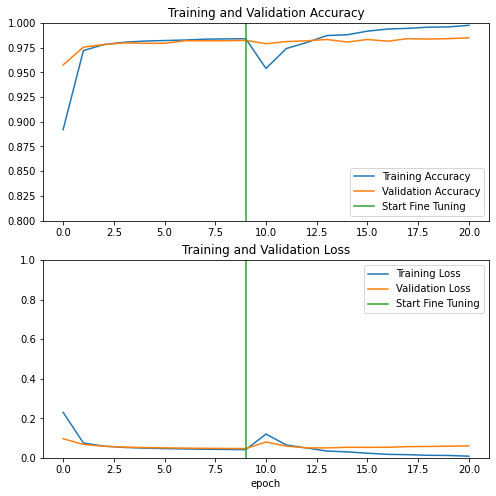

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.
